In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


# 파일 불러오기

In [2]:
ko_filename = "./data/korean-english-park.train.ko"
en_filename = "./data/korean-english-park.train.en"

In [3]:
with open(ko_filename, "r") as f:
    ko_raw = f.read().splitlines()

In [4]:
ko_raw[0]

'개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'

In [5]:
with open(en_filename, "r") as f:
    en_raw = f.read().splitlines()

In [6]:
print(len(ko_raw), len(en_raw))

94123 94123


### 중복치 제거

In [7]:
raw_corpus = []
for kc, ec in zip(ko_raw, en_raw):
    raw_corpus.append((kc.lower().strip(), ec.lower().strip()))

In [8]:
cleaned_corpus = list(set(raw_corpus))
print(len(cleaned_corpus))

78941


In [9]:
import re

def preprocess_sentence(sentence, is_english=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence) 

    sentence = sentence.strip()

    if is_english:
        sentence = '<start> ' + sentence

    if is_english:
        sentence += ' <end>'
    
    return sentence


In [10]:
kor_corpus = []
eng_corpus = []

for sentence in cleaned_corpus:
    ko_sen, en_sen = sentence
    kor_corpus.append(preprocess_sentence(ko_sen))
    eng_corpus.append(preprocess_sentence(en_sen, is_english=True))

In [11]:
kor_corpus[:10]

['라이스 장관은 그도 날 가르치지 않았고 나도 그를 가르치지 않았다 고 말했다 .',
 '조지 w . 부시 대통령은 전화를 걸어 우주비행사 가족들을 위로한 뒤 컬럼비아호를 잃어버렸다 고 말했다 .',
 '요크 씨는 일자리가 없는 사람들이 소비를 꺼리는 것이 당연하다고 말했습니다 .',
 '허리케인 오마르는 버진 아일랜드를 벗어나 부캐니어 호텔이 위치한 북대서양의 크리스천스테드로 이동하고 있습니다 .',
 '이타르타스 통신에따르면 메드베데프는 취임 몇 시간 만에 푸틴을 총리로 기용했다 .',
 '한국 재계 지도자들은 월 일 회동을 가지고 국가인권위원회의 권고안은 노동자 친화적이라며 정부가 이를 거부해야 한다고 주장했다 .',
 '이 프로그램들이 성행위의 시작을 앞당기는 것도 아닙니다 .',
 '이 일은 지난해 한국을 떠들썩하게 만들었던 서래마을 영아 유기사건을 상기 시킨다 .',
 '일 바그다드에서 서쪽으로 마일 떨어진 라마디의 이라크 경찰 검문소에서도 자살 차량 폭탄 테러가 발생 , 이라크 경찰 명이 숨지고 명이 다쳤다고 이라크 내무부 관계자가 전했다 .',
 '미국과 북한의 상대 비방 발언 점차 심해져']

In [12]:
eng_corpus[:10]

['<start> i didn t lecture him and he didn t lecture me , rice said . <end>',
 '<start> the columbia is lost , said president george w . bush , after telephoning the families of the astronauts to console them . <end>',
 '<start> york says it s pretty obvious that jobless people are reluctant to spend . <end>',
 '<start> hurricane omar is leaving the virgin islands and now making its way to the north atlantic at the buccaneer hotel in christiansted . <end>',
 '<start> within hours , medvedev named putin as prime minister , according to the itar tass news agency . <end>',
 '<start> korean business leaders tuesday united to urge the government to reject what they call a labor friendly set of recommendations by the national human rights commission . <end>',
 '<start> they do not hasten the onset of sex . <end>',
 '<start> the case is reminiscent of the so called seoul freezer babies story , which made headlines in france last year . <end>',
 '<start> on wednesday , three iraqi police offic

### 길이 40 기준으로 짜르기

In [13]:
max_len = 40

kor_corpus_cut = []
eng_corpus_cut = []

for kor_sen, eng_sen in zip(kor_corpus, eng_corpus):
    if len(kor_sen) <= max_len:
        kor_corpus_cut.append(kor_sen)
        eng_corpus_cut.append(eng_sen)
        
kor_corpus = kor_corpus_cut
eng_corpus = eng_corpus_cut

In [14]:
len(kor_corpus)

16234

In [15]:
len(eng_corpus)

16234

In [24]:
import tensorflow as tf
from konlpy.tag import Mecab

mecab = Mecab()

def tokenize(corpus, is_english, num_words=10000):
    if is_english:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)

        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, tokenizer
    

    morphs_corpus = [" ".join(mecab.morphs(sen)) for sen in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    tokenizer.fit_on_texts(morphs_corpus)

    tensor = tokenizer.texts_to_sequences(morphs_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [17]:
_, all_kor_tokenizer = tokenize(kor_corpus, False, None)
_, all_eng_tokenizer = tokenize(eng_corpus, True, None)

print(len(all_kor_tokenizer.index_word) + 1)
print(len(all_eng_tokenizer.index_word) + 1)


17365
16850


전체 단어의 길이를 체크하였다.

In [18]:
eng_word_index = {}

for k in range(1, len(all_eng_tokenizer.index_word) + 1):
    eng_word_index[all_eng_tokenizer.index_word[k]] = k

In [19]:
test_list = [
    'obama is the president . <end>',
    'people are victims of the city . <end>',
    'the price is not enough . <end>',
    'seven people have died . <end>'
]

In [20]:
for test_str in test_list:
    res = []
    for test_word in test_str.split():
        res.append(eng_word_index[test_word])
    print(res)

[101, 12, 4, 74, 3, 2]
[40, 23, 539, 6, 4, 148, 3, 2]
[4, 550, 12, 30, 694, 3, 2]
[338, 40, 24, 156, 3, 2]


In [21]:
kor_word_index = {}

for k in range(1, len(all_kor_tokenizer.index_word) + 1):
    kor_word_index[all_kor_tokenizer.index_word[k]] = k

In [22]:
test_kor_list = [
  '오바마는 대통령이다.',
'시민들은 도시 속에 산다.',
'커피는 필요 없다.',
'일곱 명의 사망자가 발생했다.',
]

In [25]:
for test_str in test_kor_list:
    res = []
    for test_word in mecab.morphs(test_str):
        res.append(kor_word_index.get(test_word, 0))
    print(res)

[126, 3, 62, 4, 2, 1]
[1005, 14, 5, 268, 550, 8, 0, 1]
[1286, 3, 259, 47, 2, 1]
[15284, 26, 6, 318, 15, 135, 9, 2, 1]


In [26]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus, False, 10000)
eng_tensor, eng_tokenizer = tokenize(eng_corpus, True, 10000)

In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       recurrent_dropout=0.4,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       recurrent_dropout=0.4,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [29]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 16850)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [31]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [33]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = " ".join(mecab.morphs(sentence))
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))



In [37]:
def train_model(epohcs):
    for epoch in range(epohcs):
        total_loss = 0

        idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
    #         print(idx)
            batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                    eng_tensor[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    optimizer,
                                    eng_tokenizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

        loss_history.append(total_loss.numpy() / len(idx_list))
        translate("오바마는 대통령이다.", encoder, decoder)
        translate("시민들은 도시 속에 산다.", encoder, decoder)
        translate("커피는 필요 없다.", encoder, decoder)
        translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Epoch  1: 100%|██████████| 254/254 [03:32<00:00,  1.20it/s, Loss 1.4418]


Input: 오바마 는 대통령 이 다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


/tmp/ipykernel_485/256261653.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_485/256261653.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


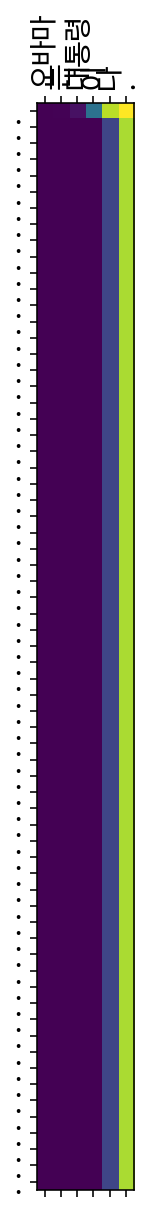

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


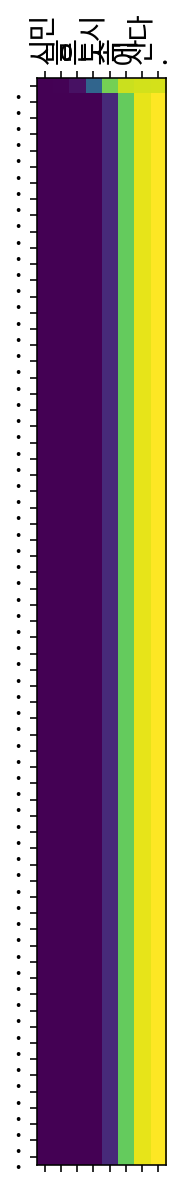

Input: 커피 는 필요 없 다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


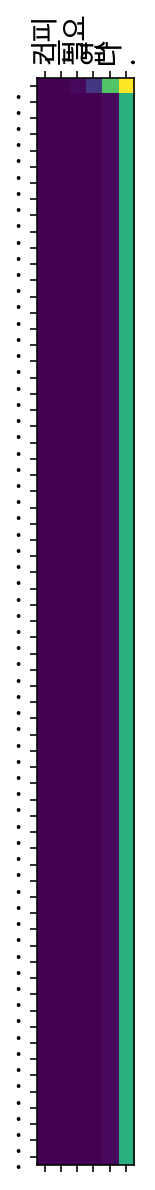

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


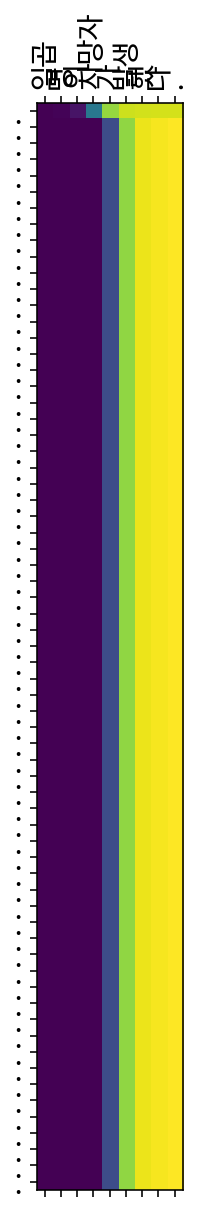

Epoch  2: 100%|██████████| 254/254 [00:56<00:00,  4.46it/s, Loss 1.3759]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


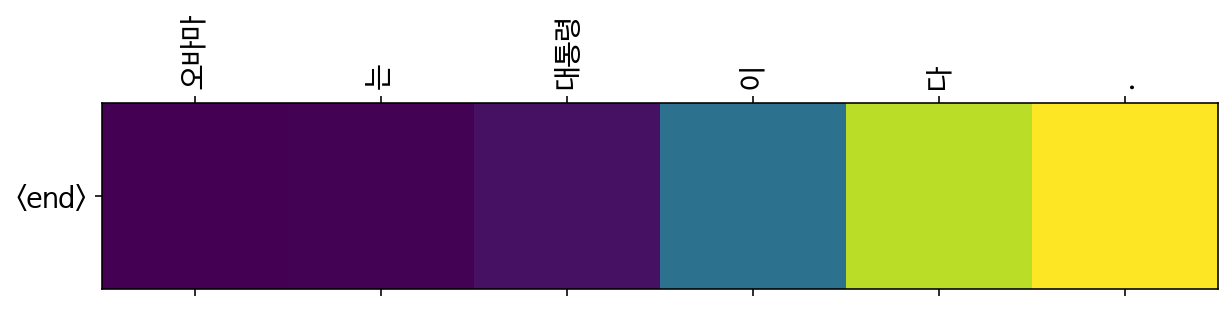

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


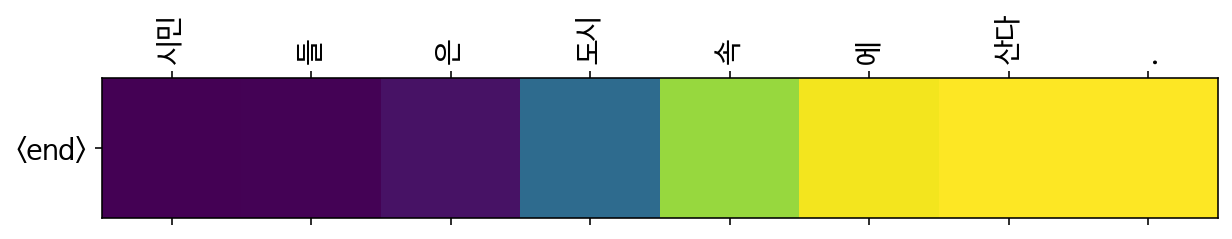

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


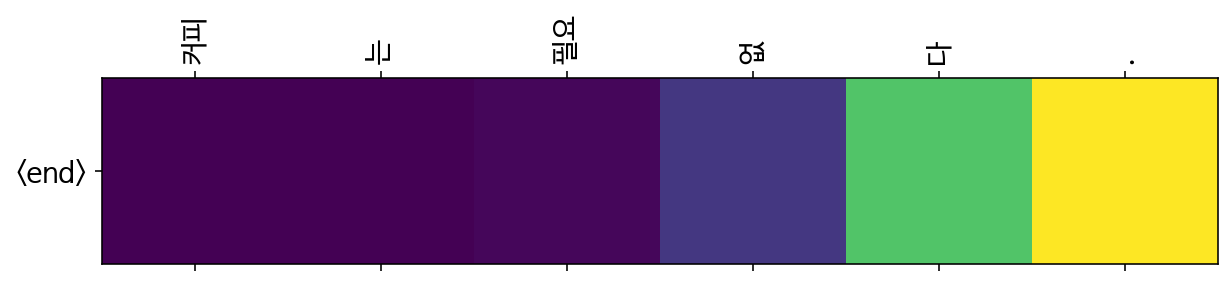

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


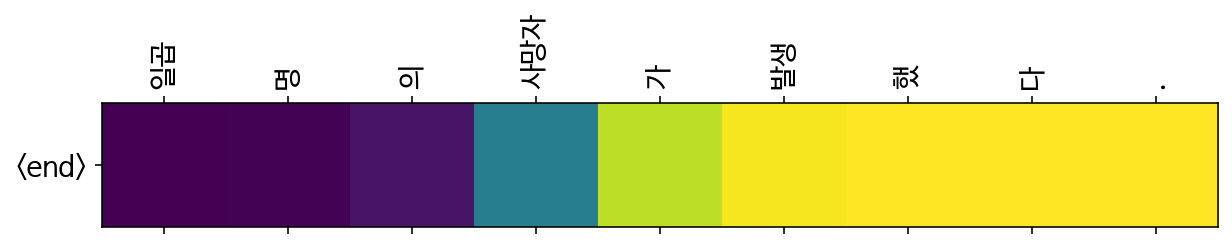

Epoch  3: 100%|██████████| 254/254 [00:56<00:00,  4.47it/s, Loss 1.3757]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


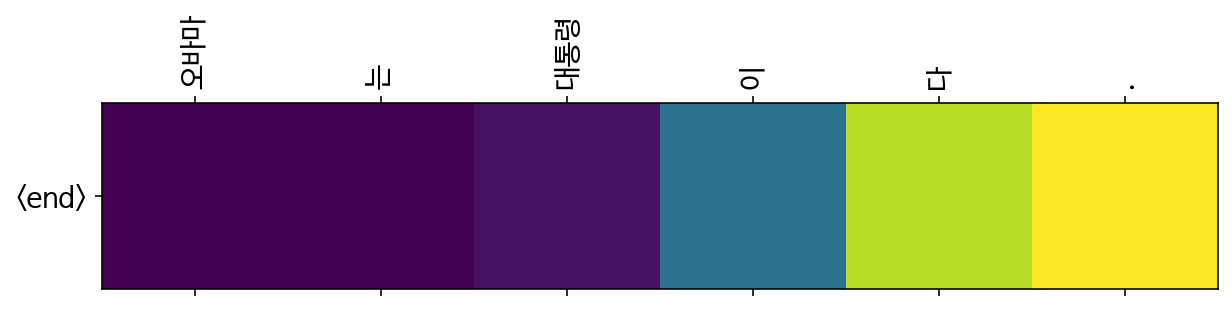

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


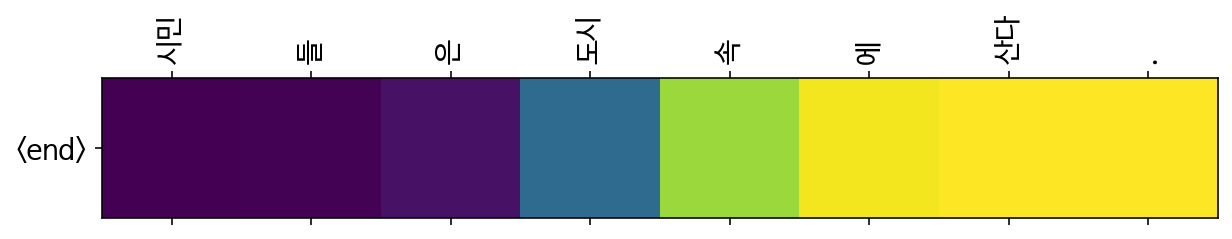

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


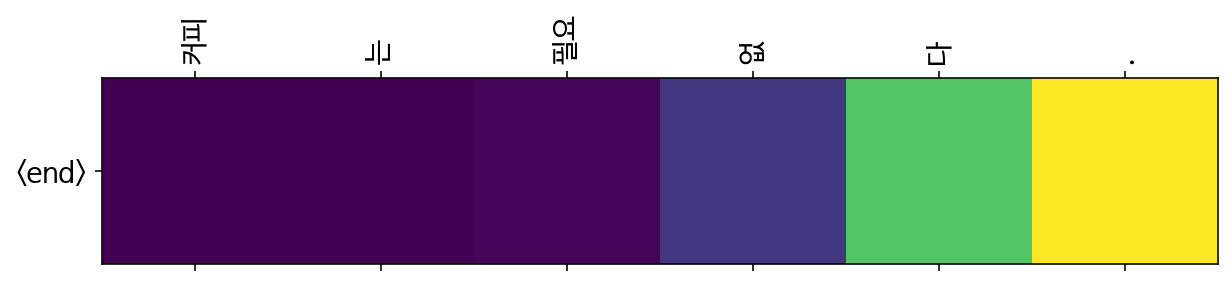

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


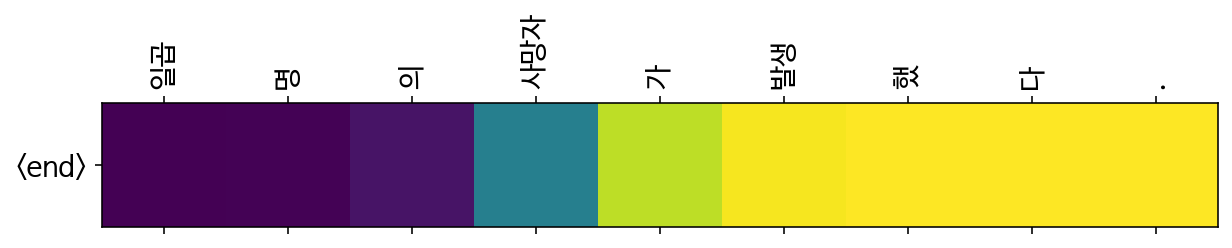

Epoch  4: 100%|██████████| 254/254 [00:57<00:00,  4.41it/s, Loss 1.3757]


Input: 오바마 는 대통령 이 다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


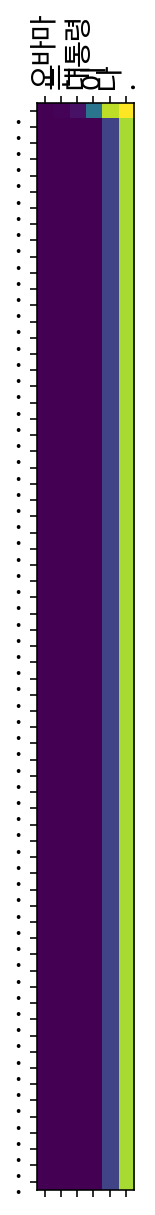

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


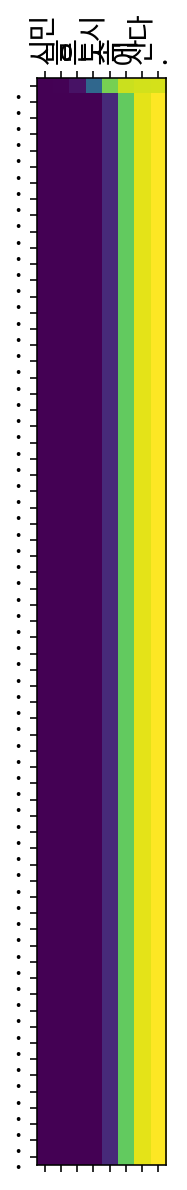

Input: 커피 는 필요 없 다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


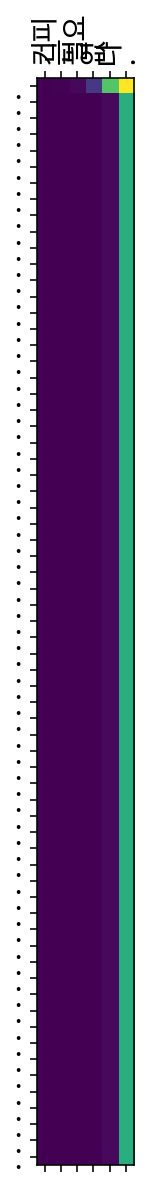

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


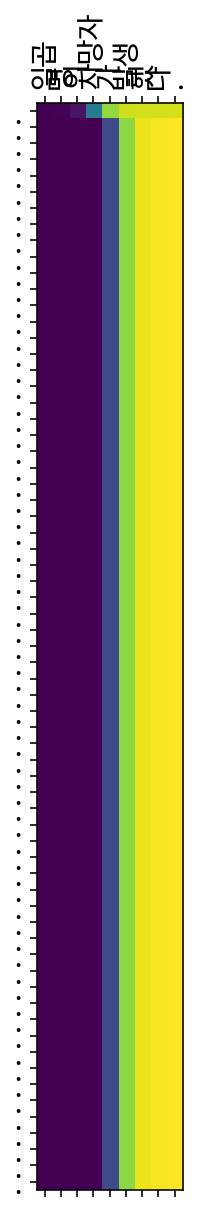

Epoch  5: 100%|██████████| 254/254 [00:58<00:00,  4.37it/s, Loss 1.3760]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


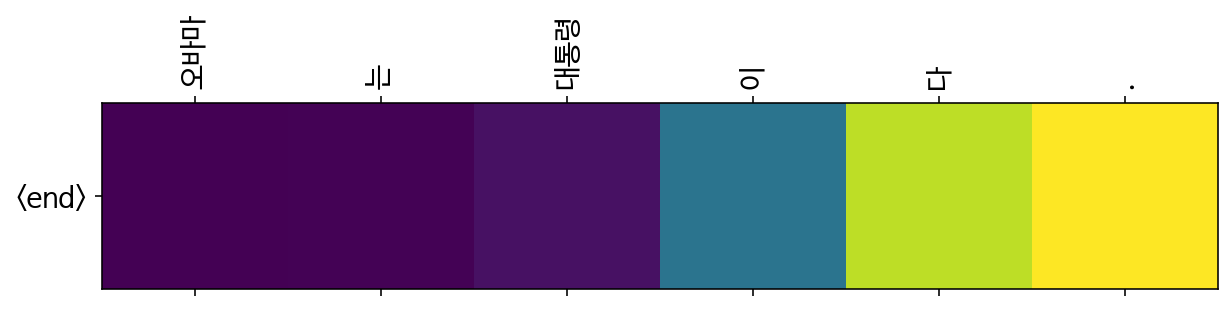

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


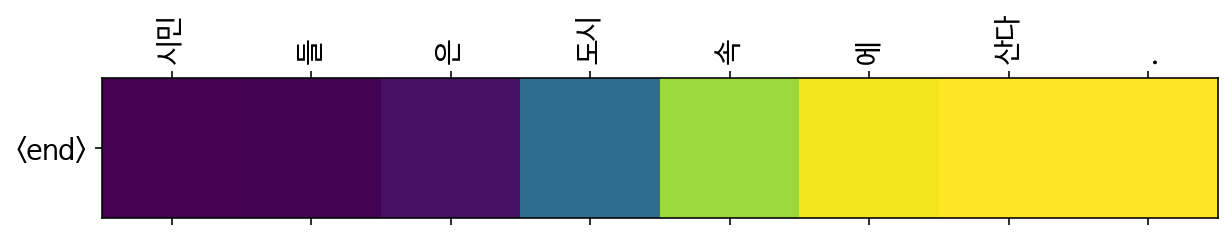

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


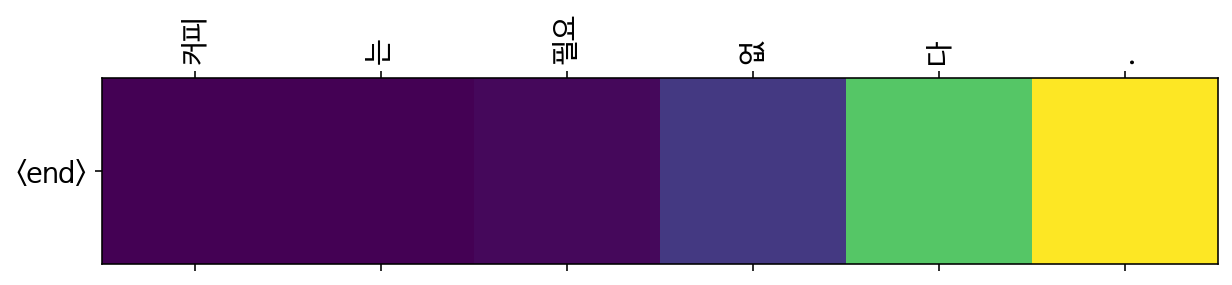

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


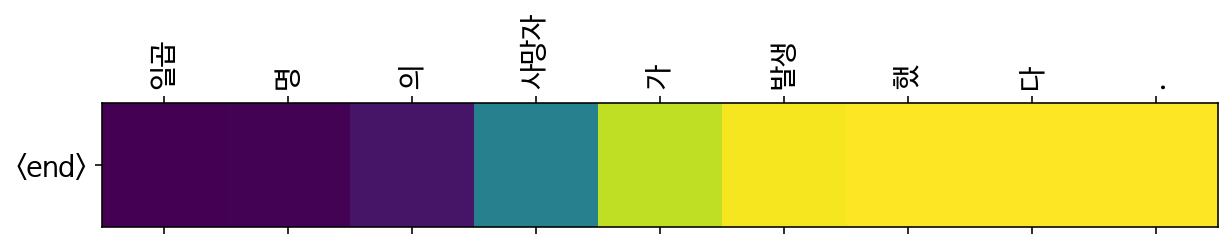

Epoch  6: 100%|██████████| 254/254 [00:57<00:00,  4.40it/s, Loss 1.3757]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


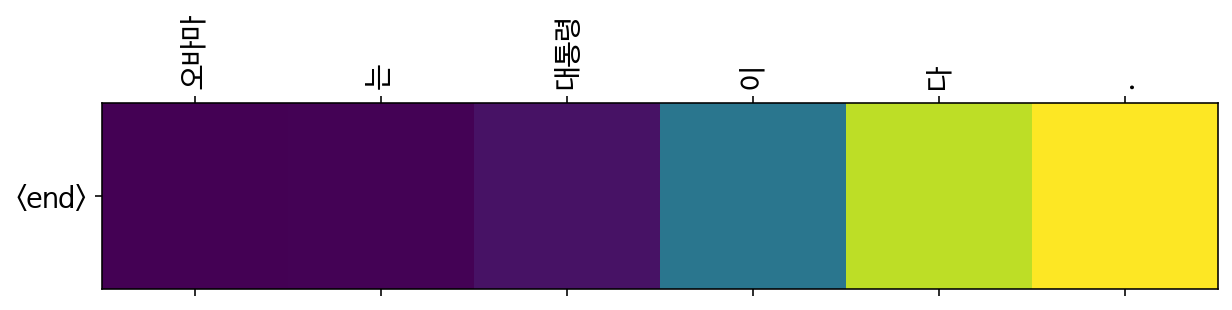

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


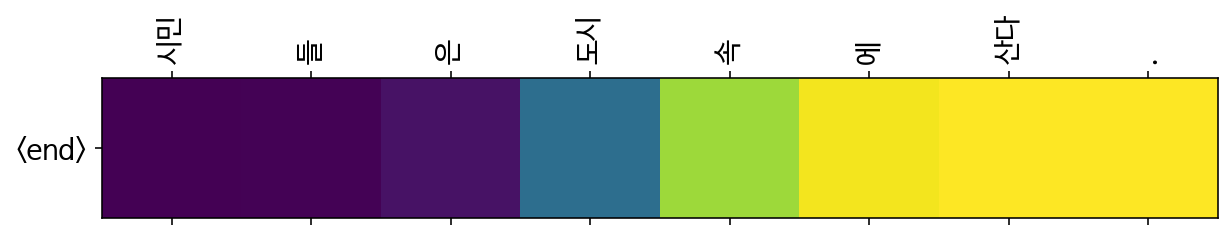

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


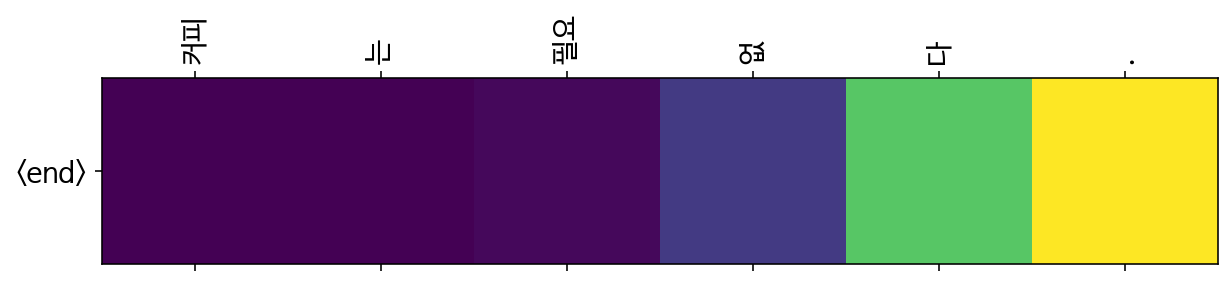

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


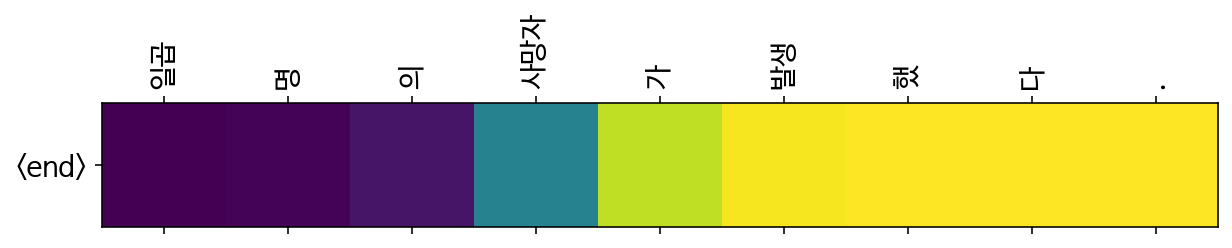

Epoch  7: 100%|██████████| 254/254 [00:57<00:00,  4.42it/s, Loss 1.3759]


Input: 오바마 는 대통령 이 다 .
Predicted translation: <end> 


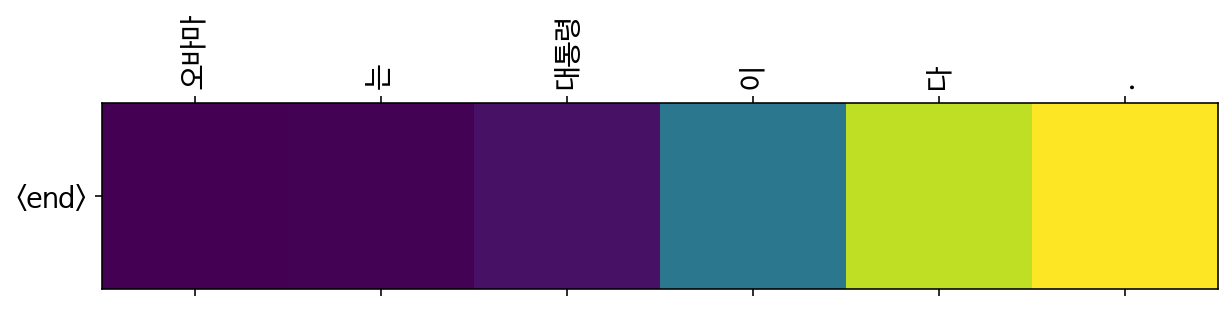

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: <end> 


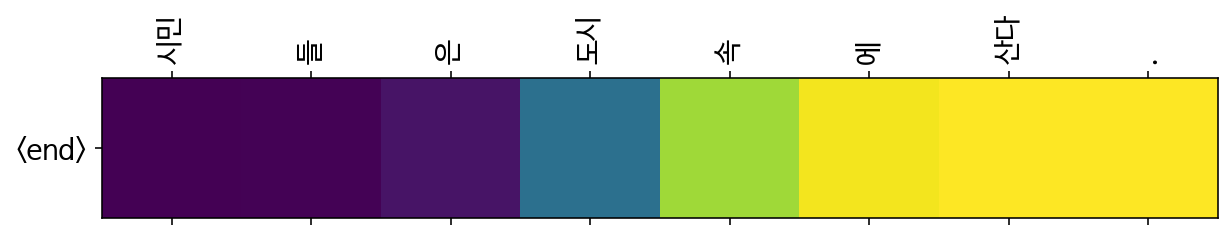

Input: 커피 는 필요 없 다 .
Predicted translation: <end> 


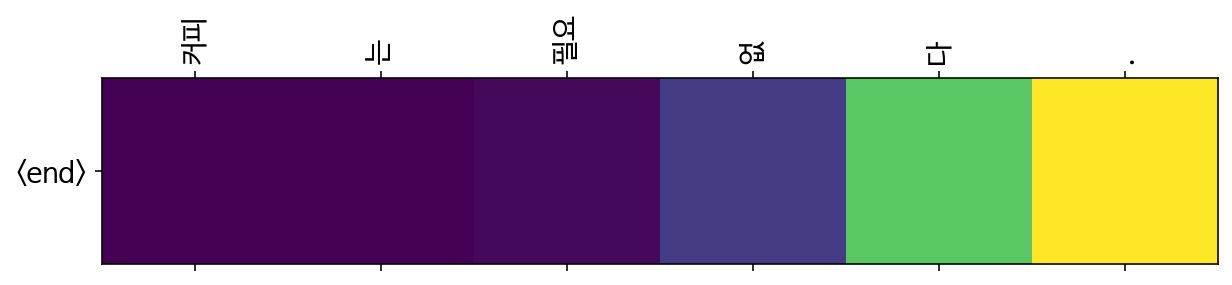

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: <end> 


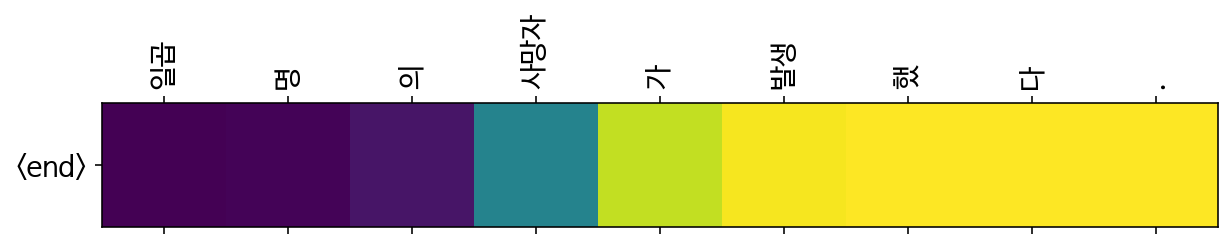

Epoch  8: 100%|██████████| 254/254 [00:57<00:00,  4.39it/s, Loss 1.3674]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


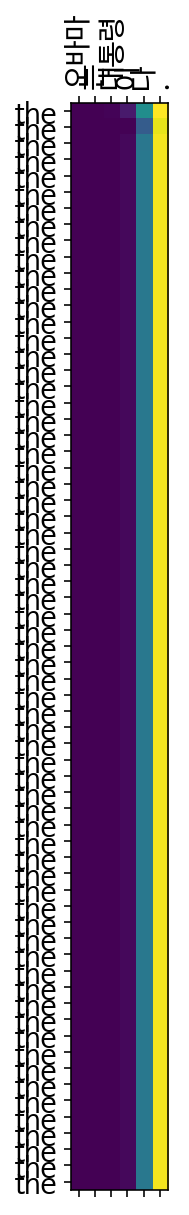

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


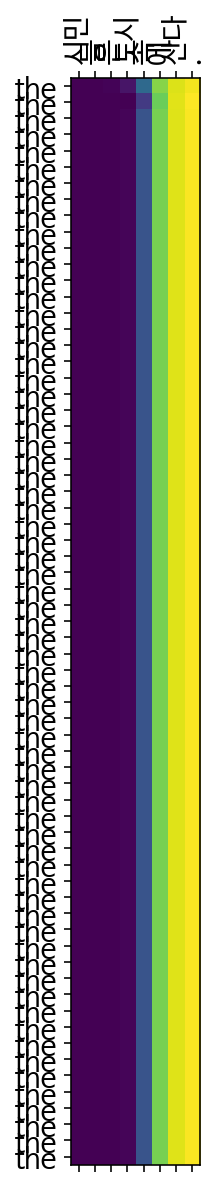

Input: 커피 는 필요 없 다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


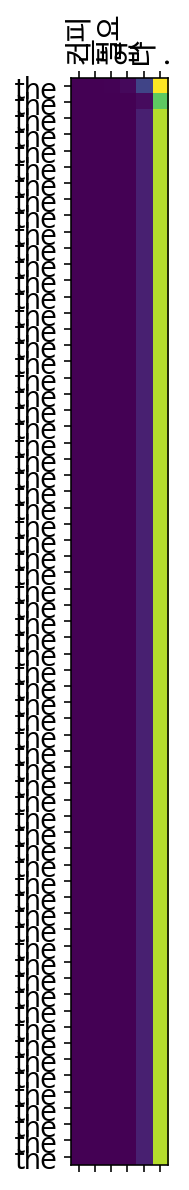

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


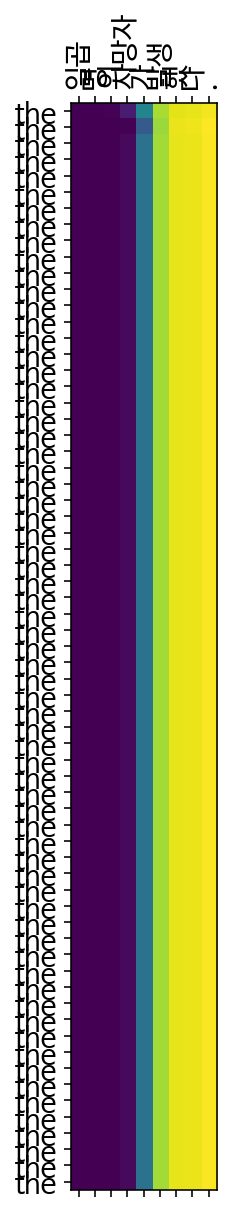

Epoch  9: 100%|██████████| 254/254 [00:58<00:00,  4.36it/s, Loss 1.2866]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the . <end> 


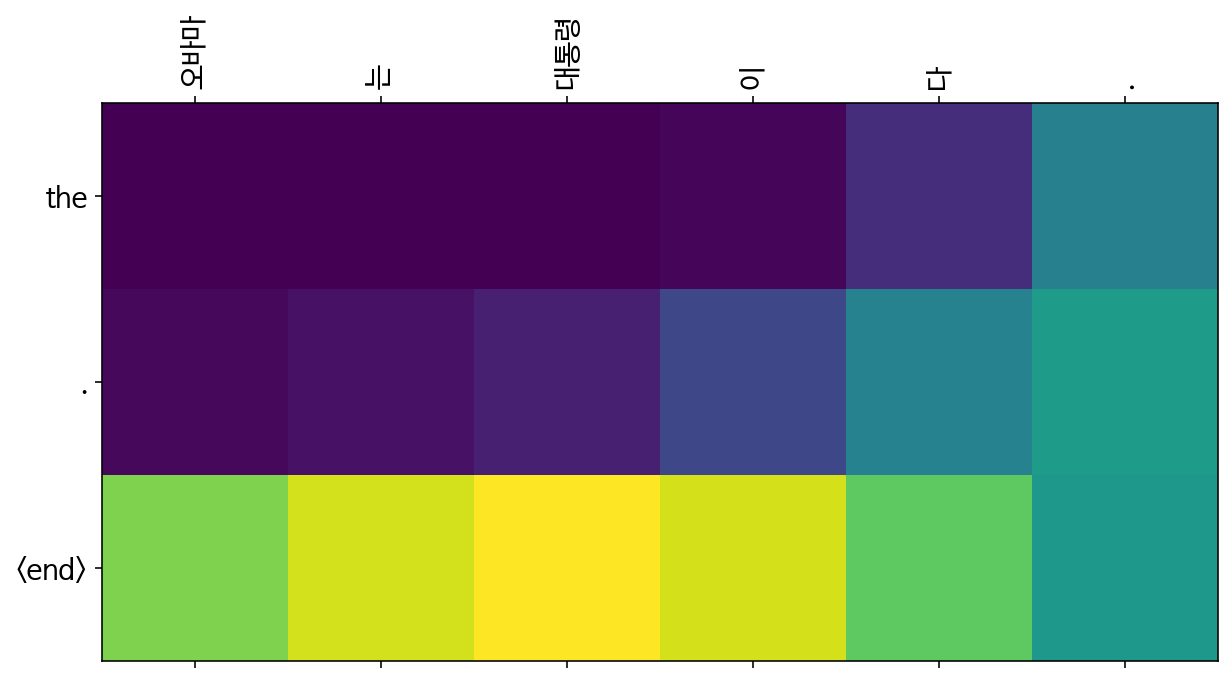

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the . <end> 


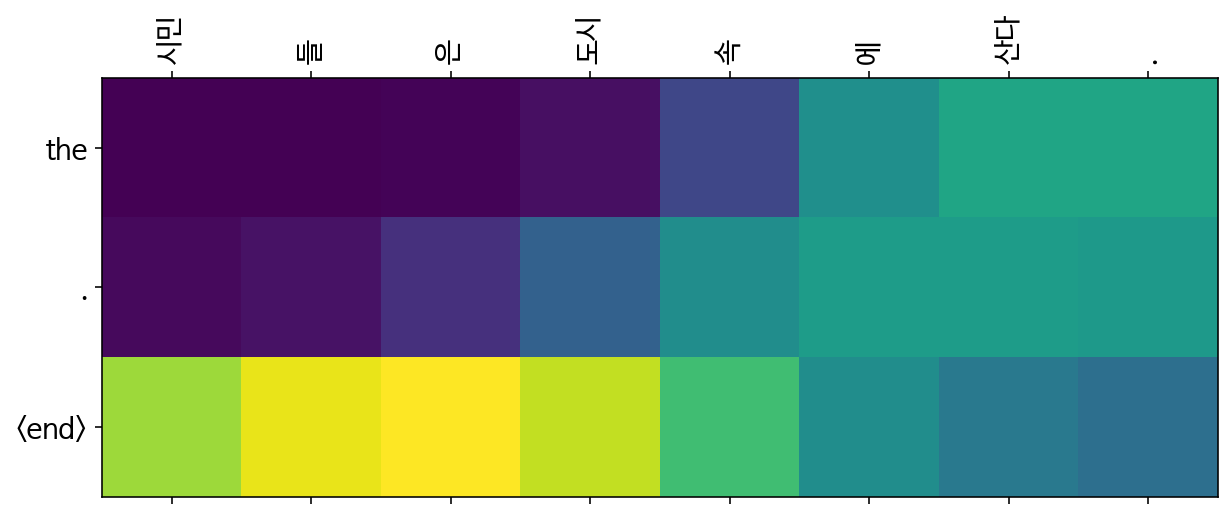

Input: 커피 는 필요 없 다 .
Predicted translation: the . <end> 


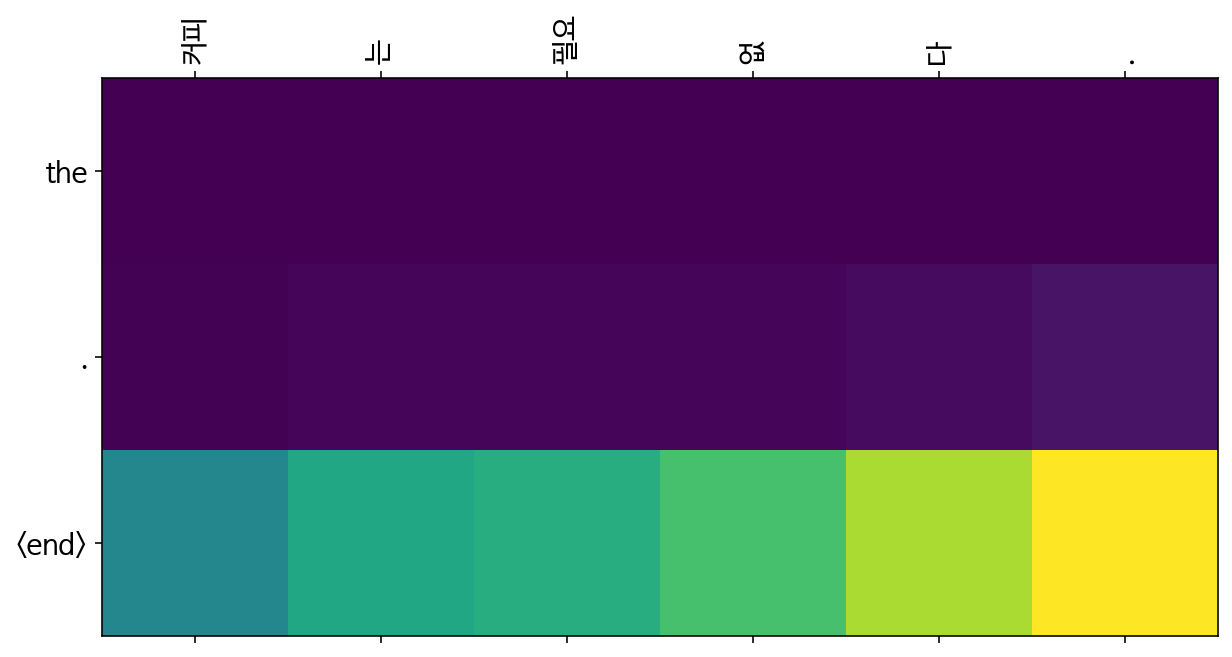

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the . <end> 


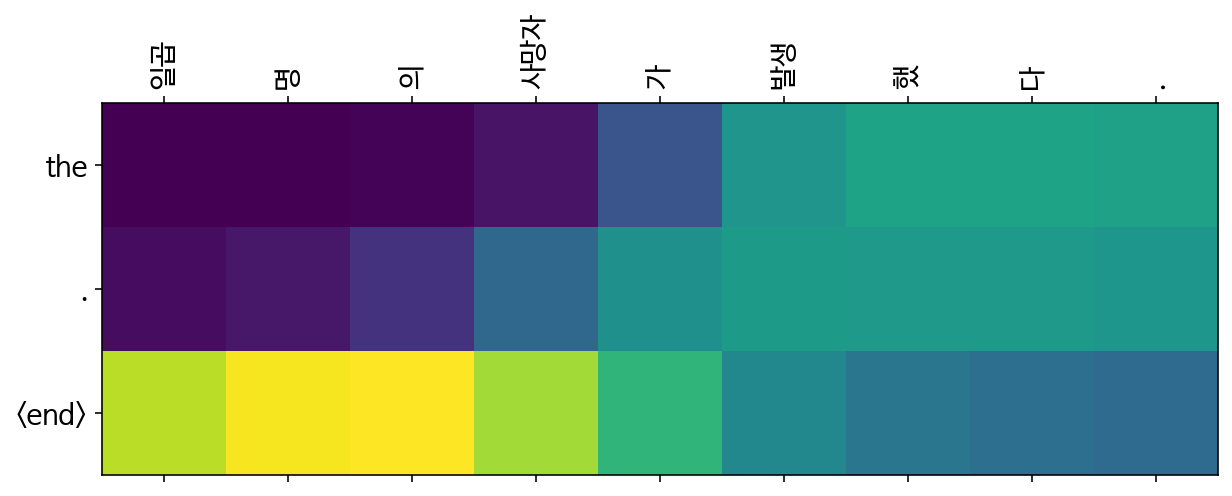

Epoch 10: 100%|██████████| 254/254 [00:57<00:00,  4.38it/s, Loss 1.2406]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the . <end> 


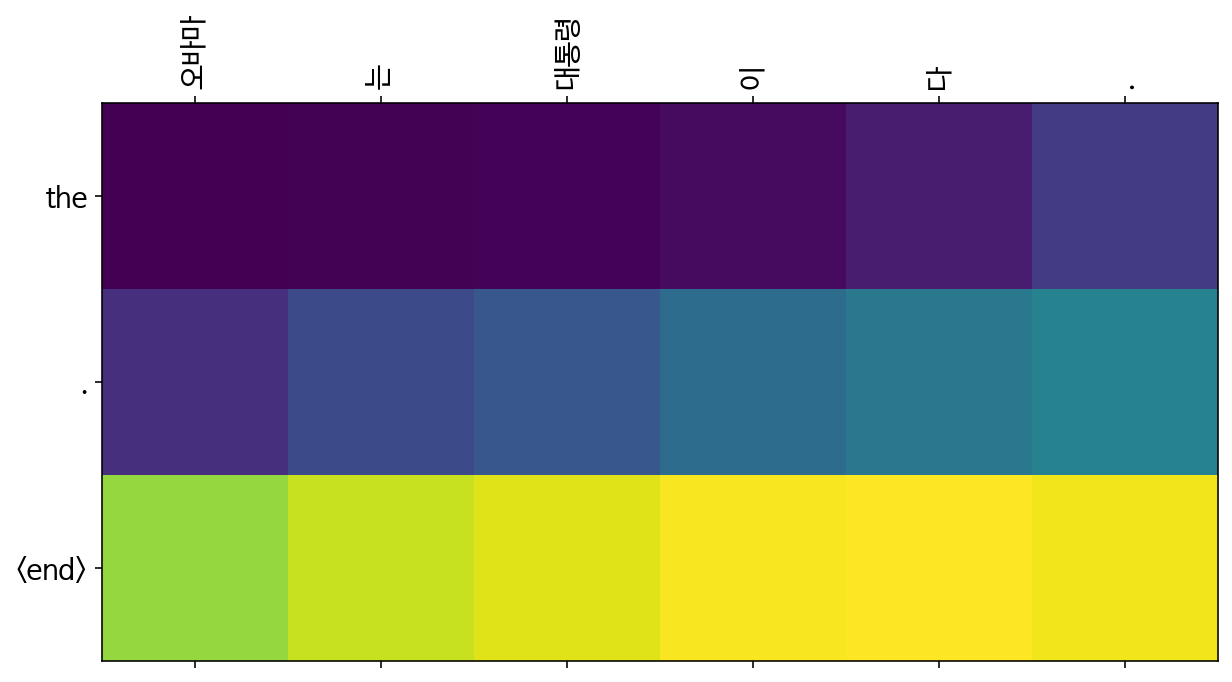

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the . <end> 


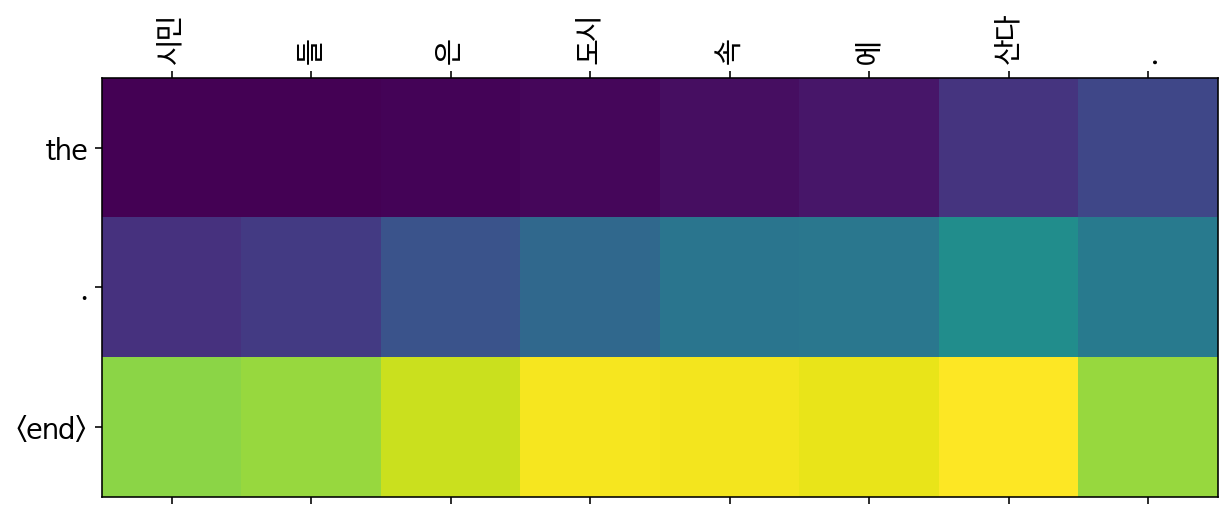

Input: 커피 는 필요 없 다 .
Predicted translation: the . <end> 


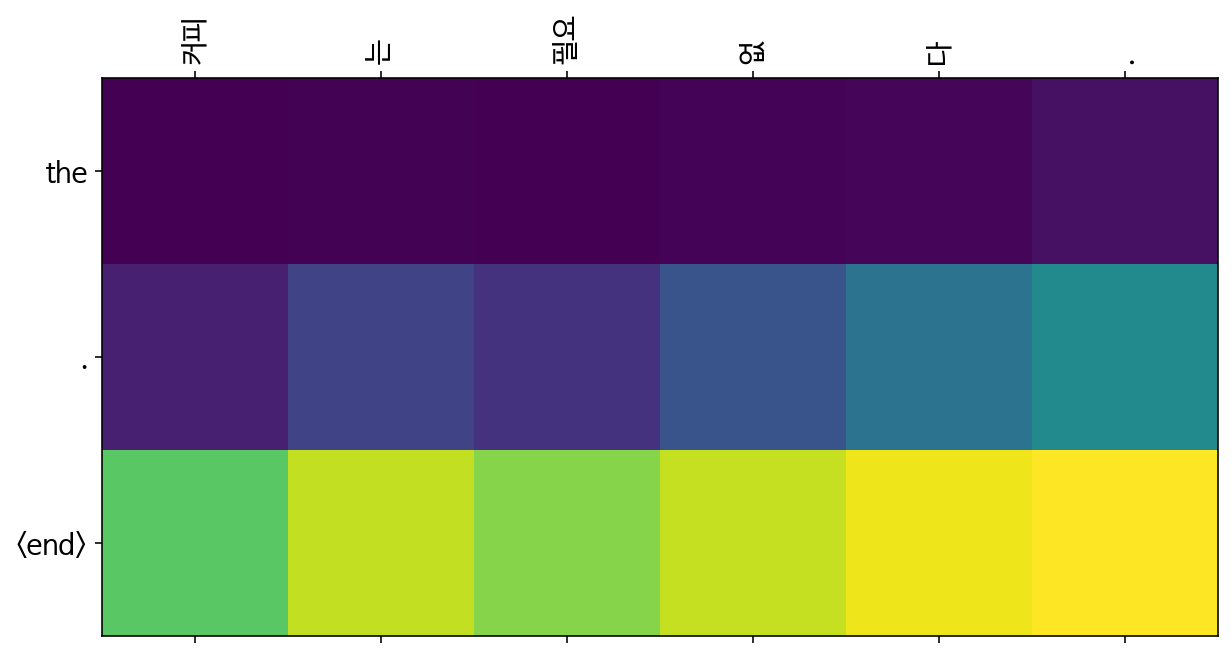

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the . <end> 


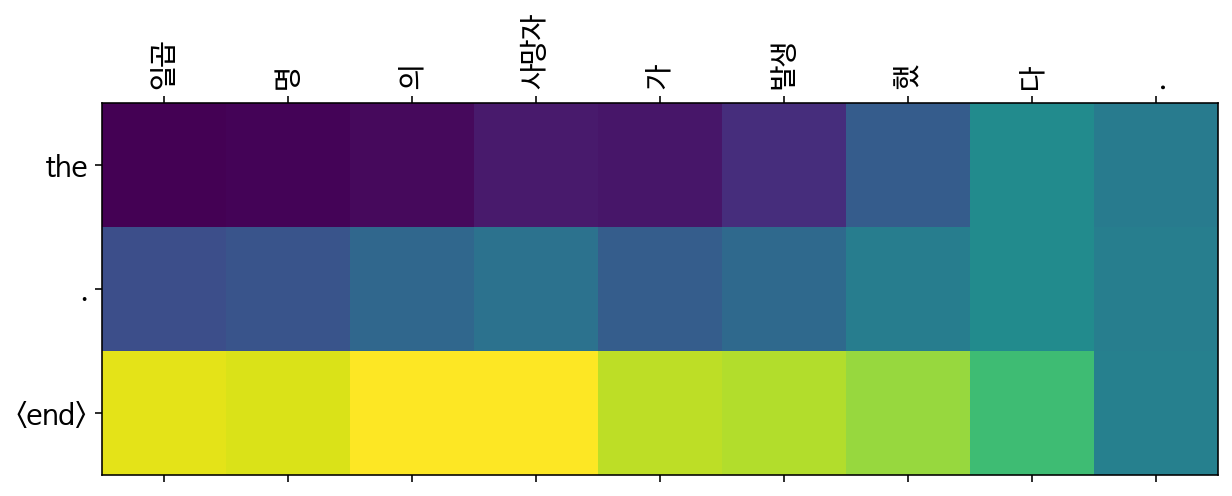

Epoch 11: 100%|██████████| 254/254 [00:58<00:00,  4.37it/s, Loss 1.1985]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the first . <end> 


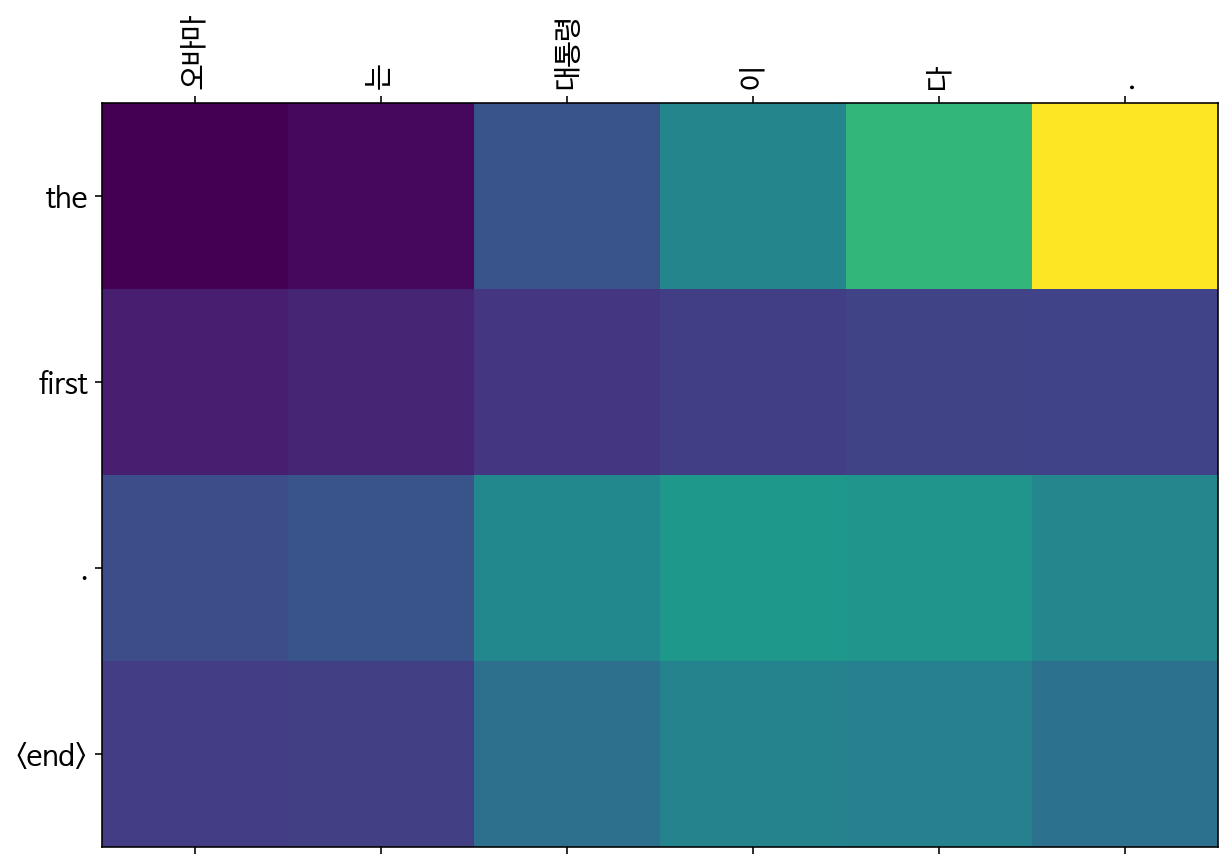

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the first . <end> 


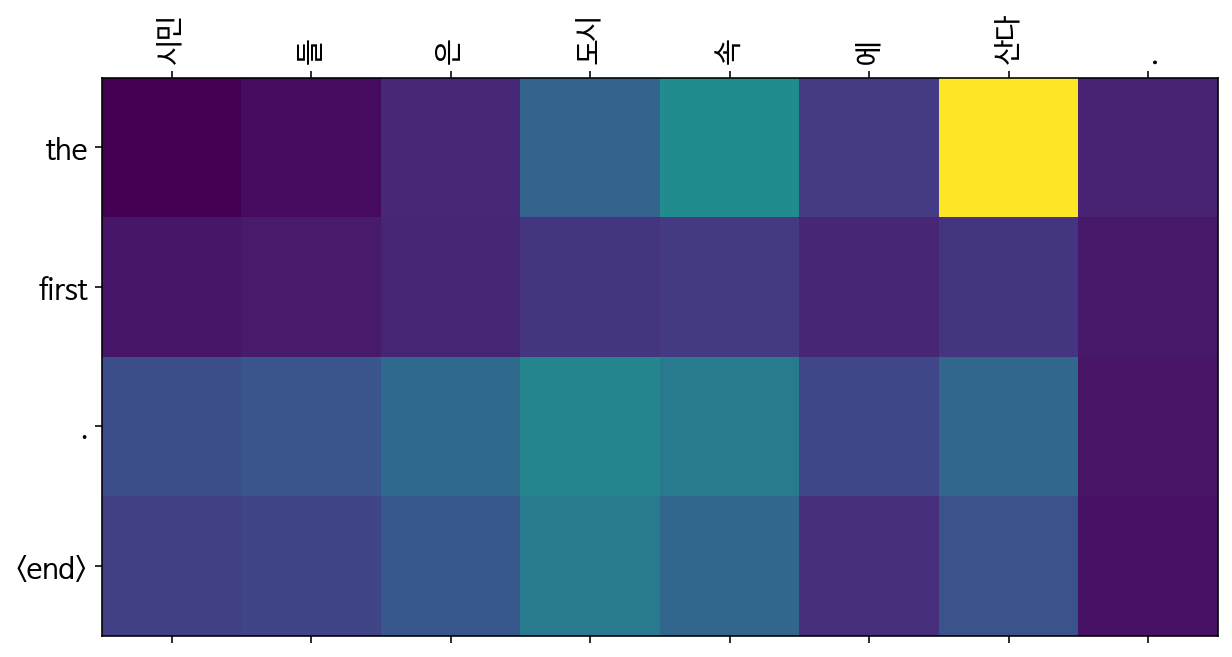

Input: 커피 는 필요 없 다 .
Predicted translation: the first . <end> 


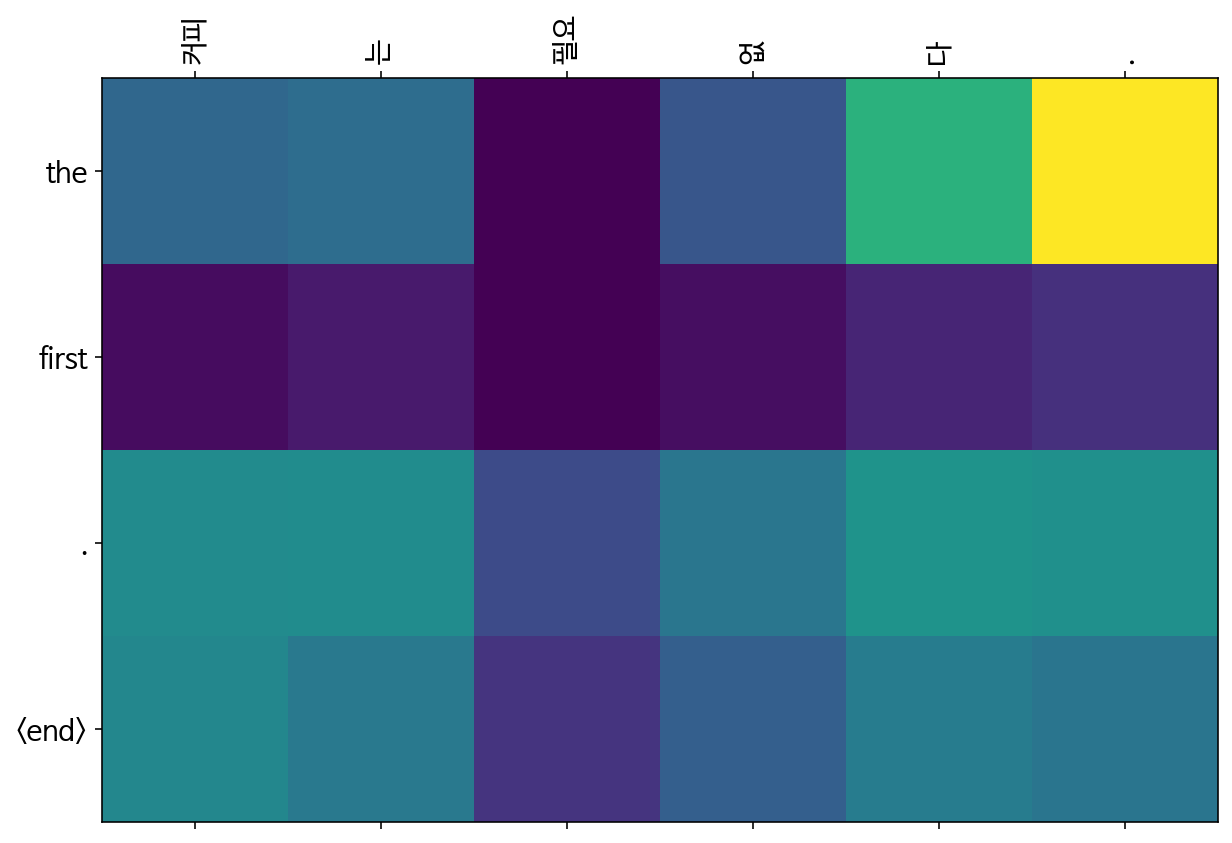

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the first . <end> 


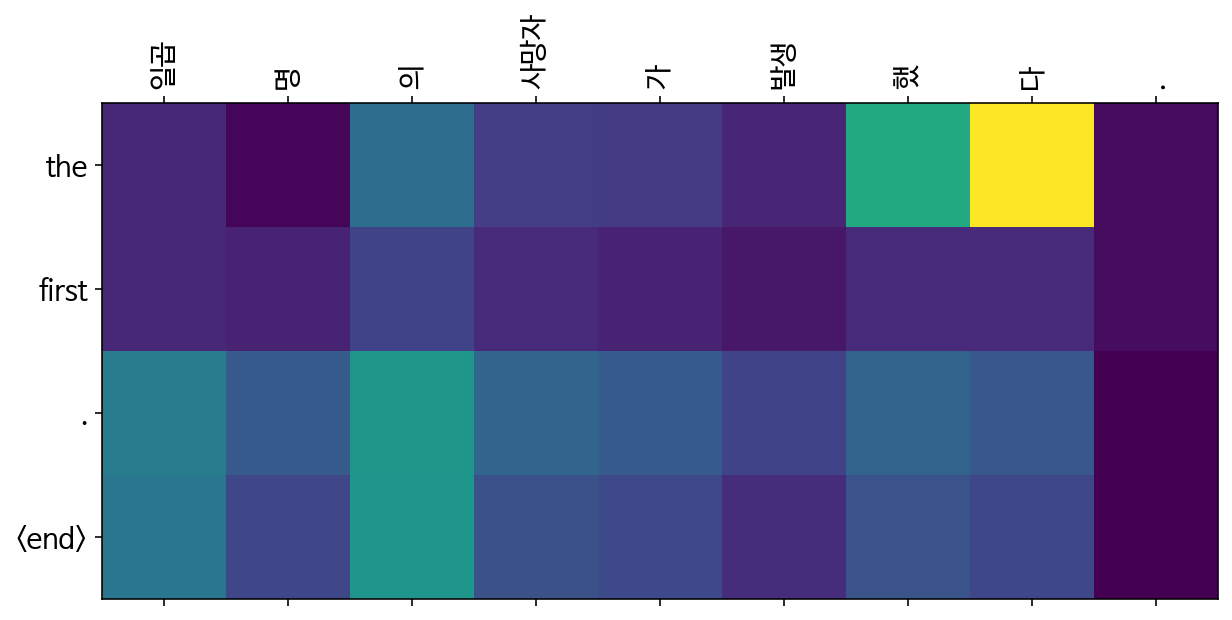

Epoch 12: 100%|██████████| 254/254 [00:58<00:00,  4.37it/s, Loss 1.1599]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the first . <end> 


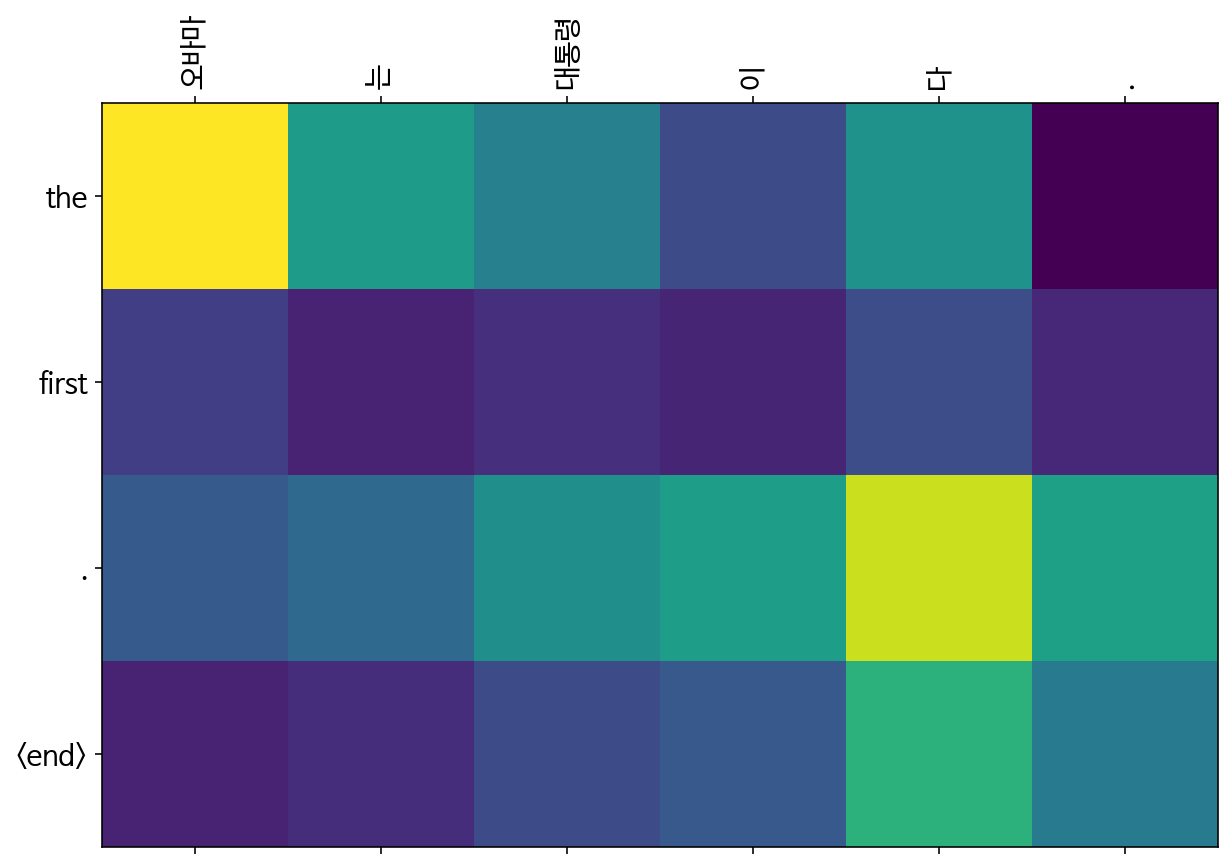

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the first . <end> 


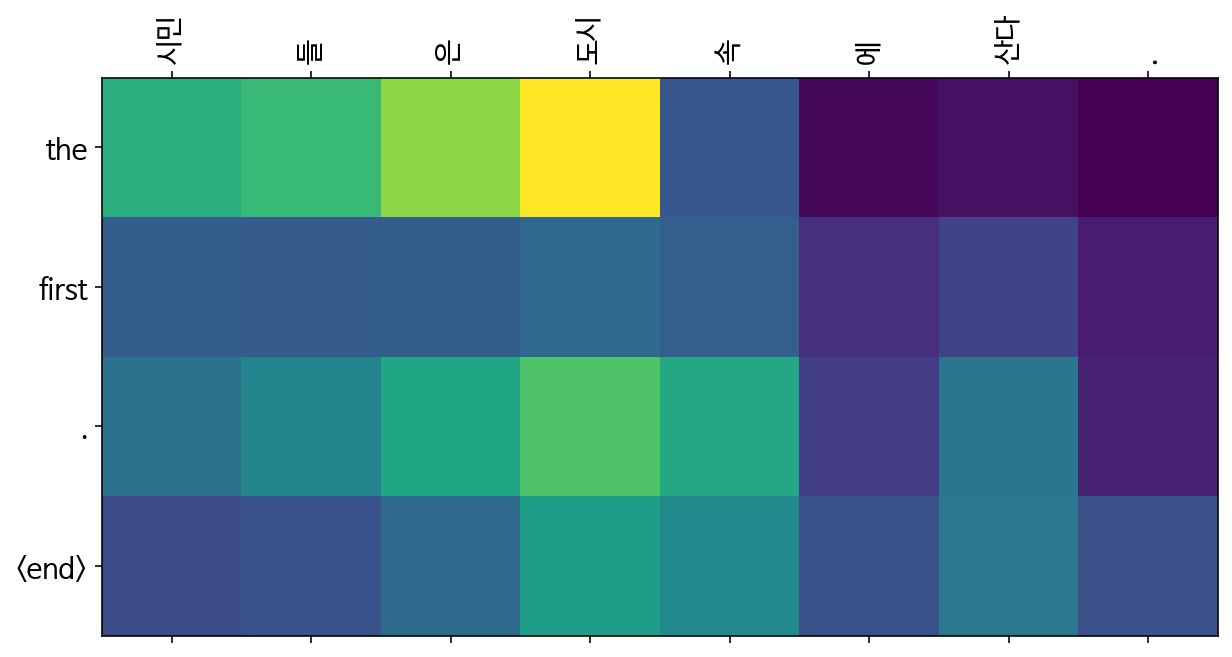

Input: 커피 는 필요 없 다 .
Predicted translation: the first . <end> 


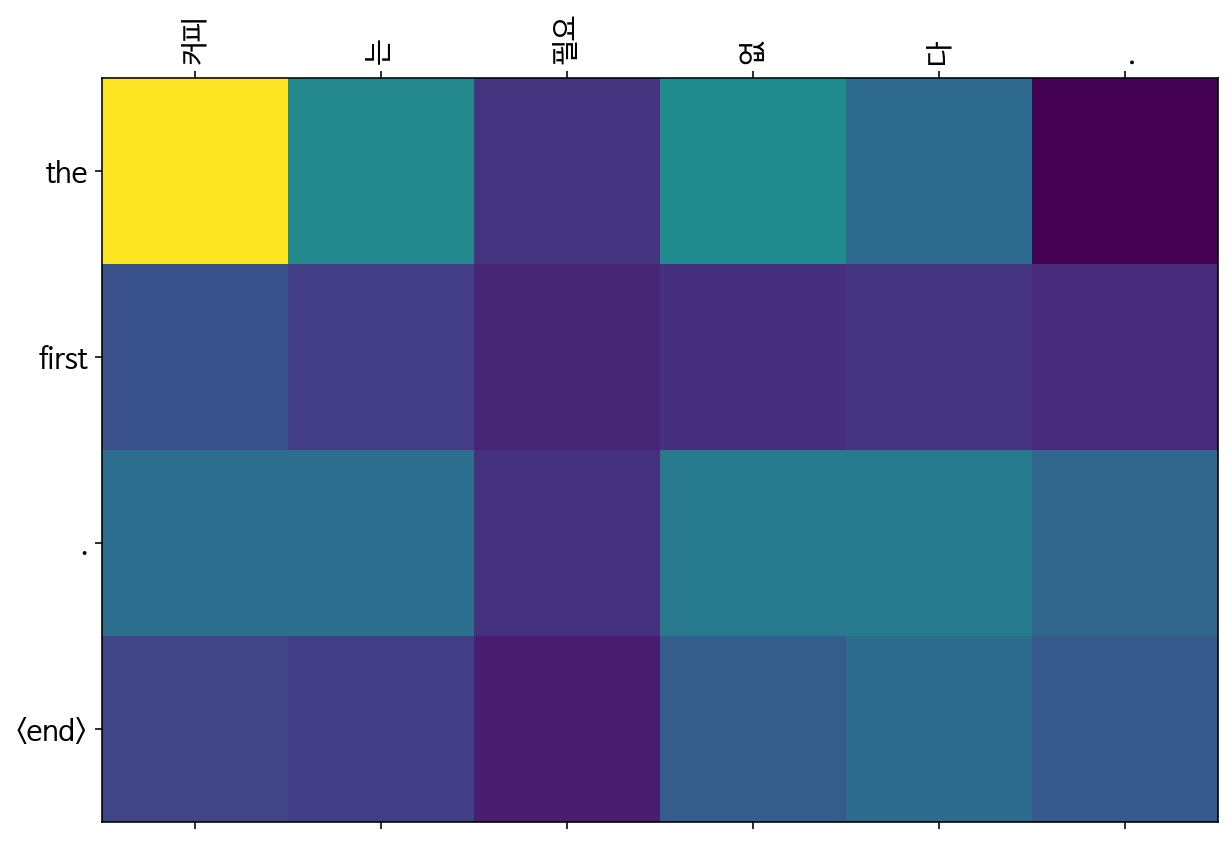

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the first year . <end> 


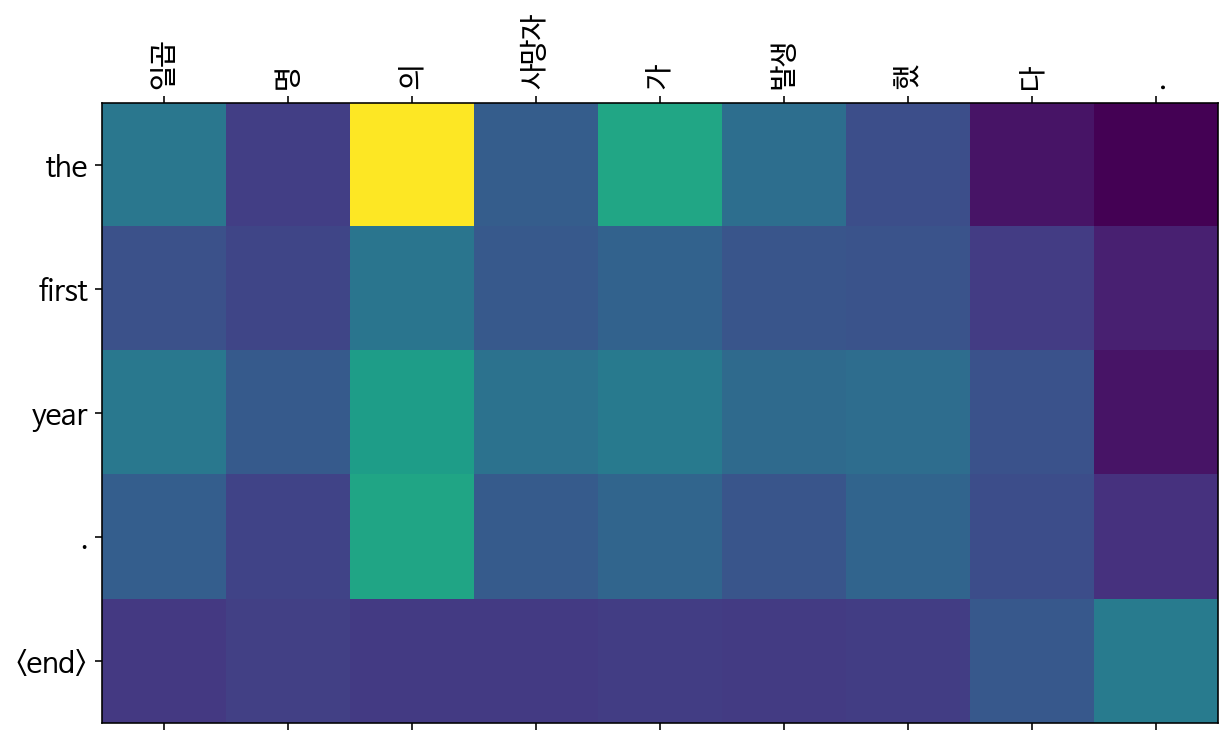

Epoch 13: 100%|██████████| 254/254 [00:57<00:00,  4.39it/s, Loss 1.1249]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the first . <end> 


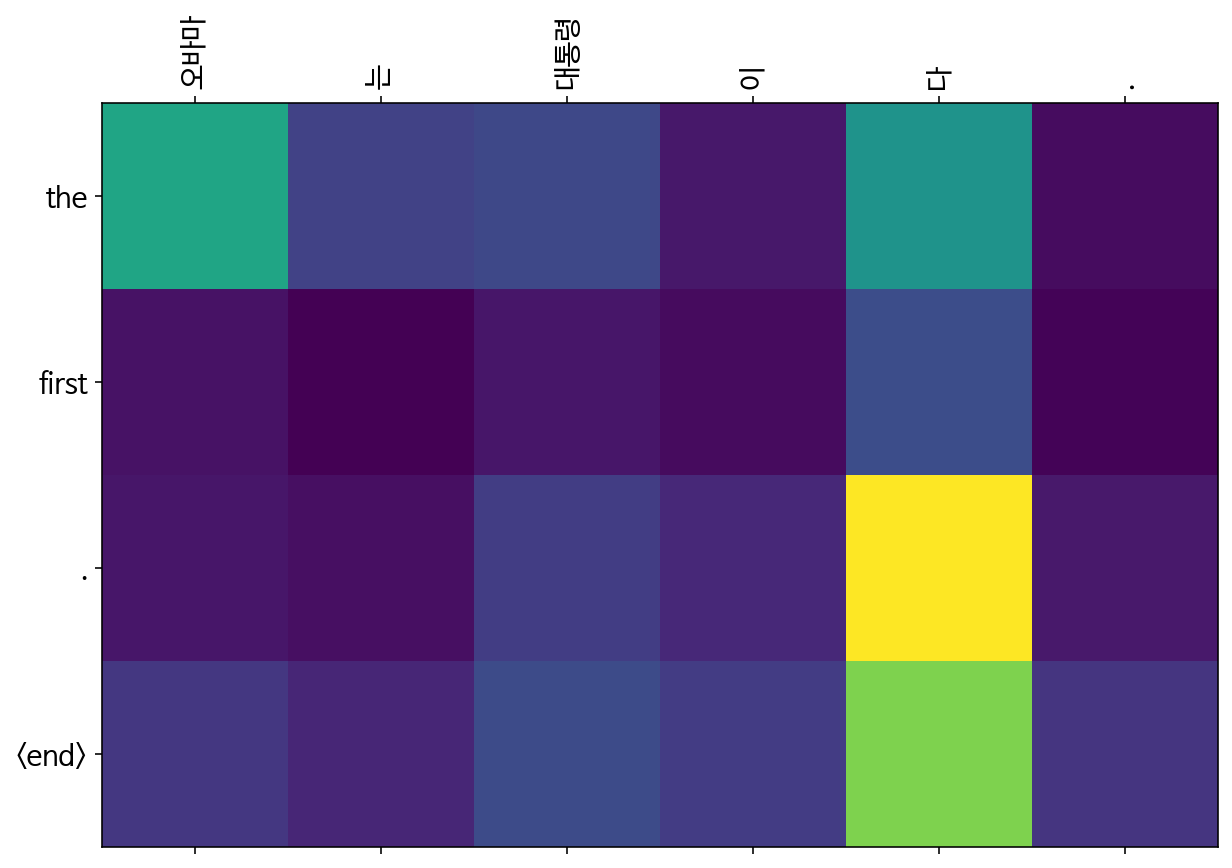

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the first year . <end> 


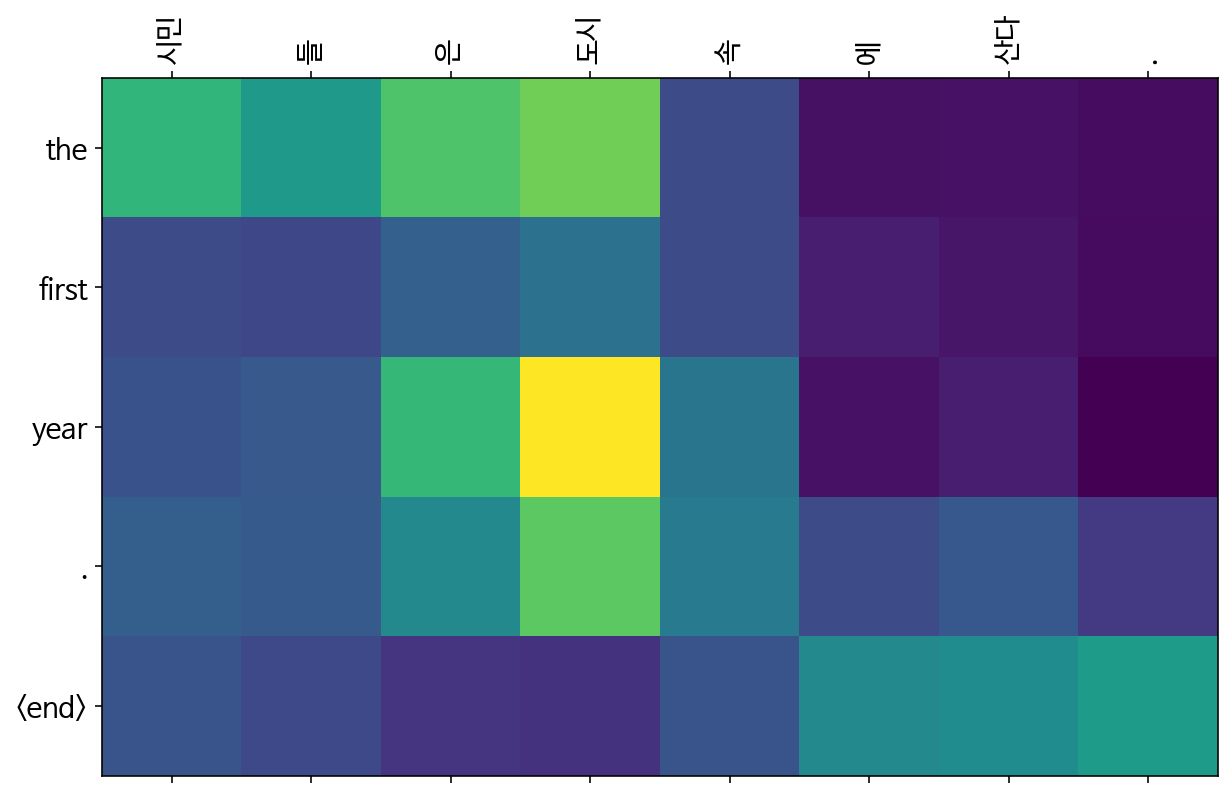

Input: 커피 는 필요 없 다 .
Predicted translation: the first year . <end> 


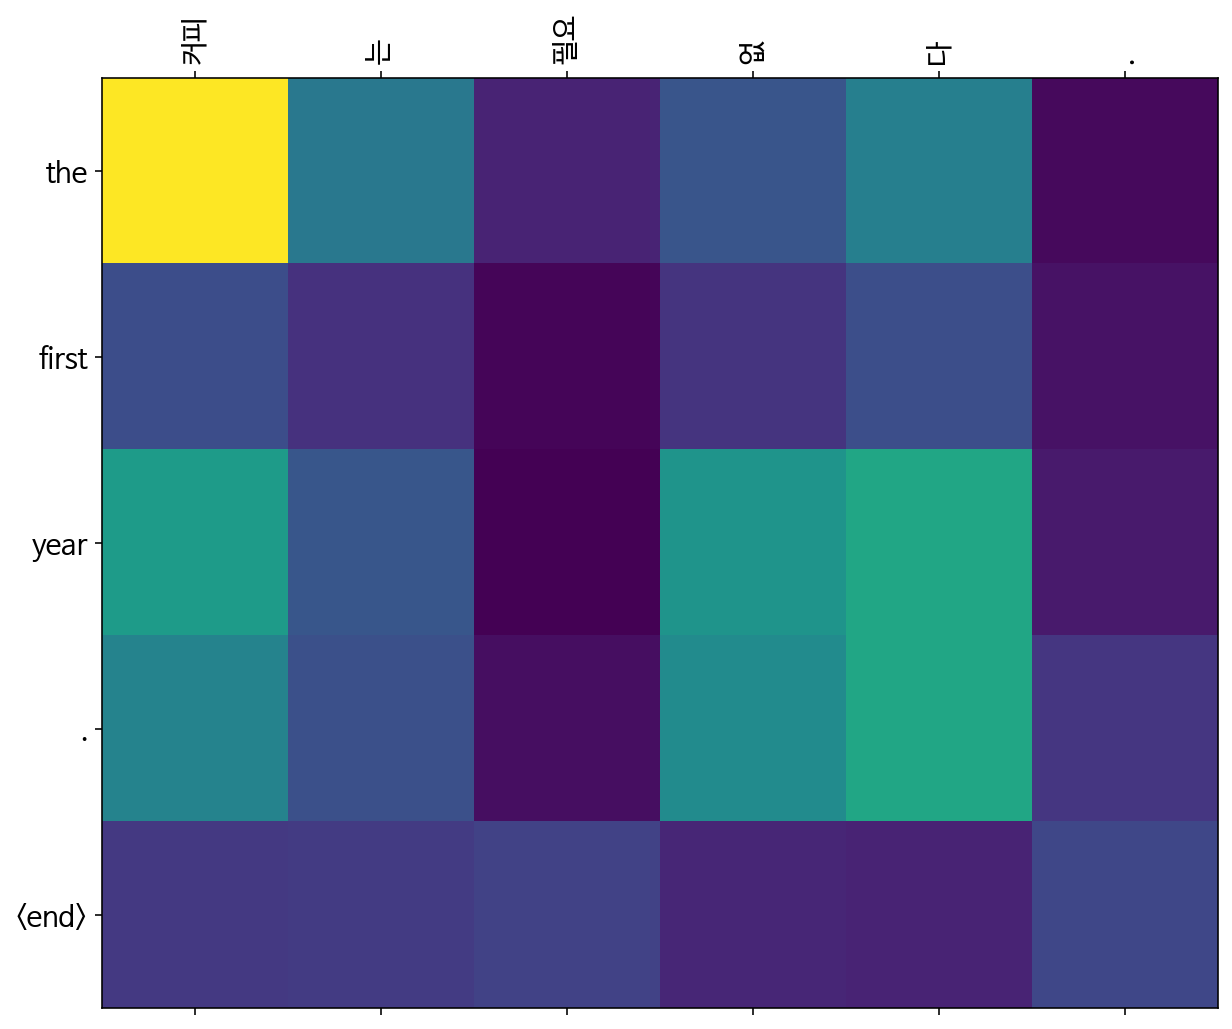

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the first year old . <end> 


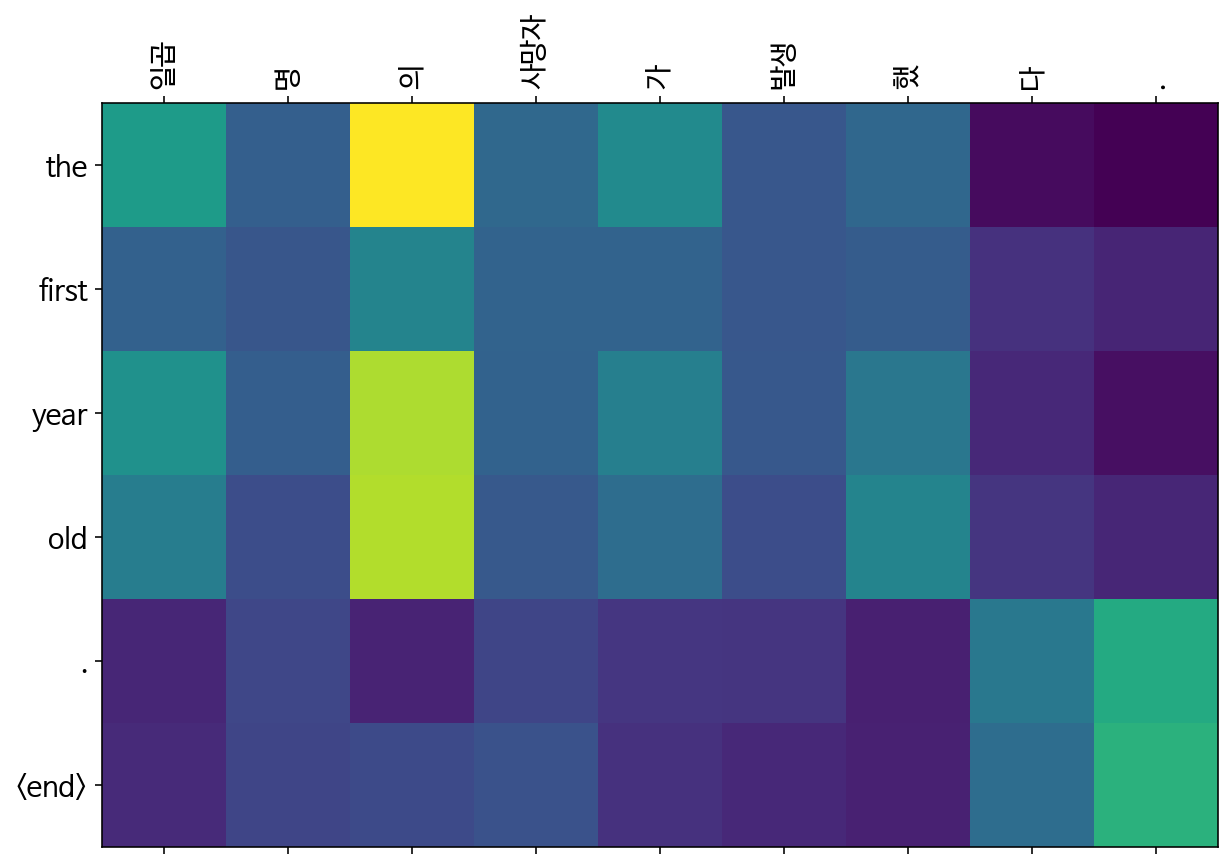

Epoch 14: 100%|██████████| 254/254 [00:57<00:00,  4.38it/s, Loss 1.0916]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the dow is the first . <end> 


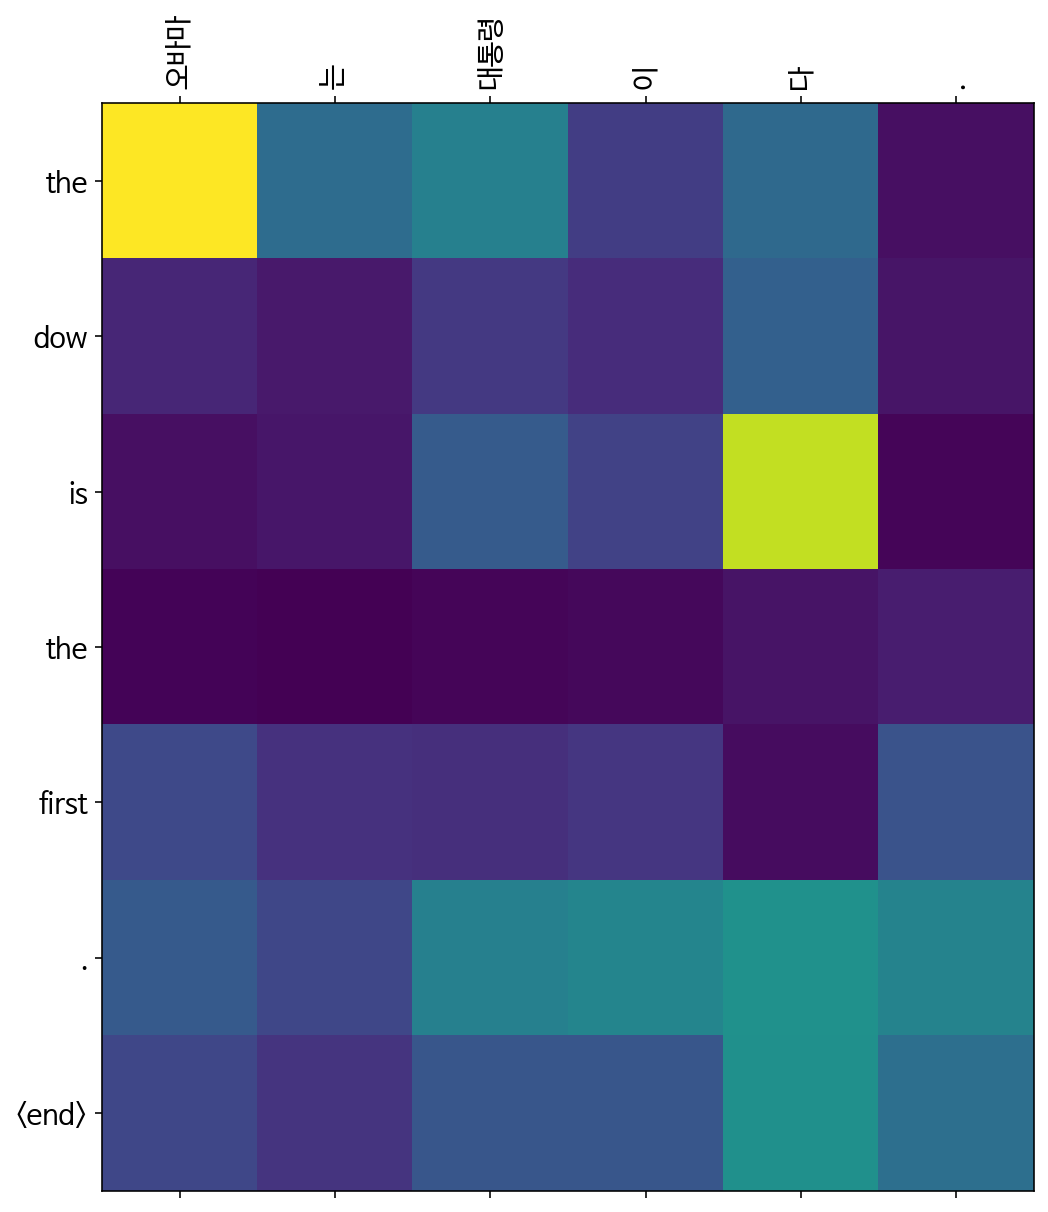

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first year . <end> 


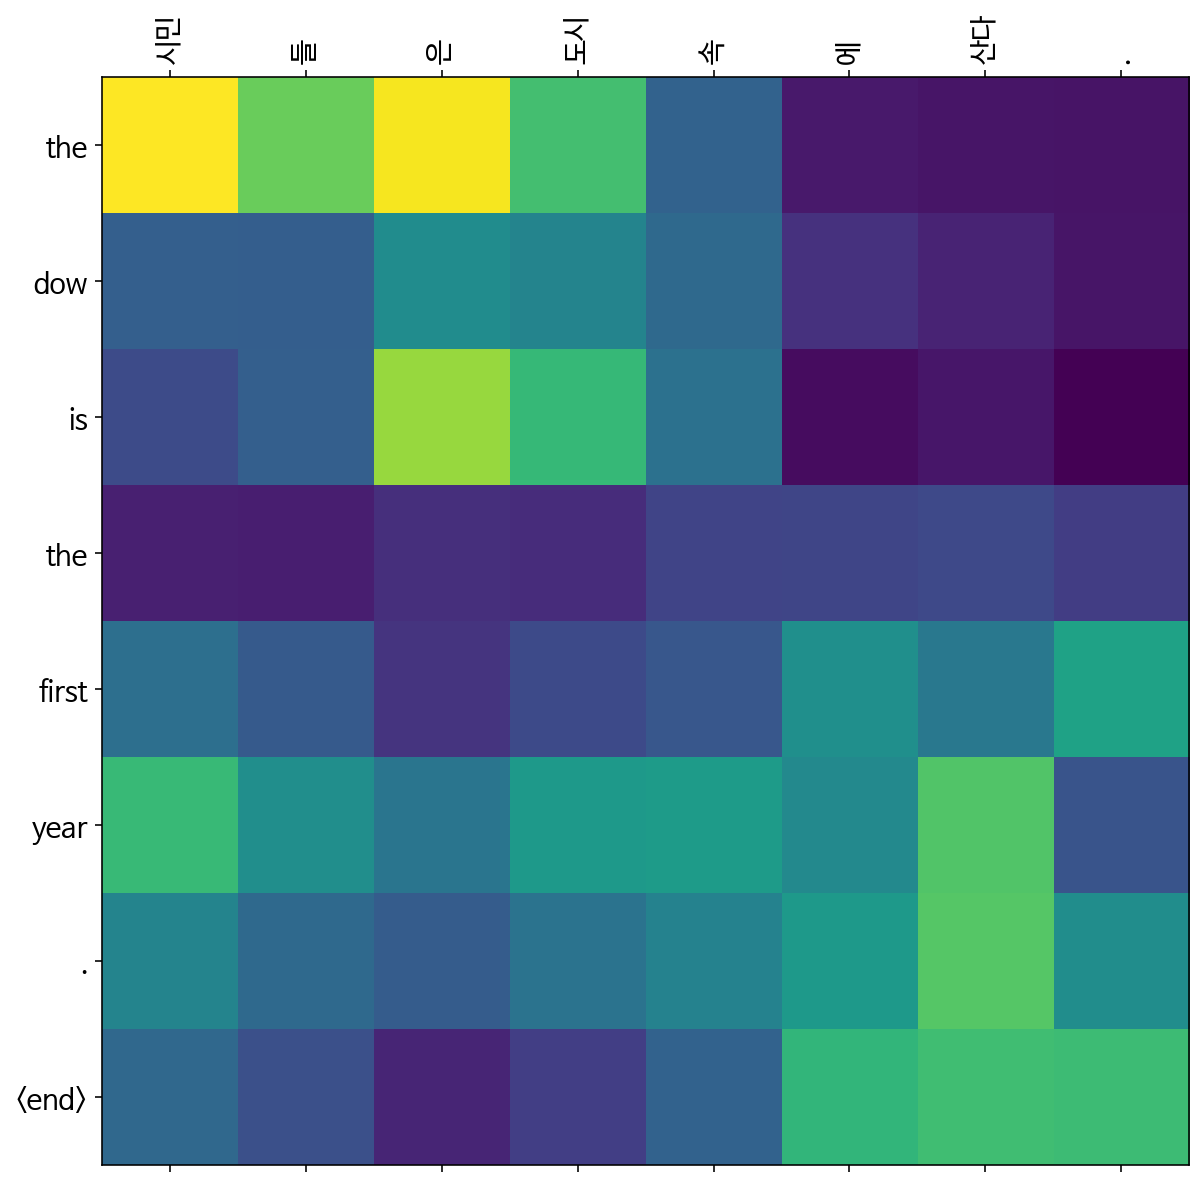

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


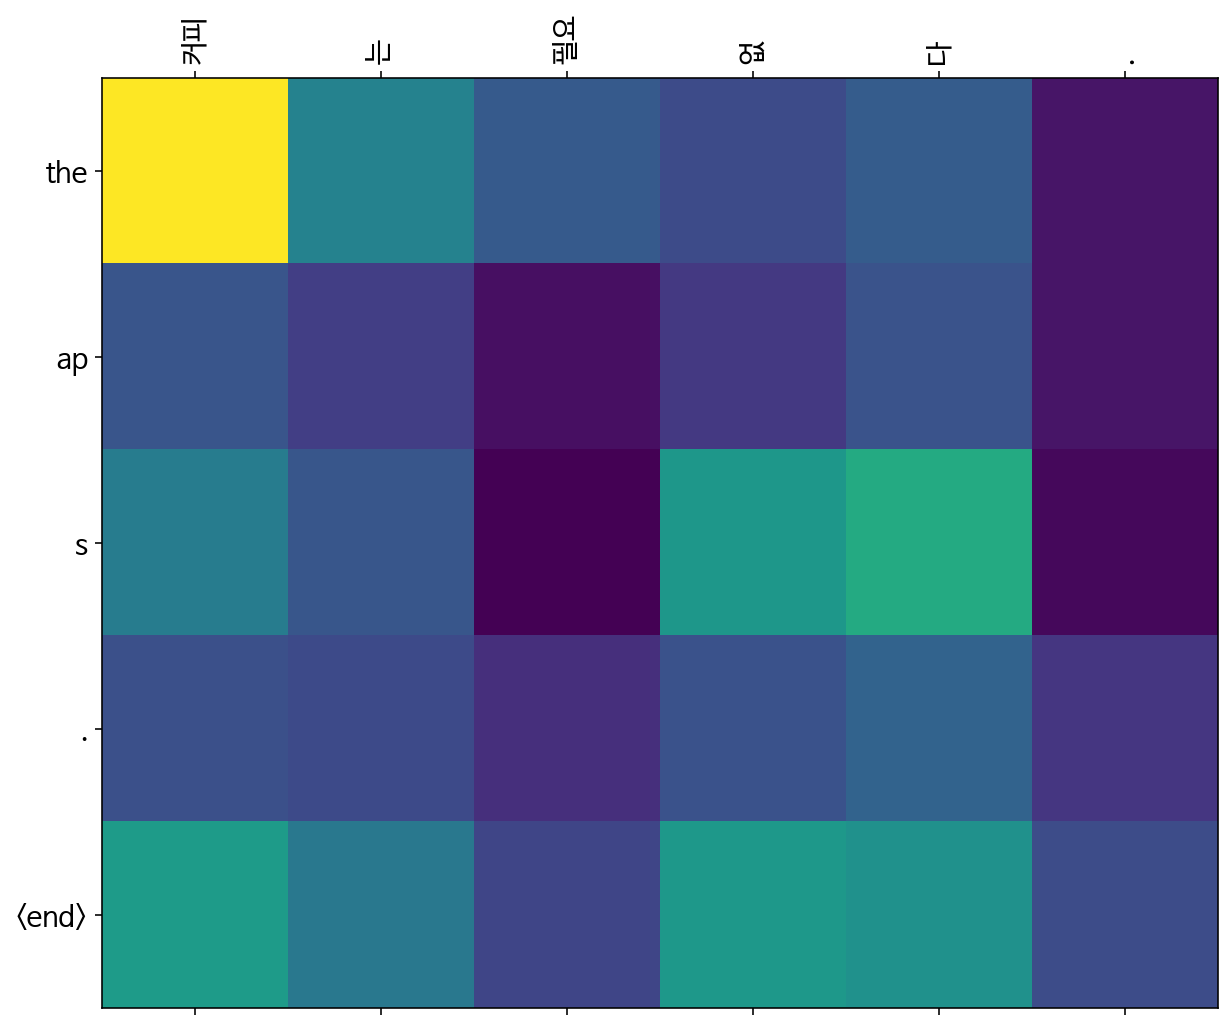

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the government was a year old . <end> 


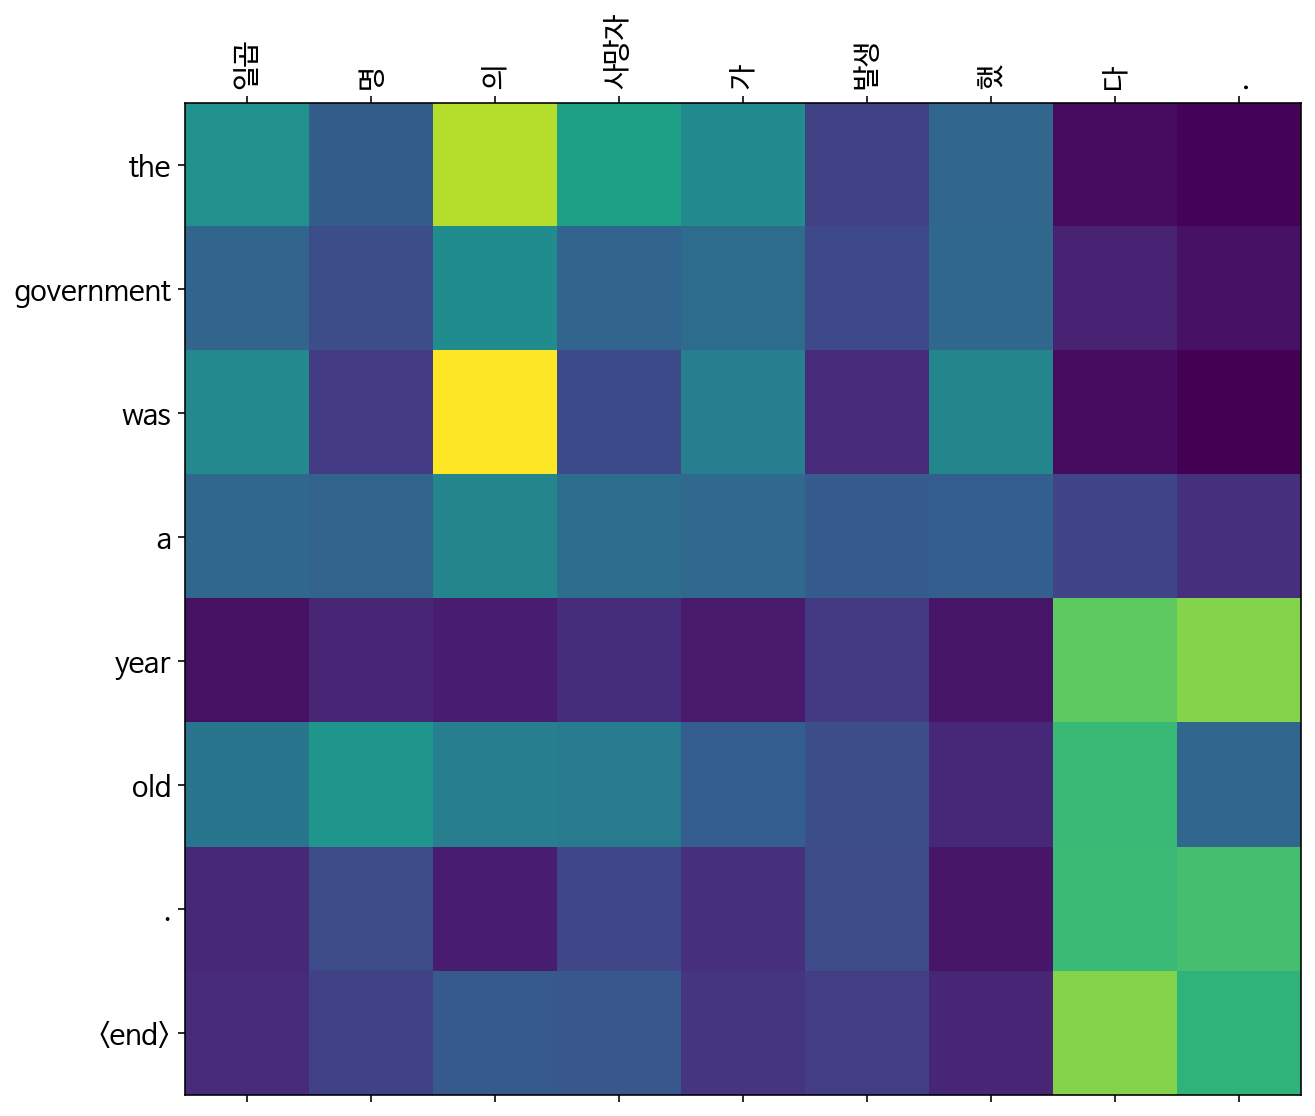

Epoch 15: 100%|██████████| 254/254 [00:57<00:00,  4.38it/s, Loss 1.0623]


Input: 오바마 는 대통령 이 다 .
Predicted translation: the ap s . <end> 


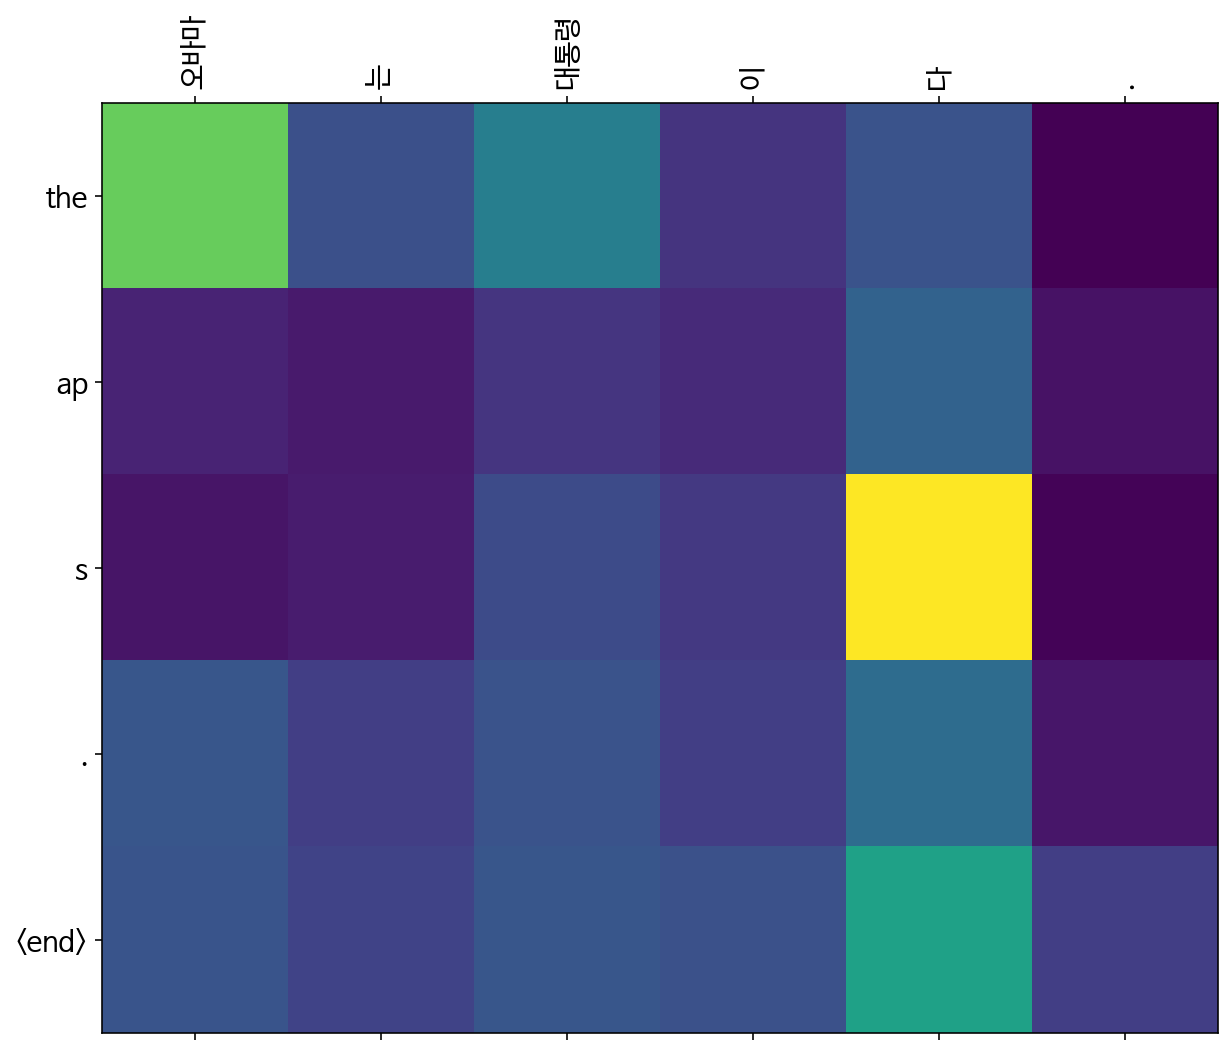

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


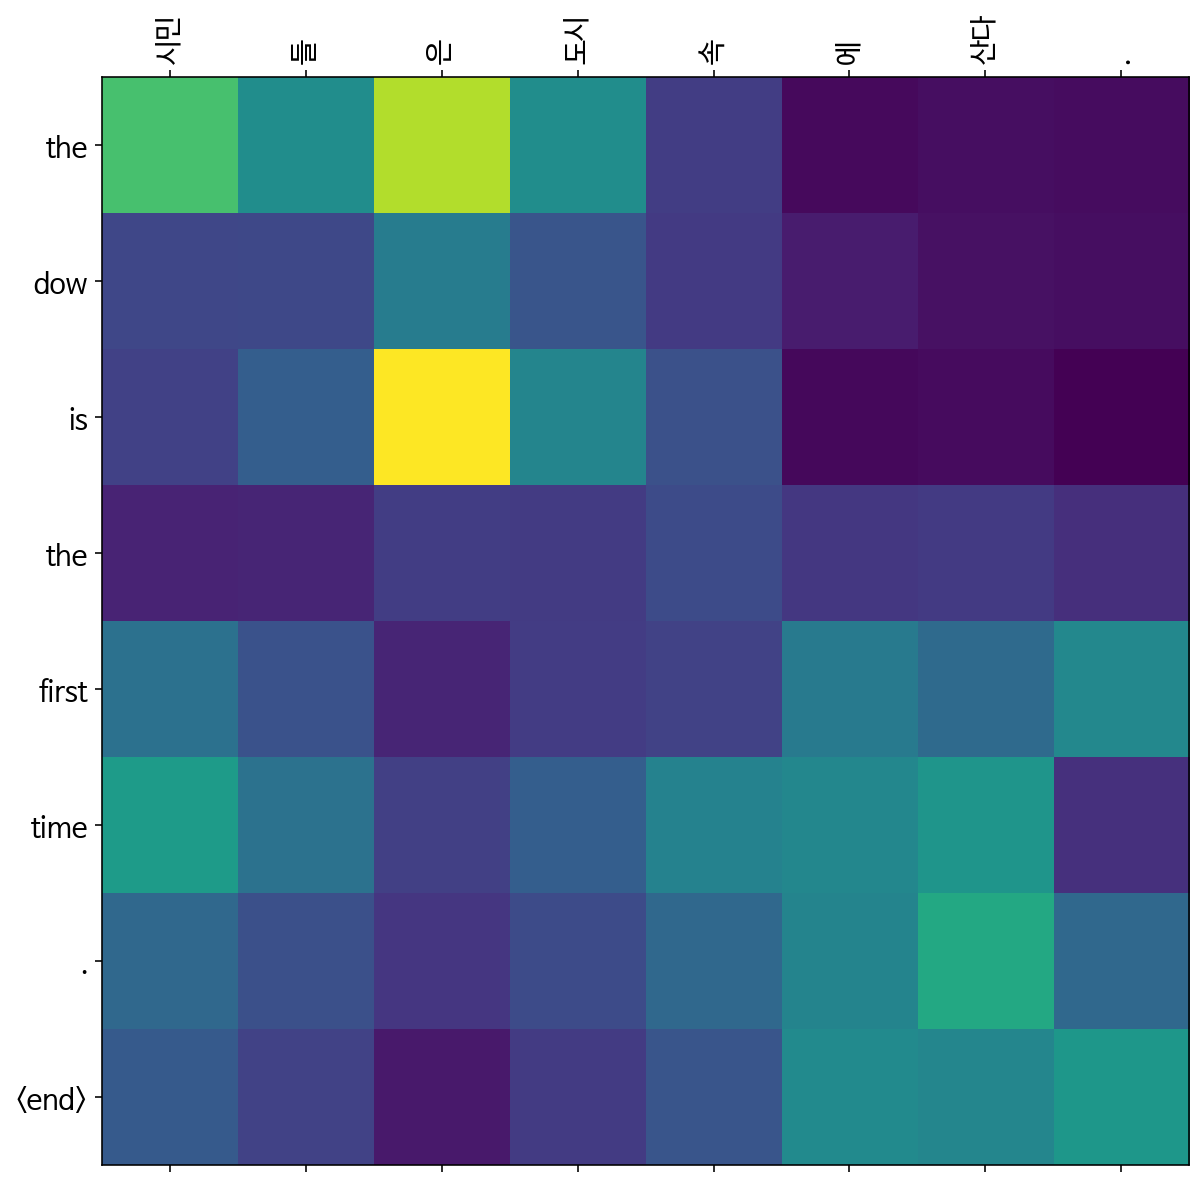

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


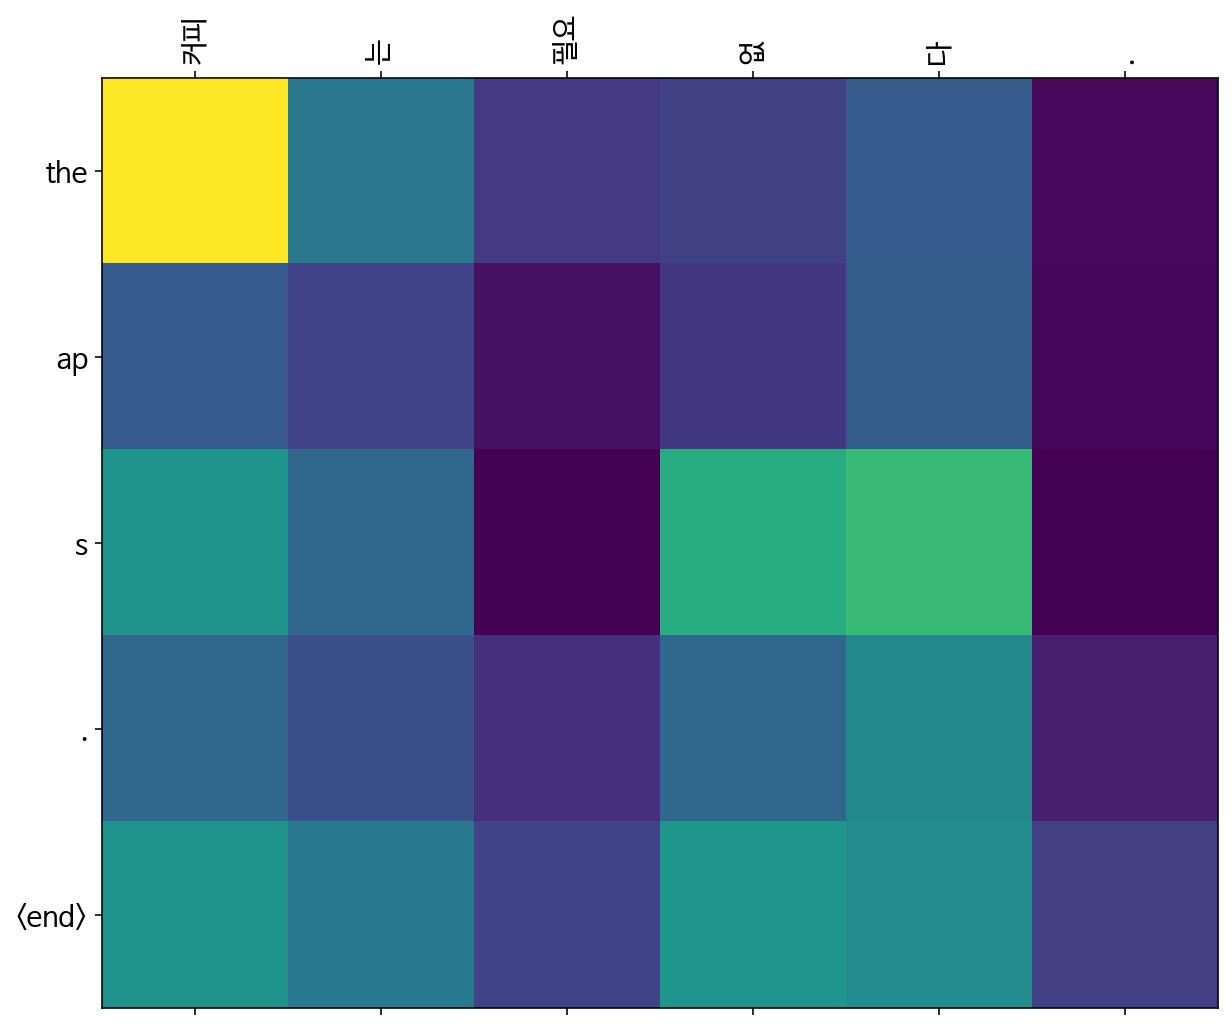

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the u . s . military , the u . s . military , the u . s . military , the u . s . military , the u . s . military , the u . s . military , the u . s . military , the u . s . military , the u . s . military , the u . s 


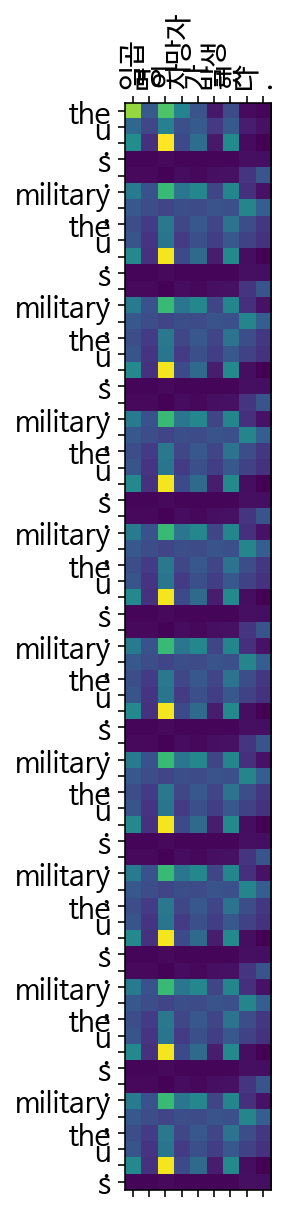

Epoch 16: 100%|██████████| 254/254 [00:57<00:00,  4.39it/s, Loss 1.0353]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama is a lot of the first time . <end> 


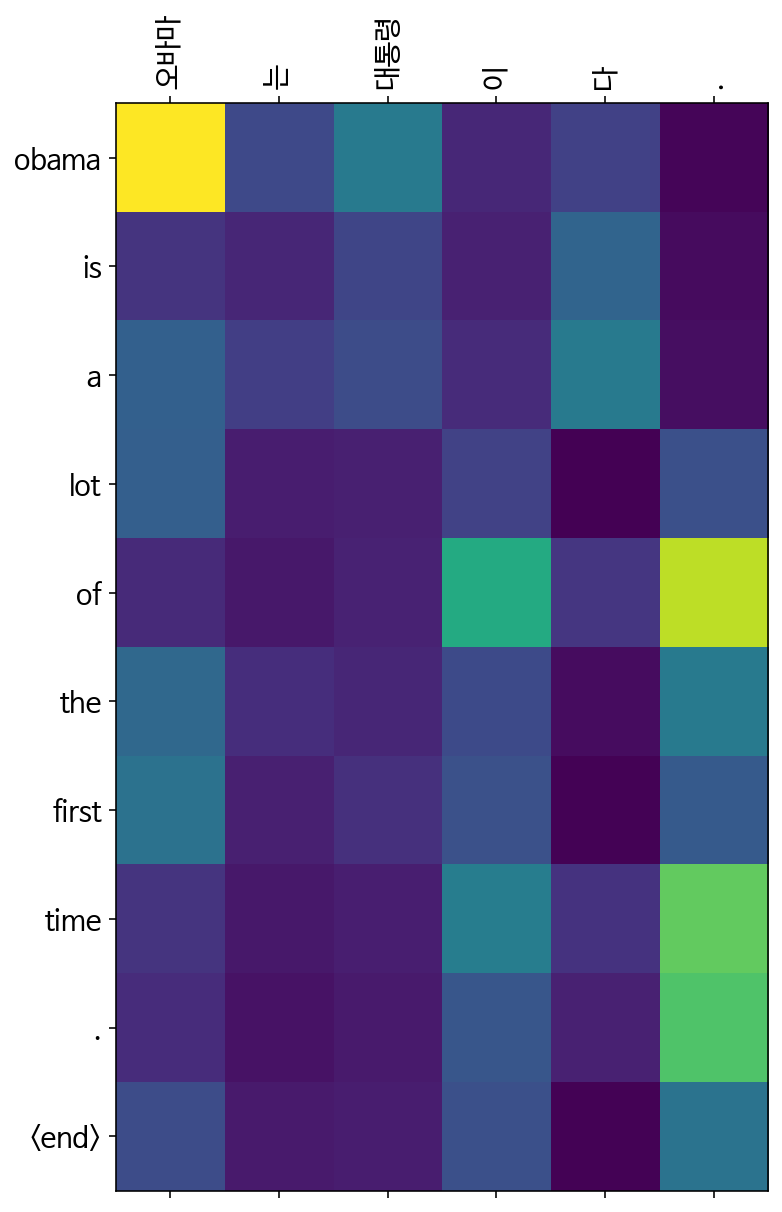

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the ap s . <end> 


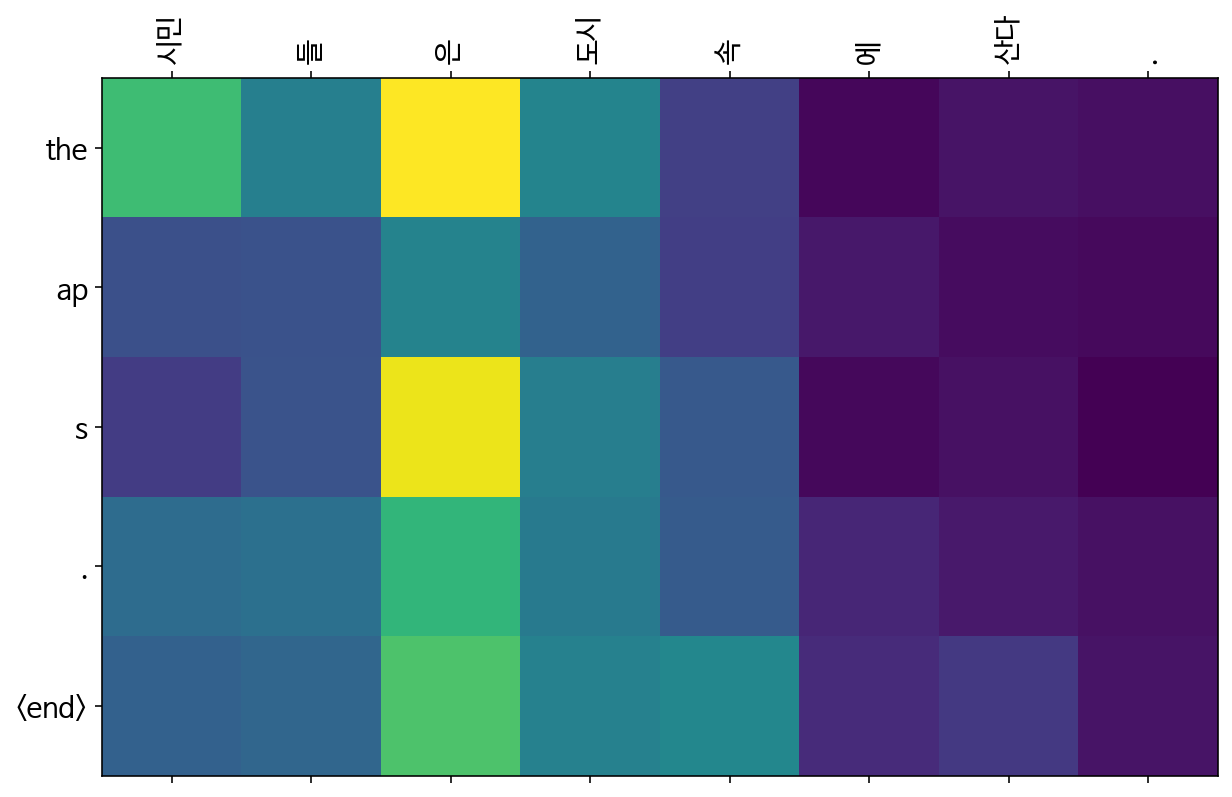

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


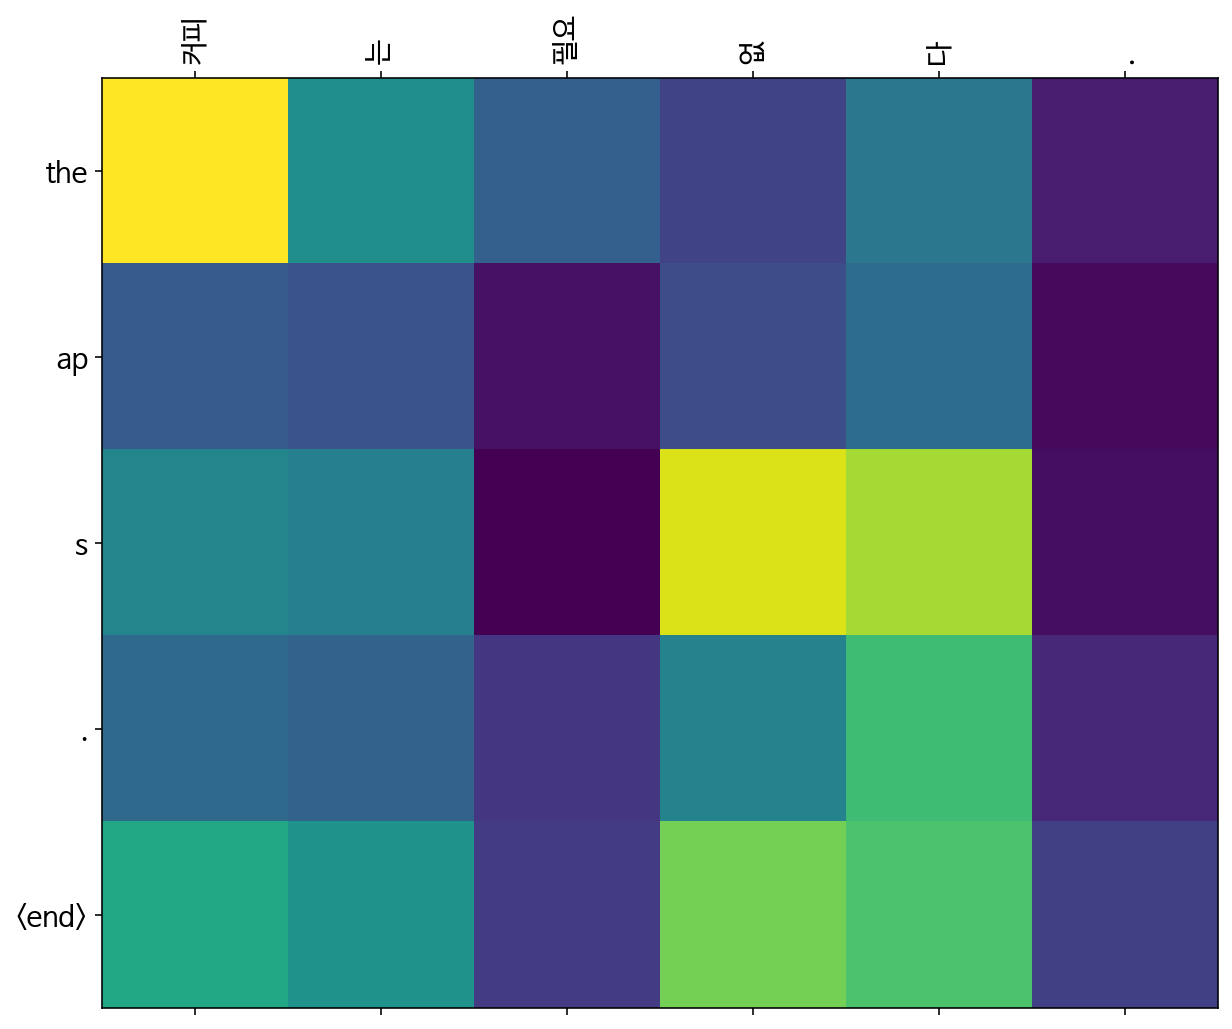

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the u . s . <end> 


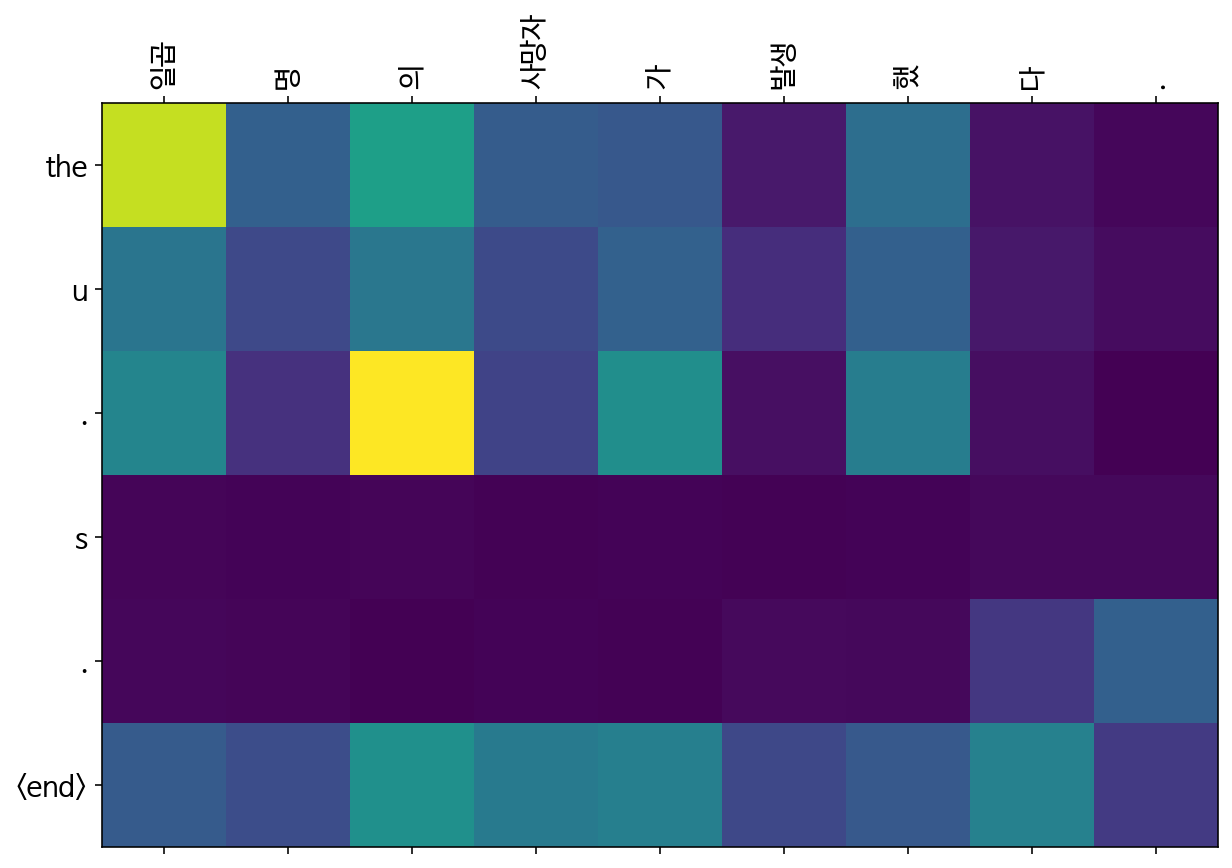

Epoch 17: 100%|██████████| 254/254 [00:57<00:00,  4.39it/s, Loss 1.0111]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s . <end> 


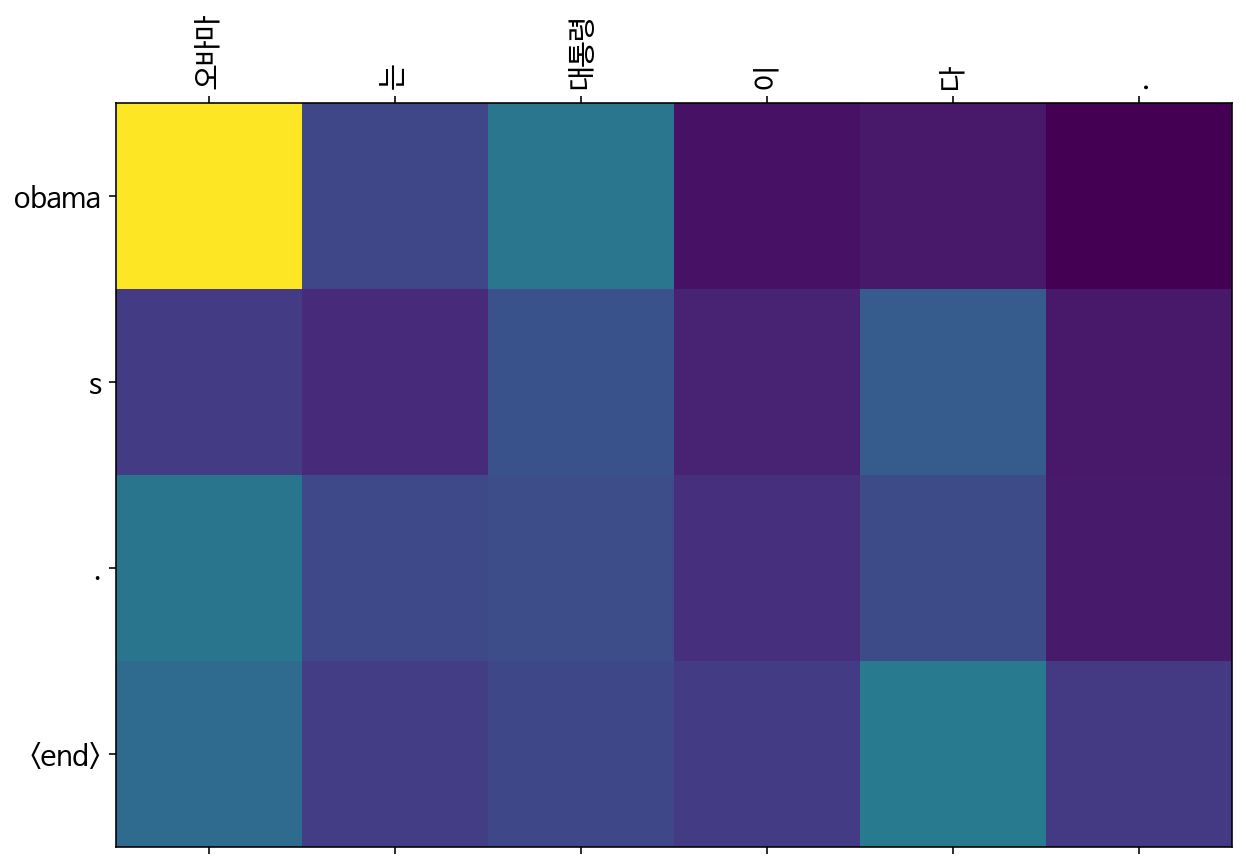

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the ap s . <end> 


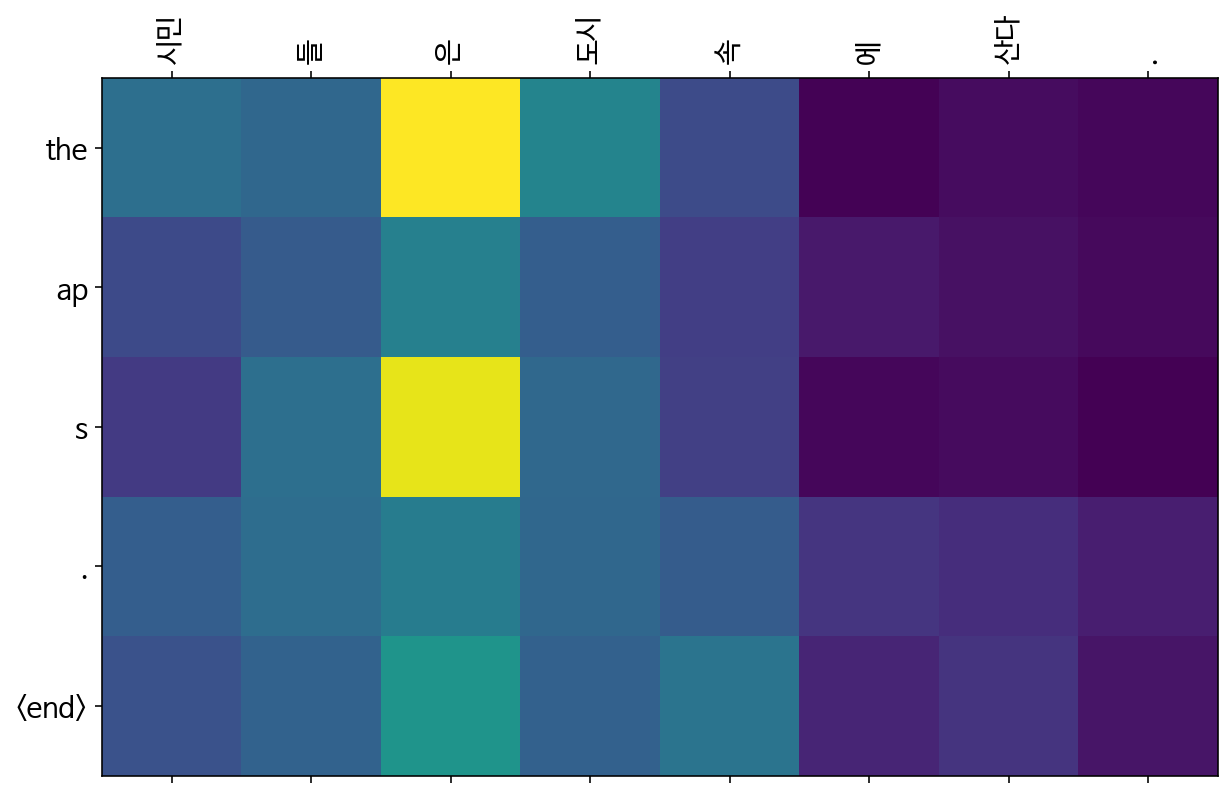

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


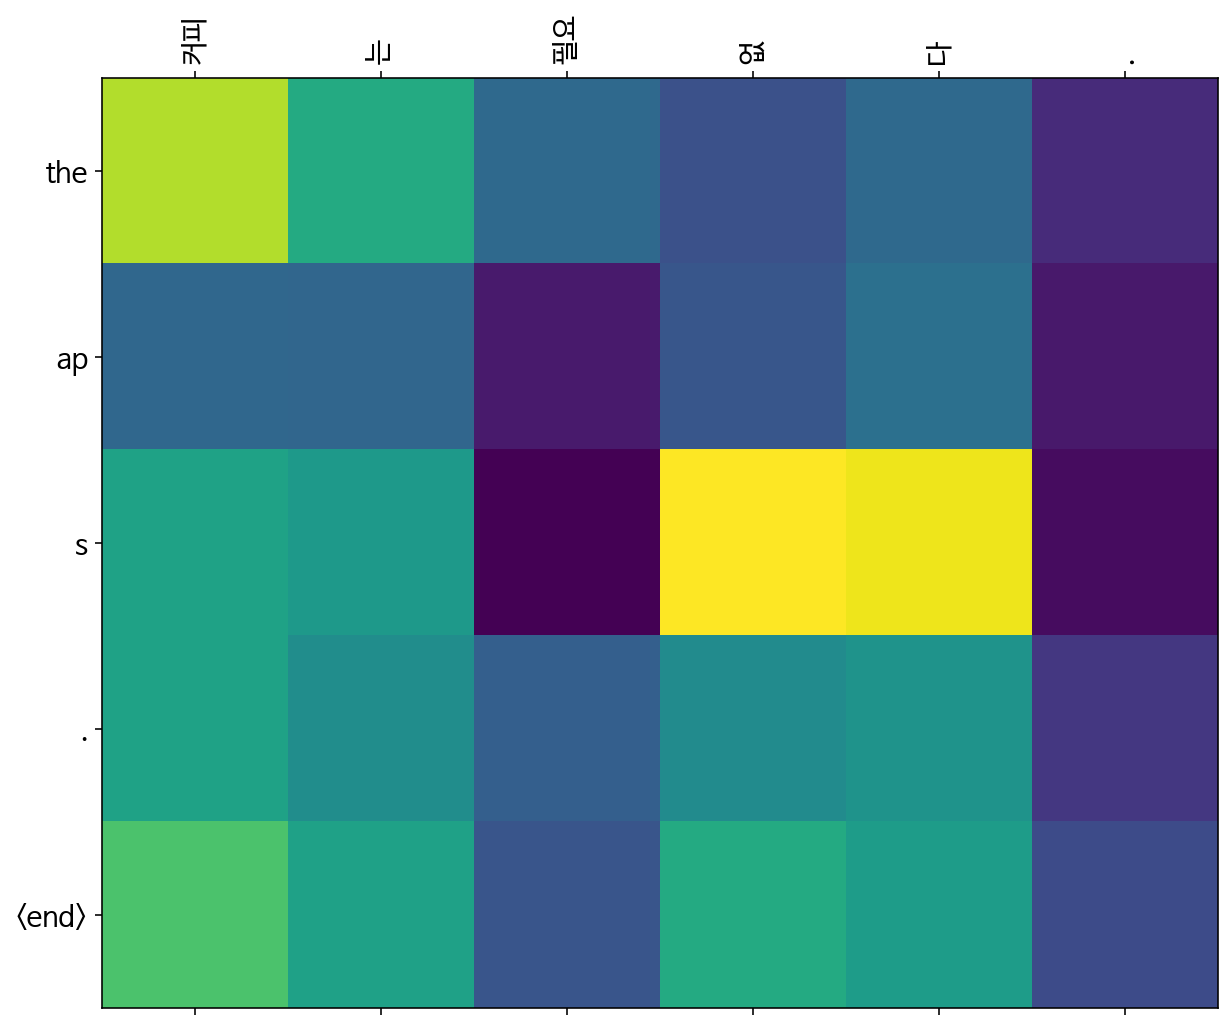

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the u . s . m . <end> 


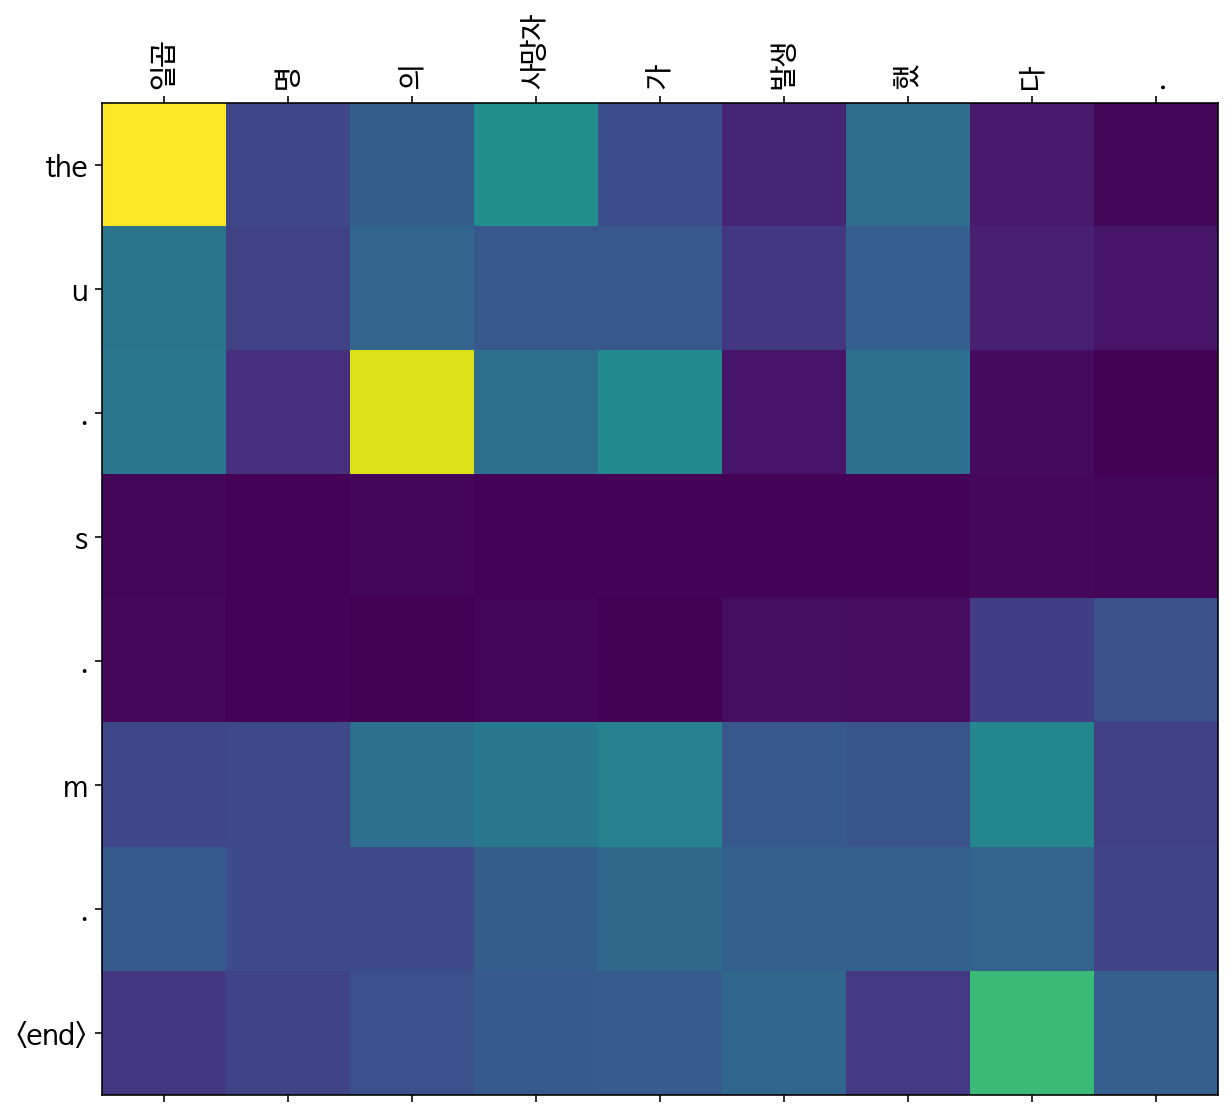

Epoch 18: 100%|██████████| 254/254 [00:57<00:00,  4.40it/s, Loss 0.9878]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s . <end> 


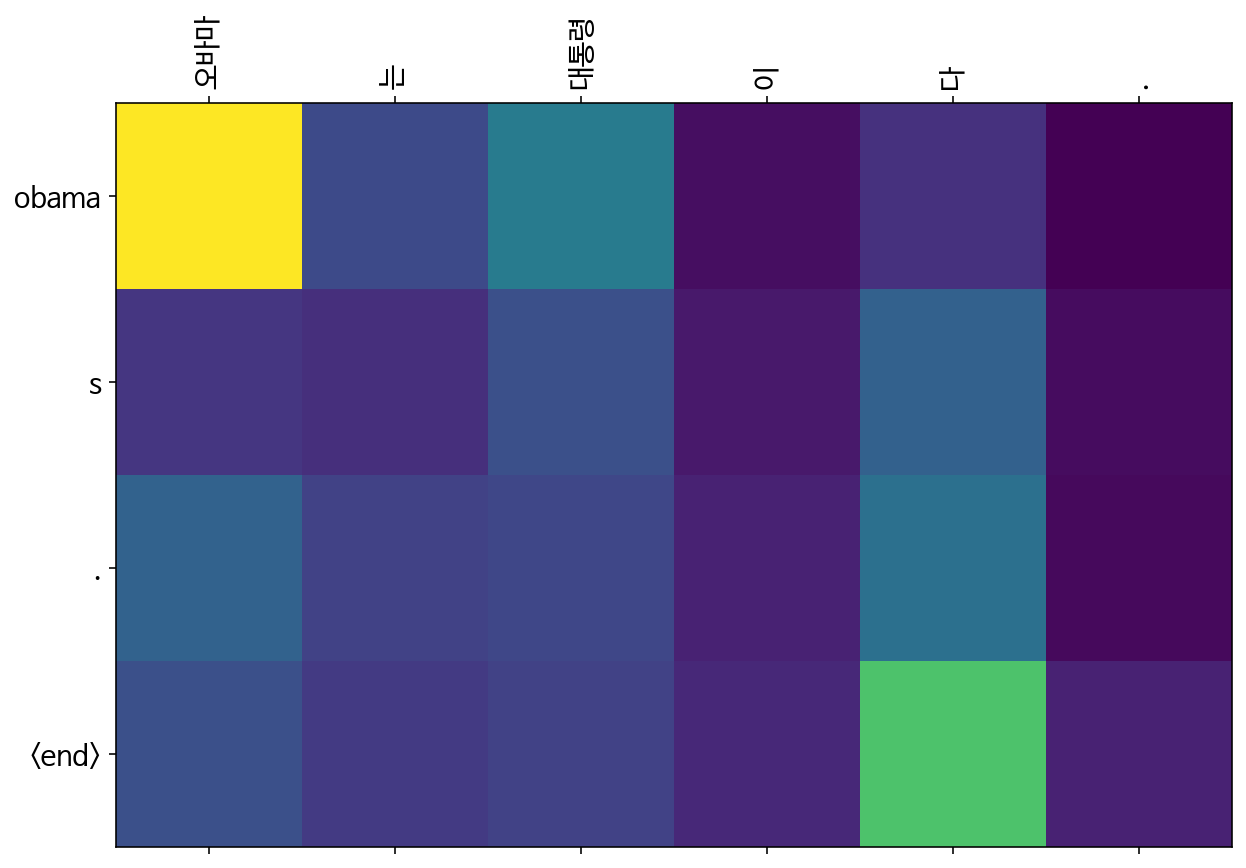

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


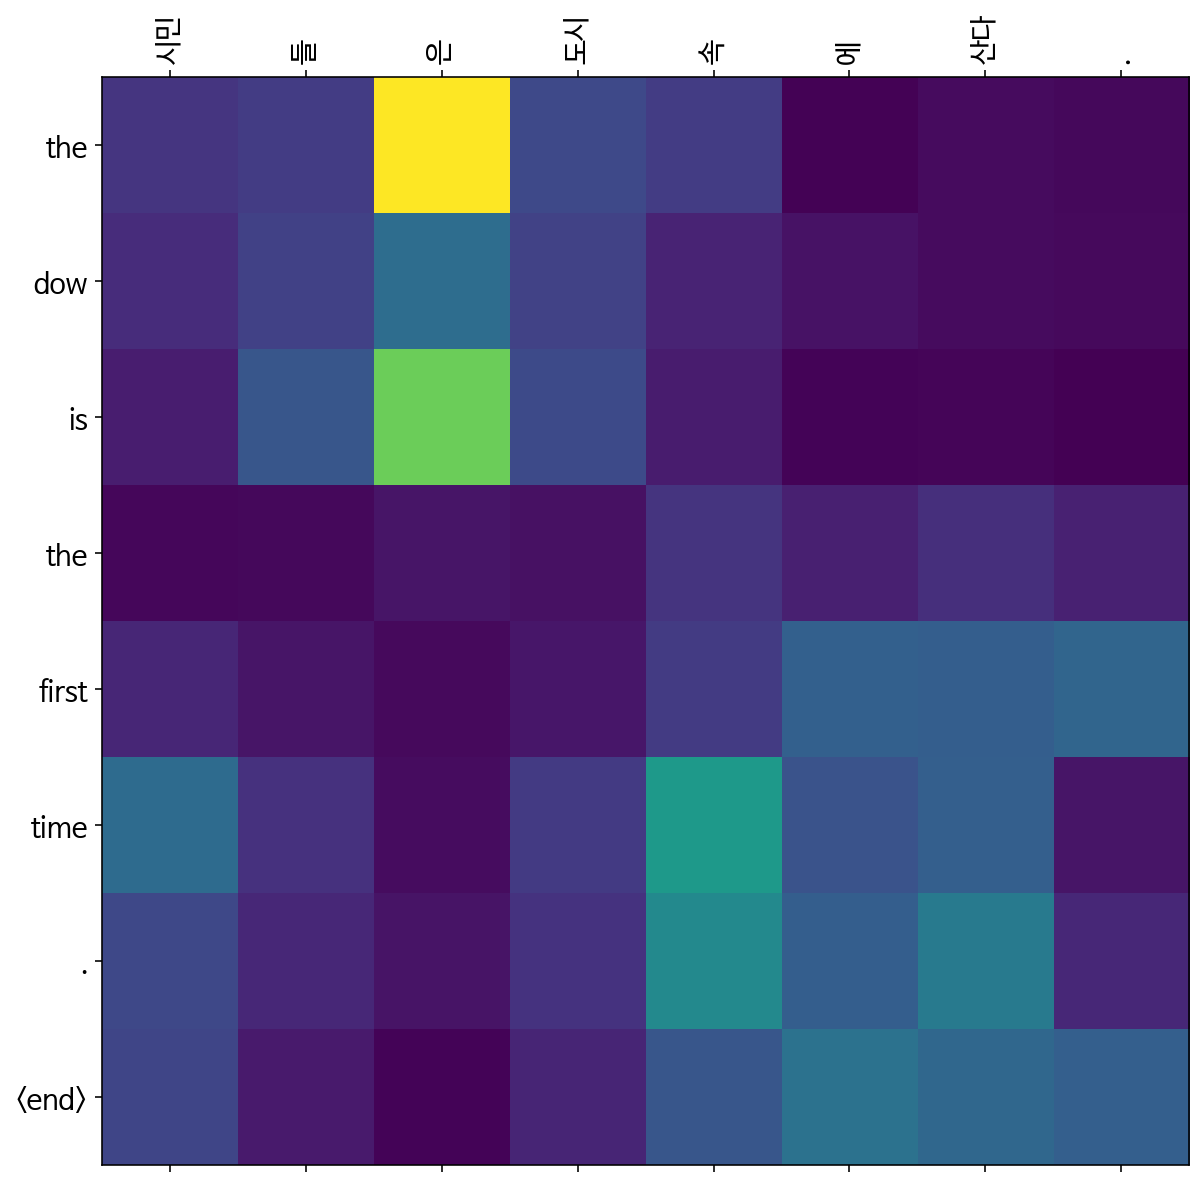

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


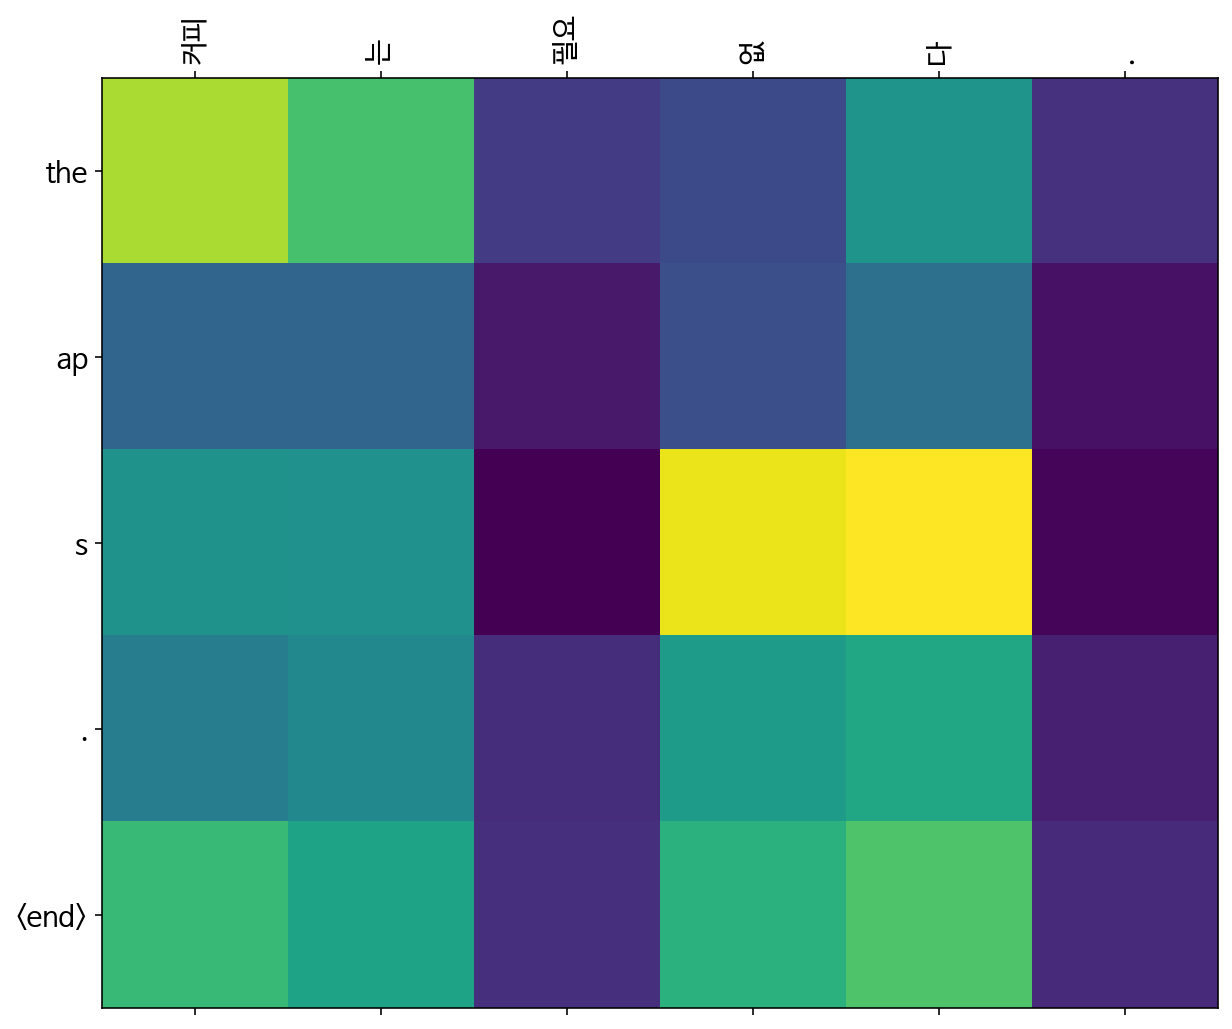

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the u . s . m . <end> 


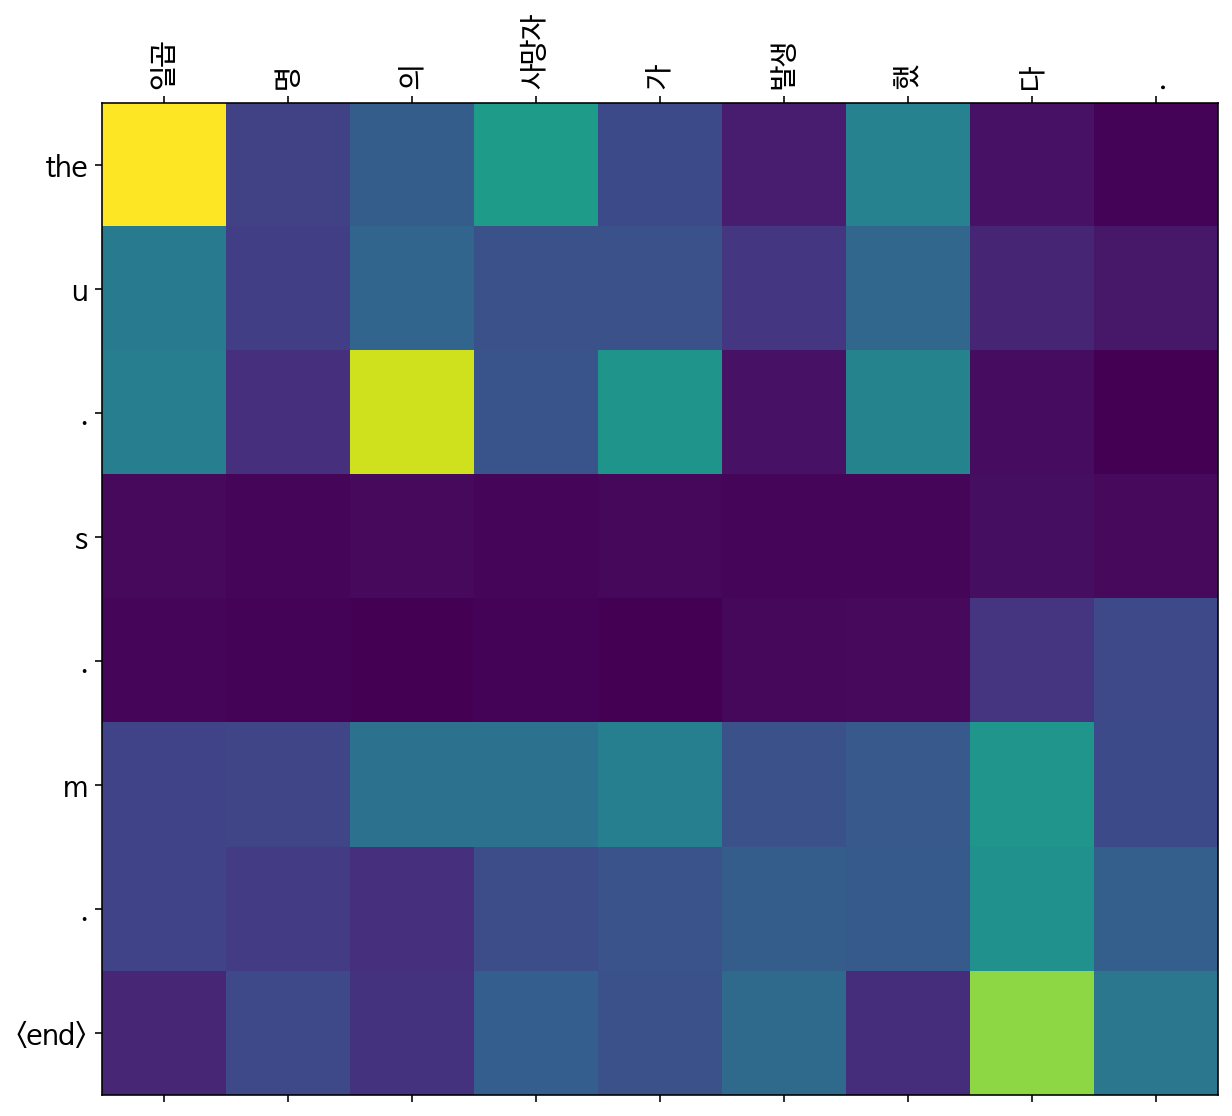

Epoch 19: 100%|██████████| 254/254 [00:57<00:00,  4.40it/s, Loss 0.9657]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s . <end> 


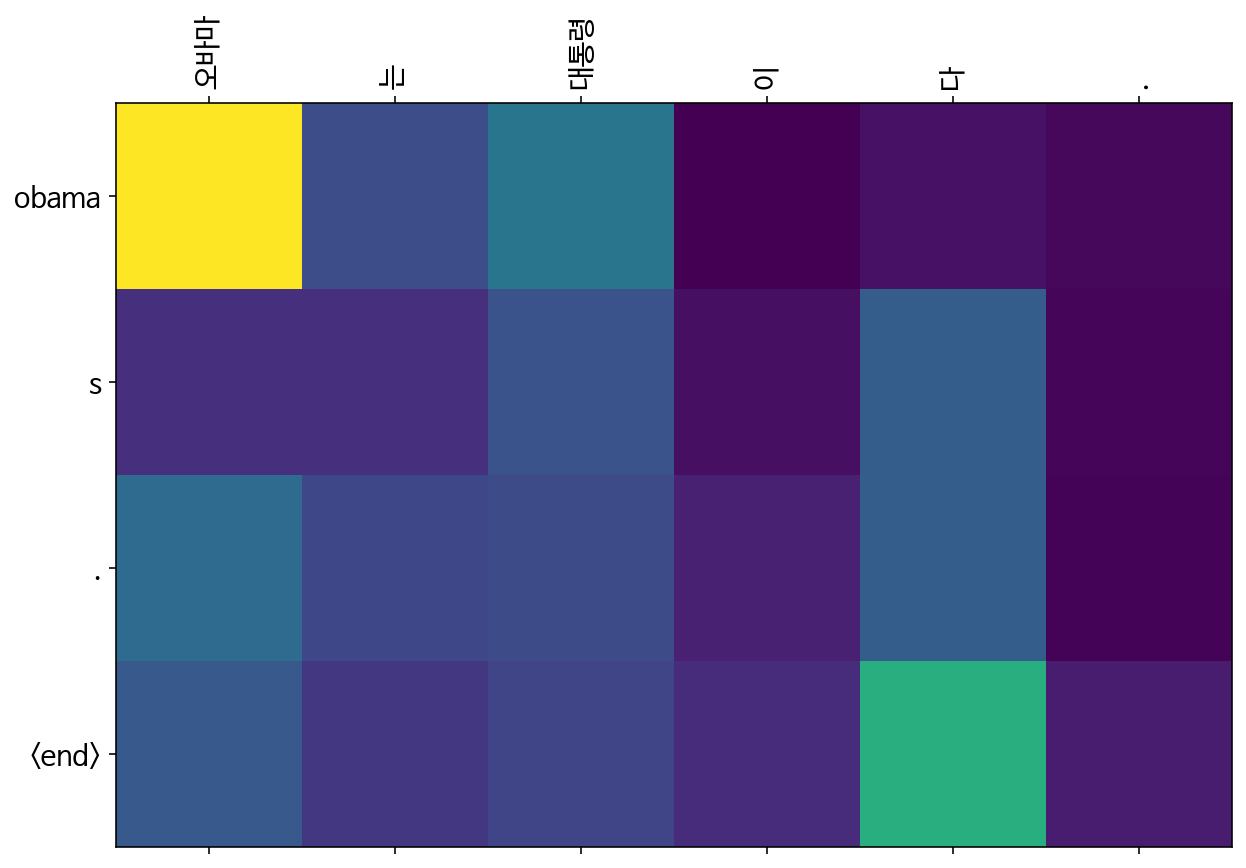

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the ap s . <end> 


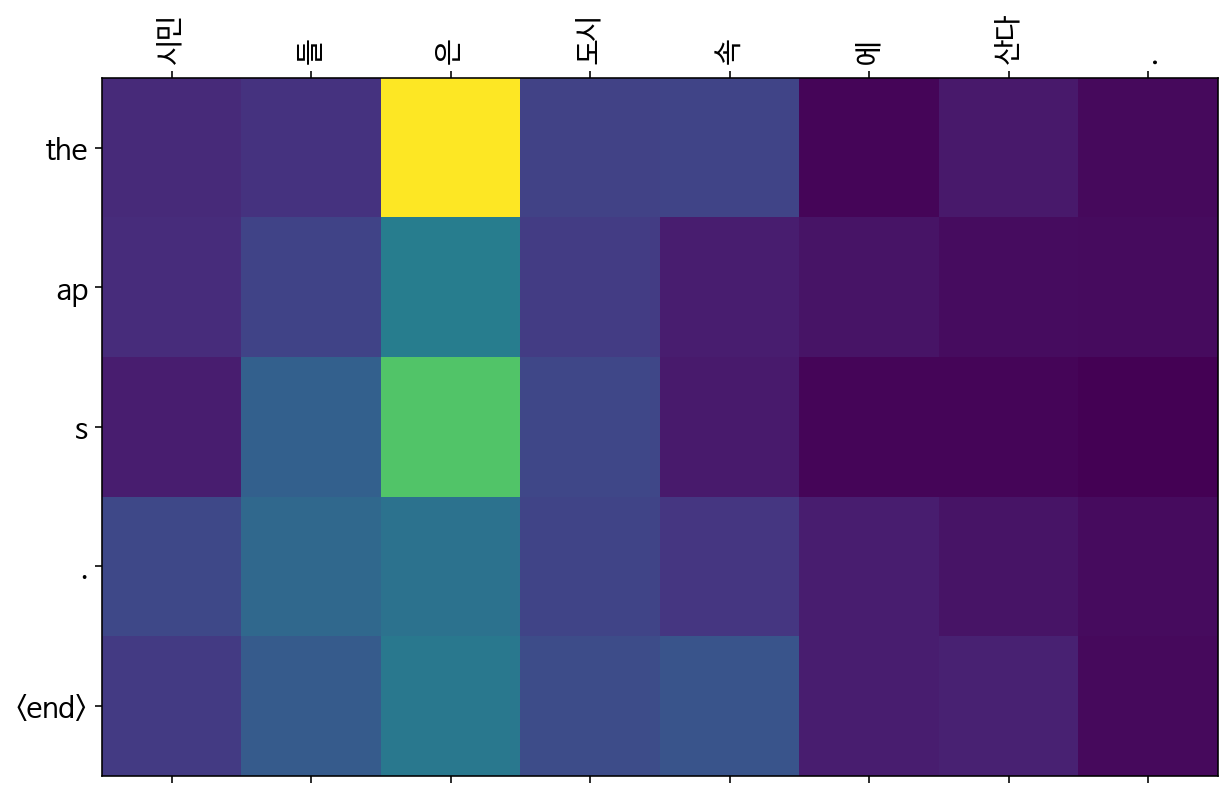

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


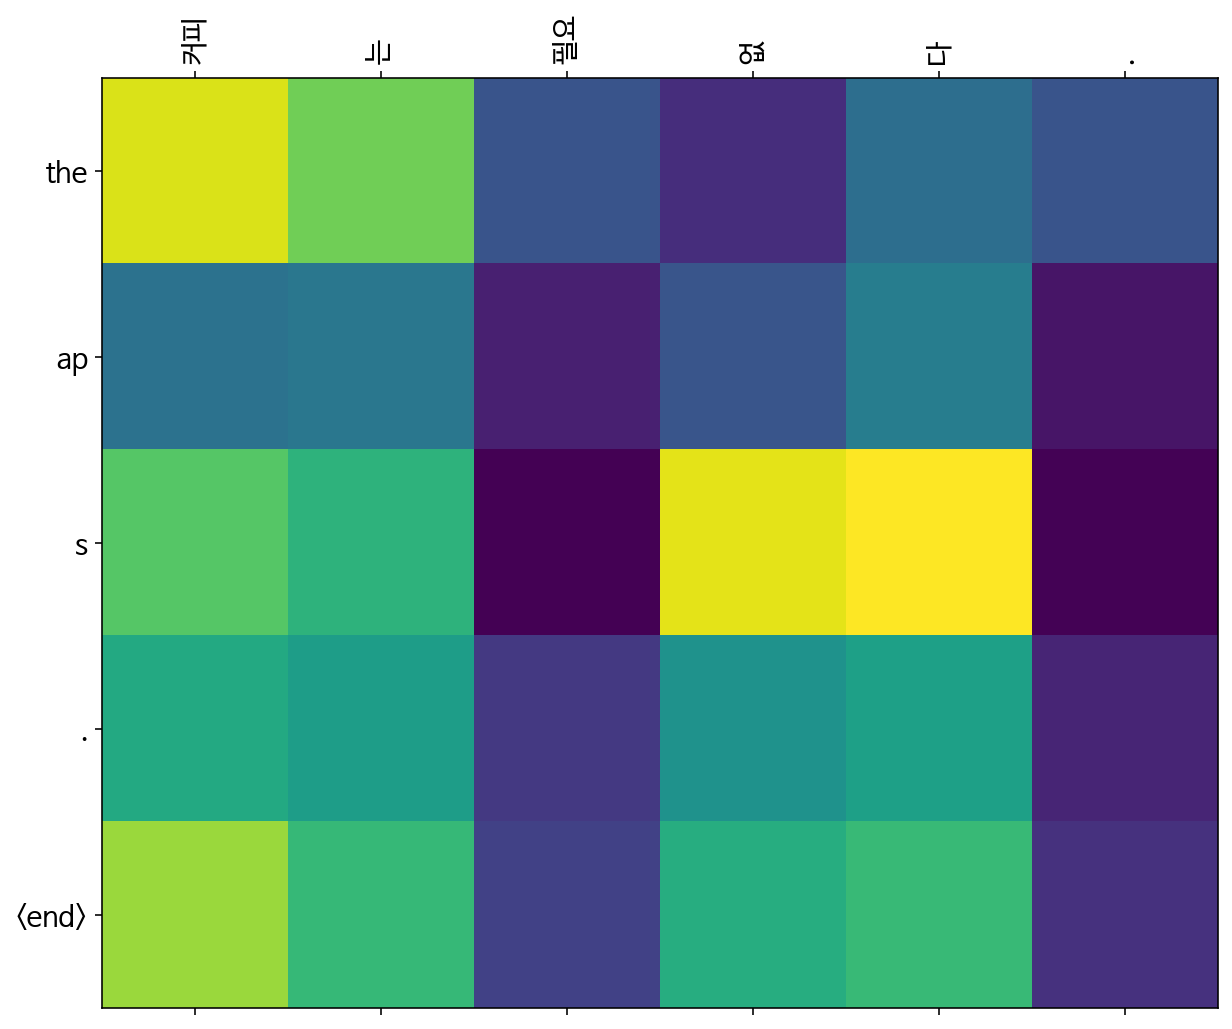

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two koreas were killed . <end> 


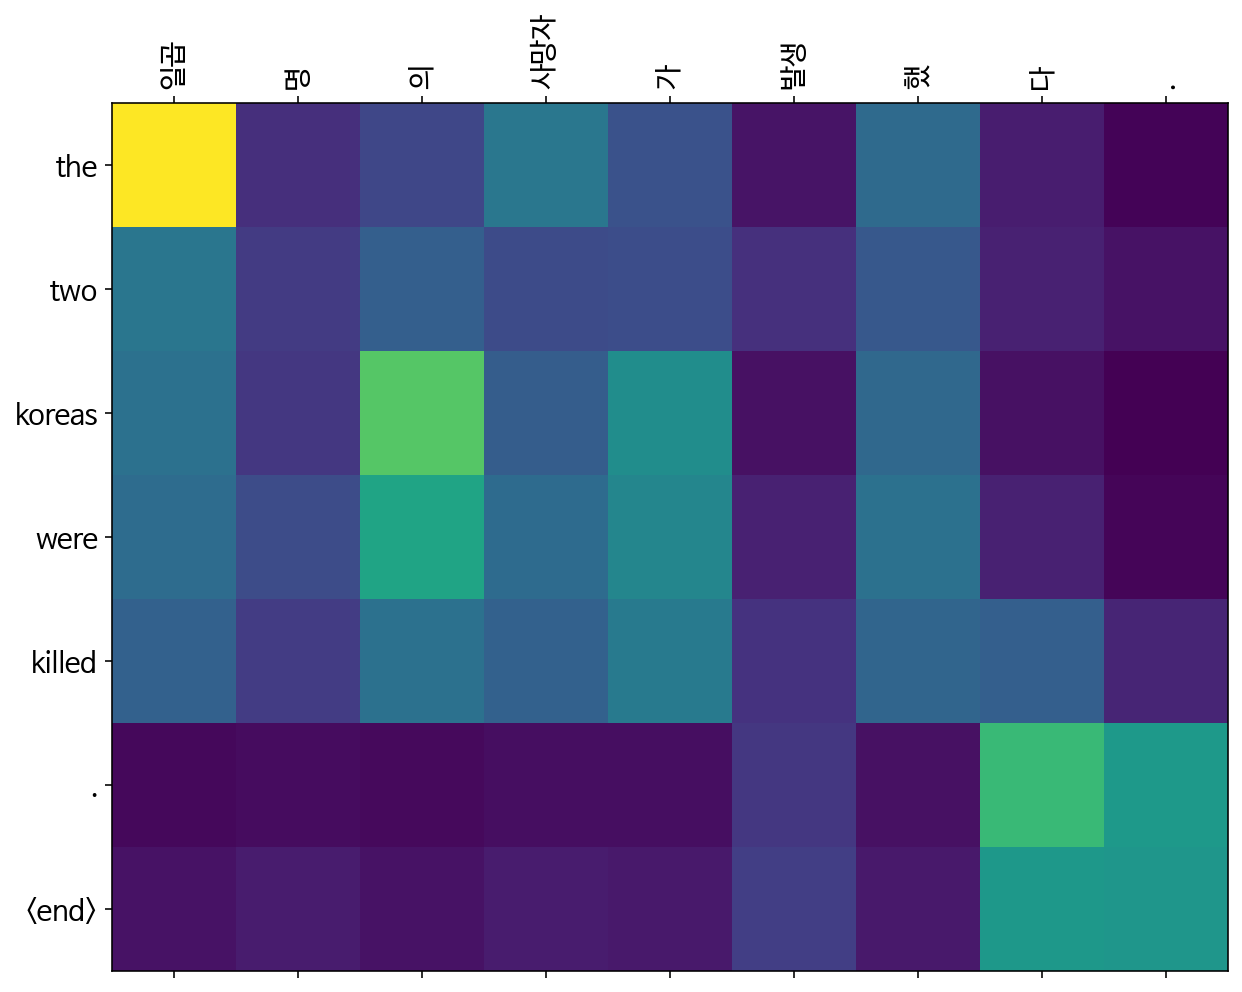

Epoch 20: 100%|██████████| 254/254 [00:57<00:00,  4.42it/s, Loss 0.9457]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a lot of the world . <end> 


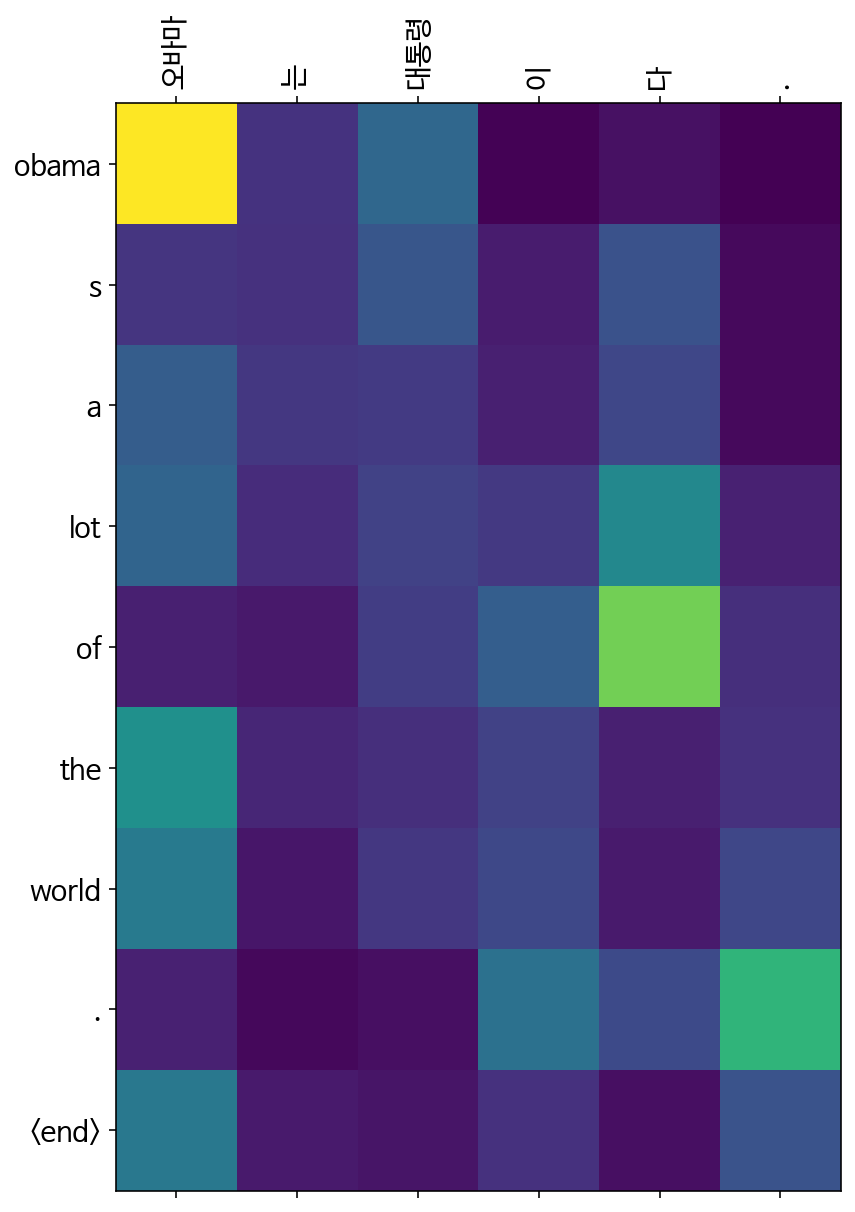

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the ap s . <end> 


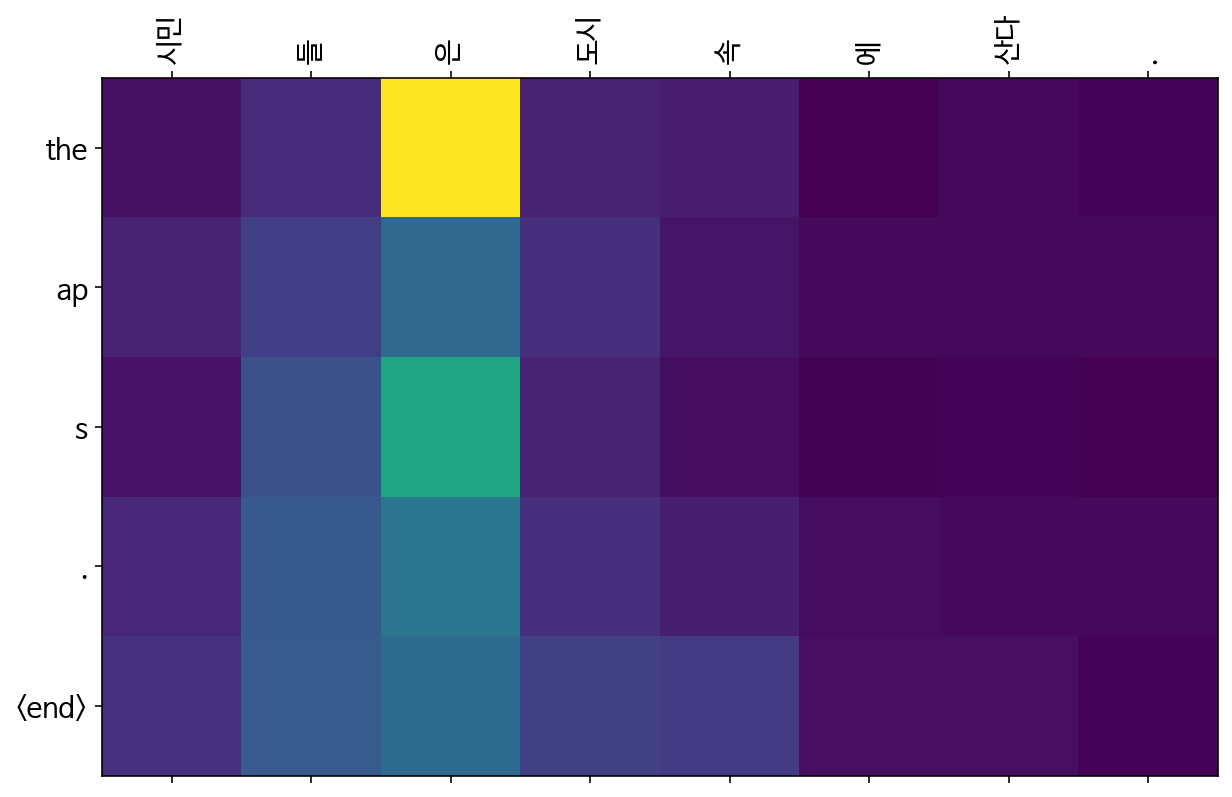

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s . <end> 


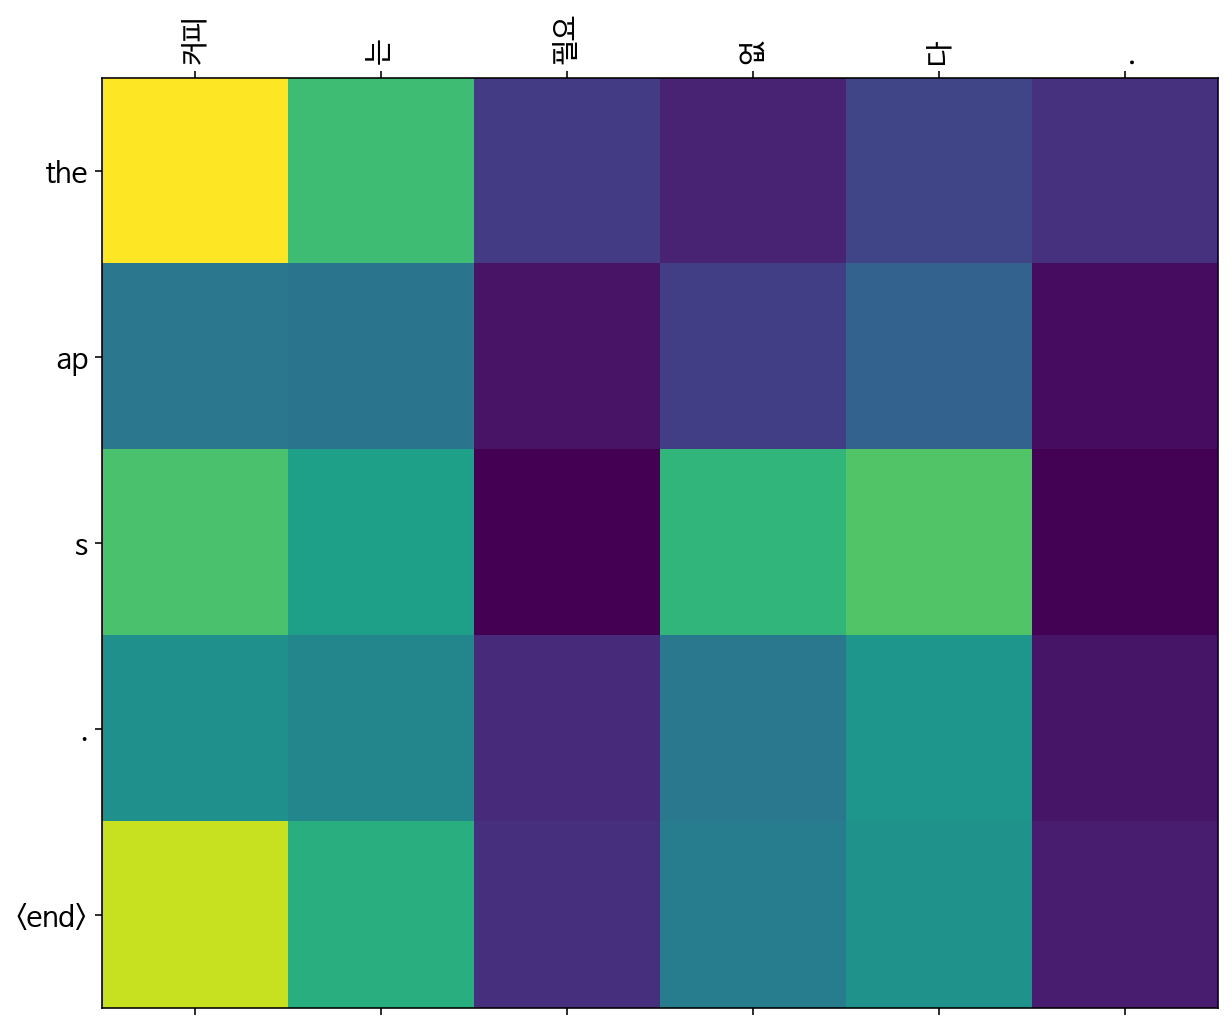

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the united states . <end> 


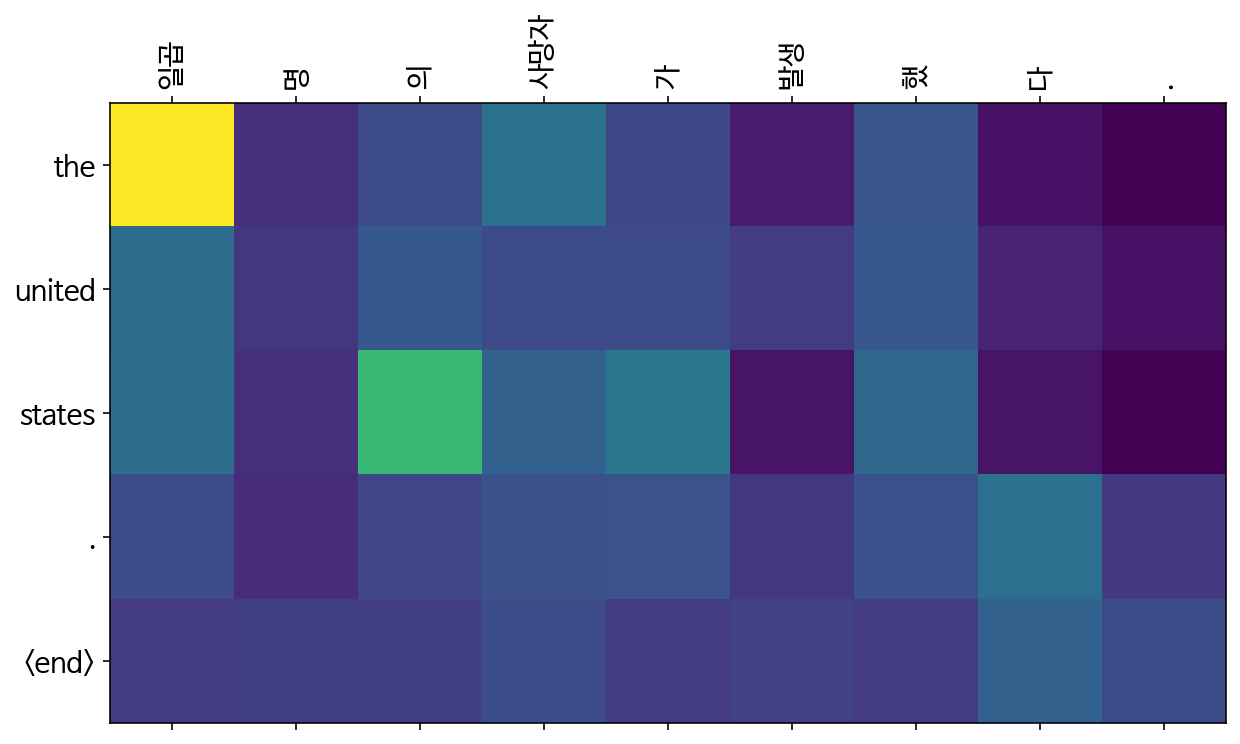

Epoch 21: 100%|██████████| 254/254 [00:57<00:00,  4.42it/s, Loss 0.9258]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says it s . <end> 


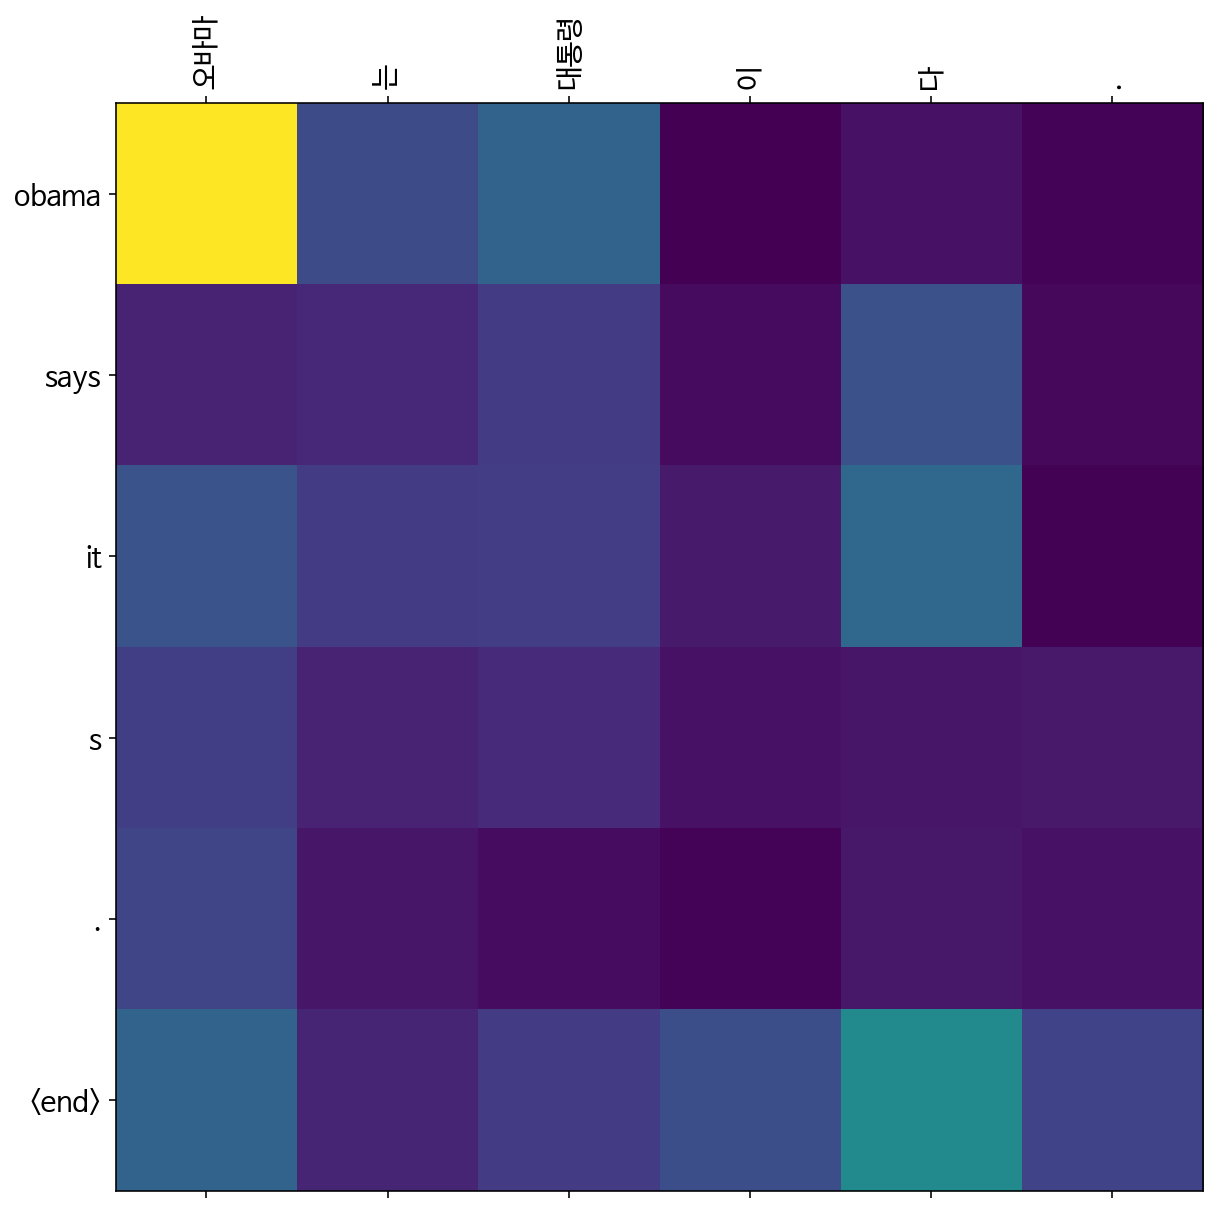

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the ap s . <end> 


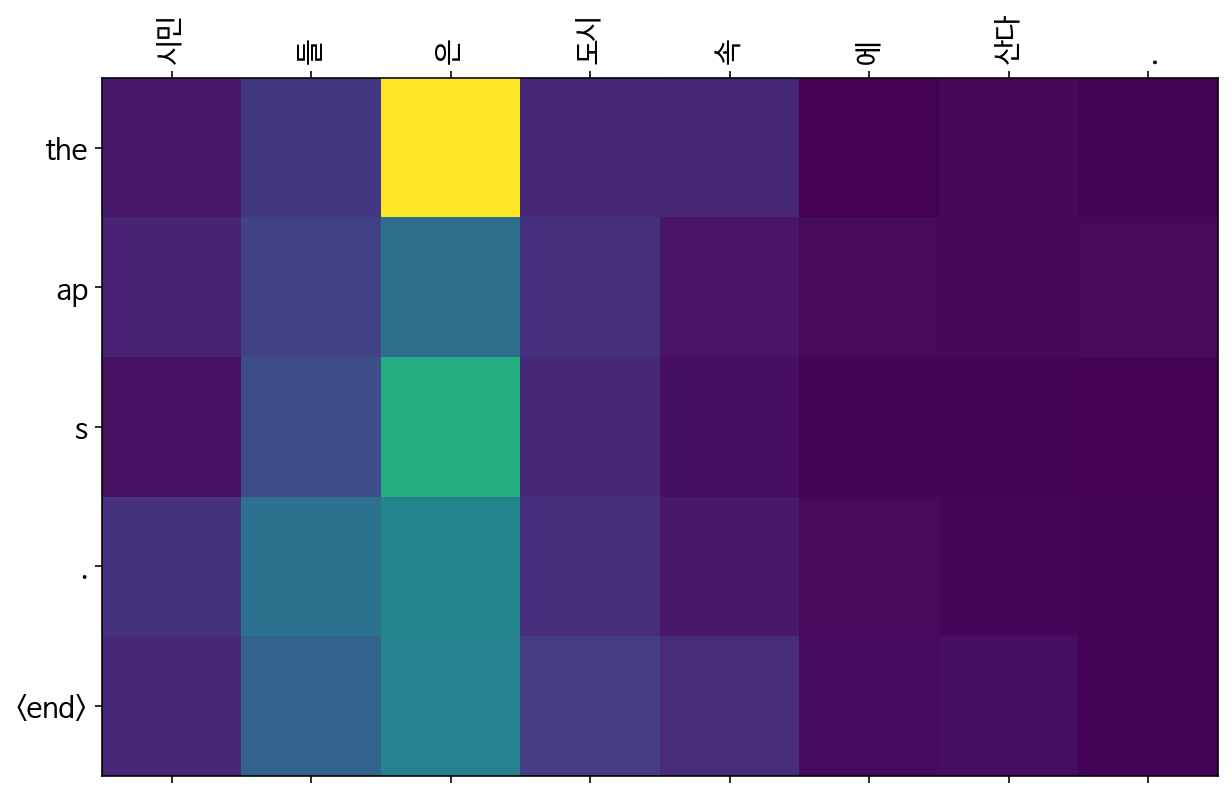

Input: 커피 는 필요 없 다 .
Predicted translation: the ap s name is a lot of the first time that s a lot of the new york s name is a lot of the first time that s a lot of the new york s name is a lot of the first time that s a lot of the new york s name is a lot of the first time that s a lot of 


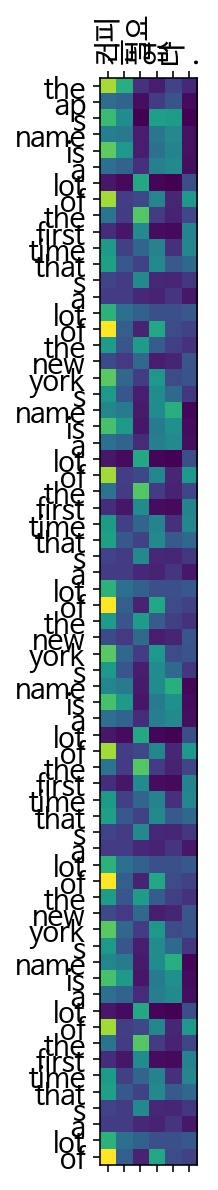

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the u . s . m . <end> 


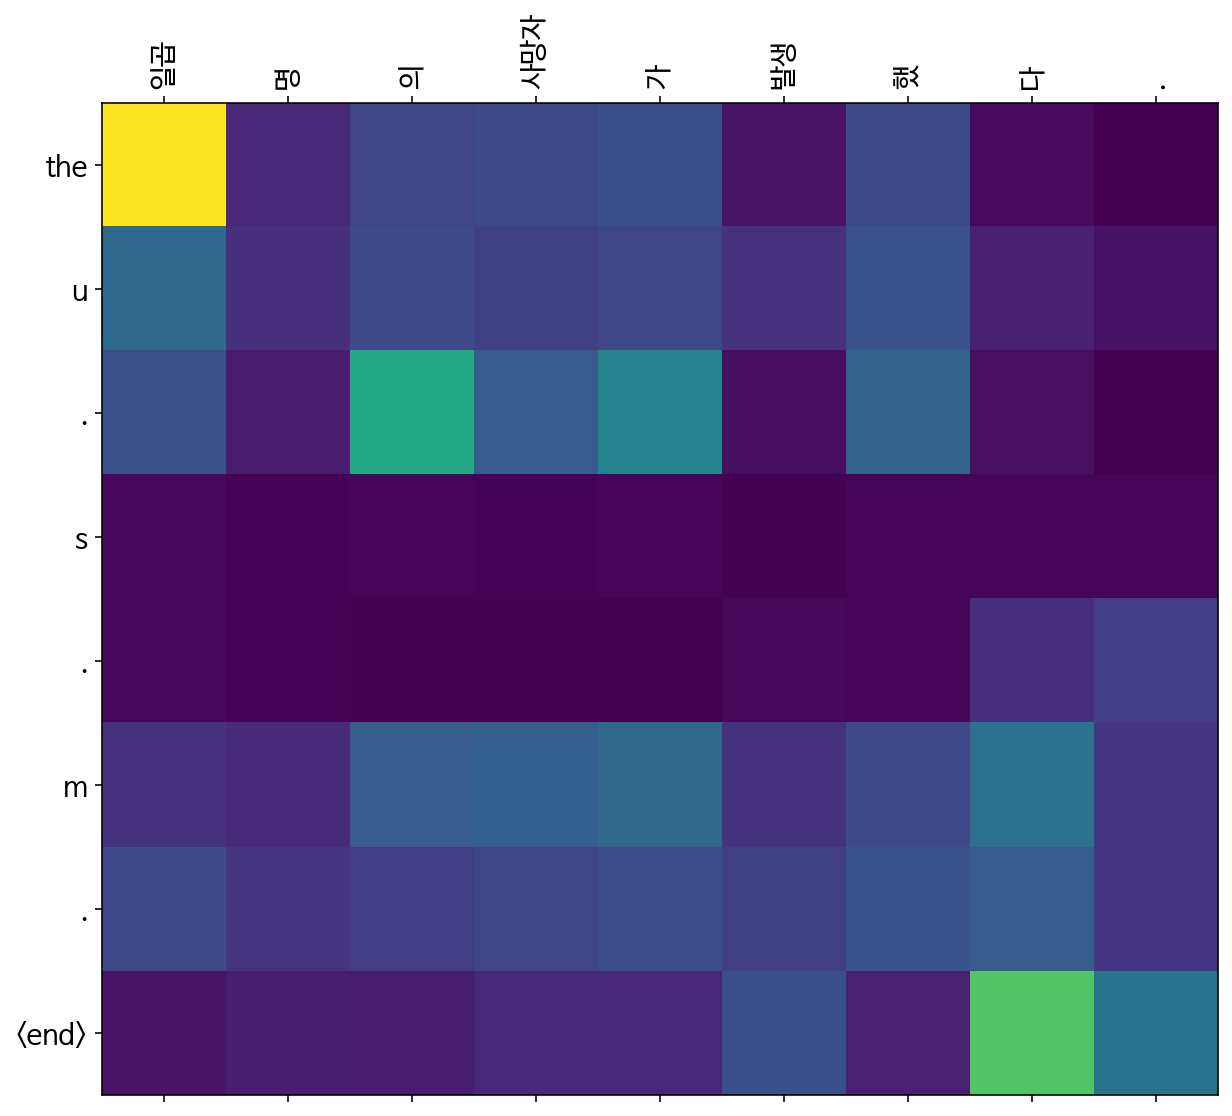

Epoch 22: 100%|██████████| 254/254 [00:57<00:00,  4.44it/s, Loss 0.9070]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says it s a new york . <end> 


Epoch 24: 100%|██████████| 254/254 [00:57<00:00,  4.40it/s, Loss 0.8724]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a lot of the world . <end> 


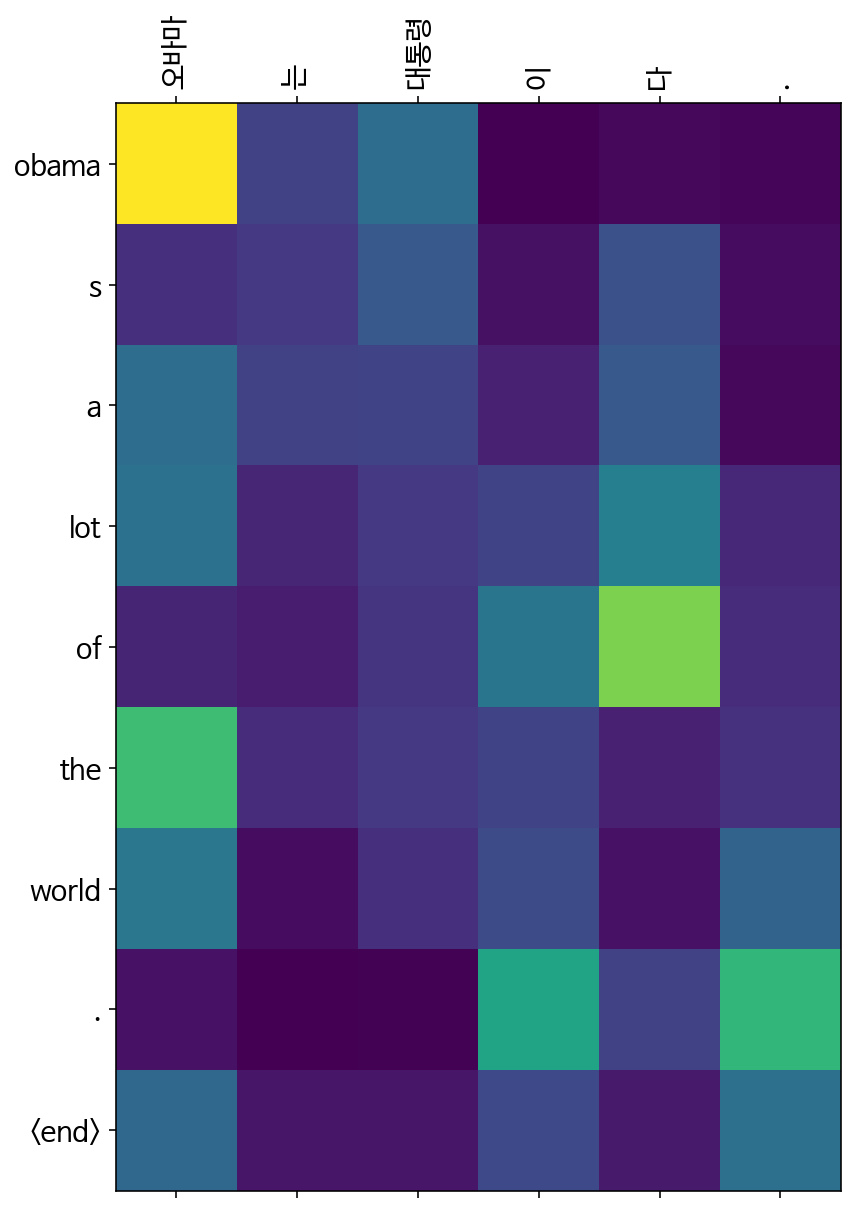

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


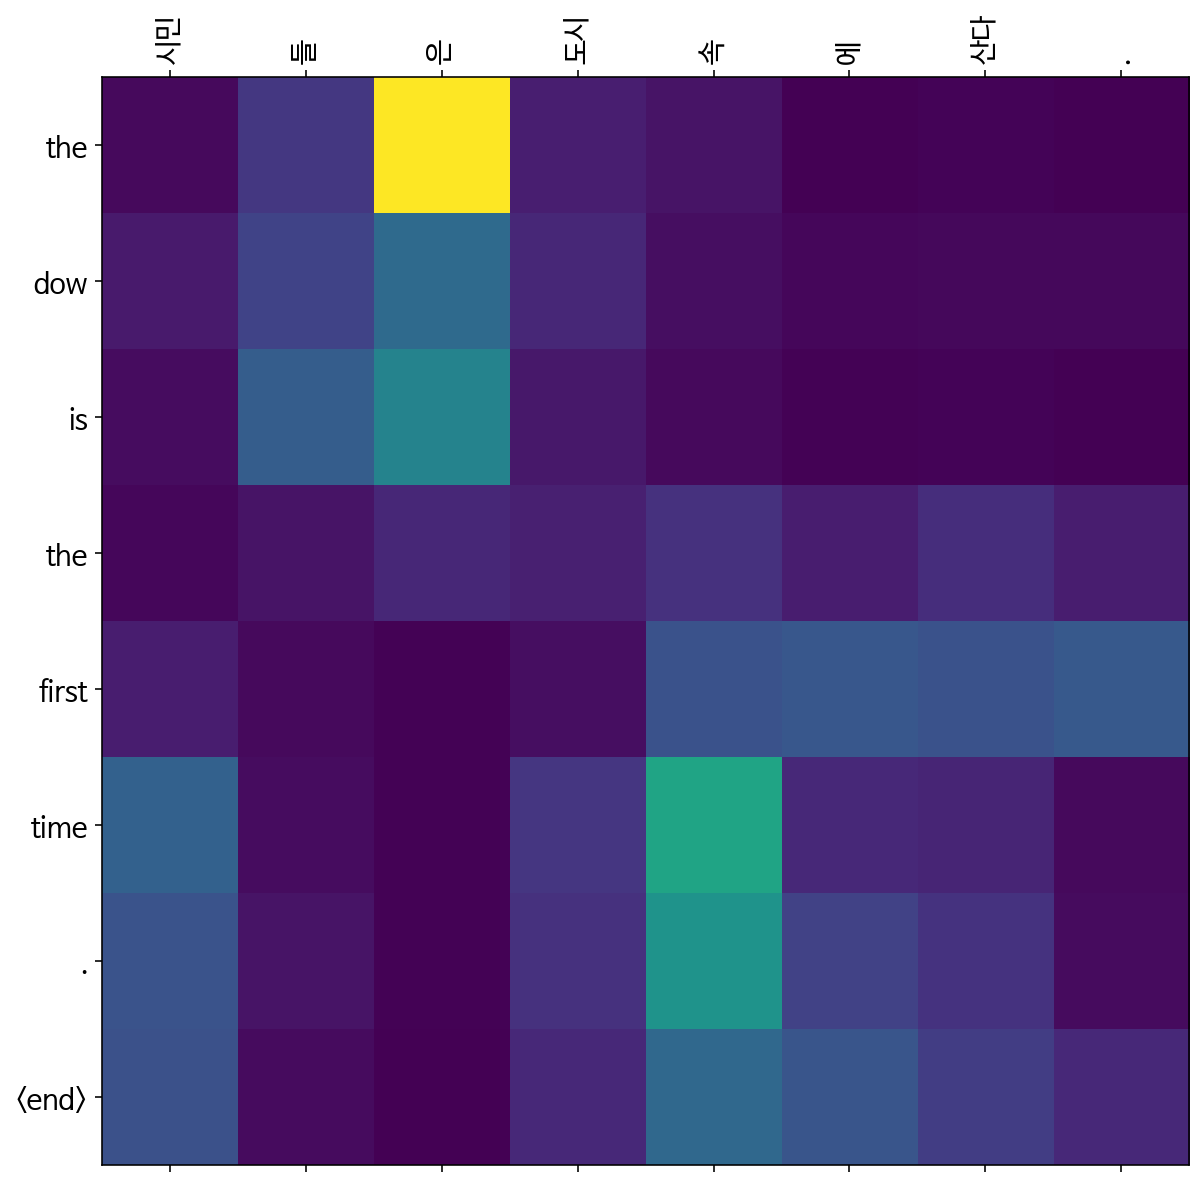

Input: 커피 는 필요 없 다 .
Predicted translation: the film is a lot of the first time ? <end> 


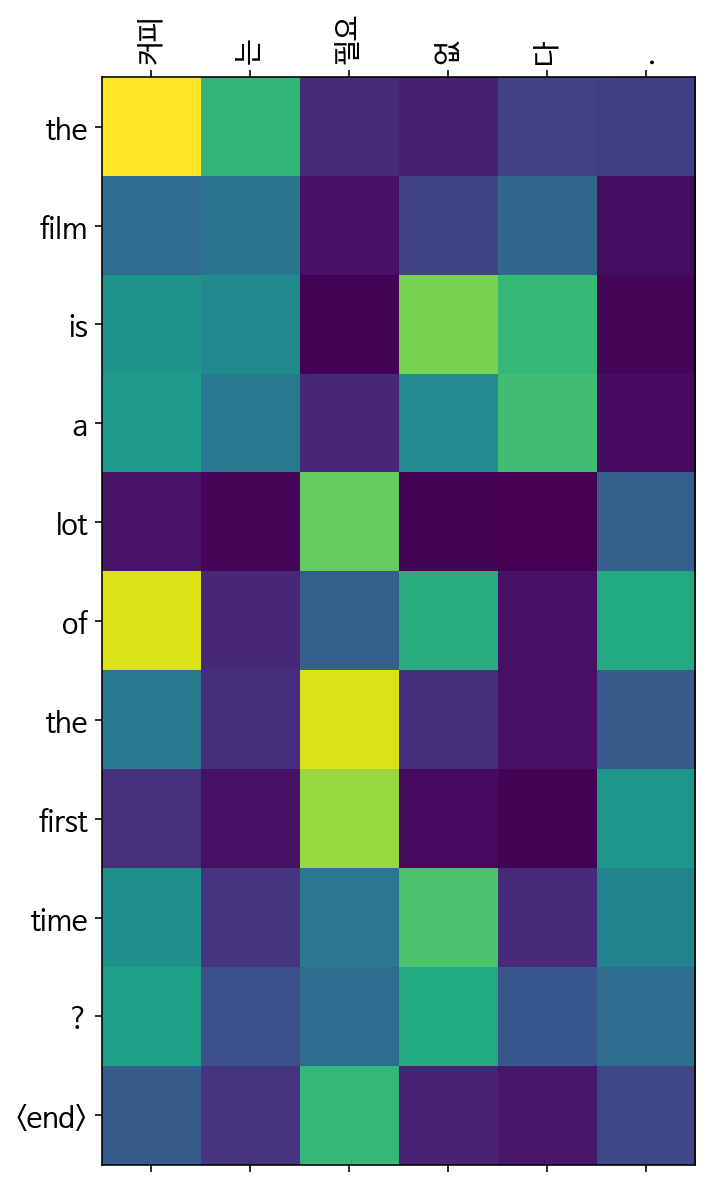

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were injured . <end> 


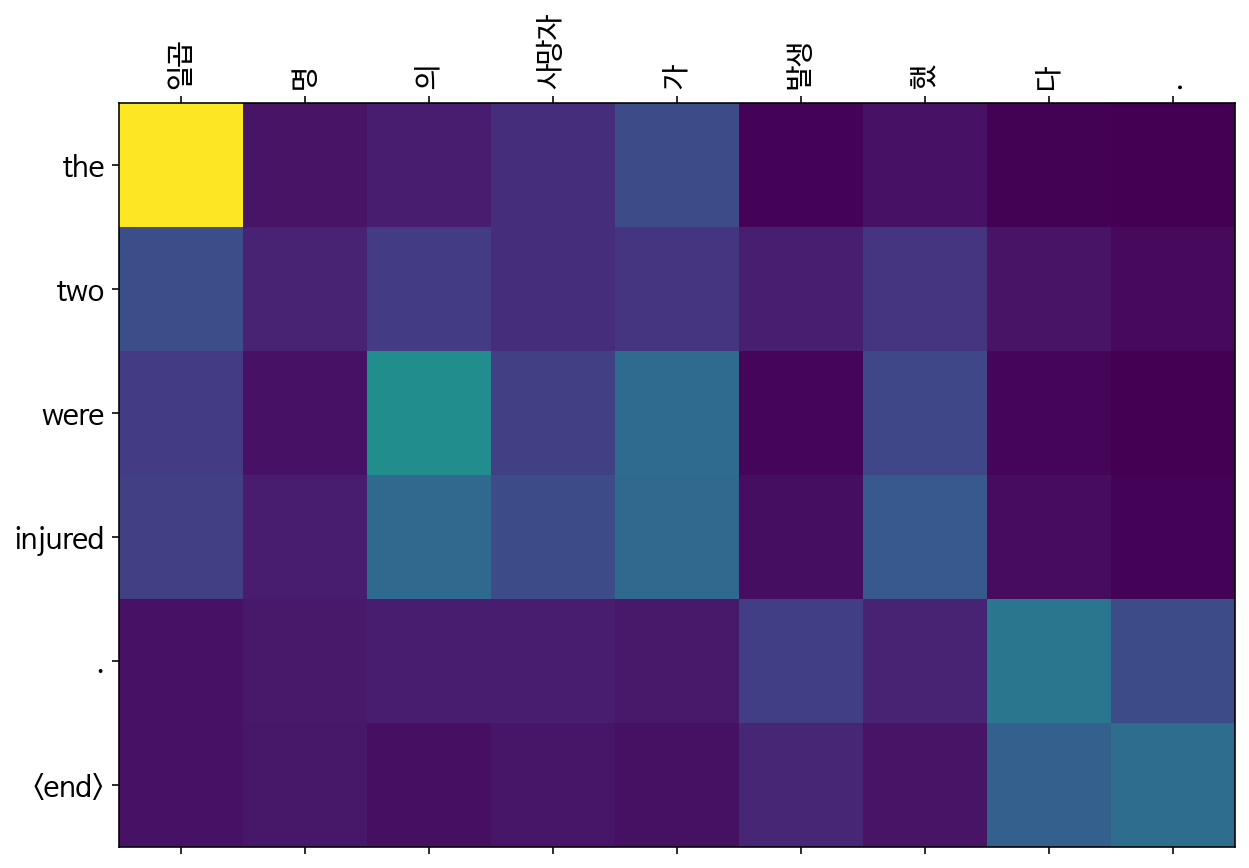

Epoch 25: 100%|██████████| 254/254 [00:57<00:00,  4.39it/s, Loss 0.8548]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says the ap s mark smith s a new york . <end> 


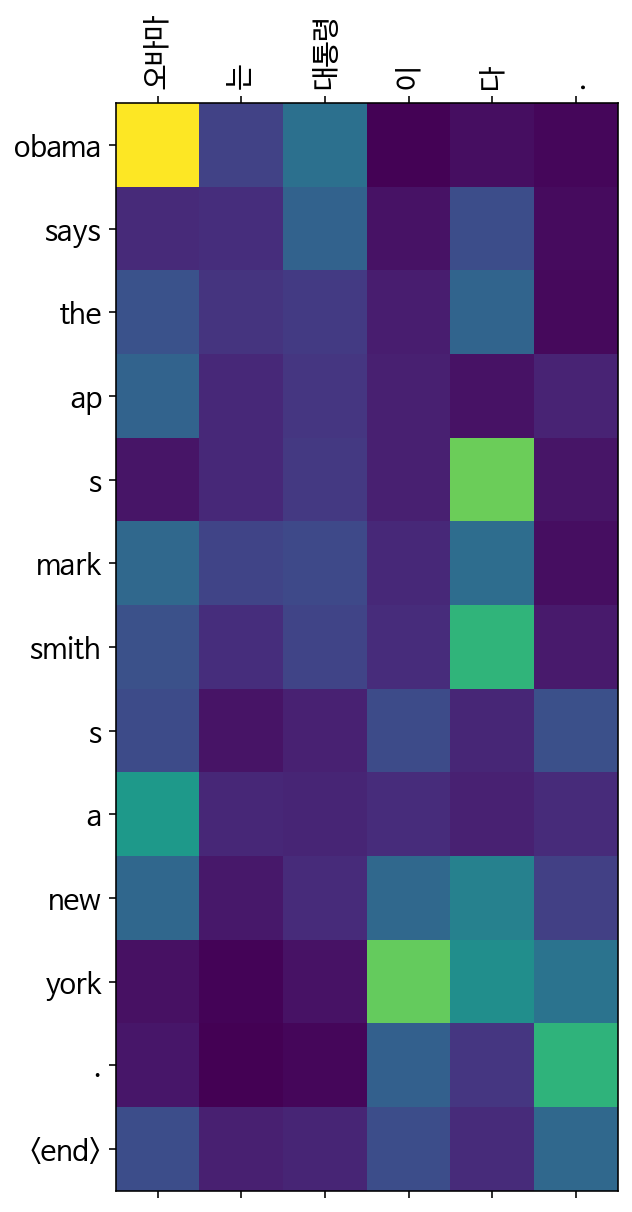

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


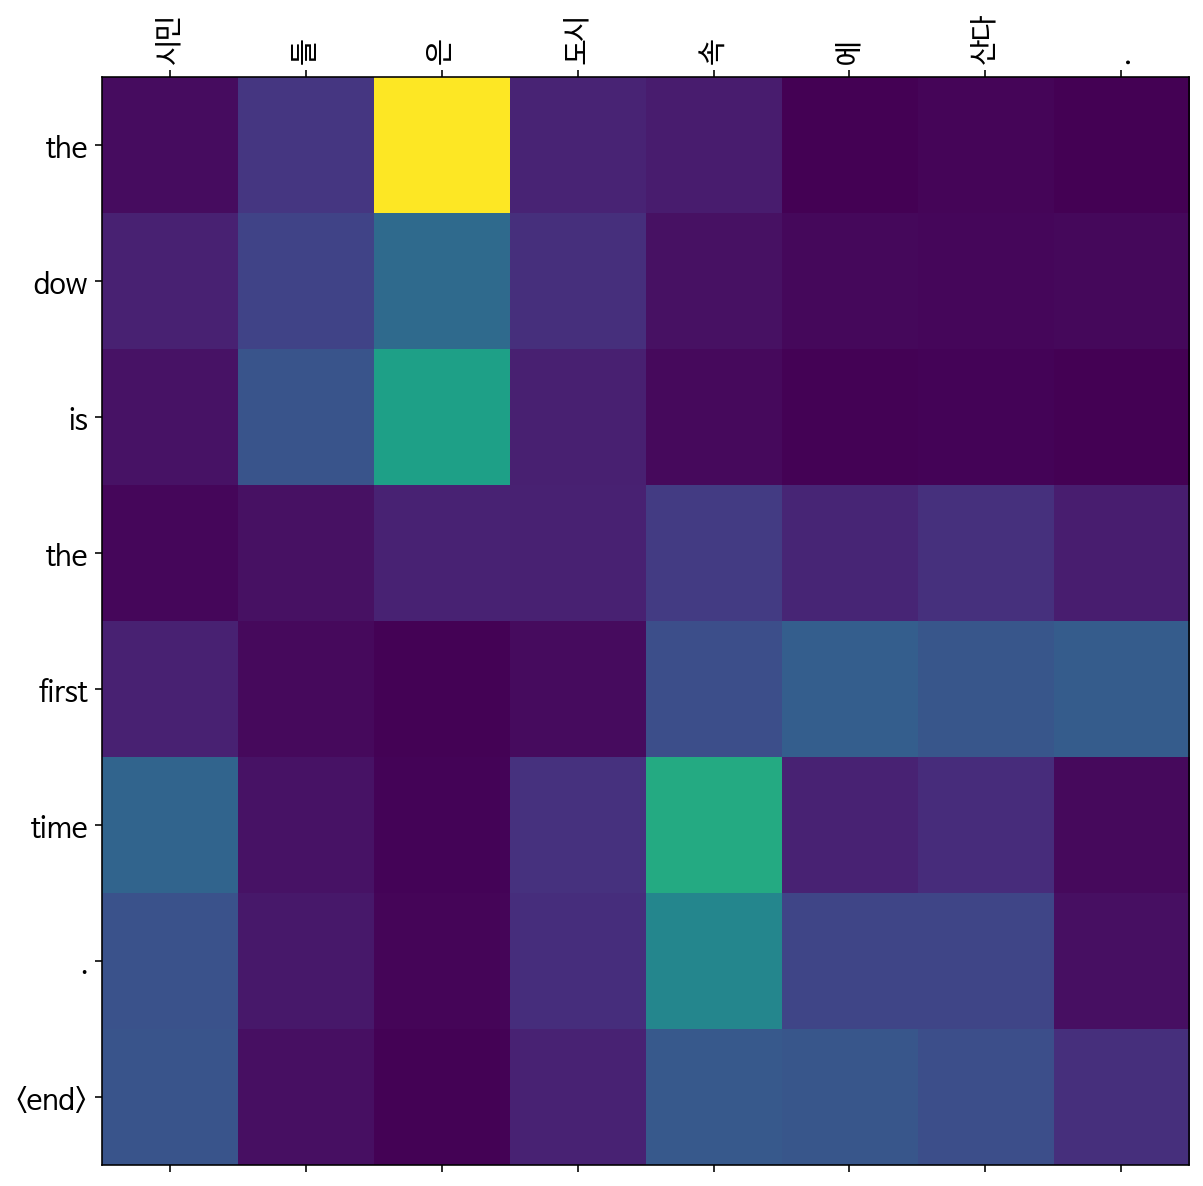

Input: 커피 는 필요 없 다 .
Predicted translation: the film is a lot of the first time that s a lot of the first time that s a lot of the first time that s a lot of the first time that s a lot of the first time that s a lot of the first time that s a lot of the first time that s a lot of the first time that s 


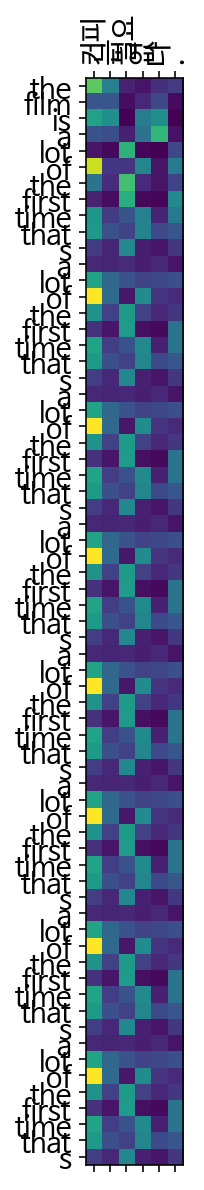

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the 


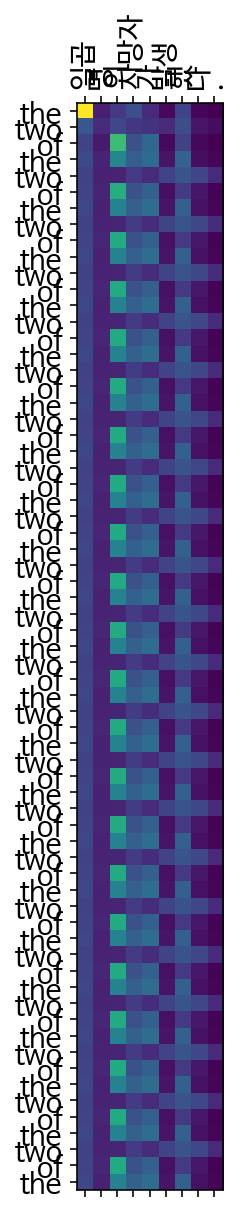

Epoch 26: 100%|██████████| 254/254 [00:56<00:00,  4.50it/s, Loss 0.8381]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a lot of the world . <end> 


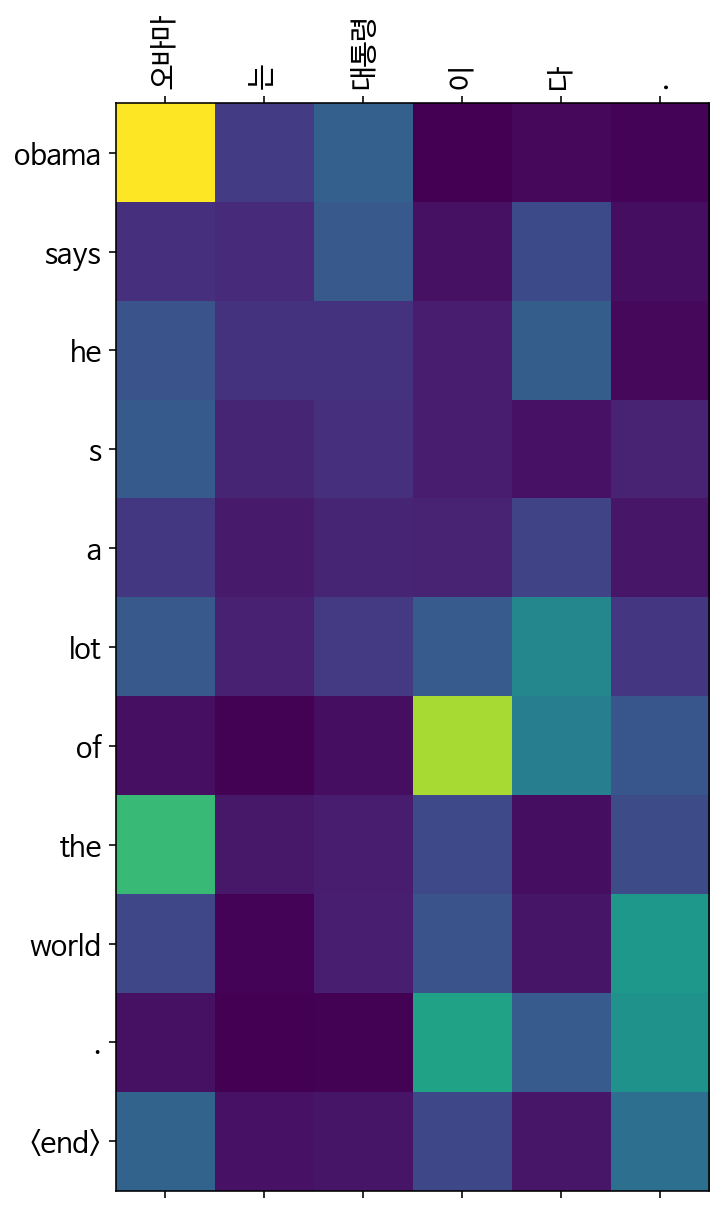

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


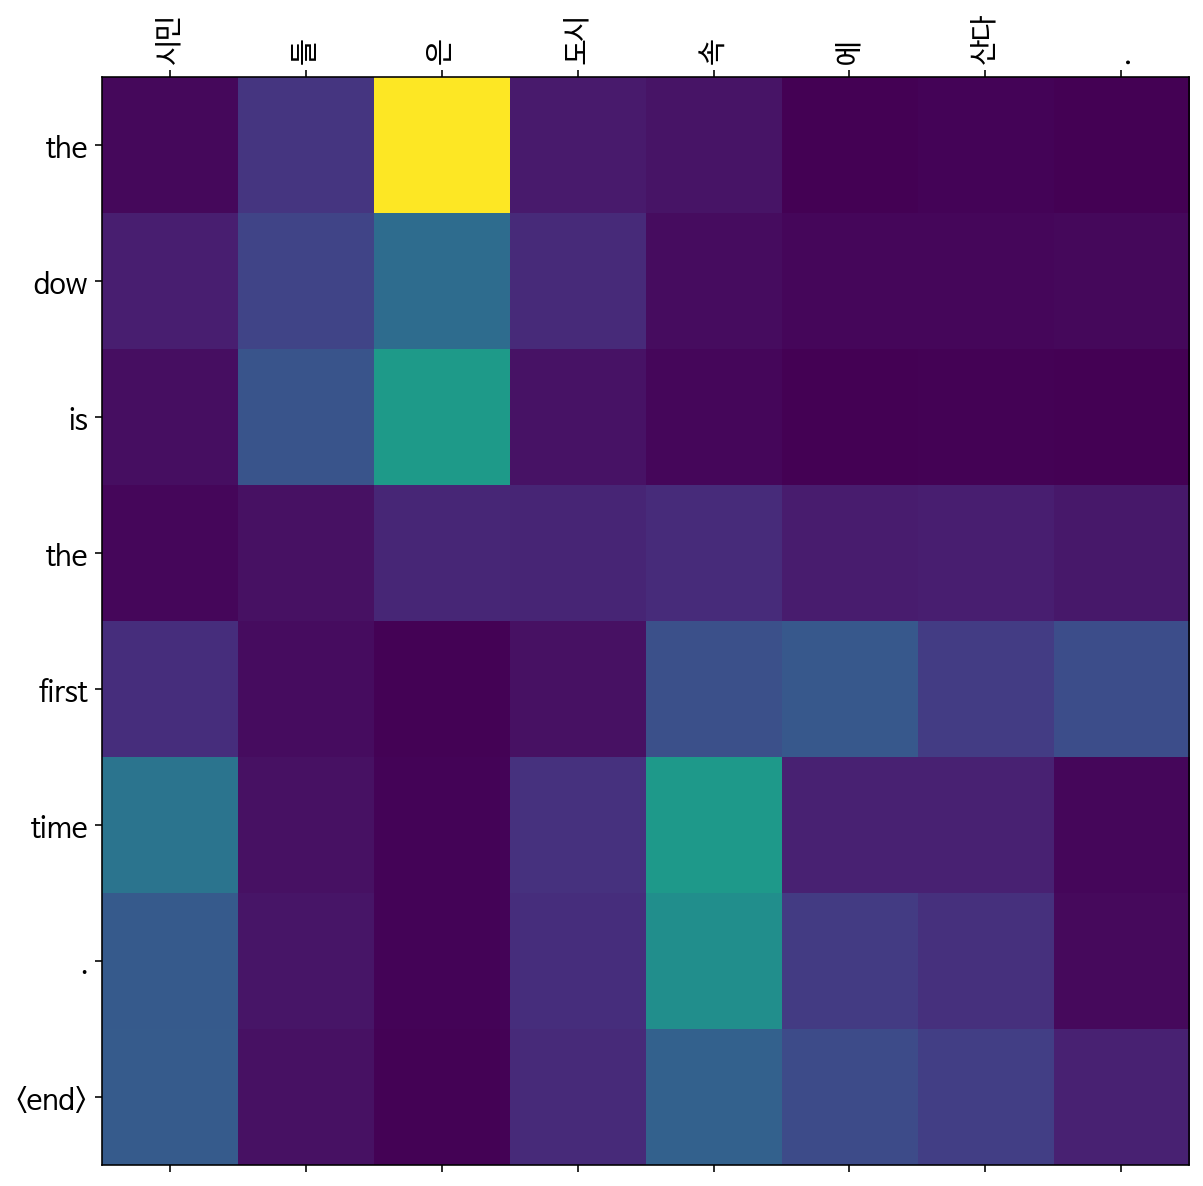

Input: 커피 는 필요 없 다 .
Predicted translation: you can be a lot of your own . <end> 


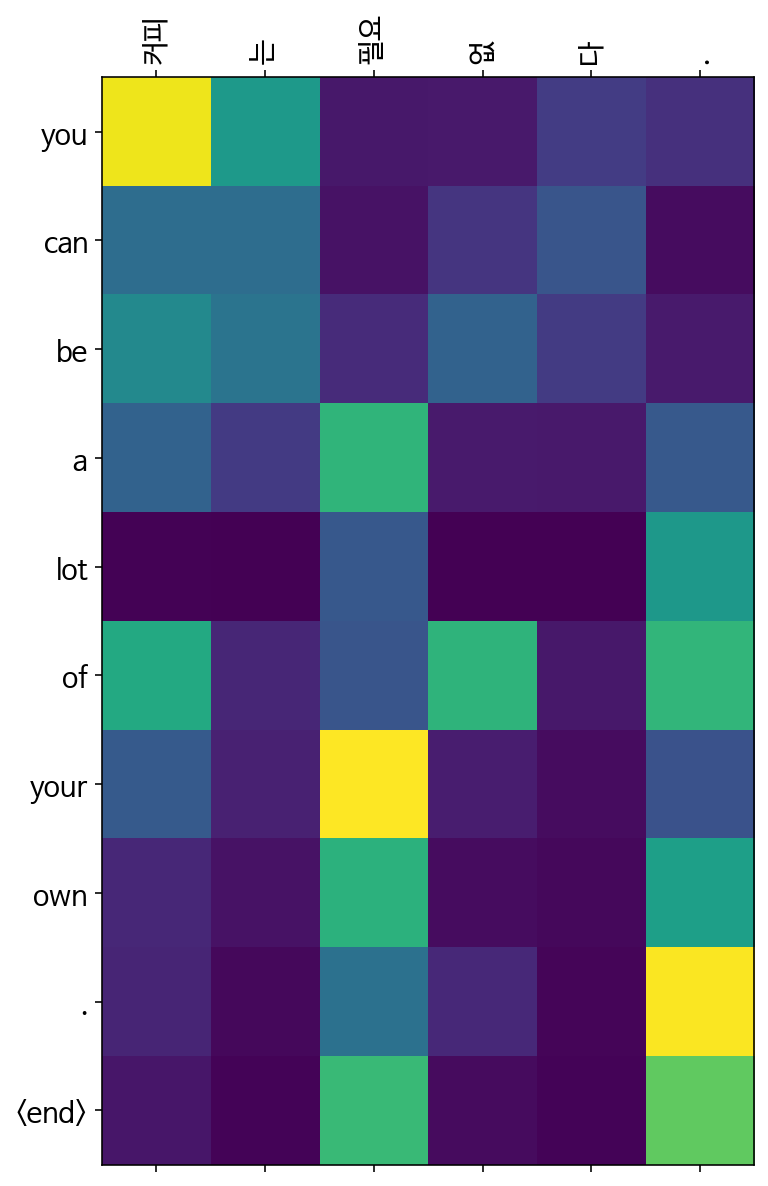

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the u . s . military official said . <end> 


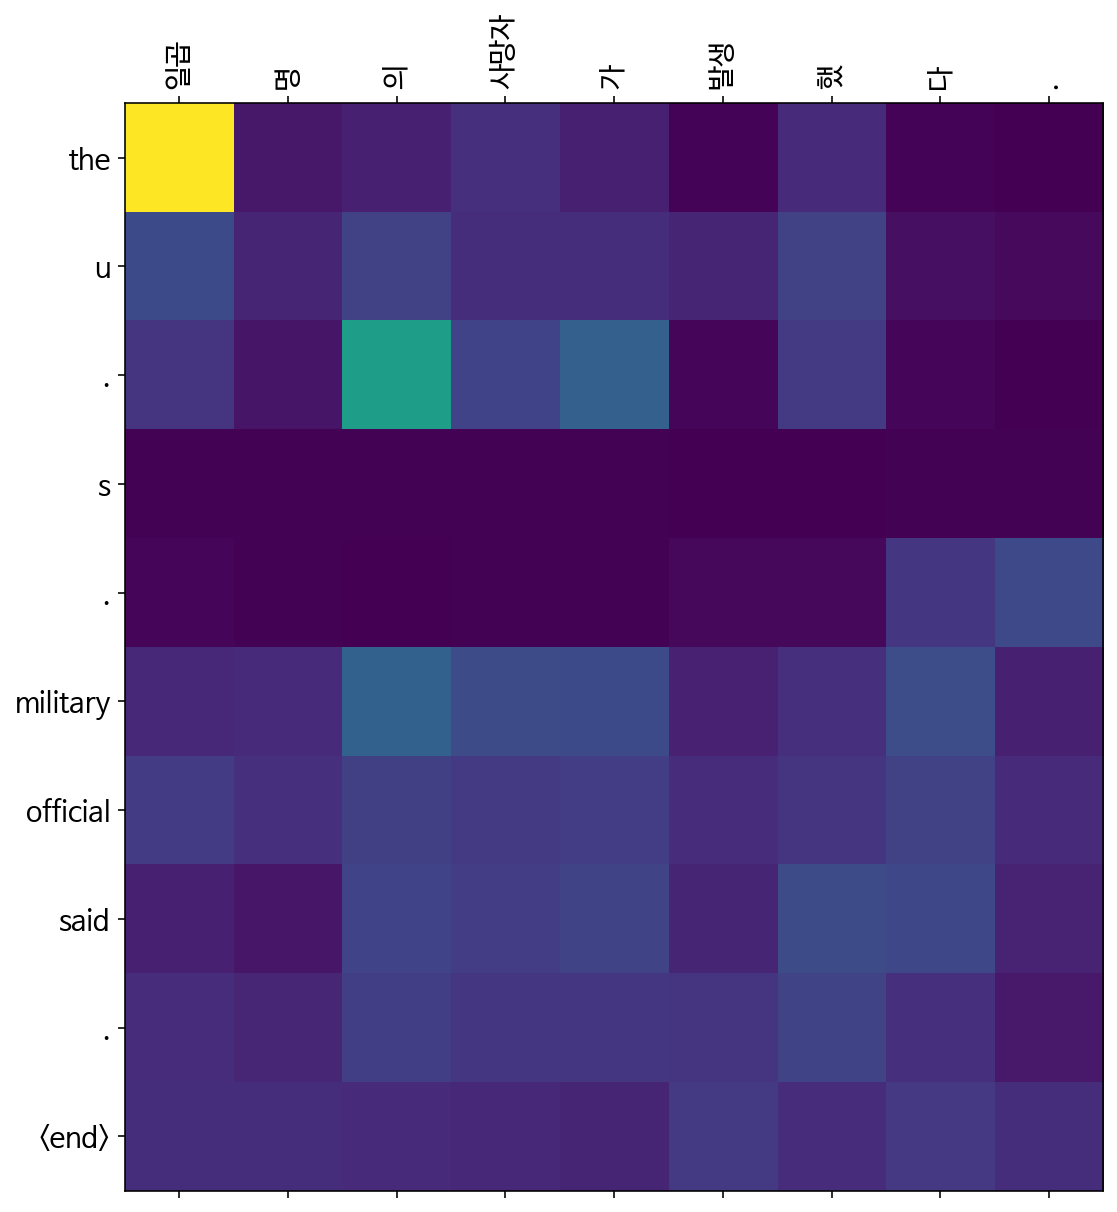

Epoch 27: 100%|██████████| 254/254 [00:56<00:00,  4.52it/s, Loss 0.8227]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says it s a new york . <end> 


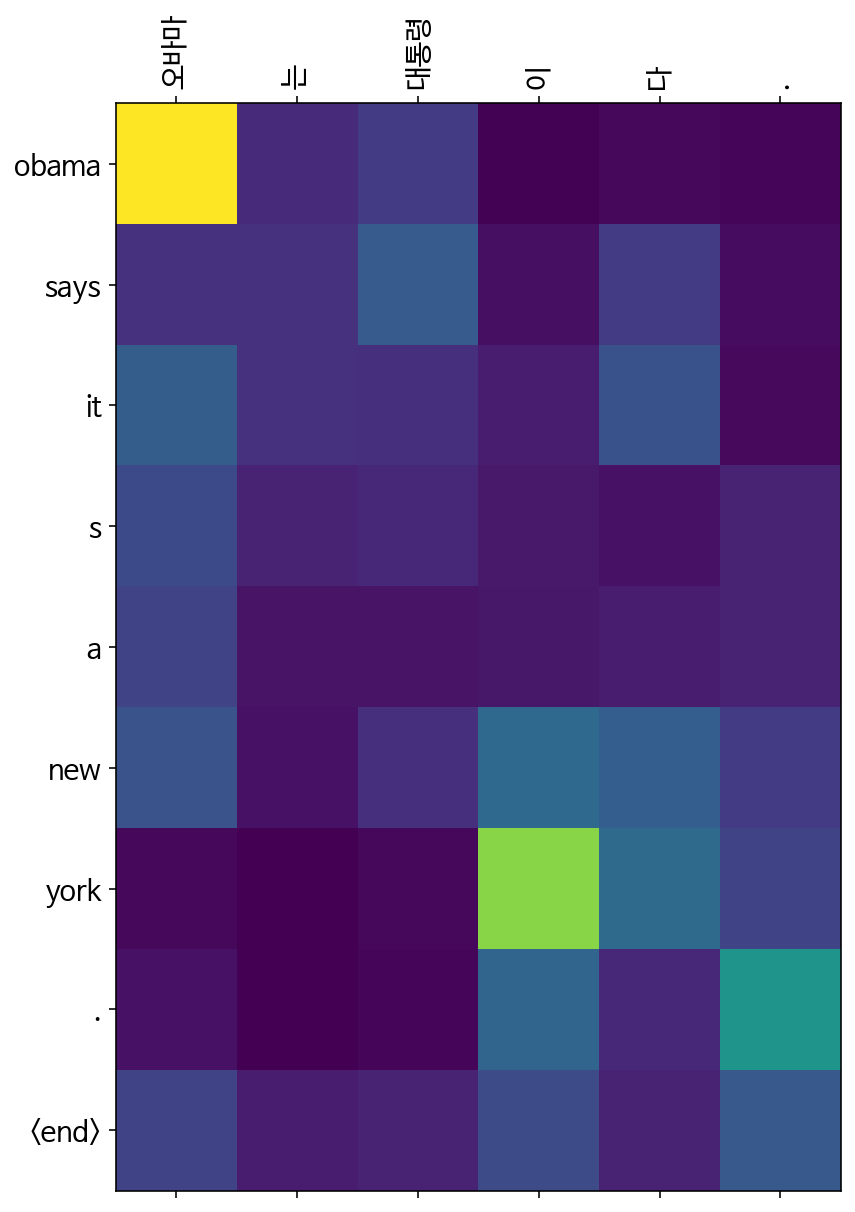

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the , but it s not to the first time . <end> 


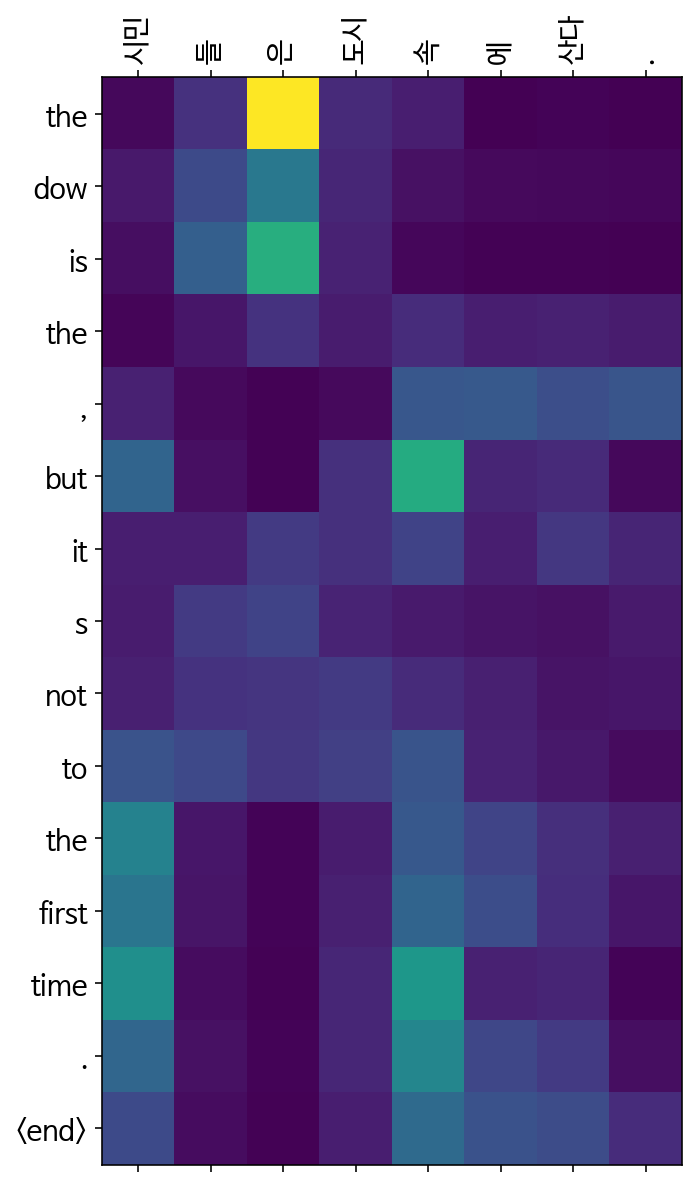

Input: 커피 는 필요 없 다 .
Predicted translation: the couple s name is not enough to be a lot of your life . <end> 


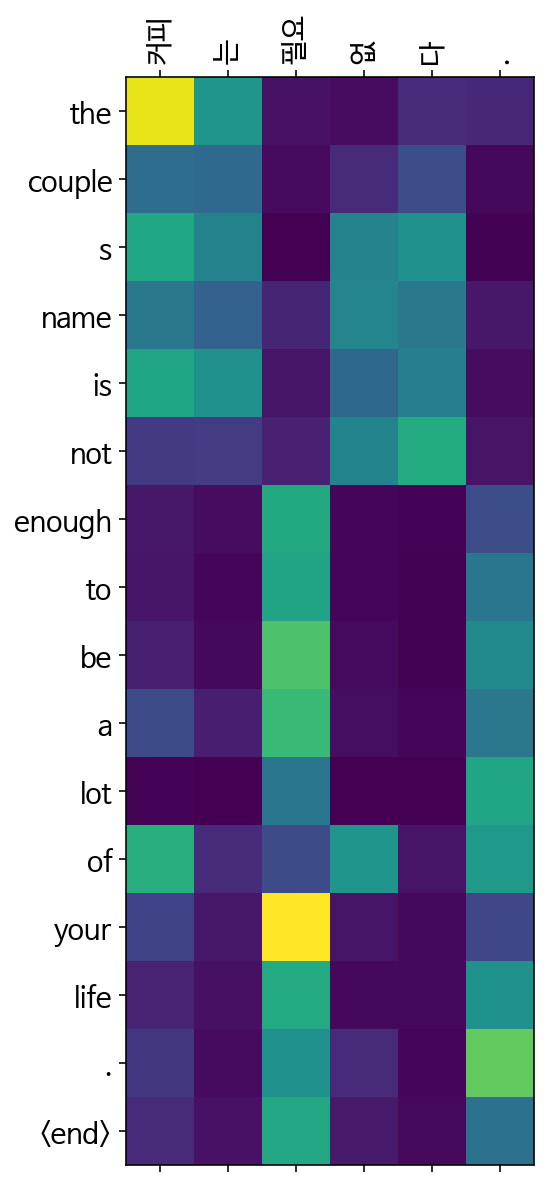

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two of people were not to the hospital . <end> 


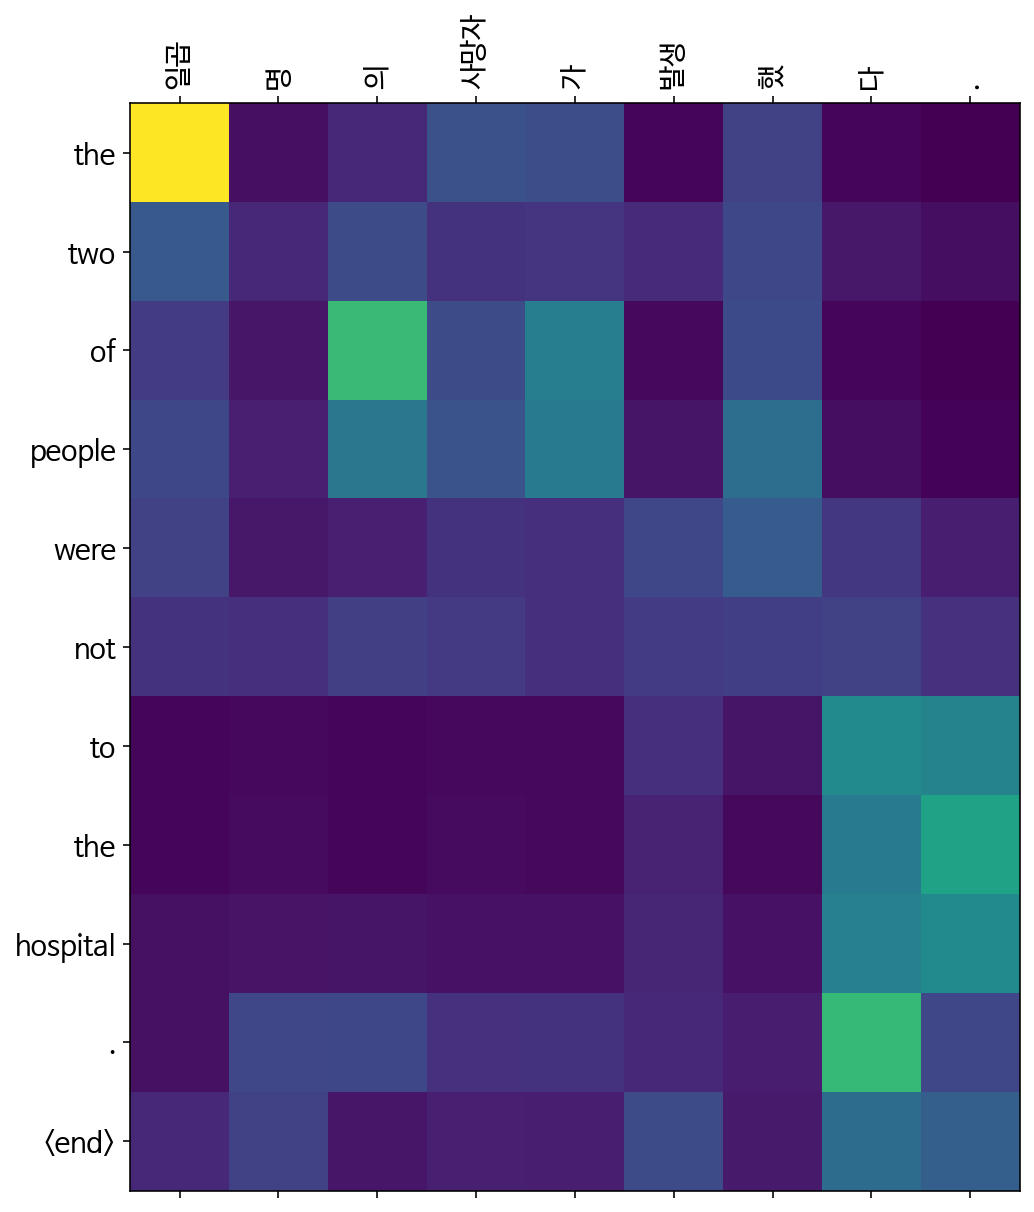

Epoch 28: 100%|██████████| 254/254 [00:55<00:00,  4.55it/s, Loss 0.8062]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new york . <end> 


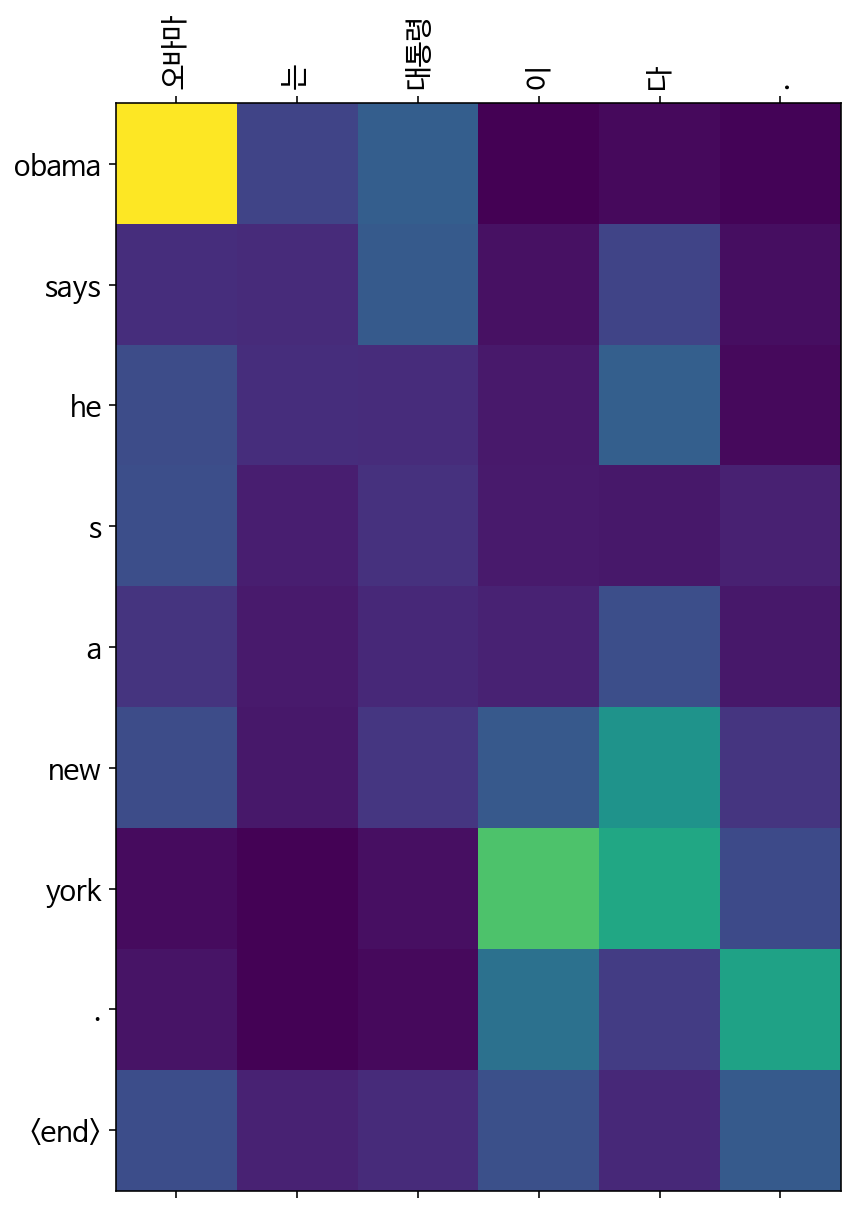

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the ap s . <end> 


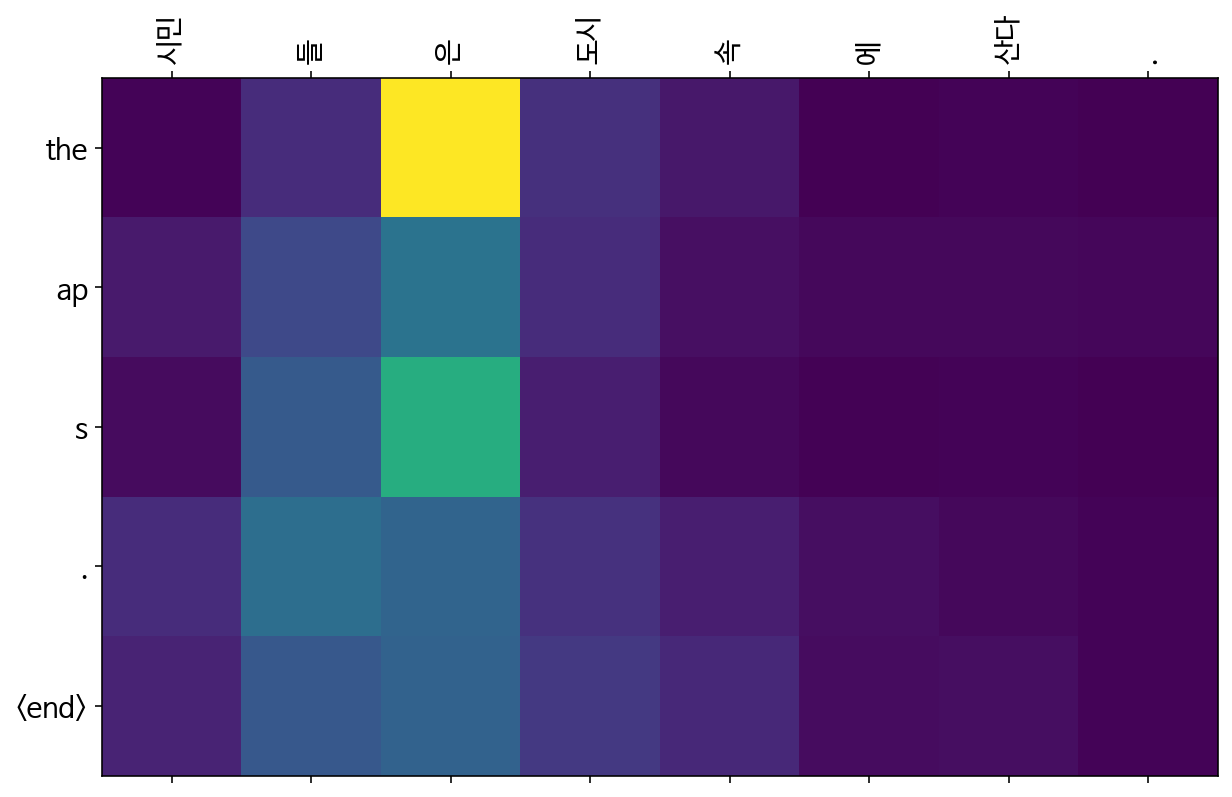

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your own . <end> 


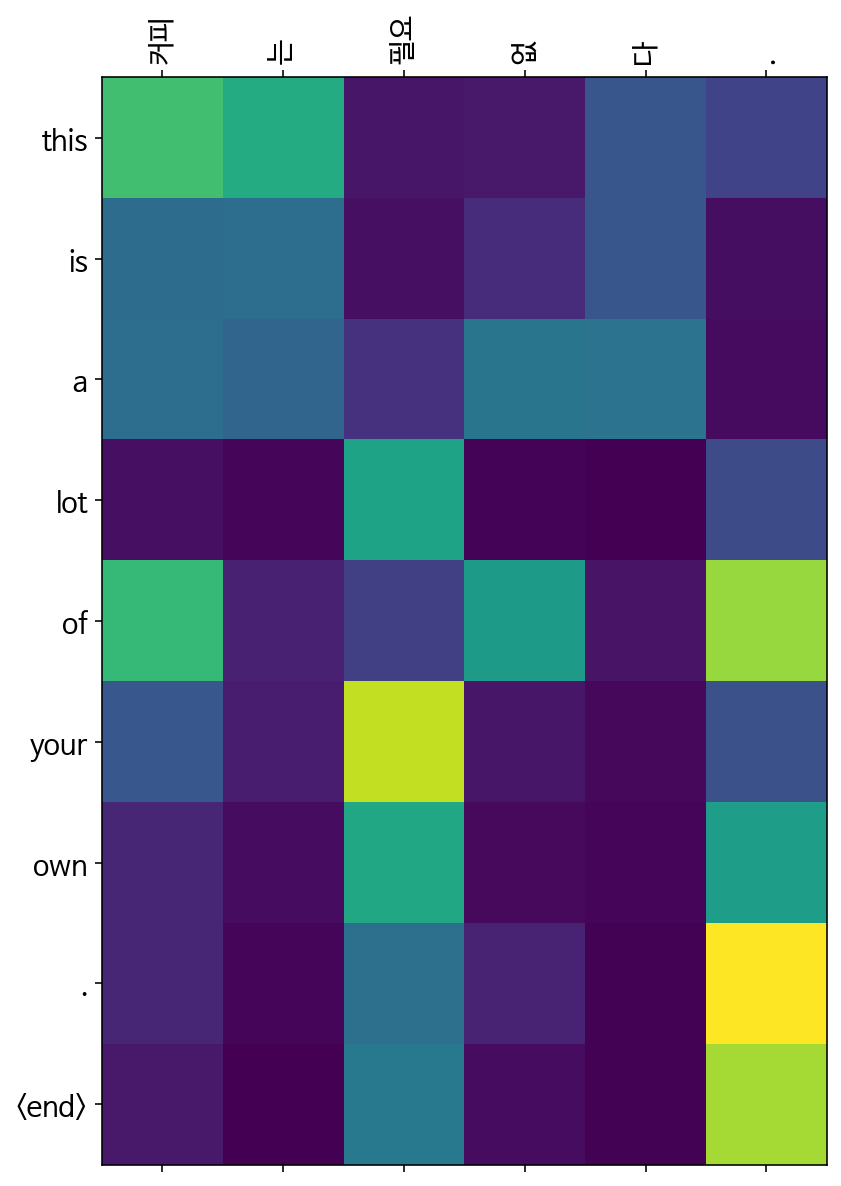

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two of death toll from the attack . <end> 


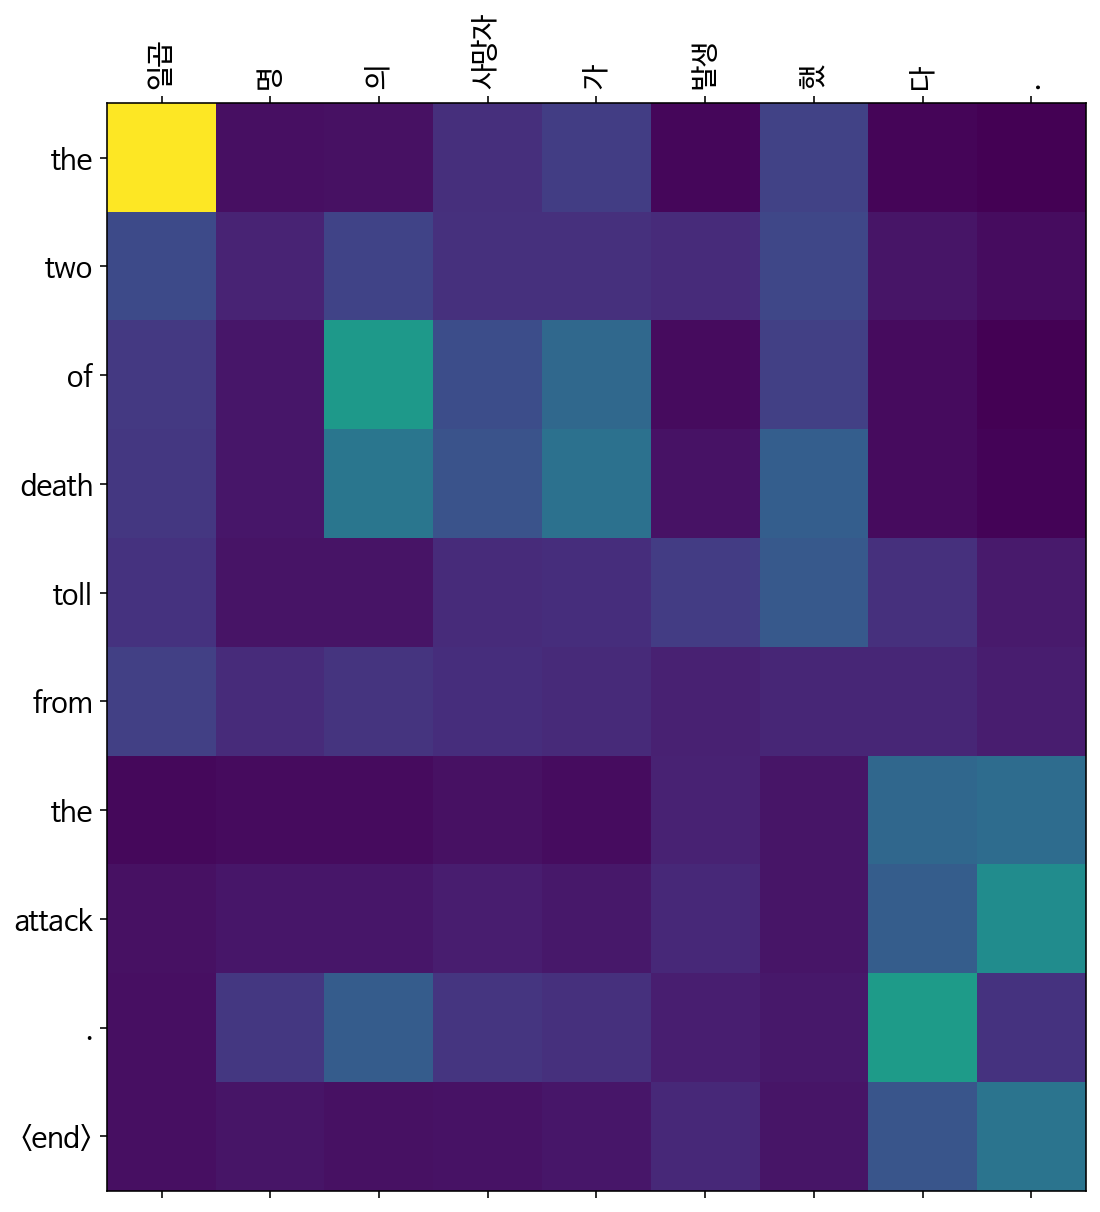

Epoch 29: 100%|██████████| 254/254 [00:56<00:00,  4.51it/s, Loss 0.7914]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new york . <end> 


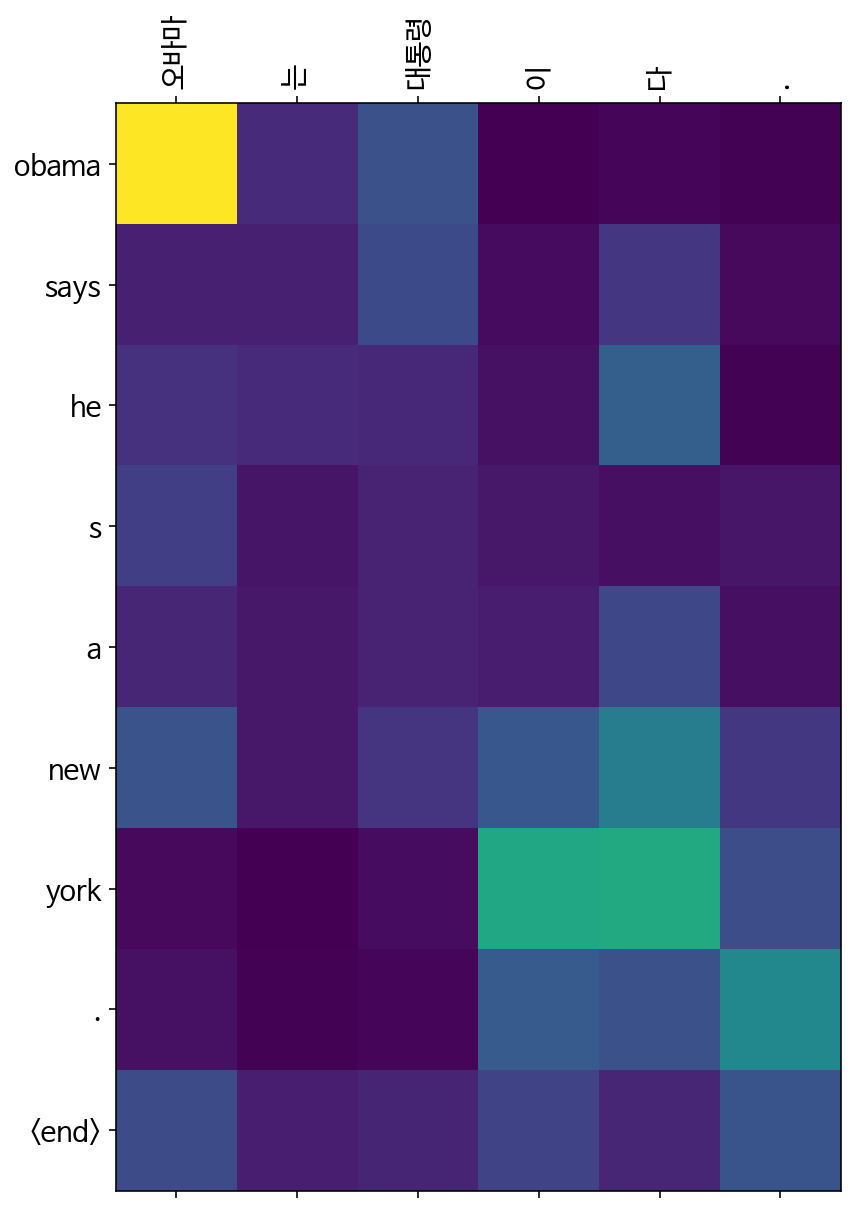

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


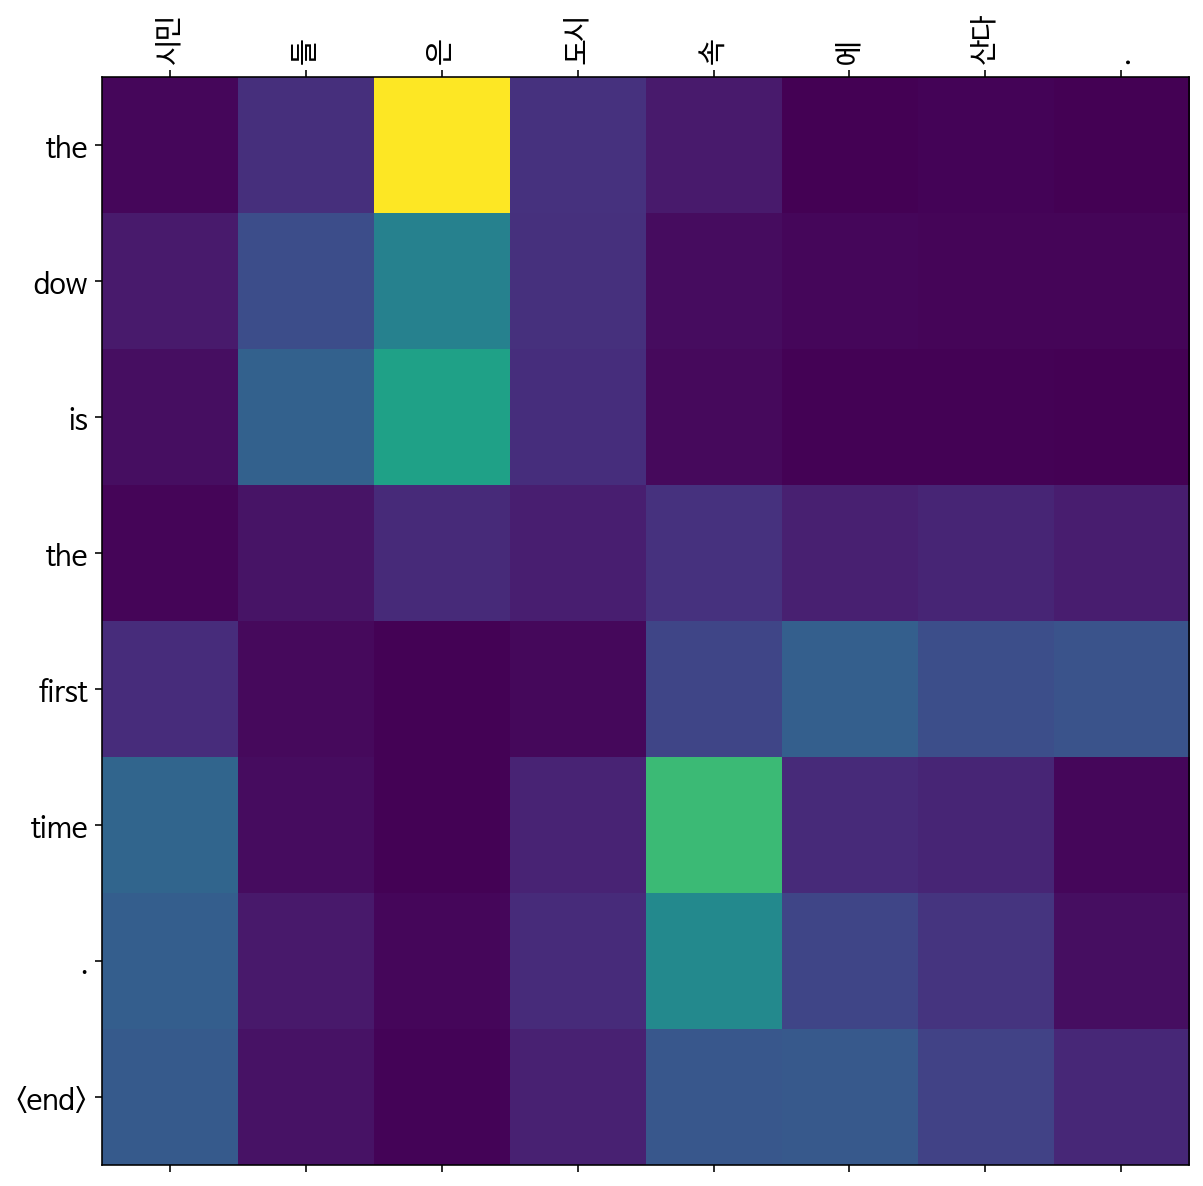

Input: 커피 는 필요 없 다 .
Predicted translation: it s a lot of the best thing <end> 


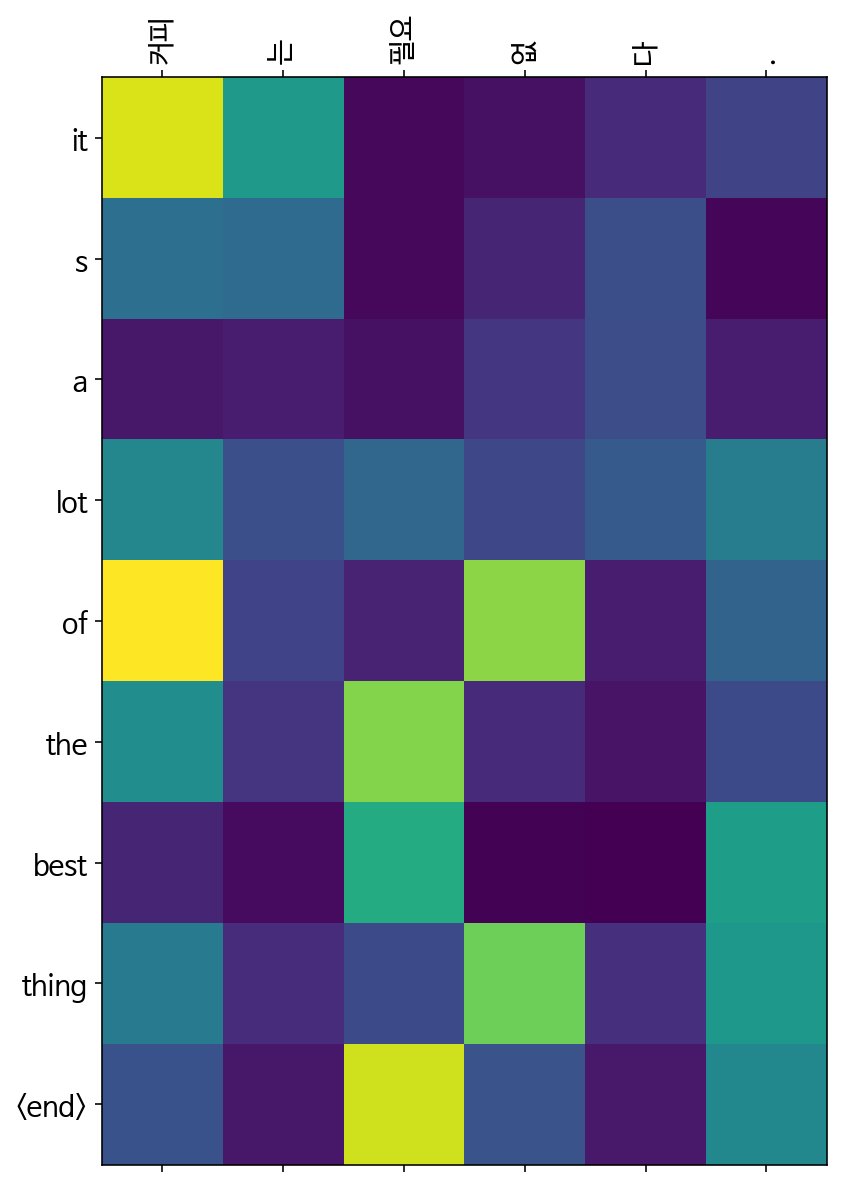

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two of death toll from the hospital . <end> 


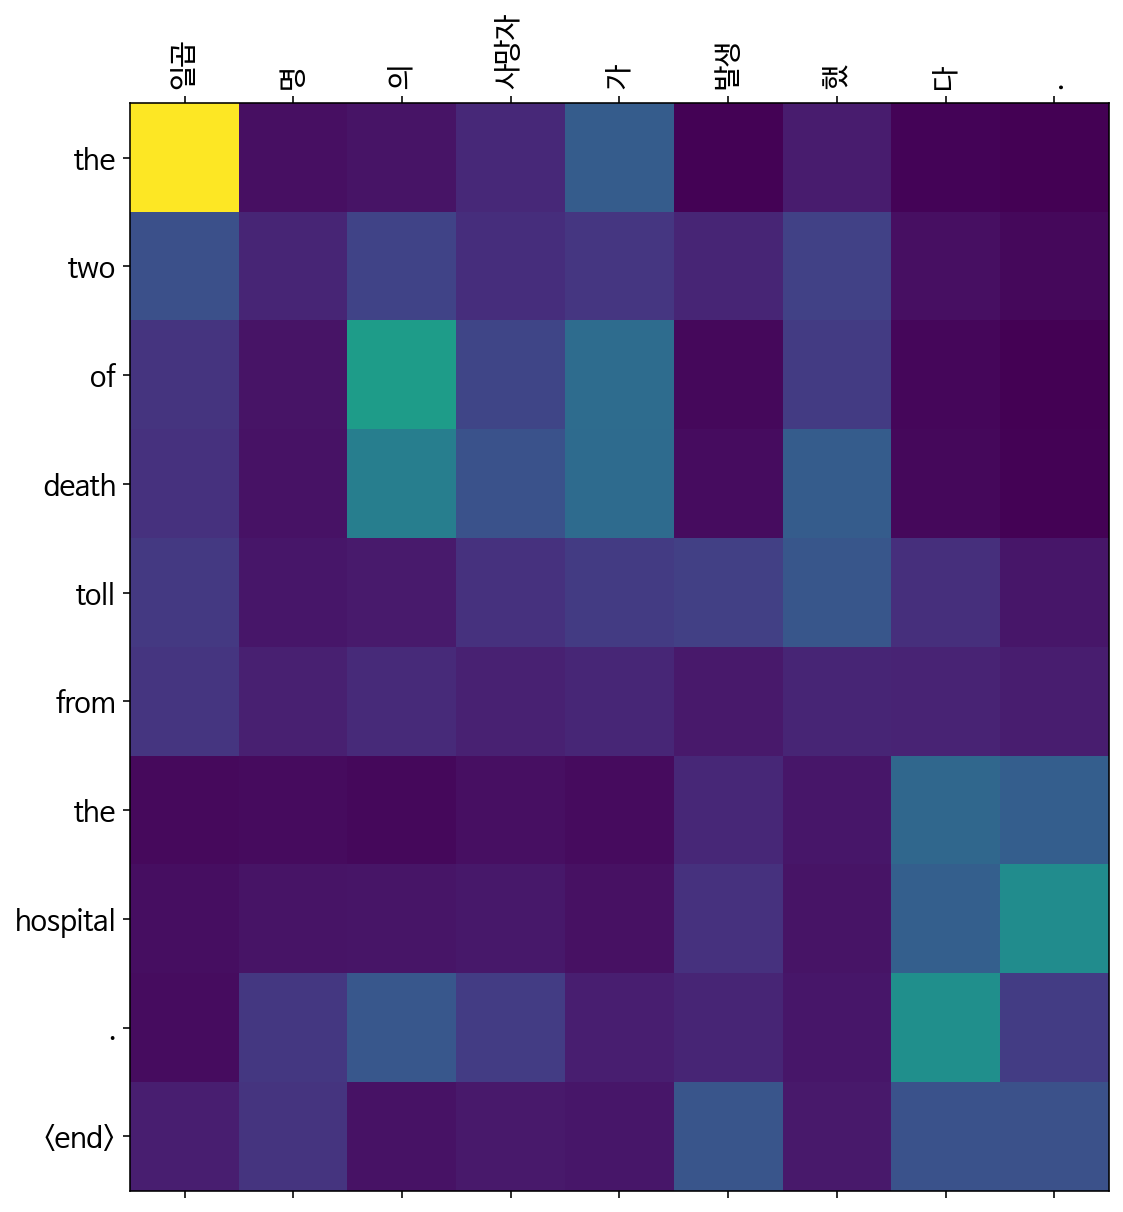

Epoch 30: 100%|██████████| 254/254 [00:56<00:00,  4.53it/s, Loss 0.7775]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says it s a new york . <end> 


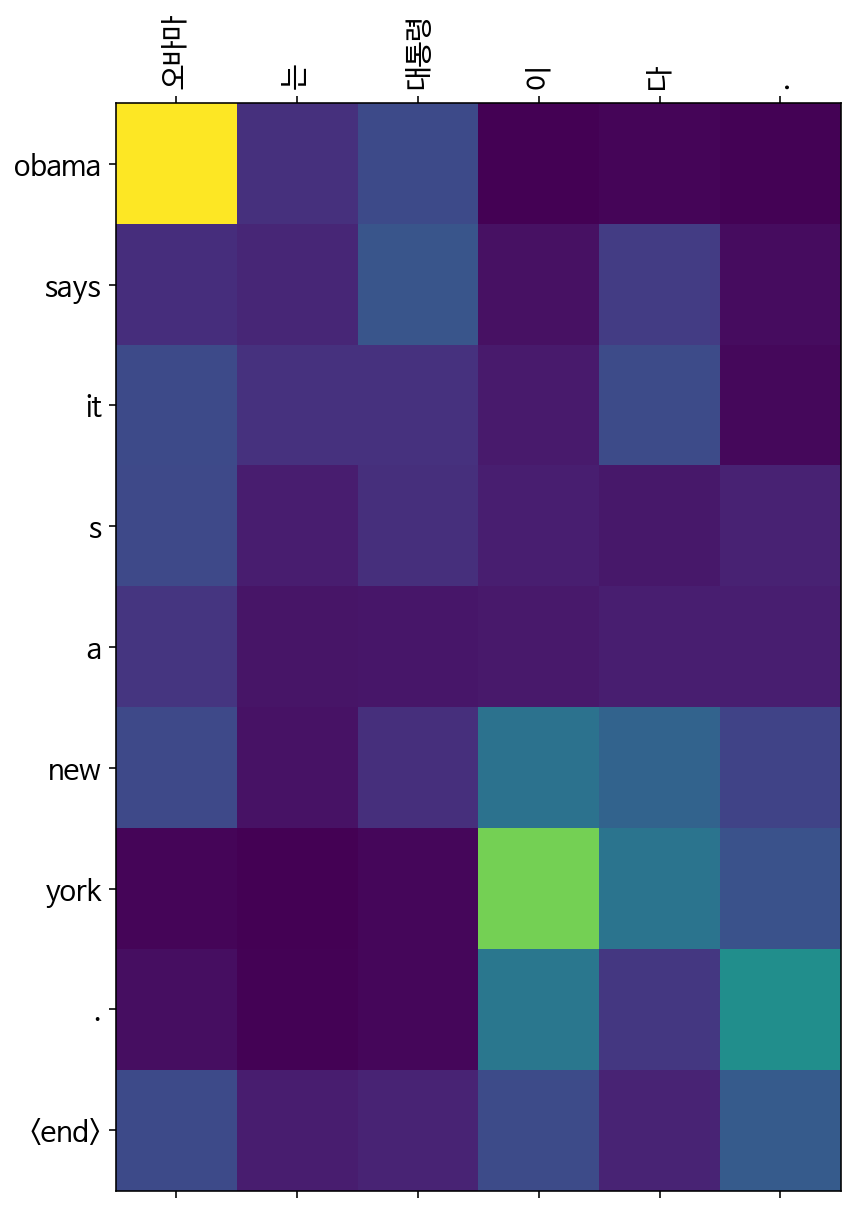

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the 


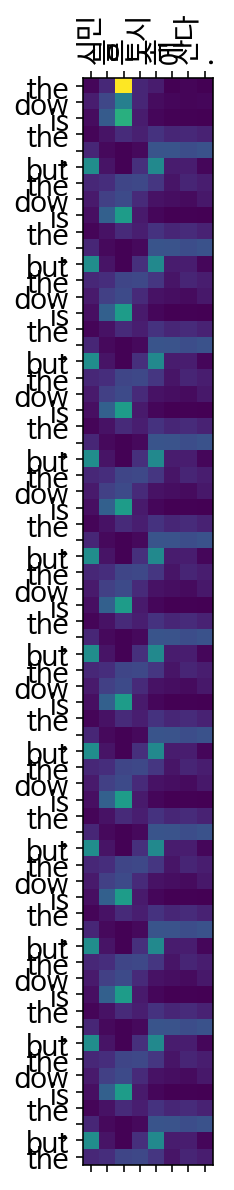

Input: 커피 는 필요 없 다 .
Predicted translation: the boss is a lot of the best drama . <end> 


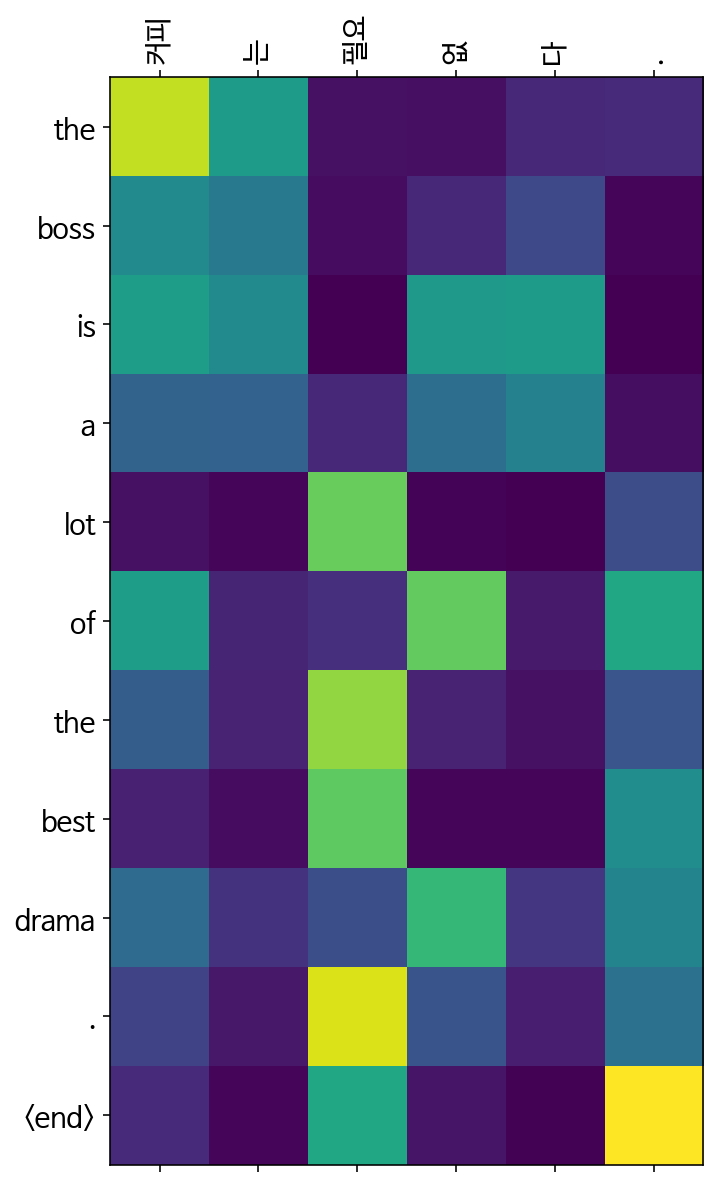

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two of death toll was the first time of the attack . <end> 


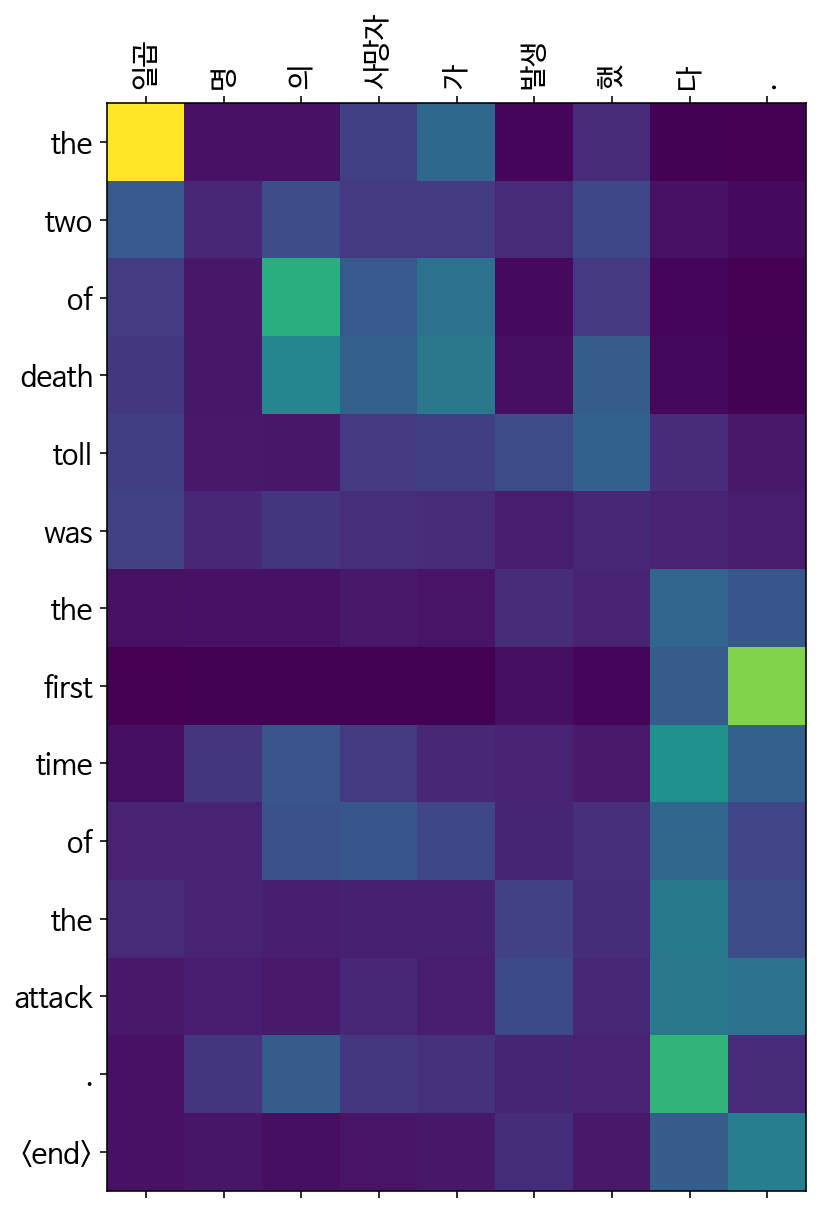

Epoch 31: 100%|██████████| 254/254 [00:55<00:00,  4.54it/s, Loss 0.7624]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york s lawyer , obama s a new york s lawyer , obama s a new york s lawyer , obama s a new york s lawyer , obama s a new york s lawyer , obama s a new york s lawyer , obama s a new york s lawyer , obama s a new york s lawyer , obama s a 


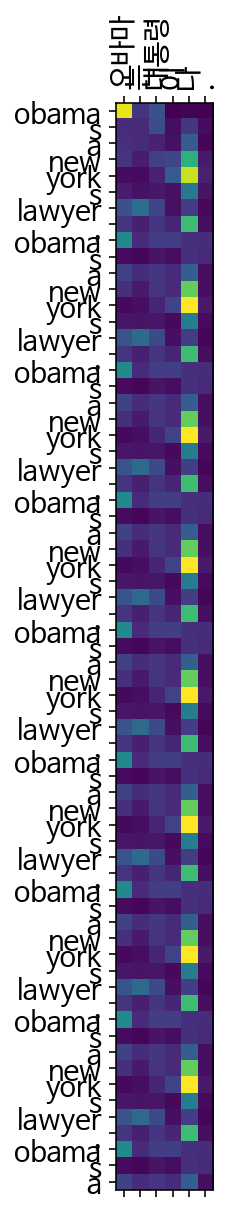

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the dow is the , but the 


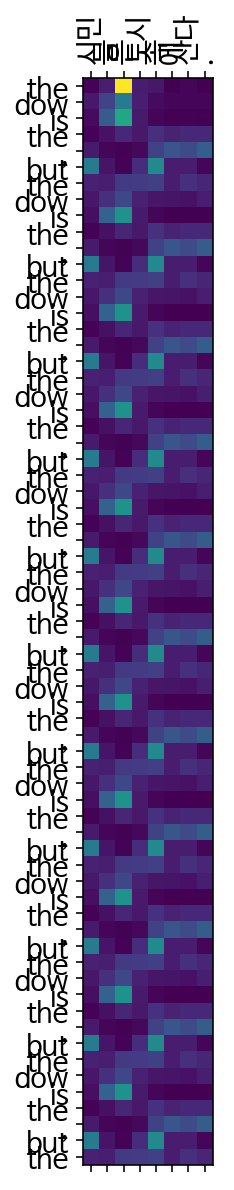

Input: 커피 는 필요 없 다 .
Predicted translation: the film s margin is a lot of the same thing that s a lot of your own . <end> 


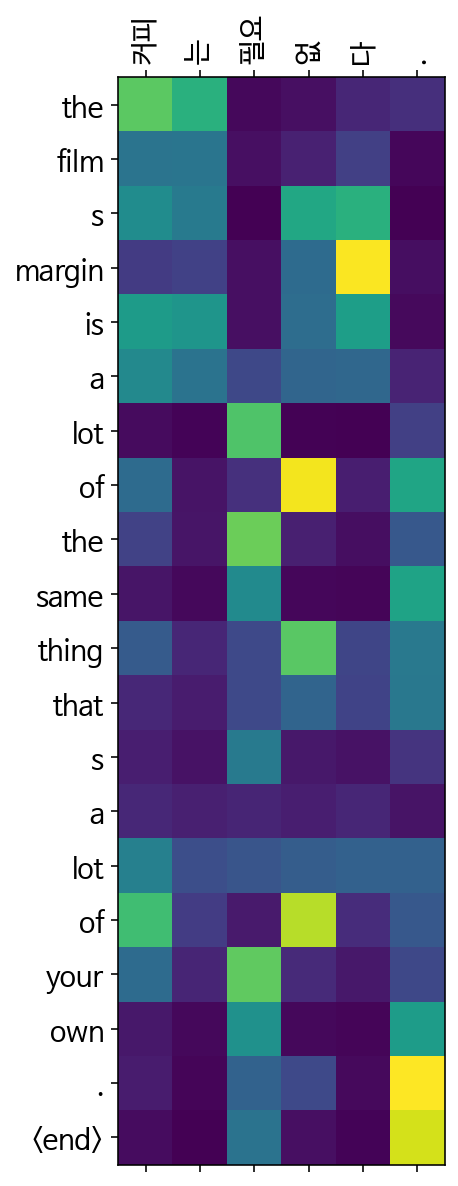

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two of death was the first time in the dead . <end> 


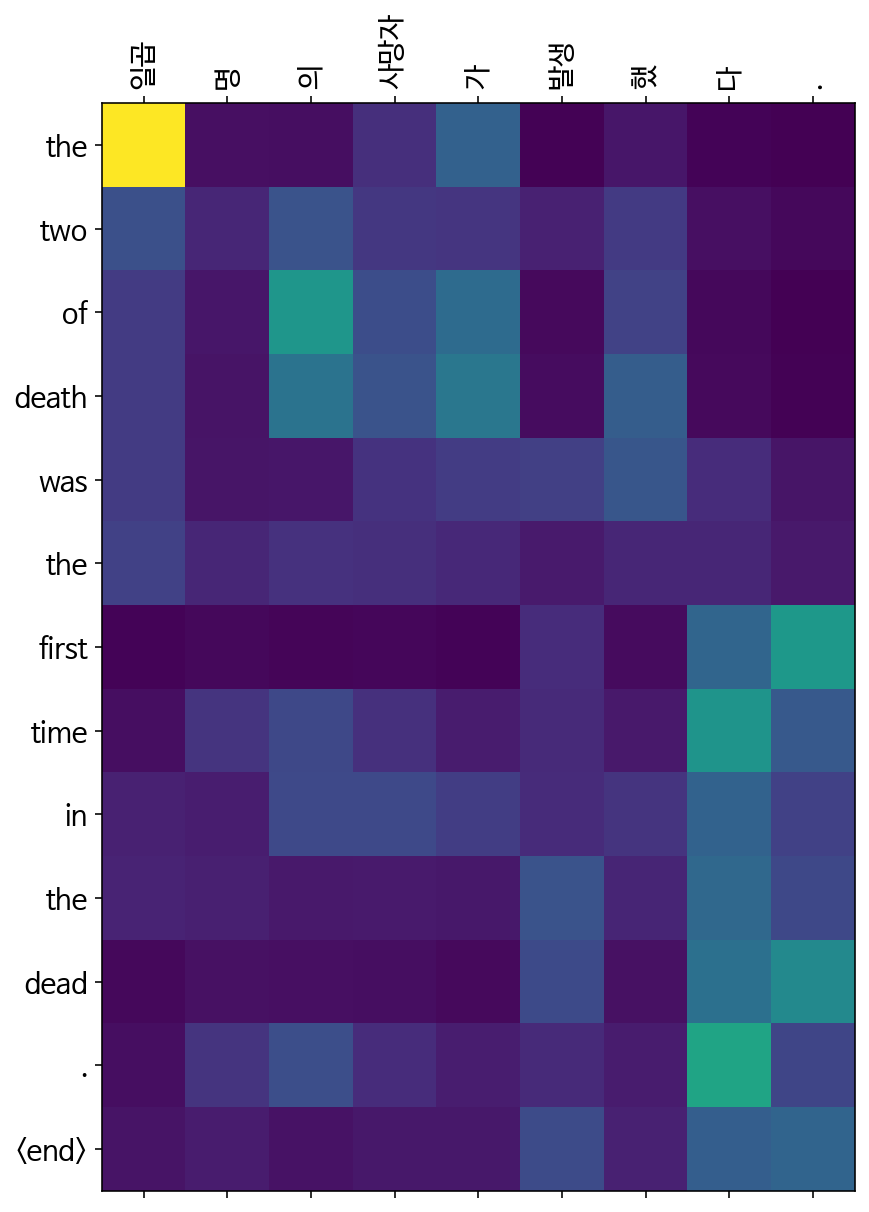

Epoch 32: 100%|██████████| 254/254 [00:55<00:00,  4.55it/s, Loss 0.7494]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new york . <end> 


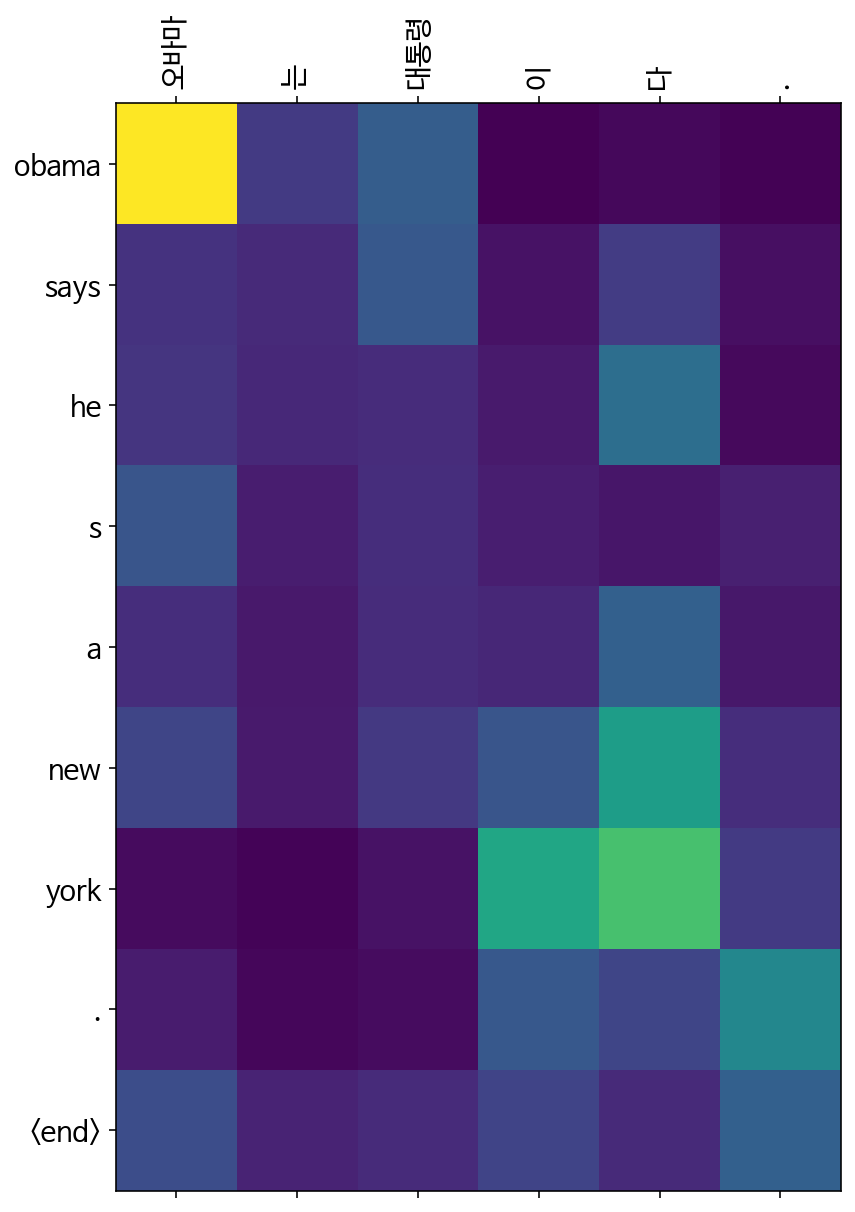

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


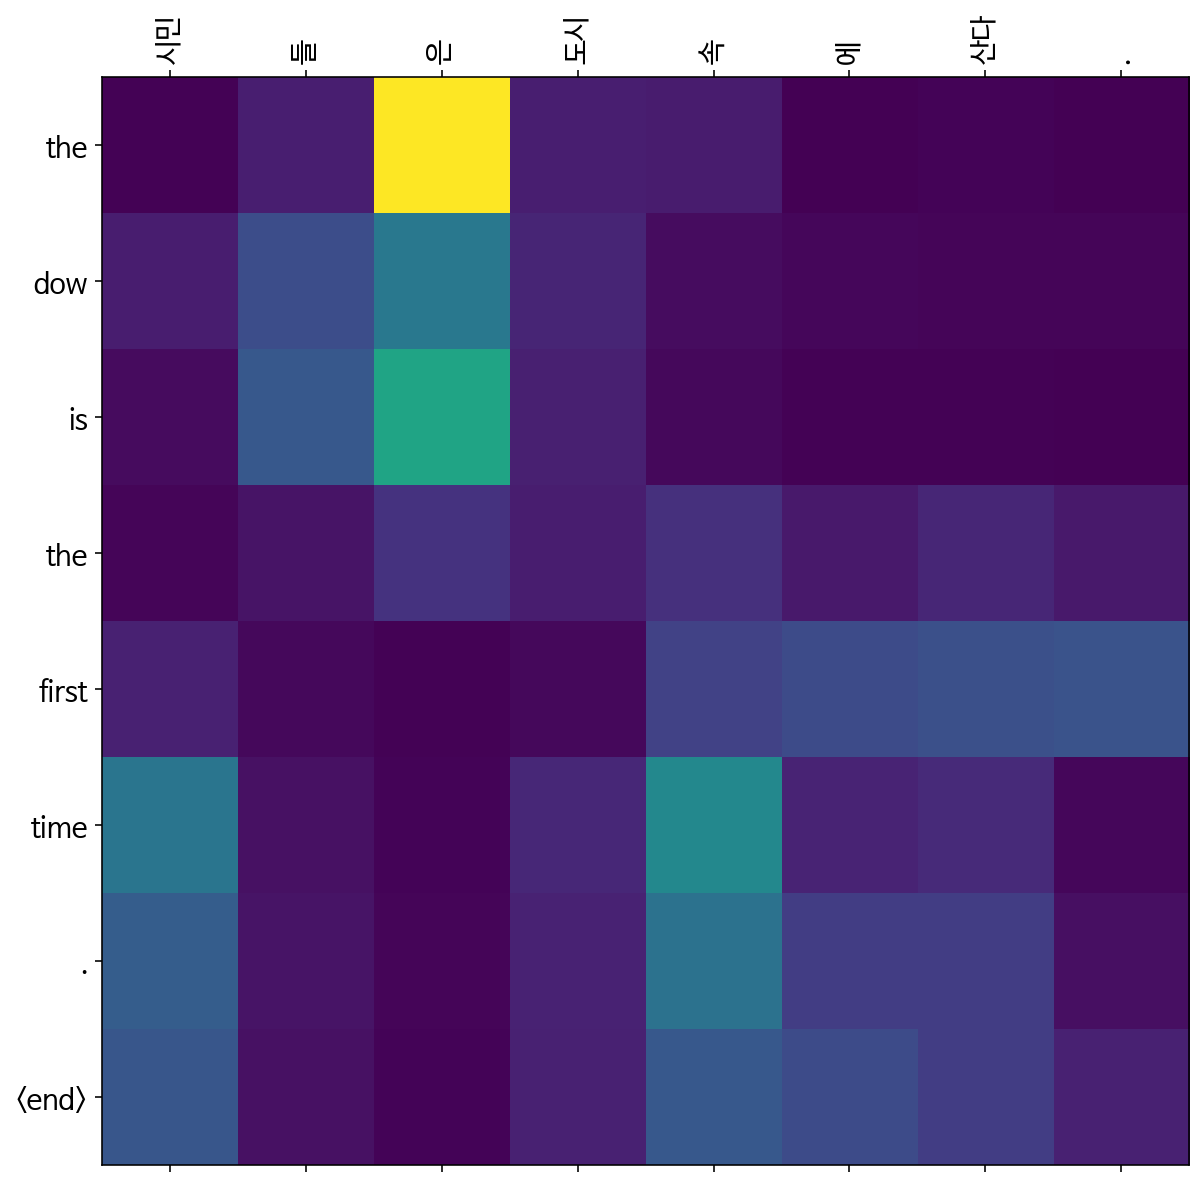

Input: 커피 는 필요 없 다 .
Predicted translation: the baby s a new york s margin is a lot of the best drama . <end> 


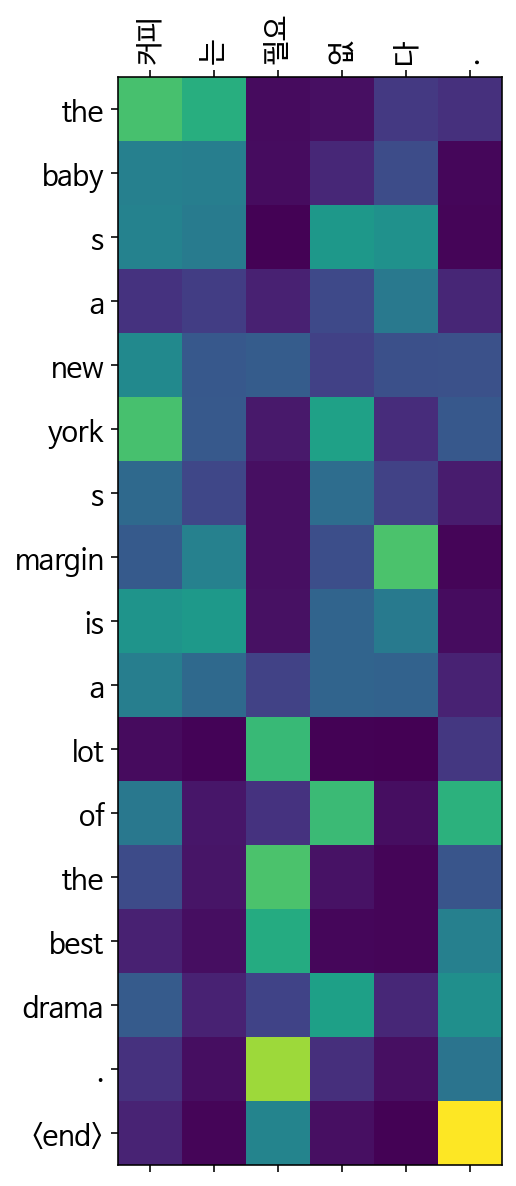

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were wounded . <end> 


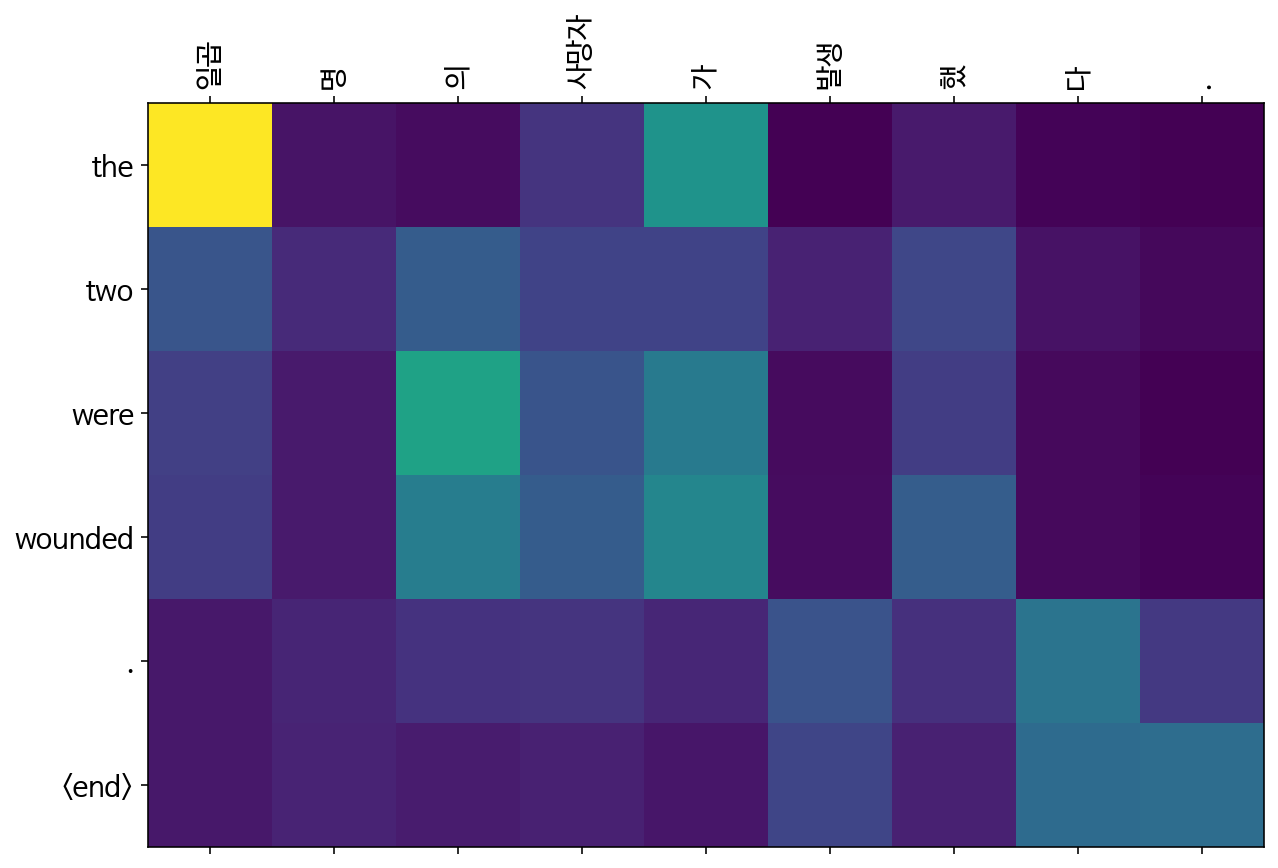

Epoch 33: 100%|██████████| 254/254 [00:56<00:00,  4.49it/s, Loss 0.7352]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york . <end> 


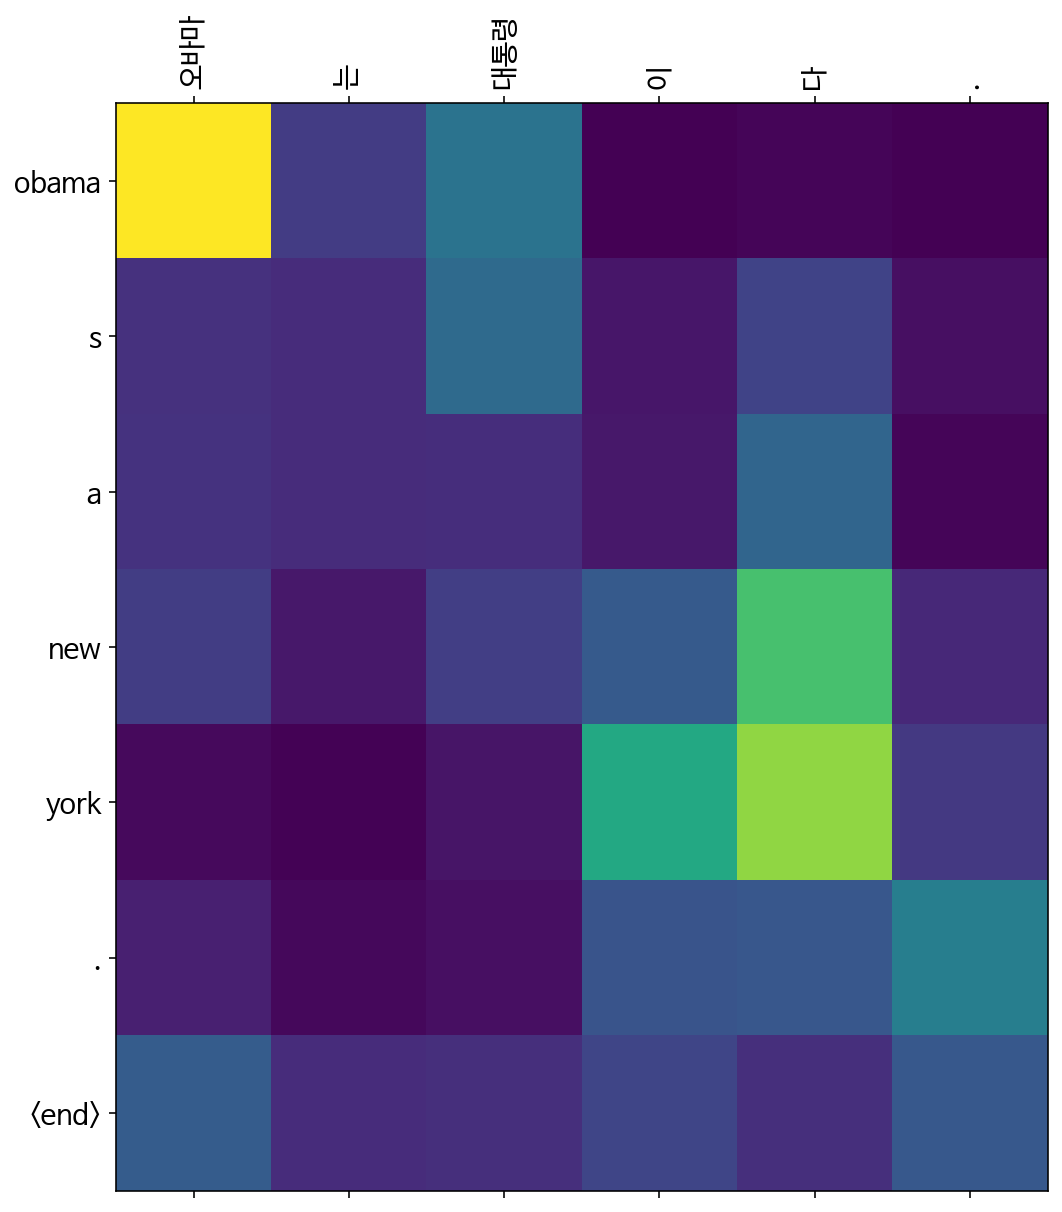

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the 


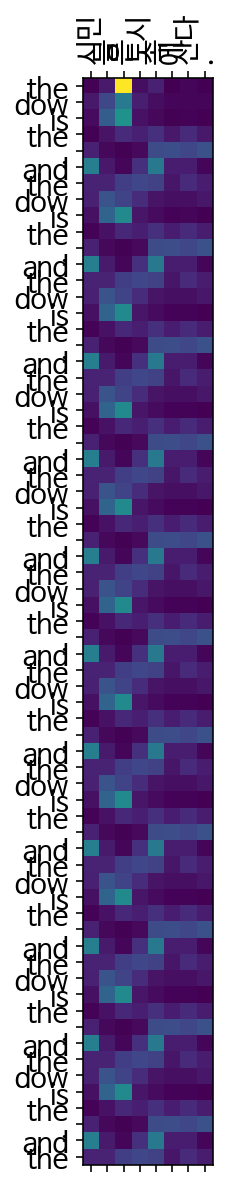

Input: 커피 는 필요 없 다 .
Predicted translation: this is not enough . <end> 


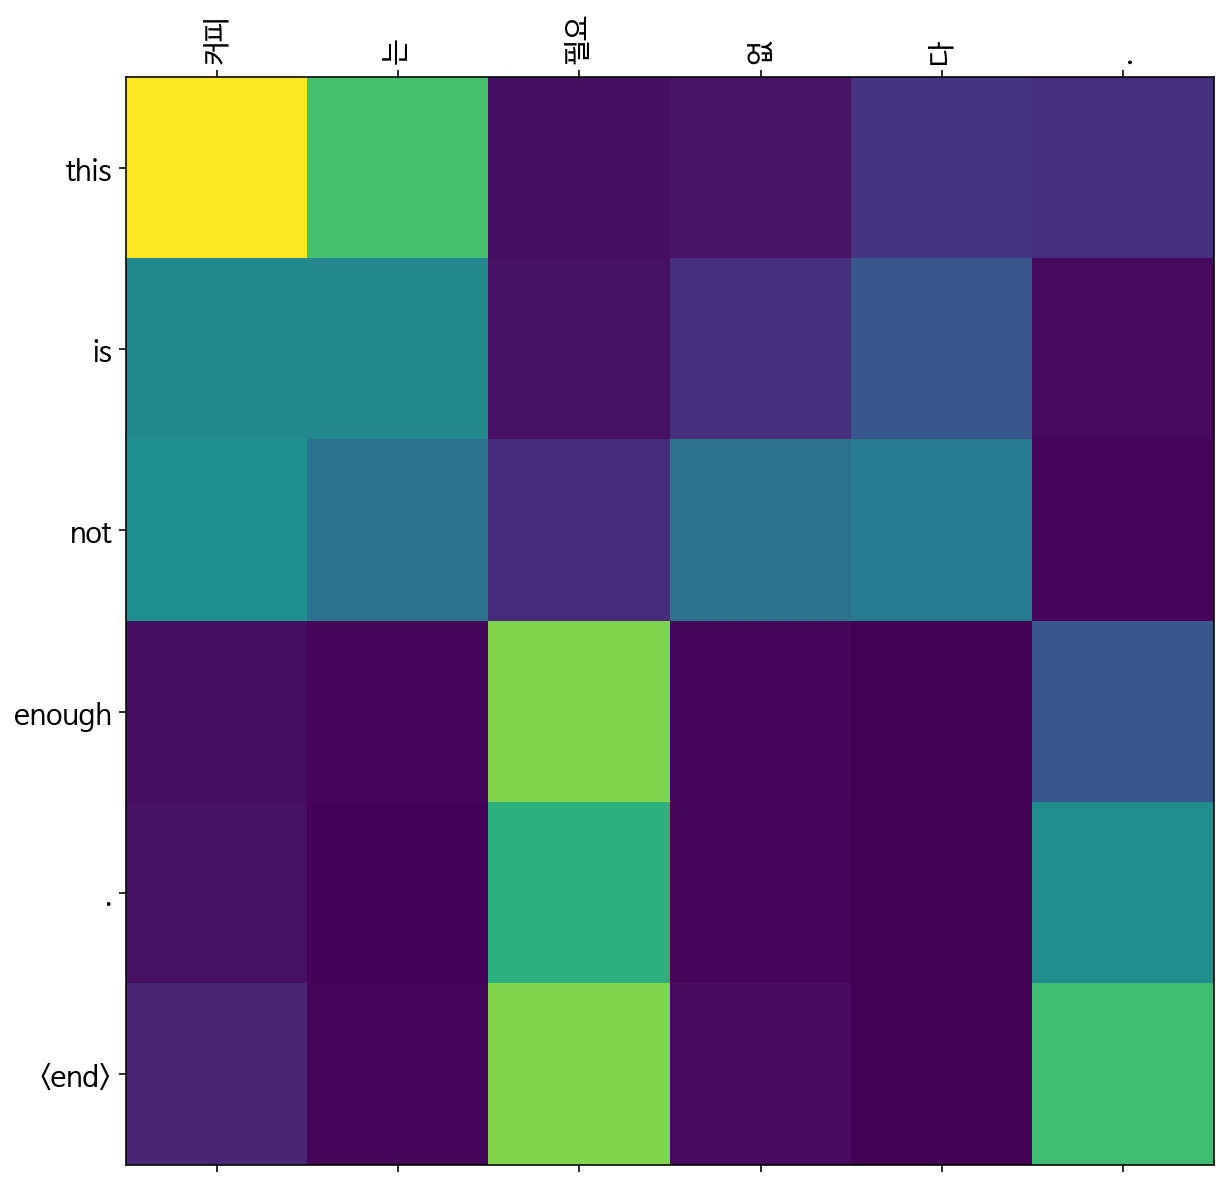

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were wounded . <end> 


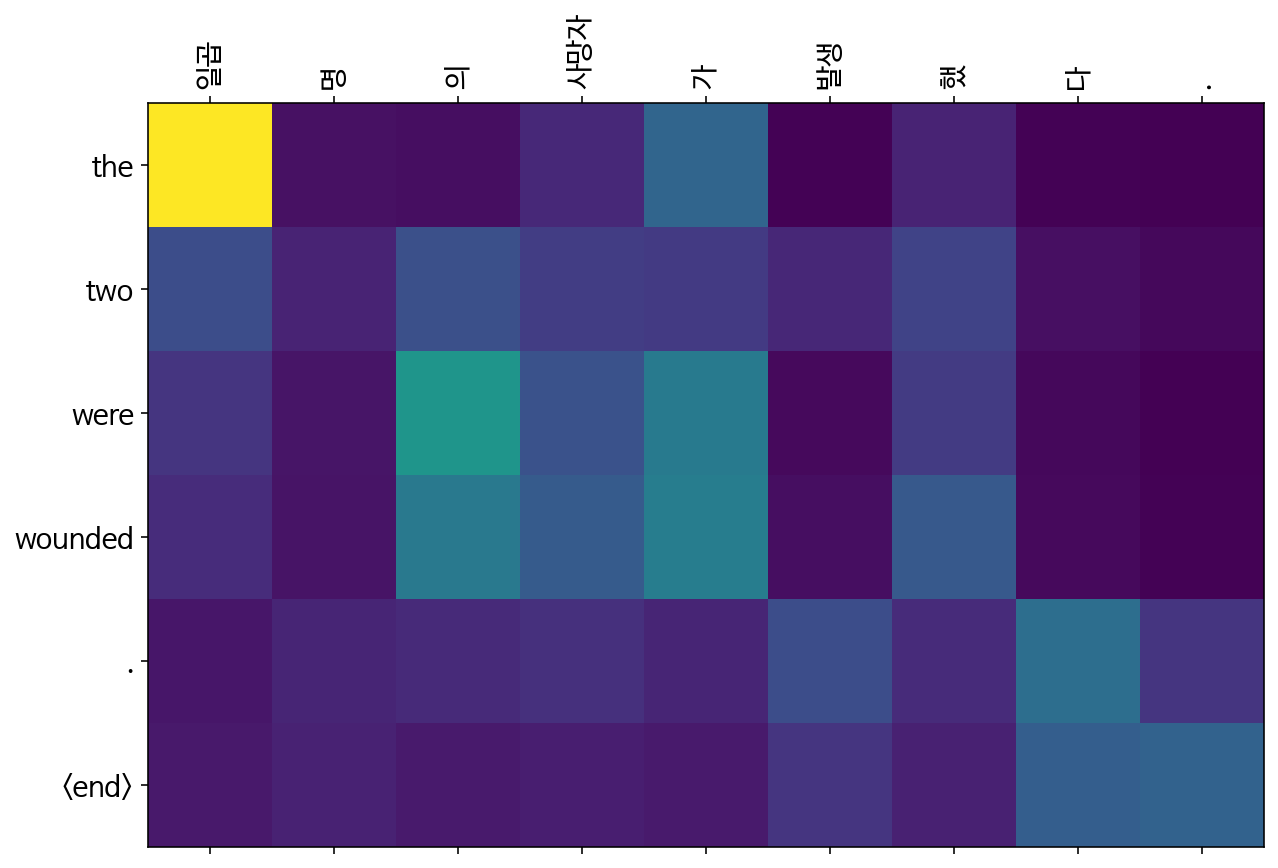

Epoch 34: 100%|██████████| 254/254 [00:56<00:00,  4.49it/s, Loss 0.7218]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new york . <end> 


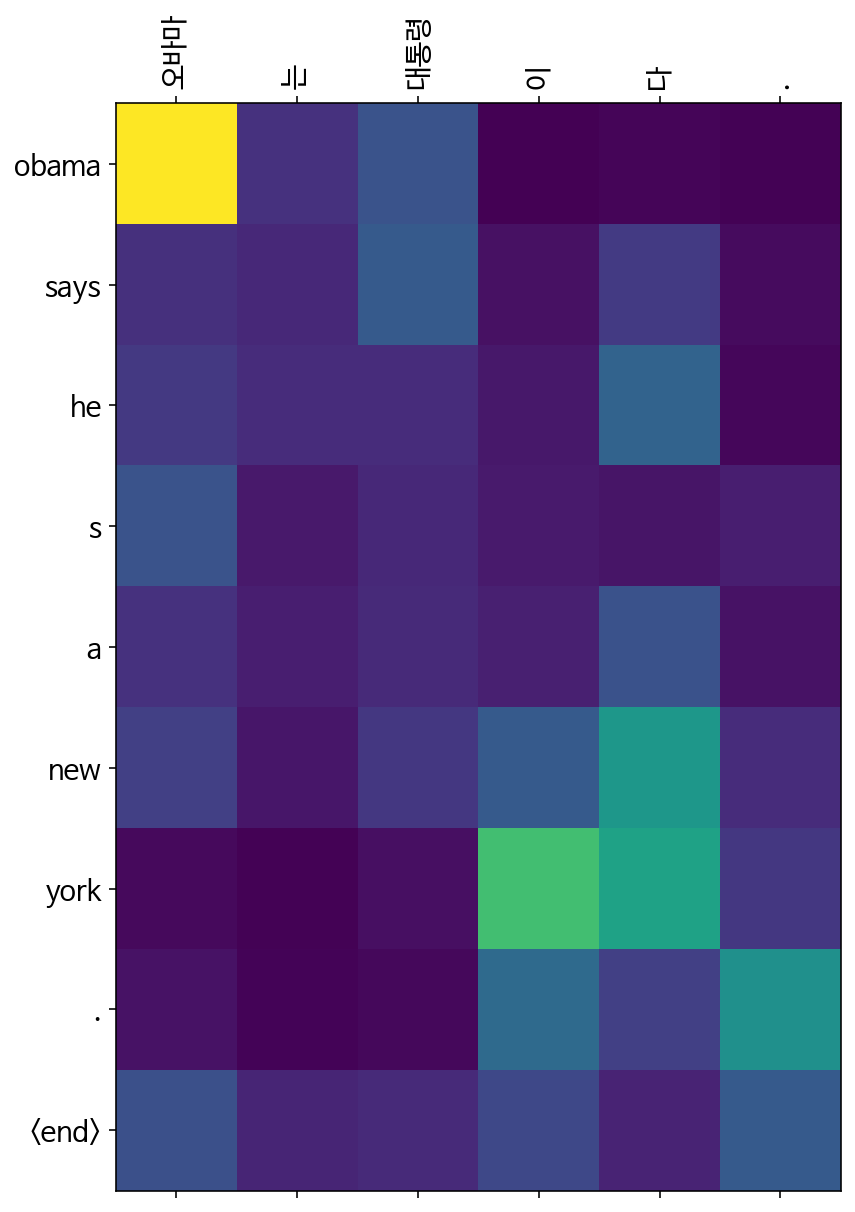

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the dow is the , and the 


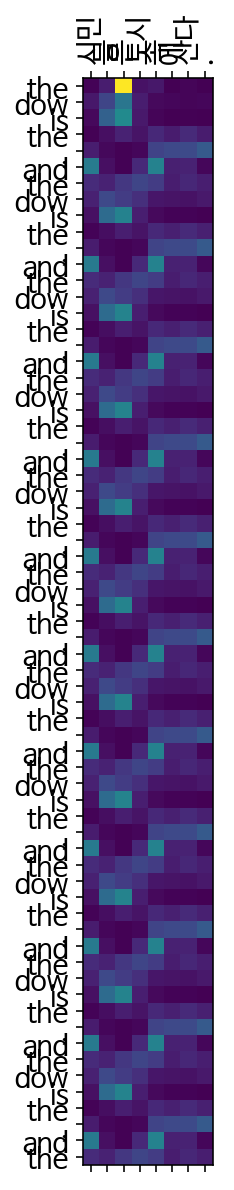

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your own . <end> 


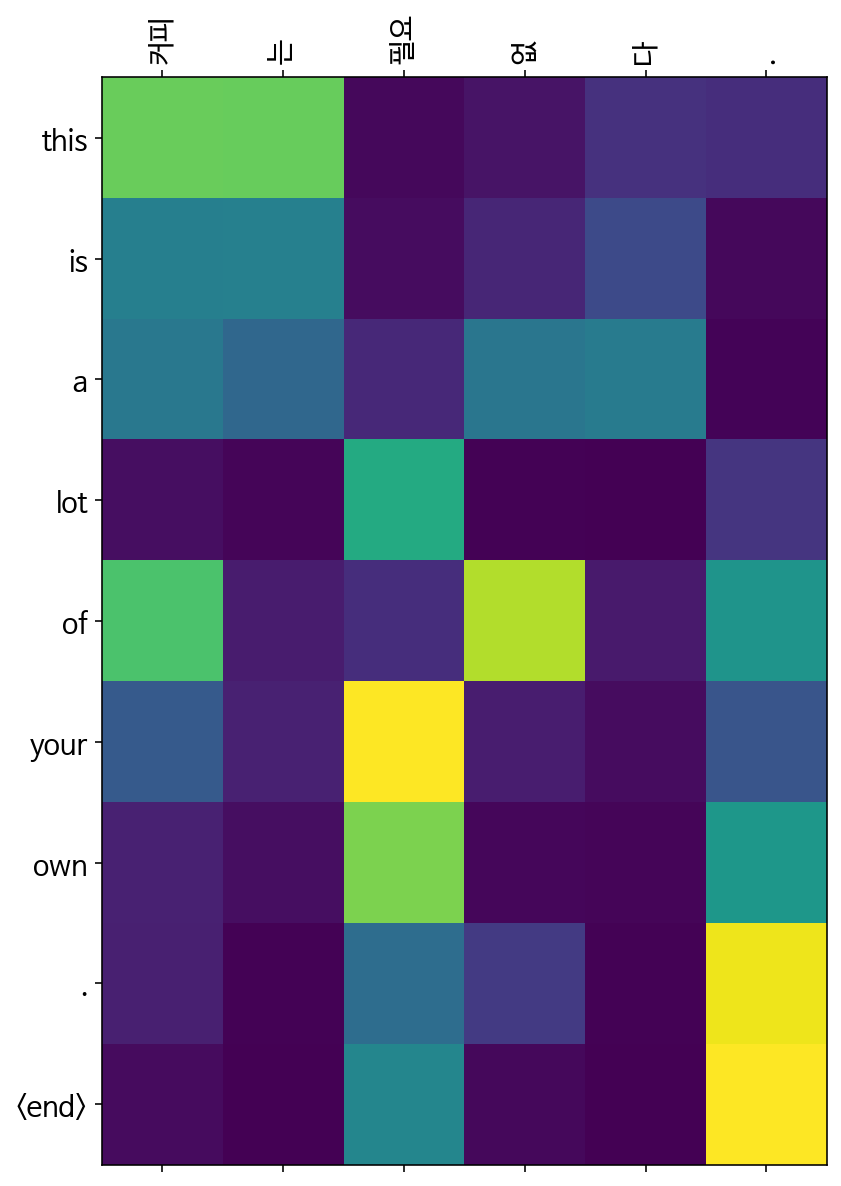

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the victims of the attack was not to the attack . <end> 


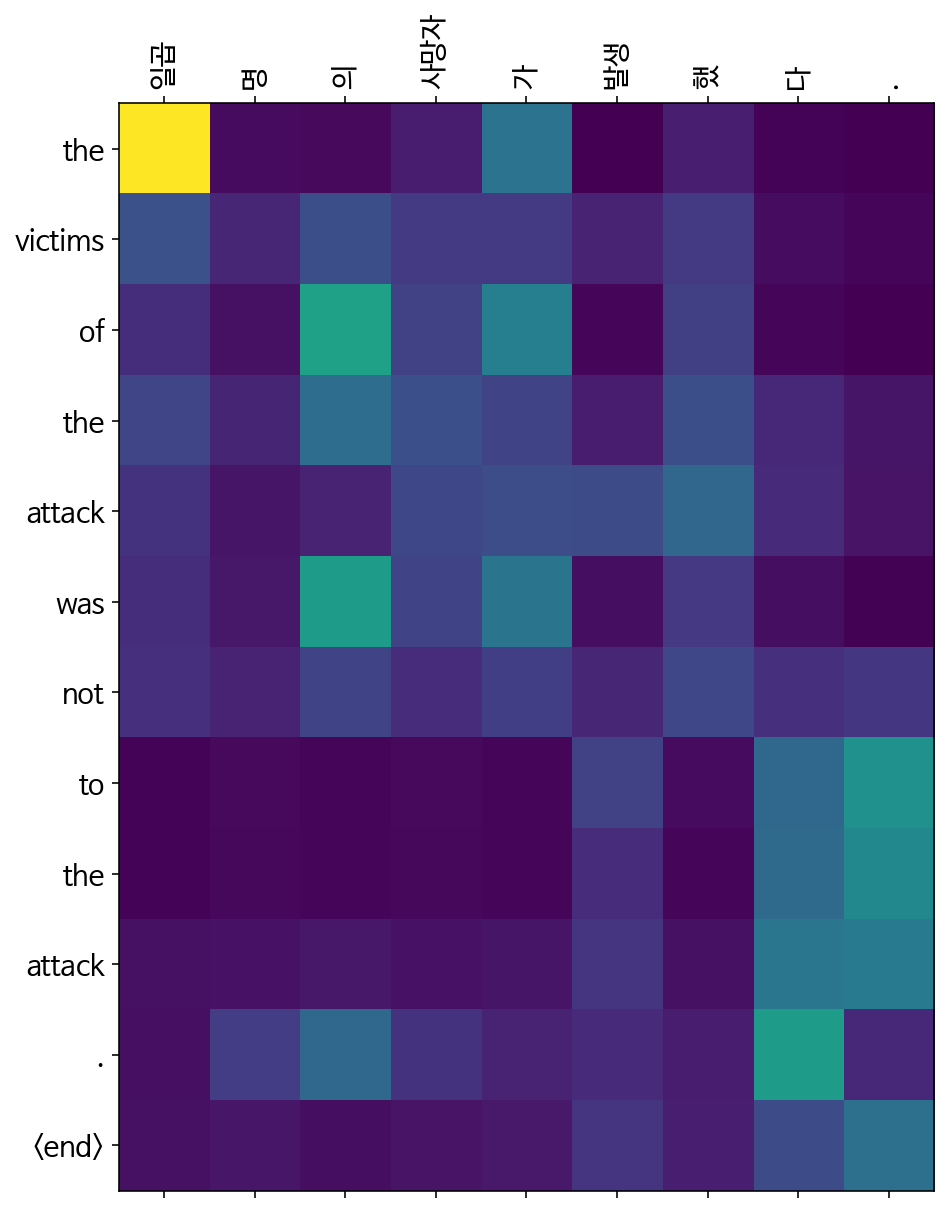

Epoch 35: 100%|██████████| 254/254 [00:56<00:00,  4.52it/s, Loss 0.7094]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york s health . <end> 


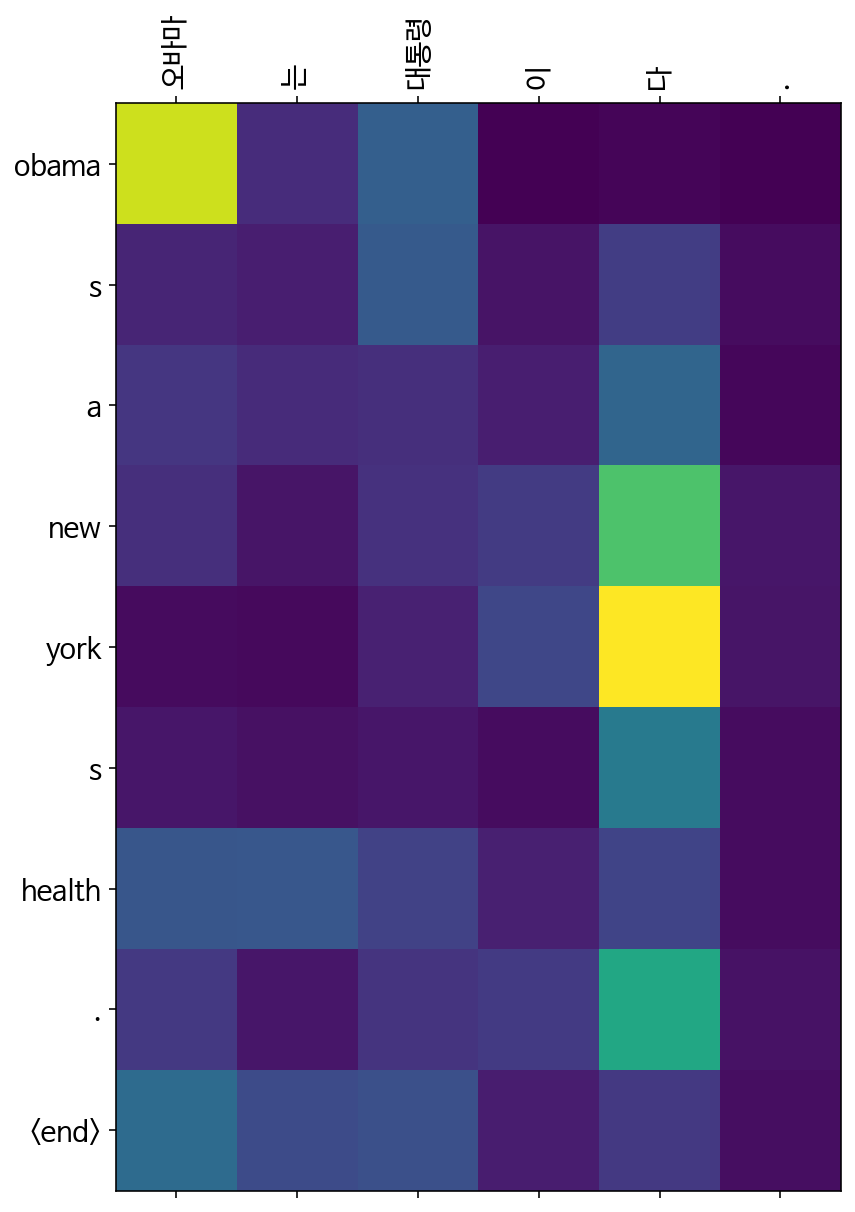

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is in the first time . <end> 


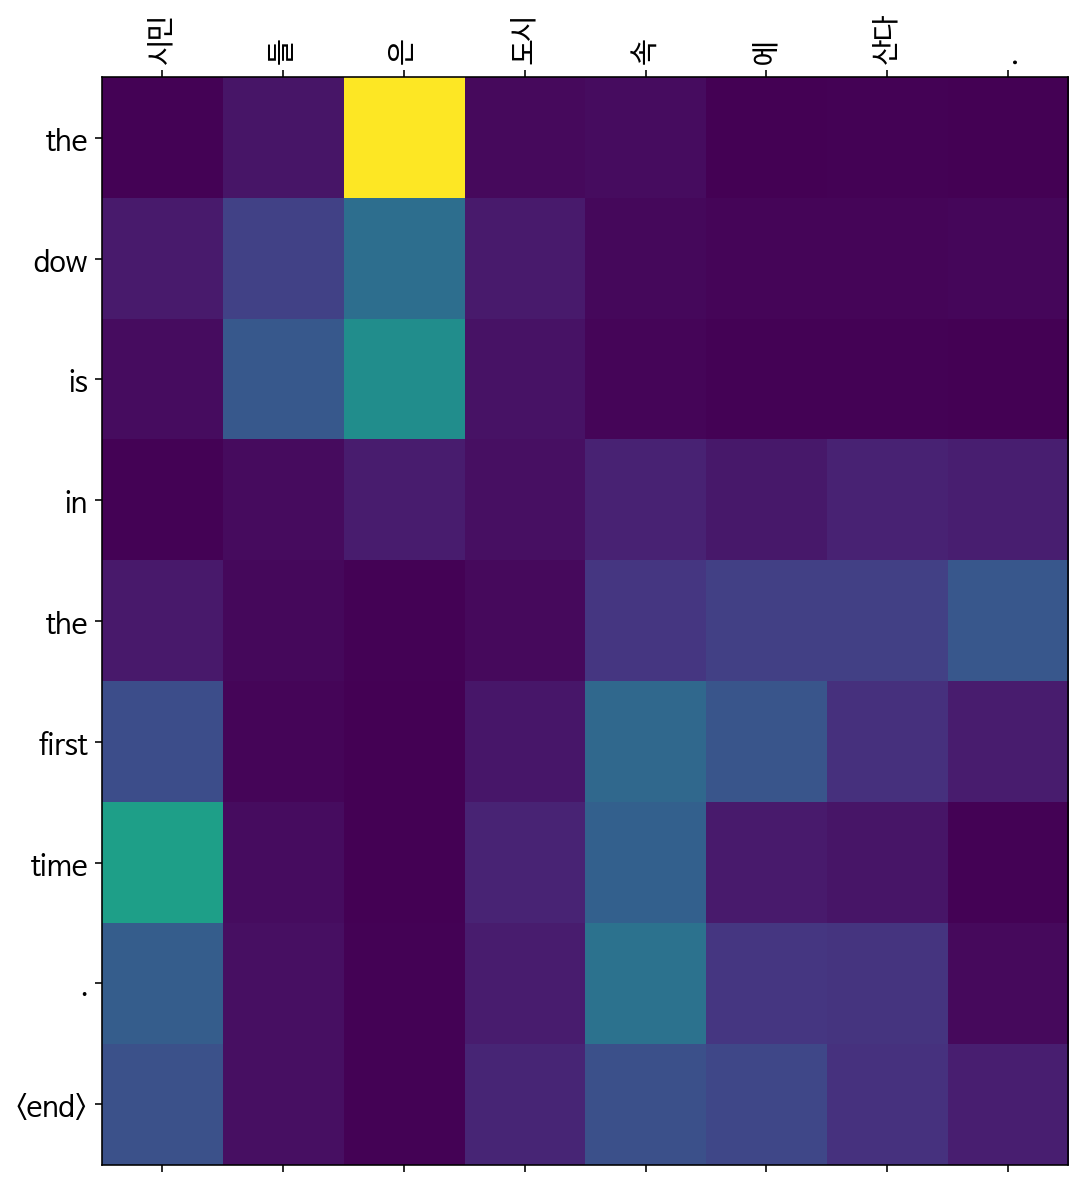

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of the first time you can be a lot of the first time you can be a lot of the first time you can be a lot of the first time you can be a lot of the first time you can be a lot of the first time you can be a lot of the first time you can be a lot 


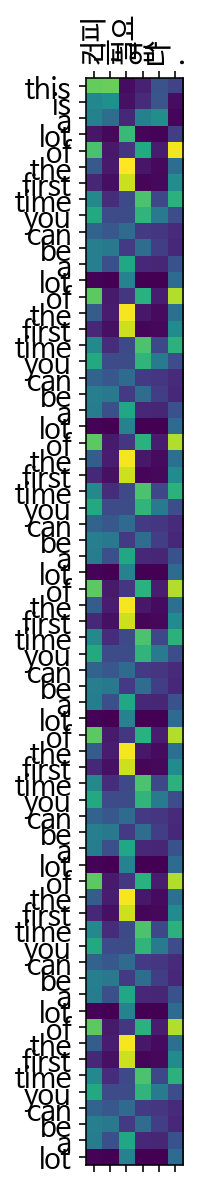

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two were injured , the two 


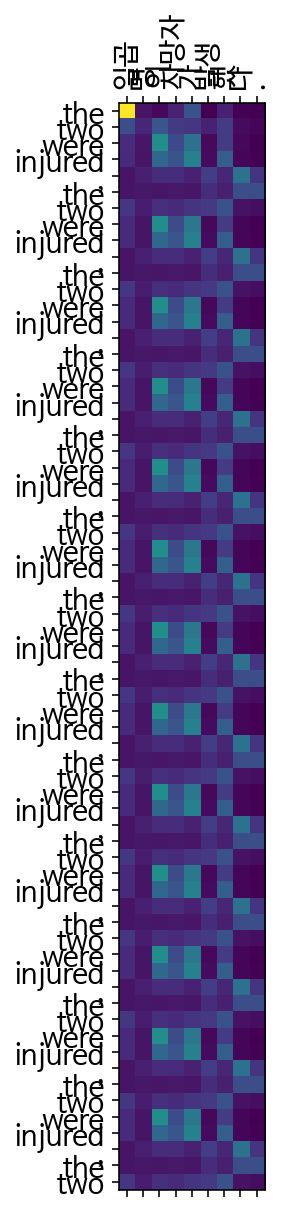

Epoch 36: 100%|██████████| 254/254 [00:56<00:00,  4.47it/s, Loss 0.6978]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new york . <end> 


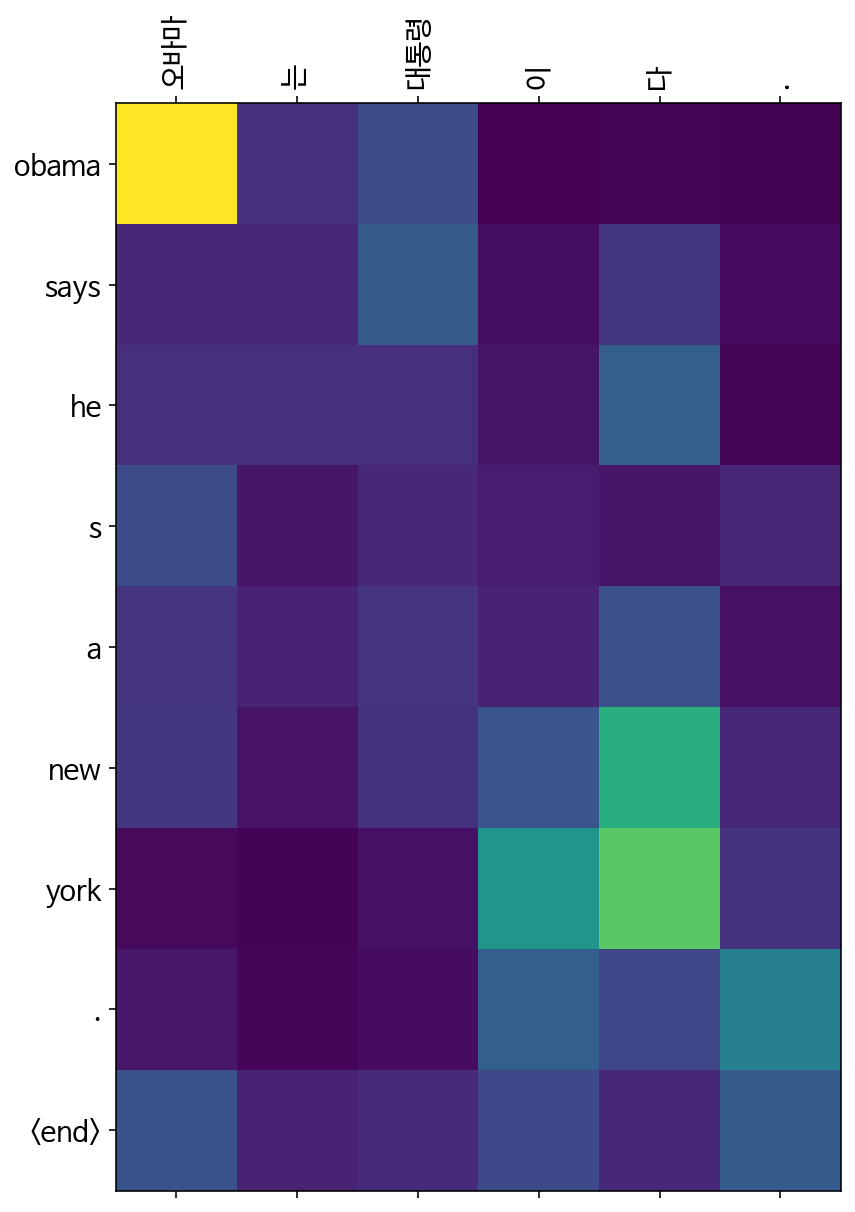

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


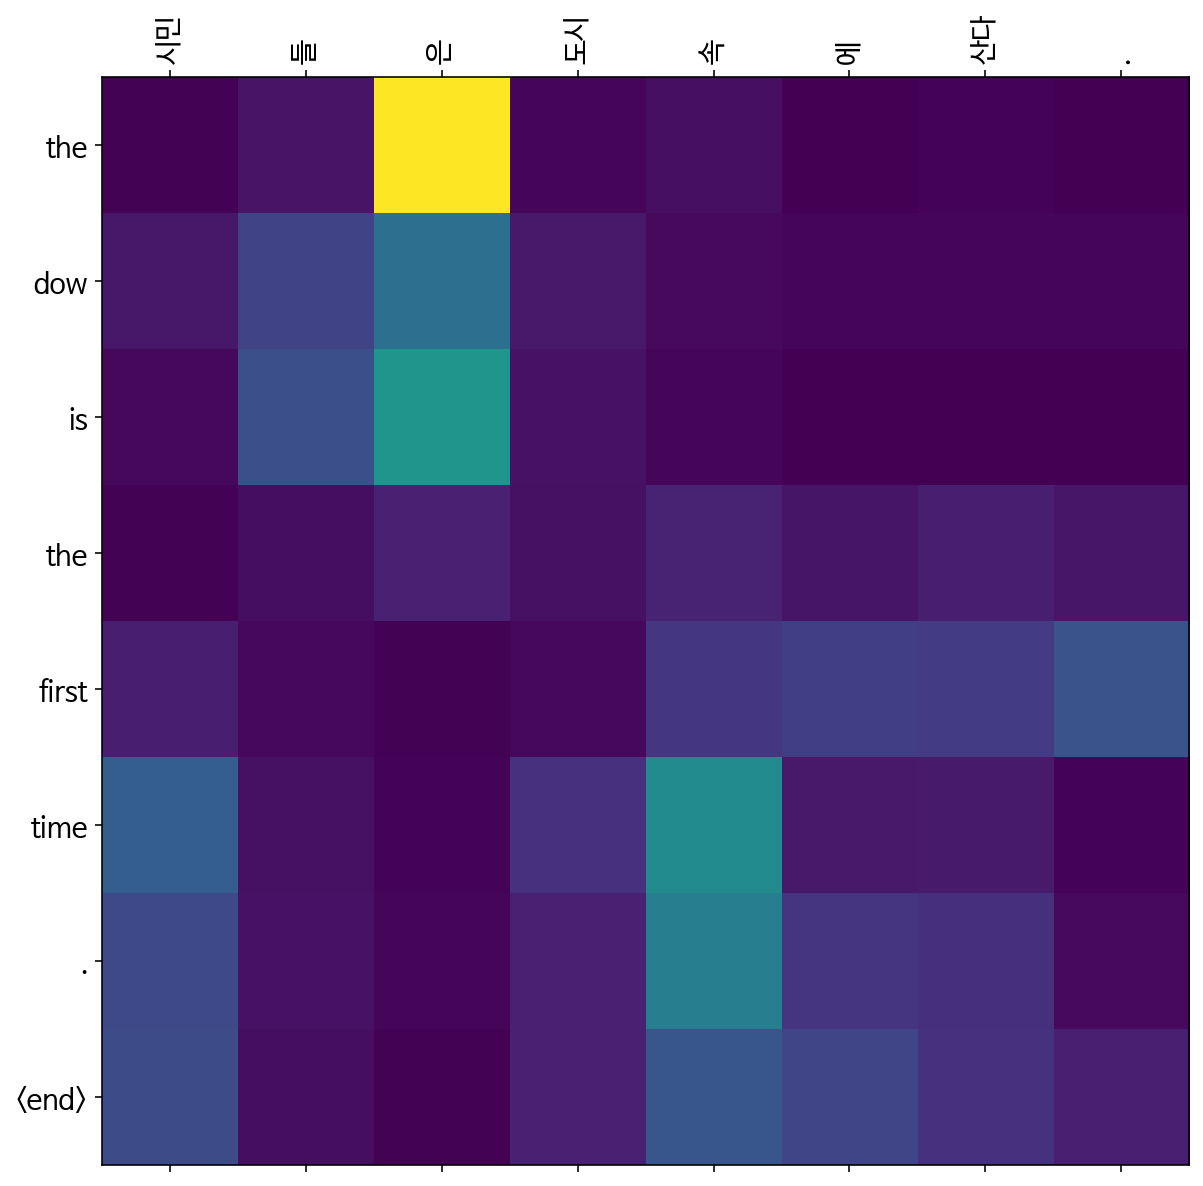

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your own . <end> 


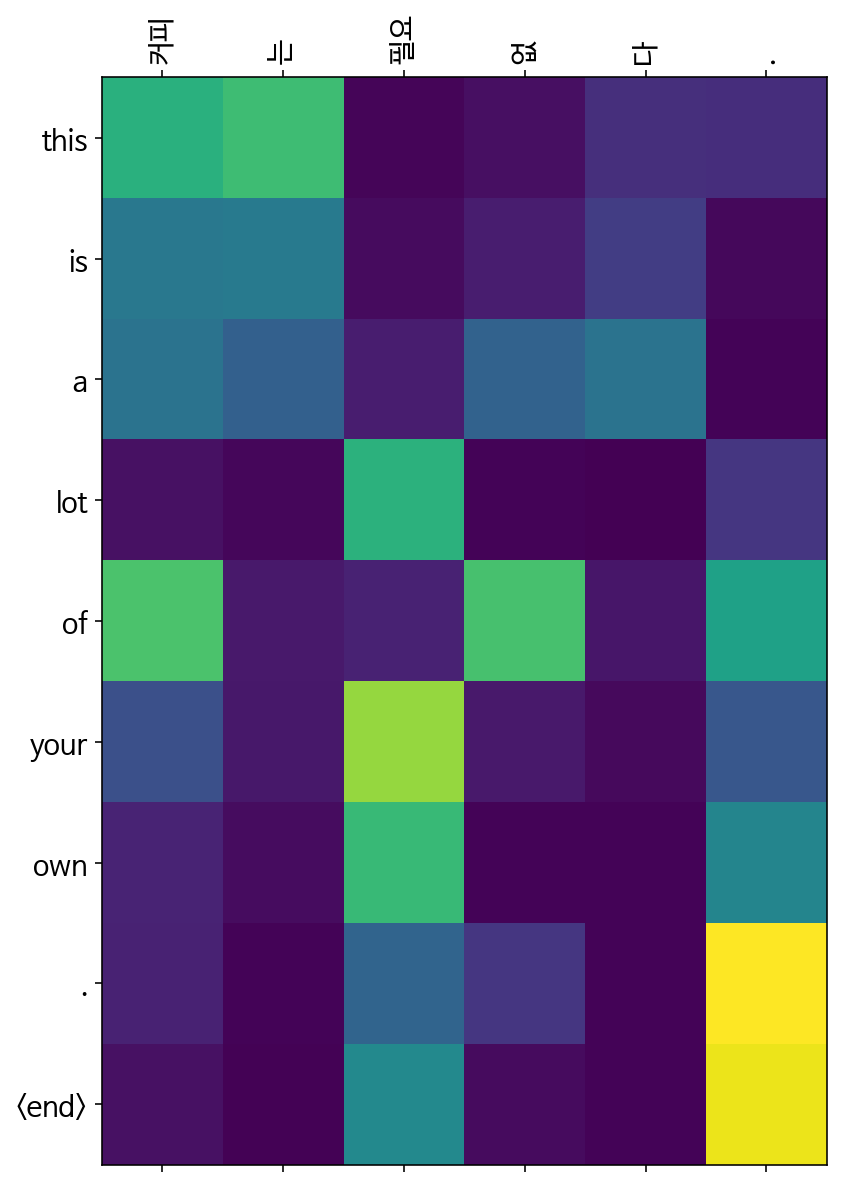

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were injured , the ministry of the attack occurred in the same . <end> 


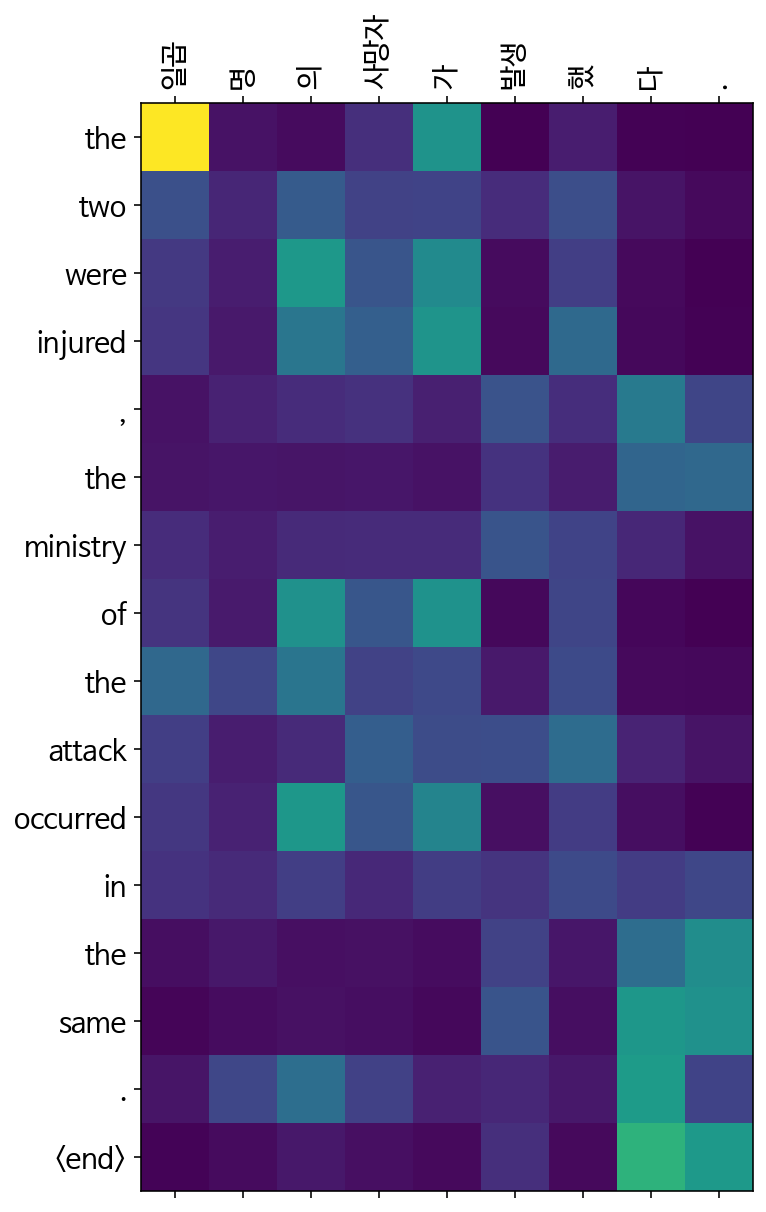

Epoch 37: 100%|██████████| 254/254 [00:56<00:00,  4.53it/s, Loss 0.6843]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york s health officials say obama s health . <end> 


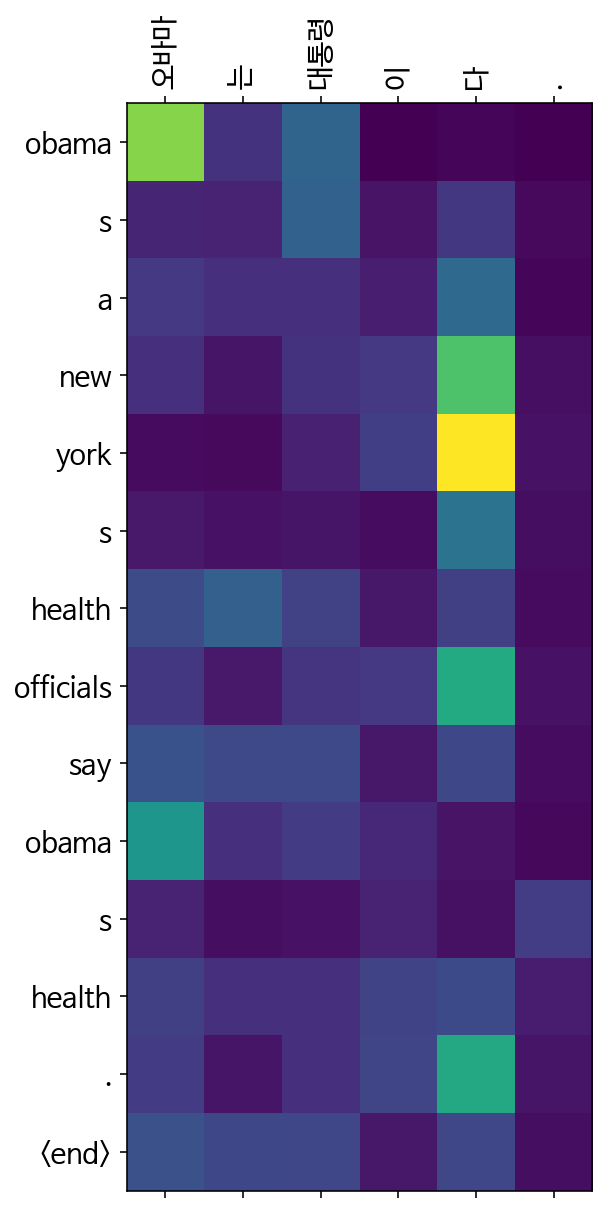

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is in the of the first time . <end> 


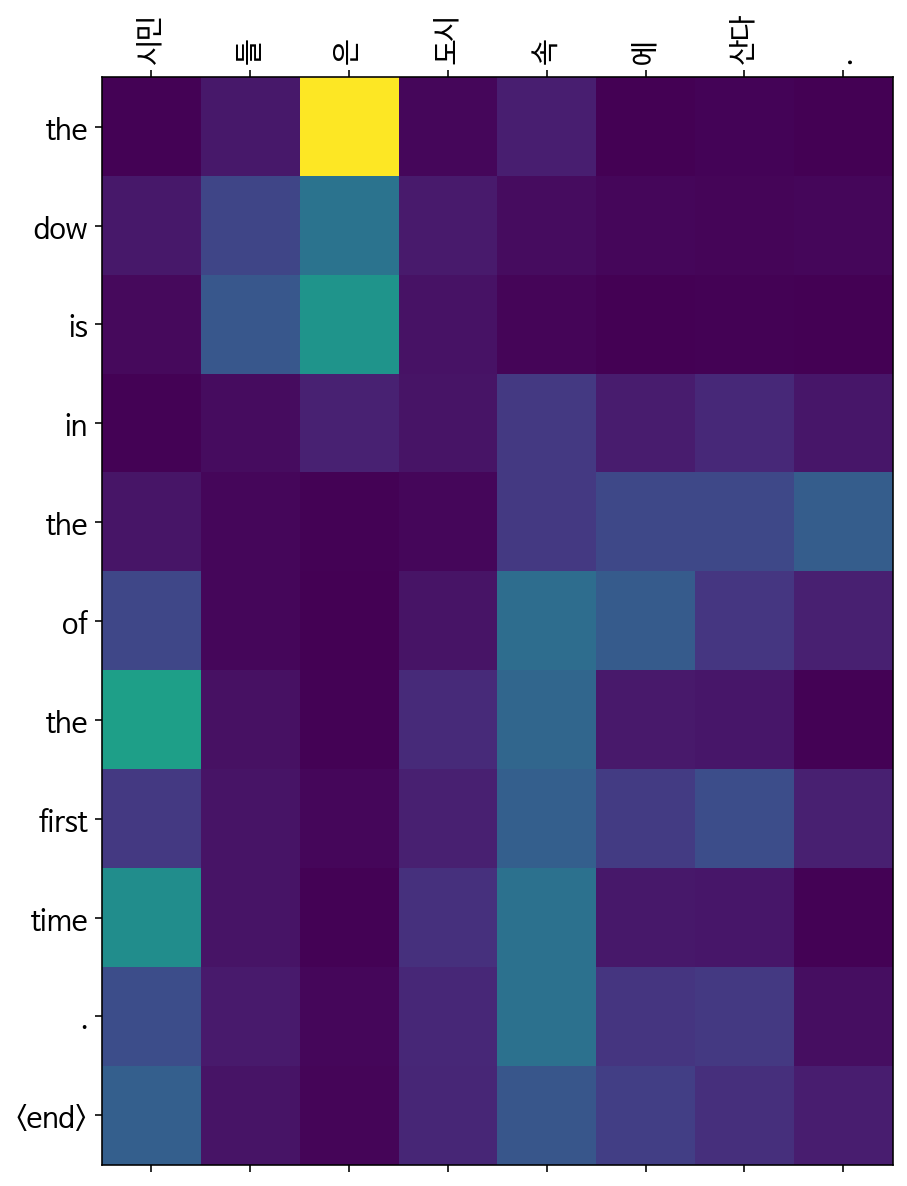

Input: 커피 는 필요 없 다 .
Predicted translation: this is not enough . <end> 


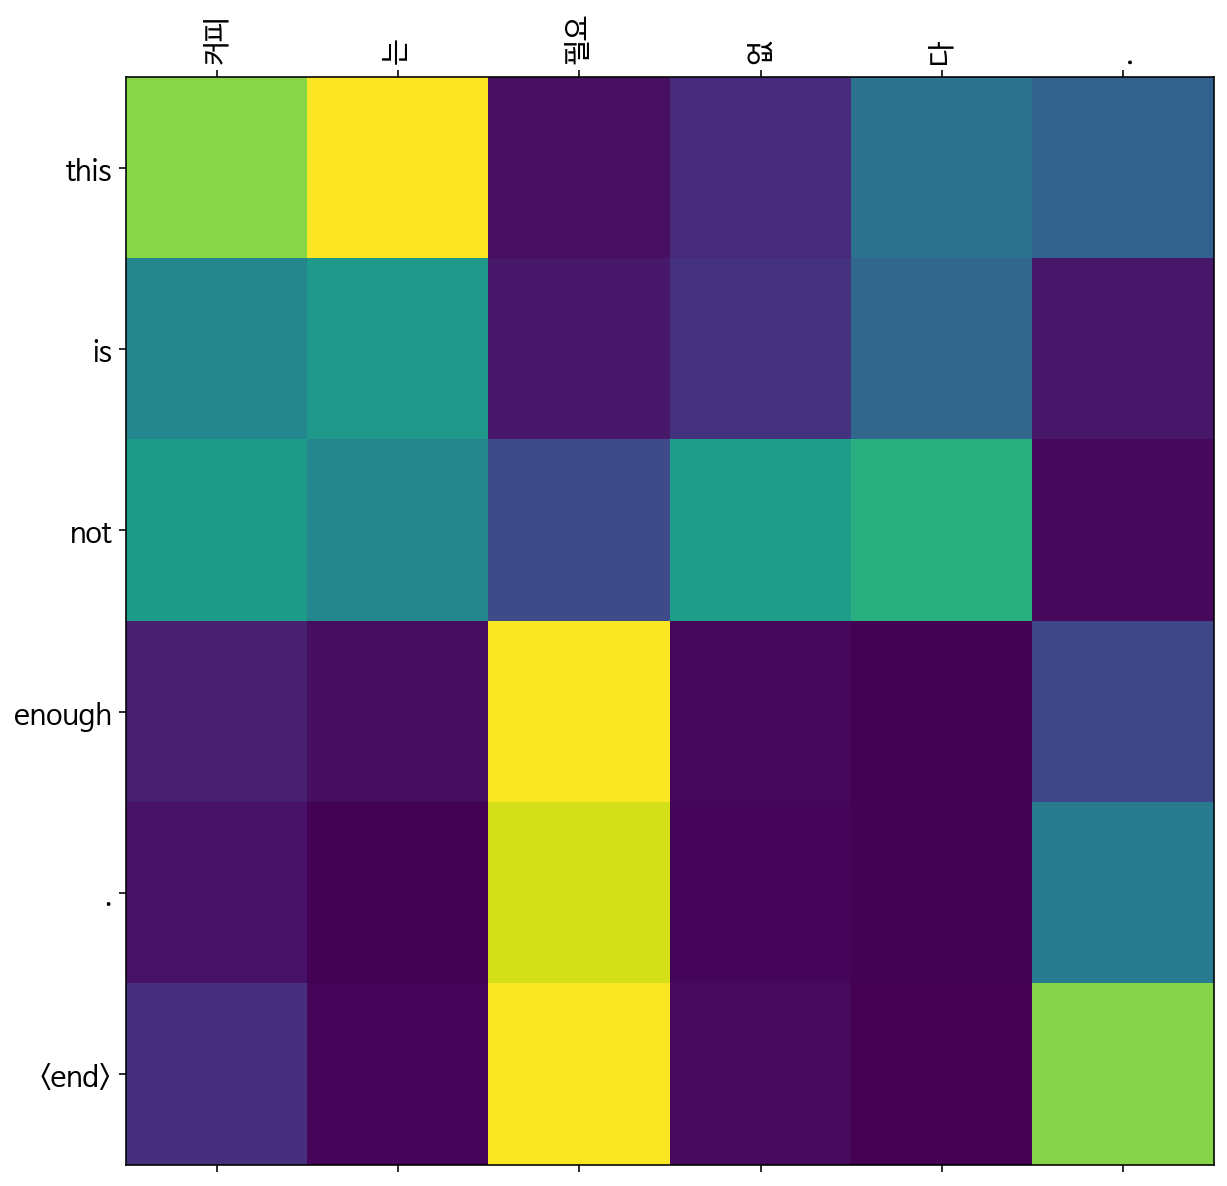

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were killed . <end> 


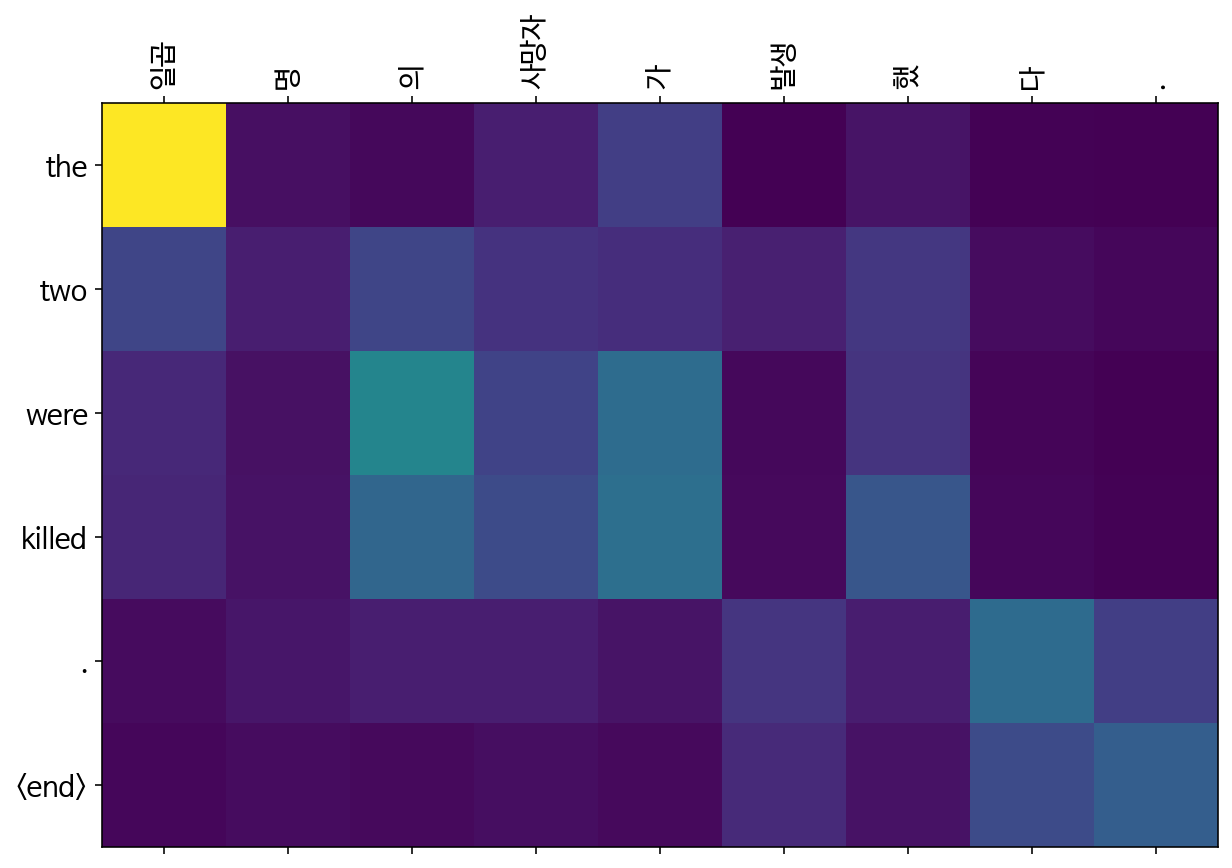

Epoch 38: 100%|██████████| 254/254 [00:56<00:00,  4.51it/s, Loss 0.6730]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new york . <end> 


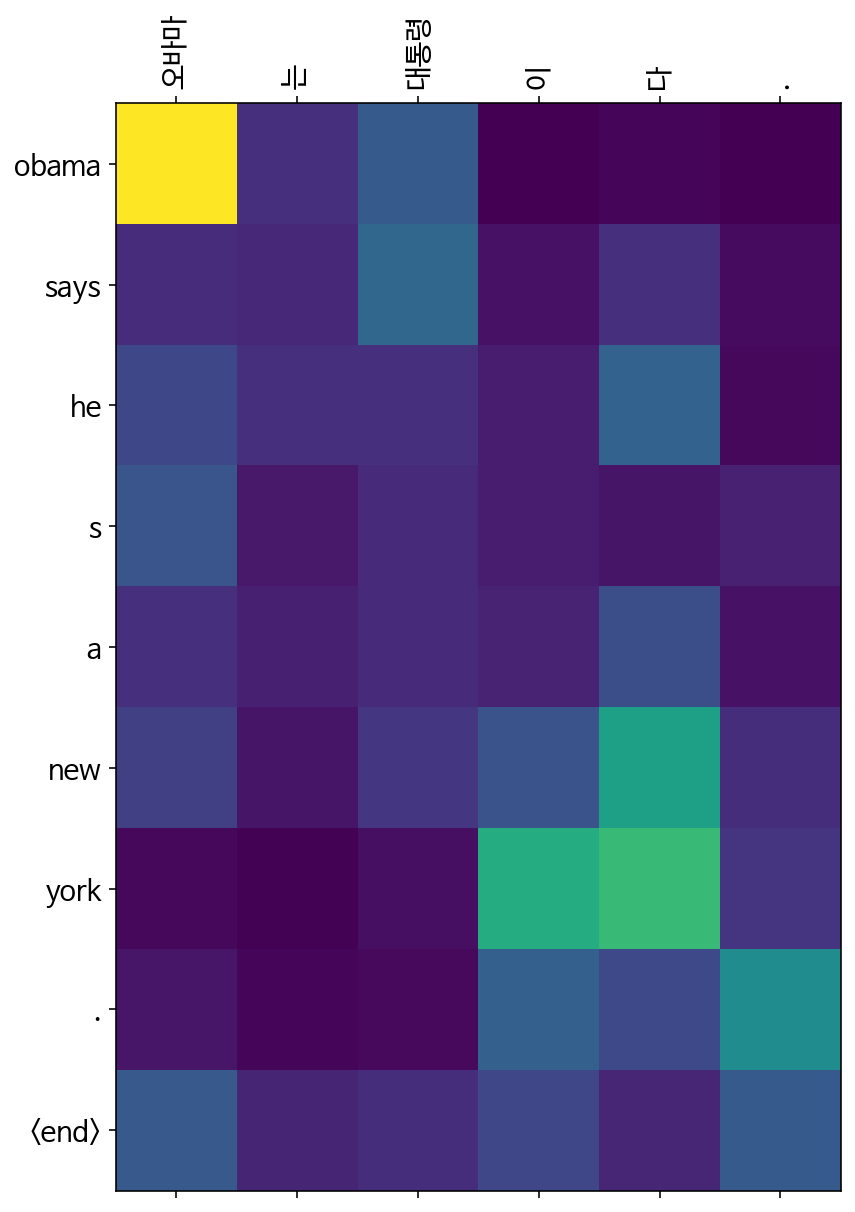

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is in the first time . <end> 


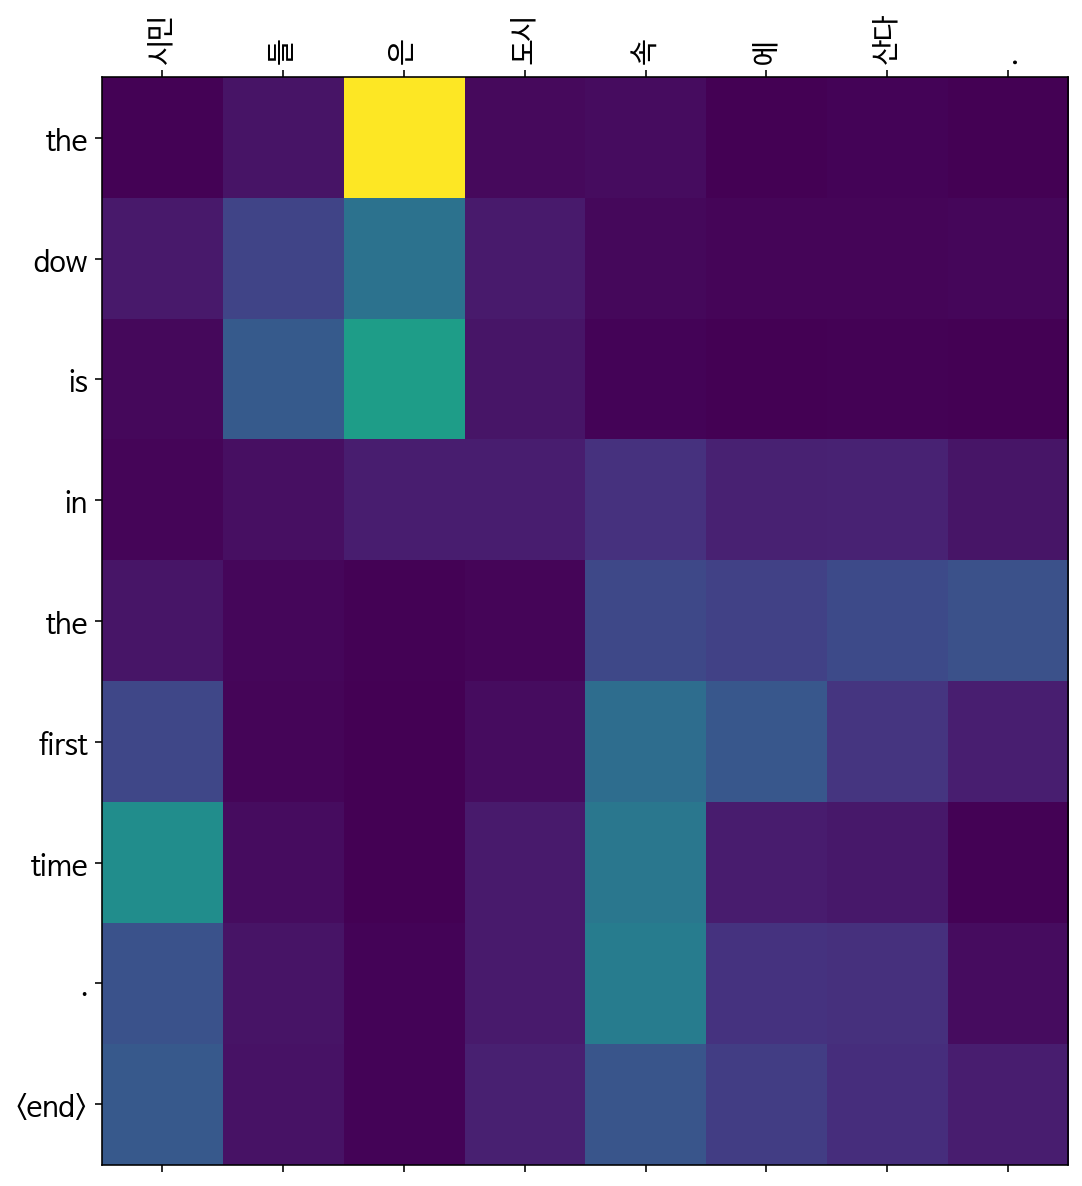

Input: 커피 는 필요 없 다 .
Predicted translation: this is also like it . <end> 


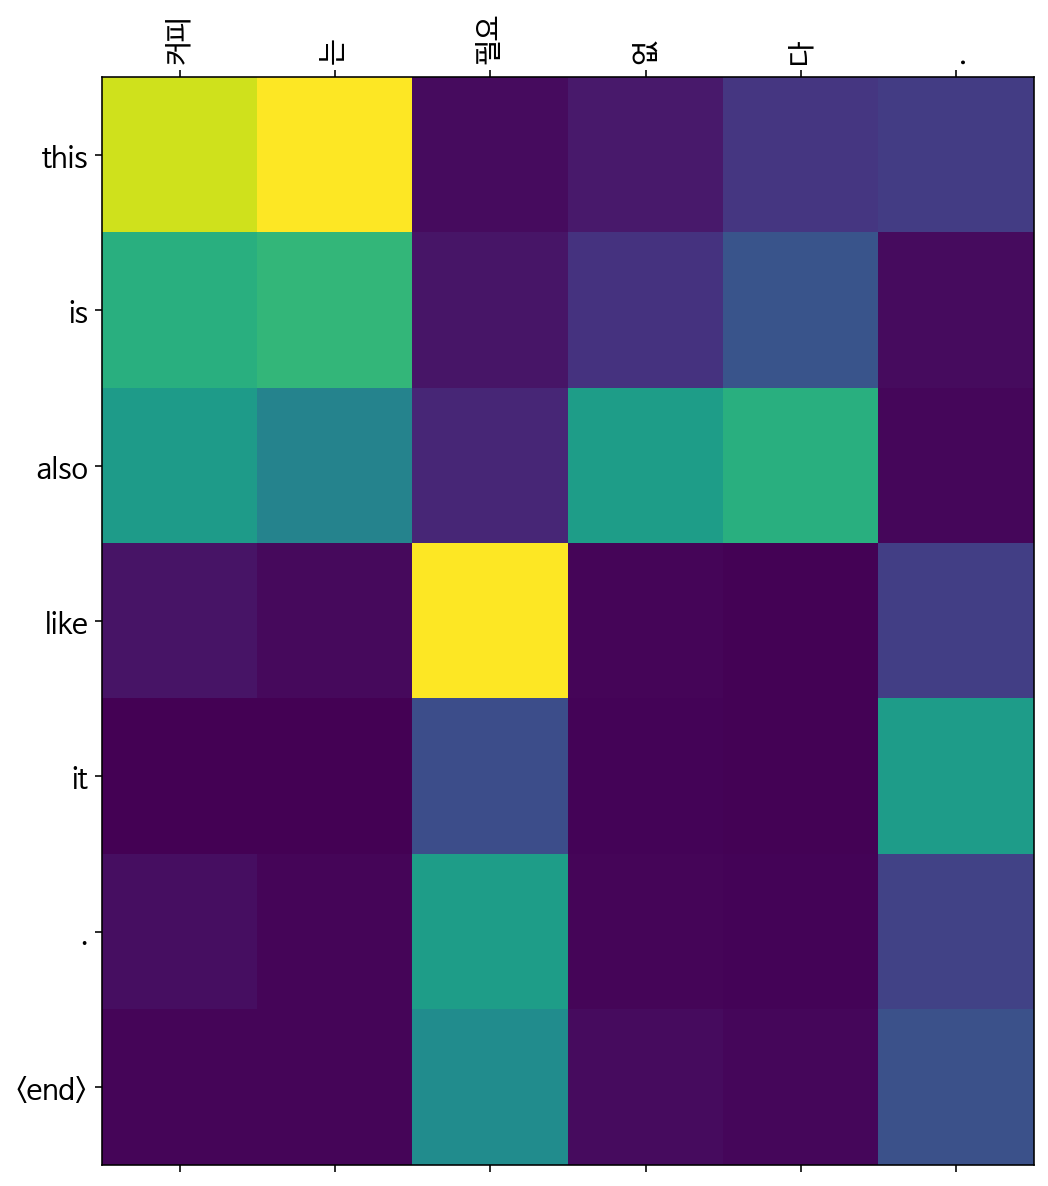

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the two were wounded . <end> 


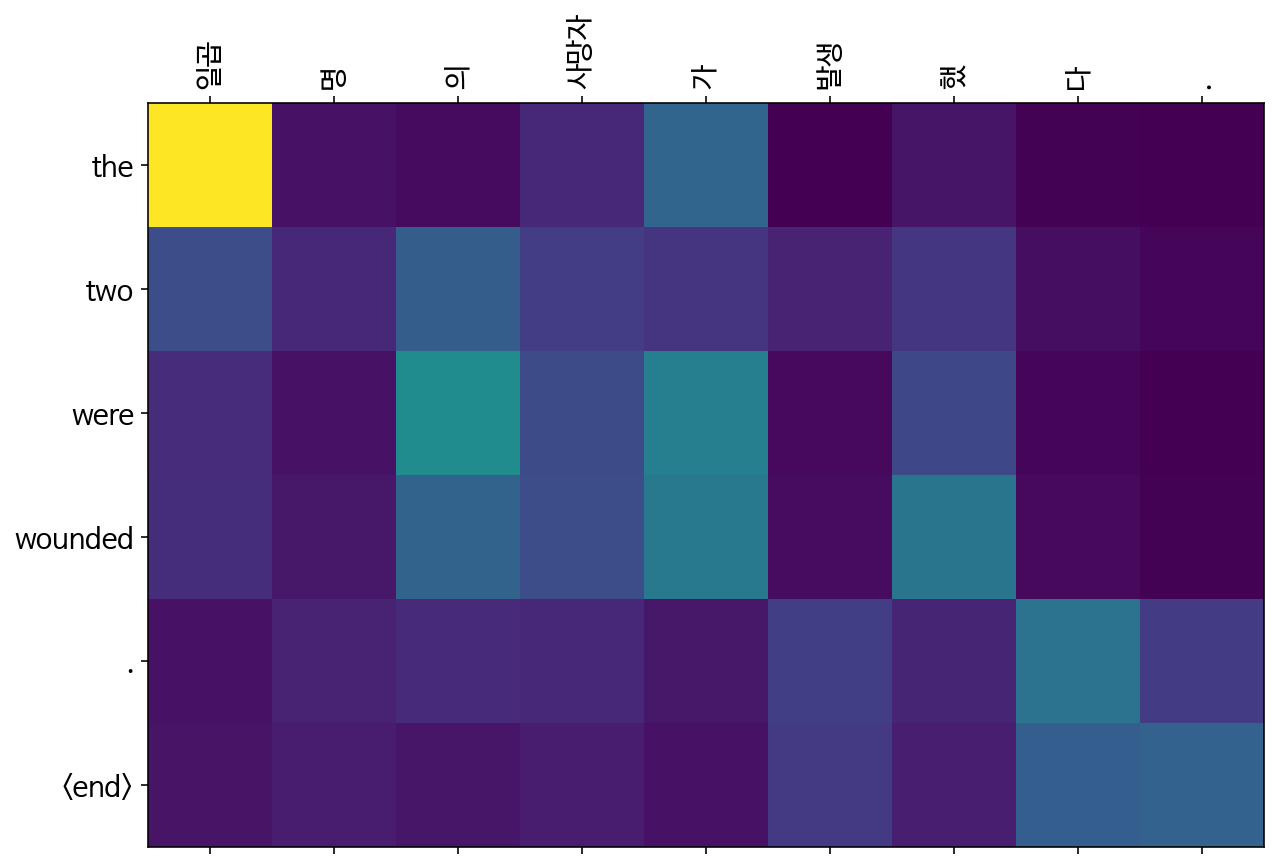

Epoch 39: 100%|██████████| 254/254 [00:56<00:00,  4.49it/s, Loss 0.6615]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama s a new york s obama 


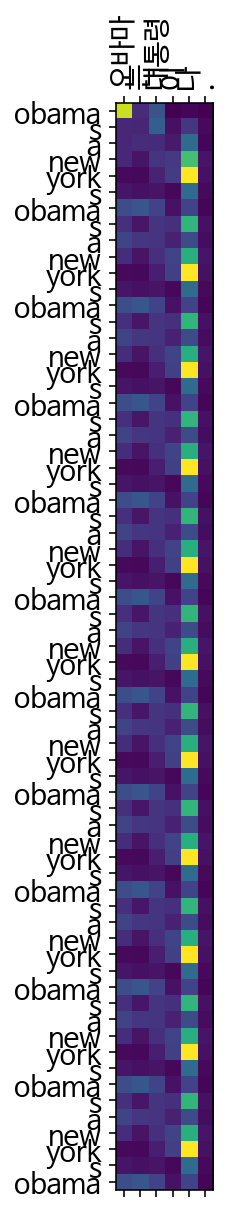

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is the first time . <end> 


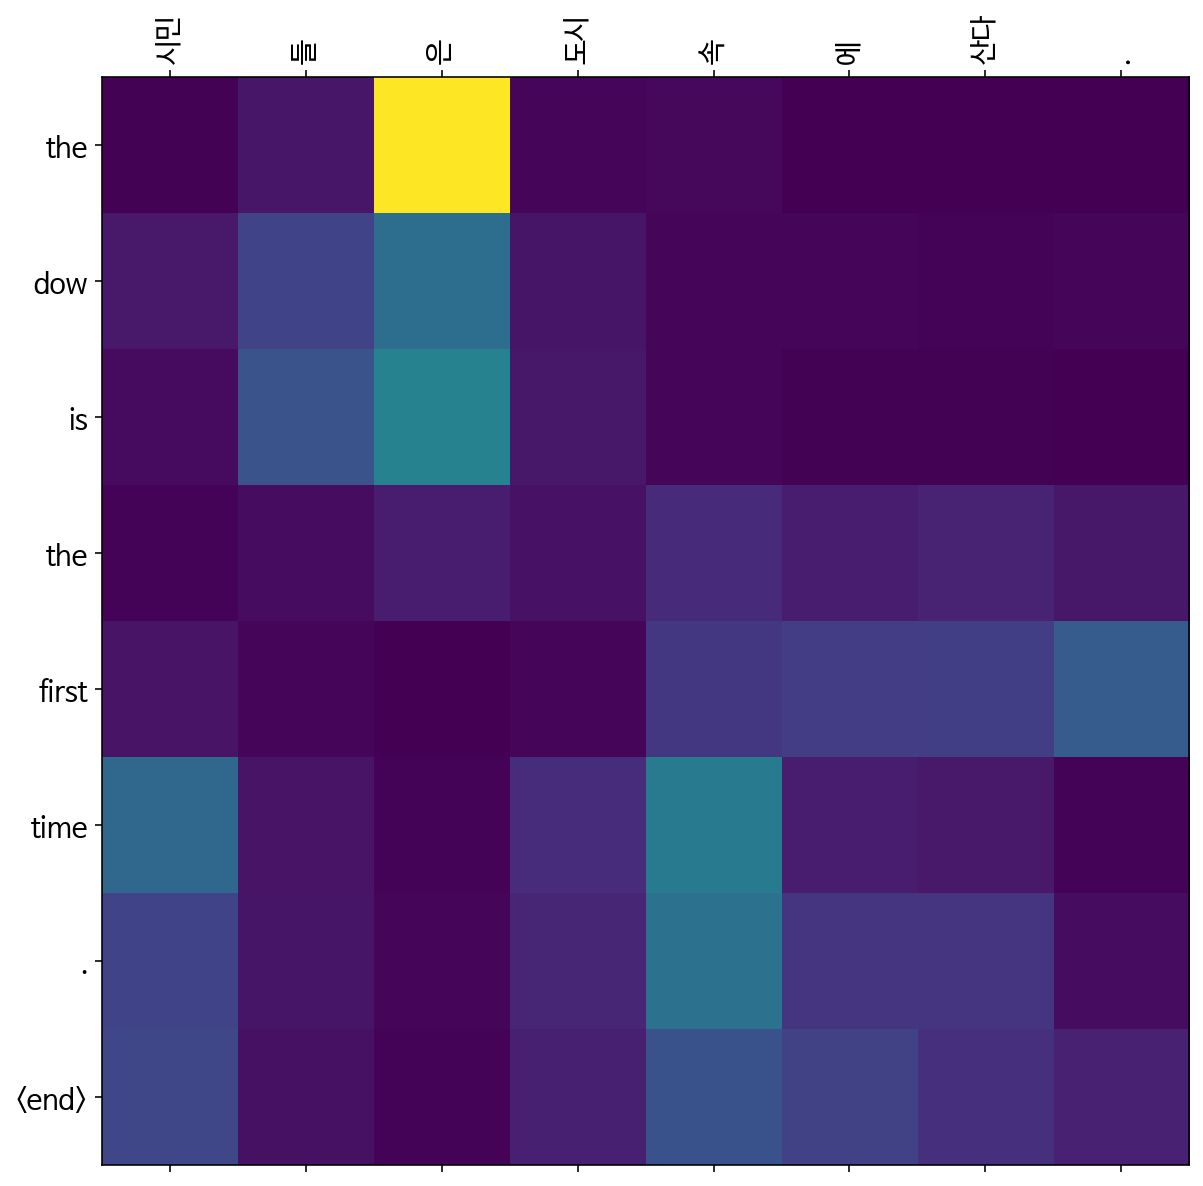

Input: 커피 는 필요 없 다 .
Predicted translation: the baby s a lot of your life . <end> 


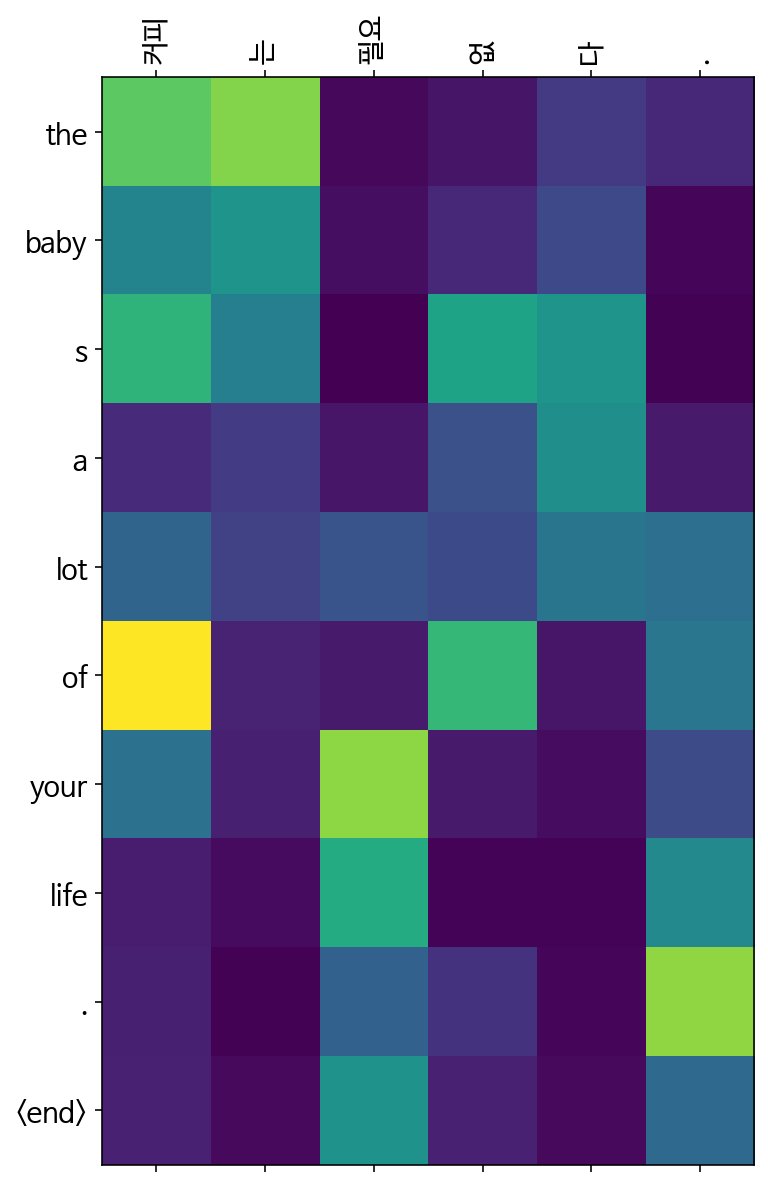

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the attack occurred in the attack . <end> 


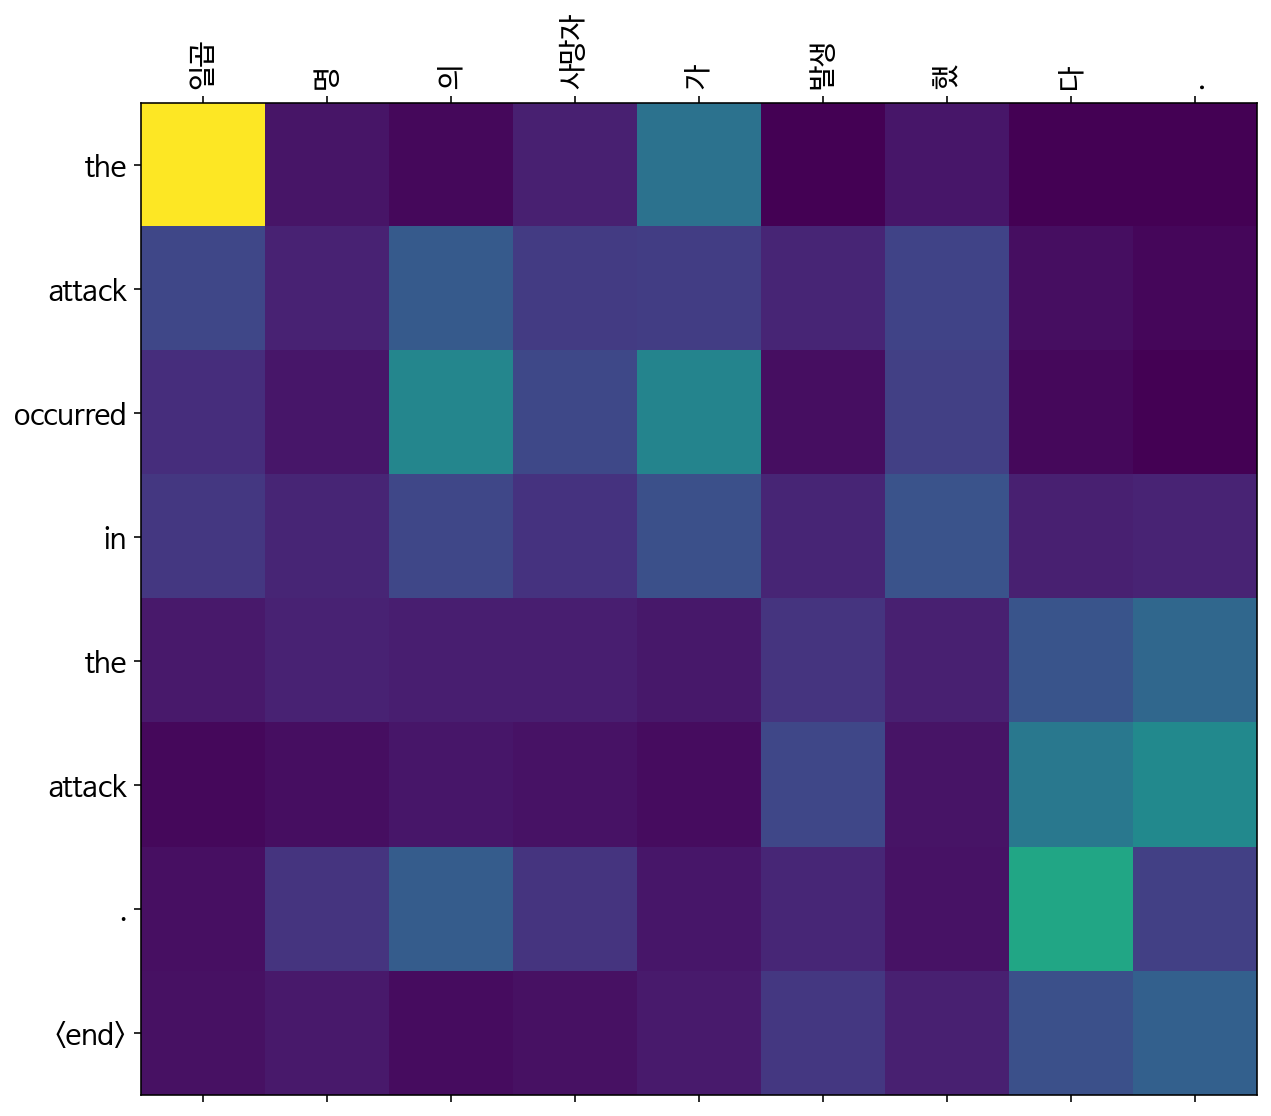

Epoch 40: 100%|██████████| 254/254 [00:55<00:00,  4.56it/s, Loss 0.6633]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s aaron is the first time . <end> 


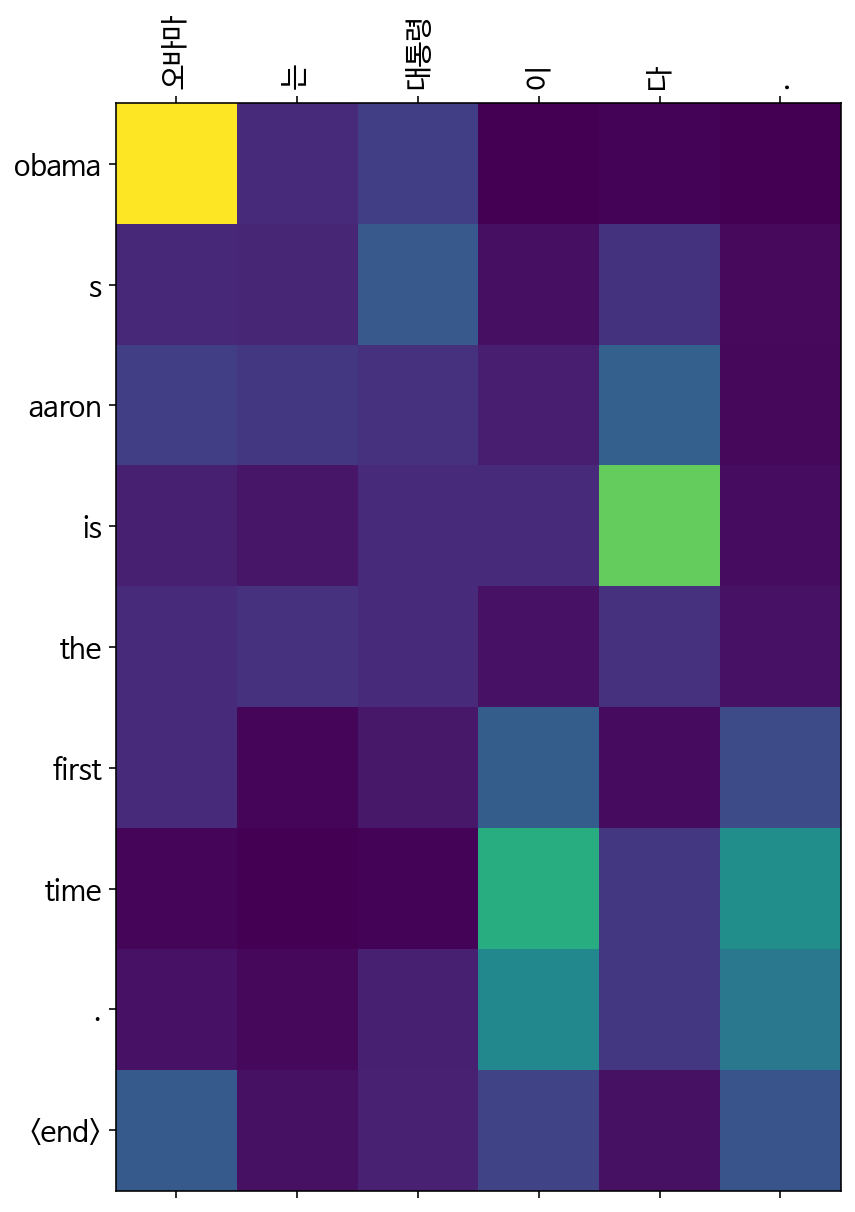

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the dow is in the first time . <end> 


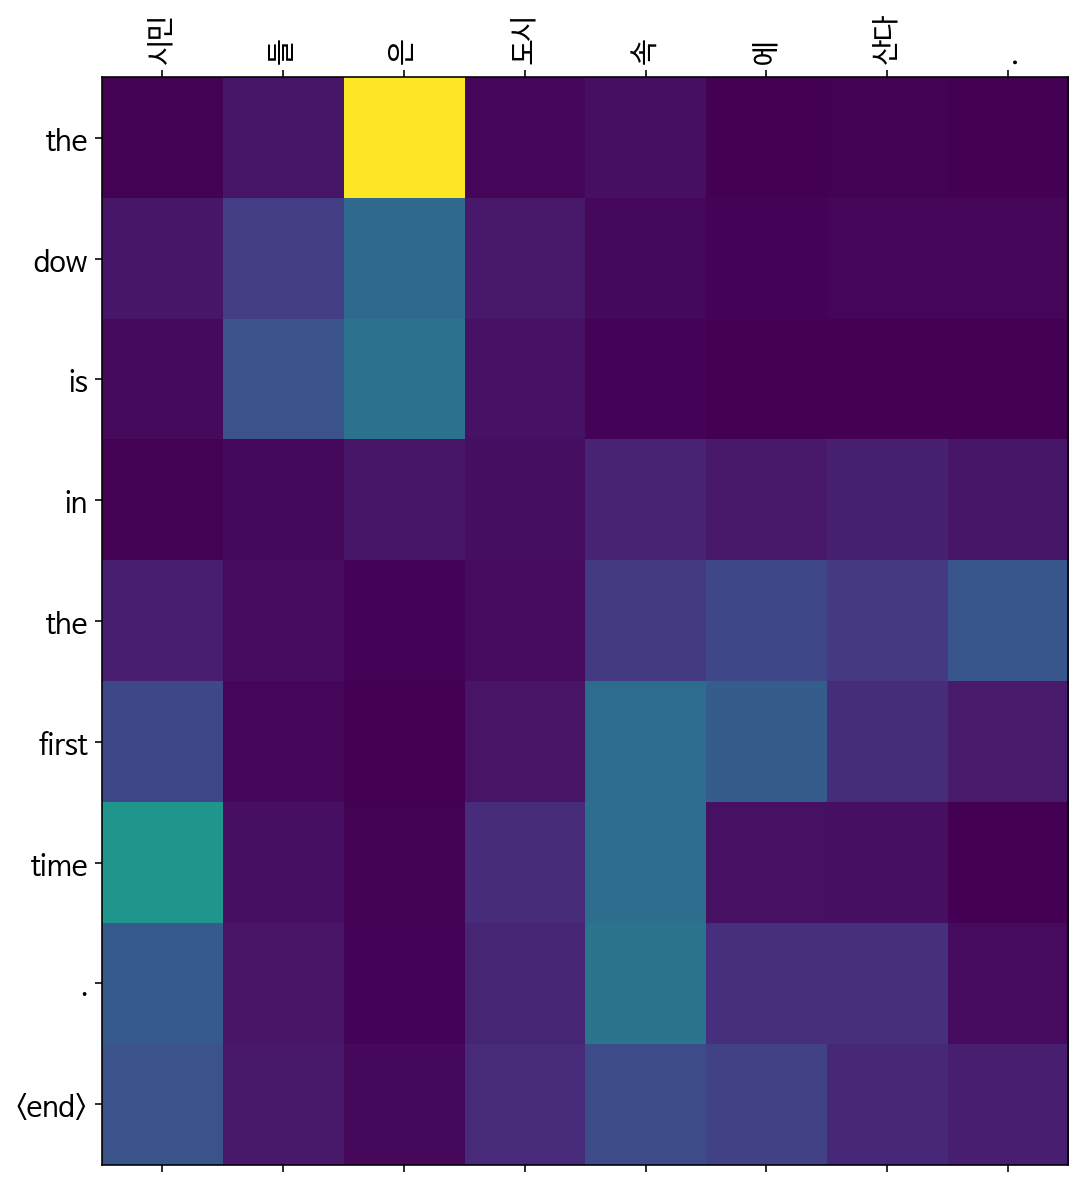

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your own . <end> 


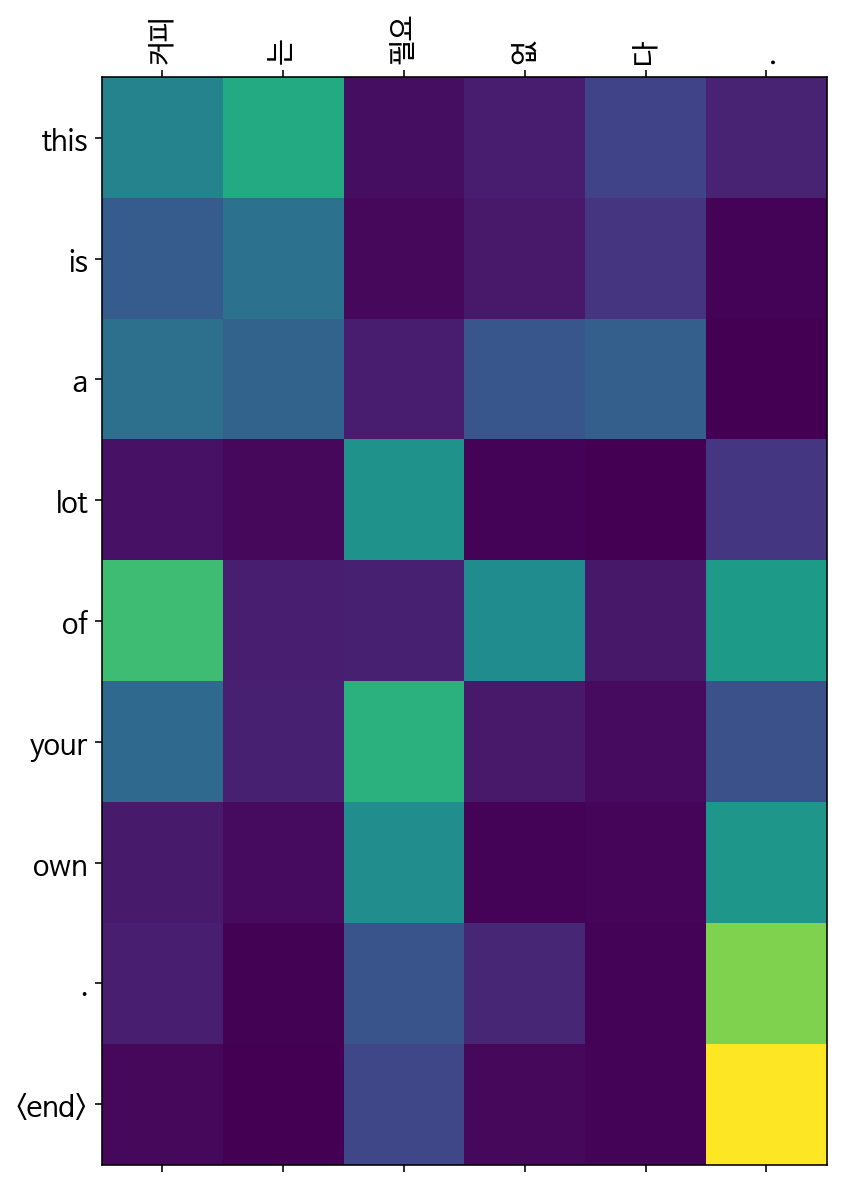

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the victims of people were killed . <end> 


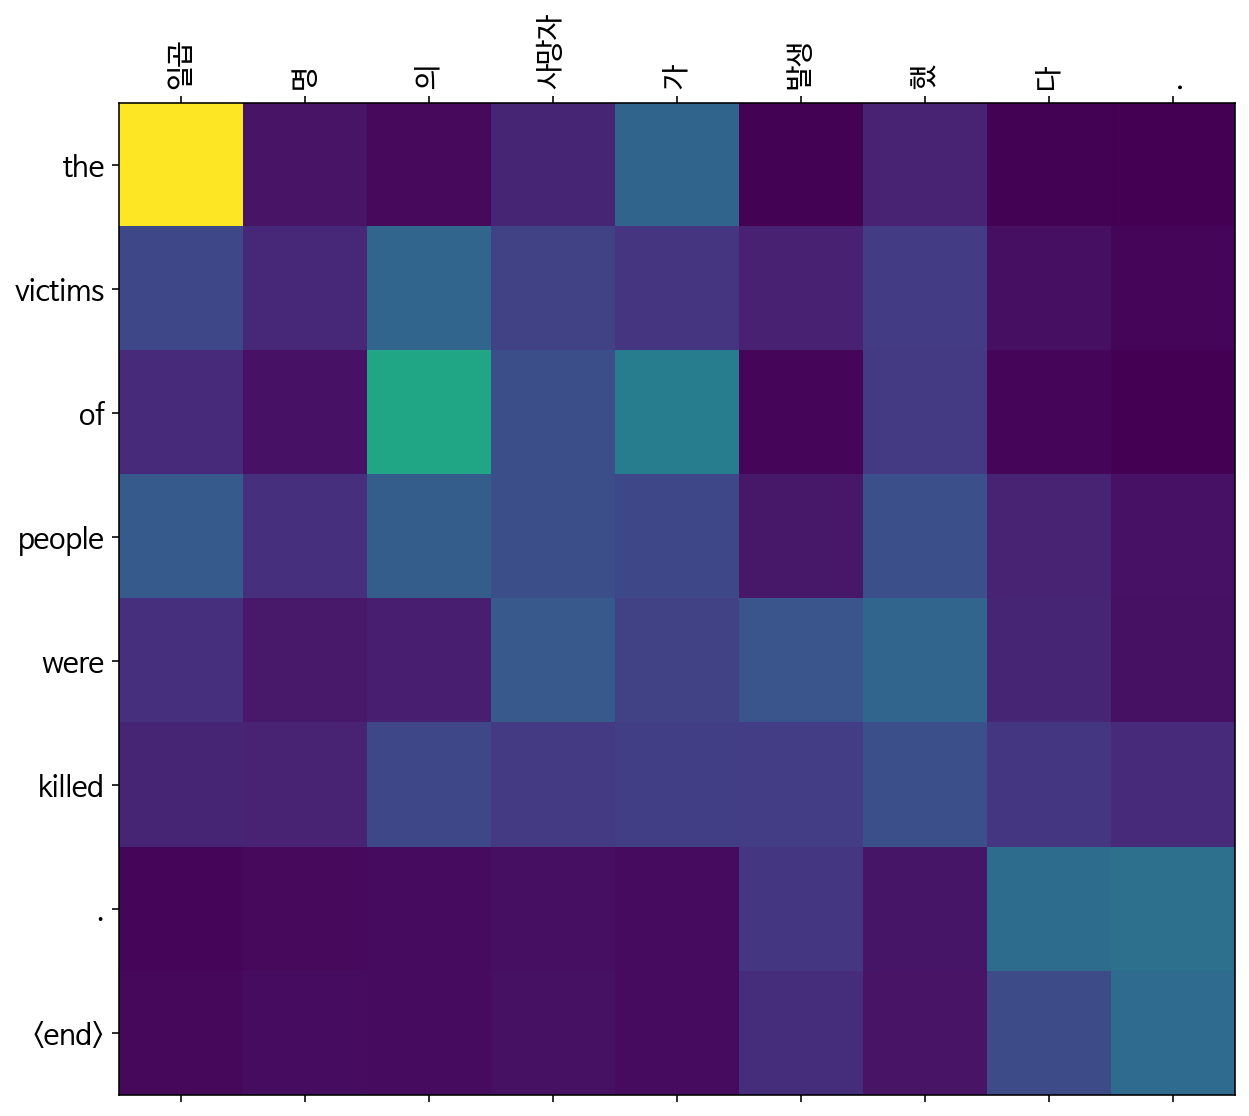

Epoch 41: 100%|██████████| 254/254 [00:55<00:00,  4.55it/s, Loss 0.6436]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york governor s health . <end> 


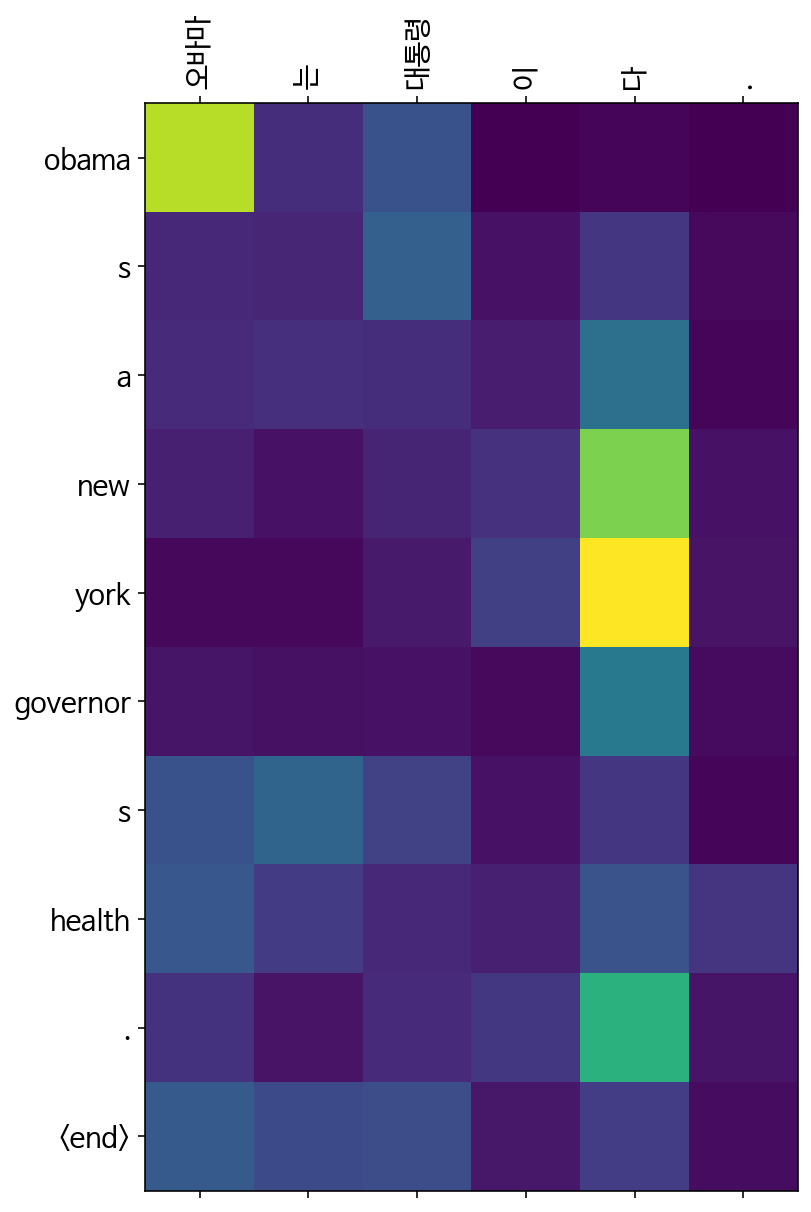

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two of the two of the dow is in the of years . <end> 


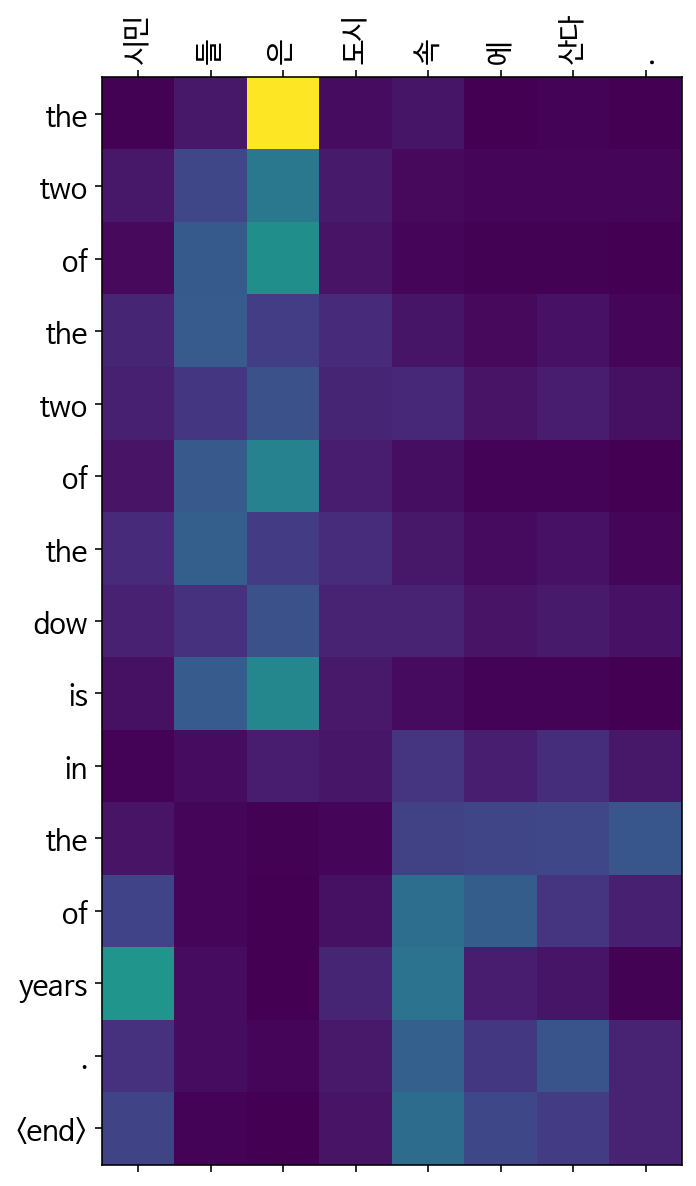

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your . <end> 


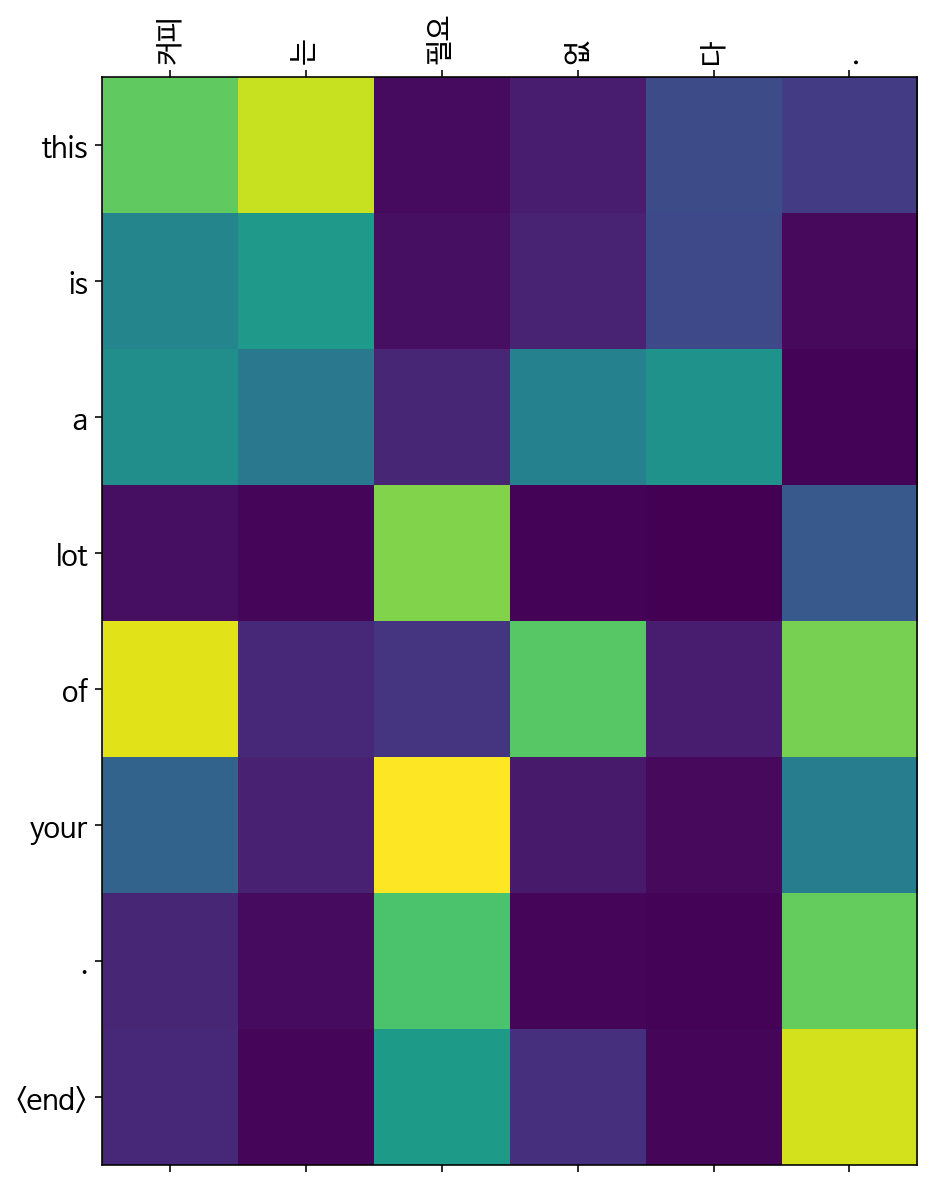

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion struck the attack . <end> 


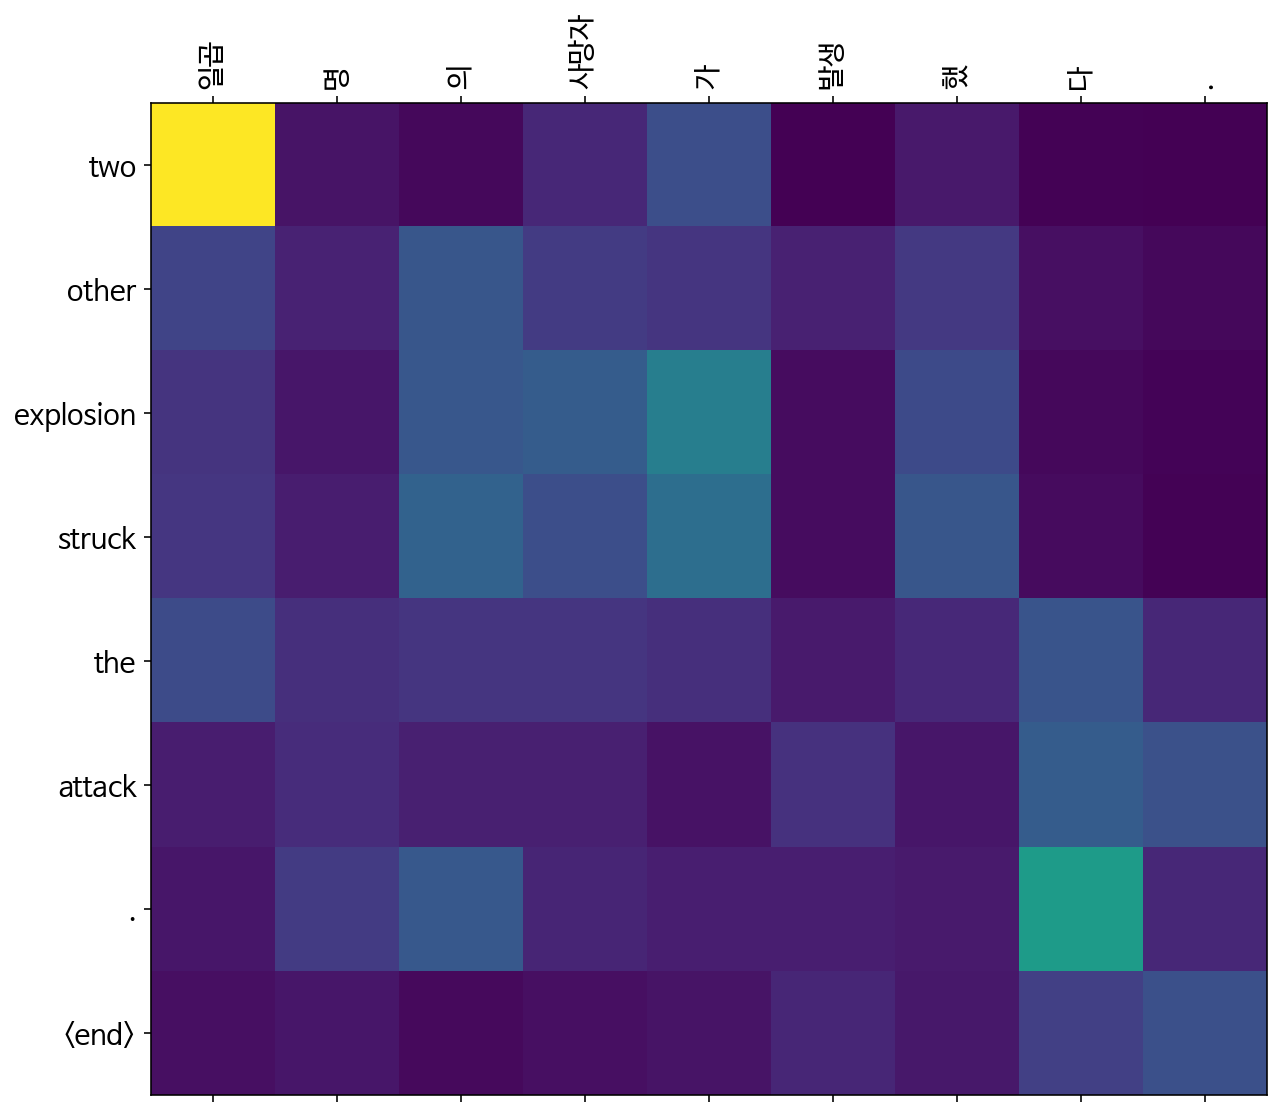

Epoch 42: 100%|██████████| 254/254 [00:55<00:00,  4.54it/s, Loss 0.6288]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama 


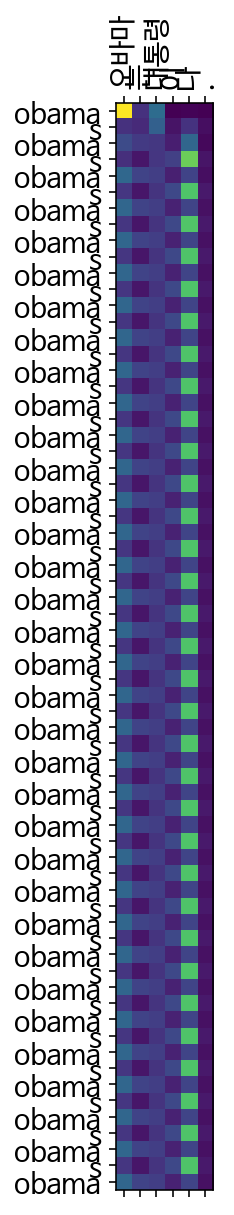

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two sides also a day . <end> 


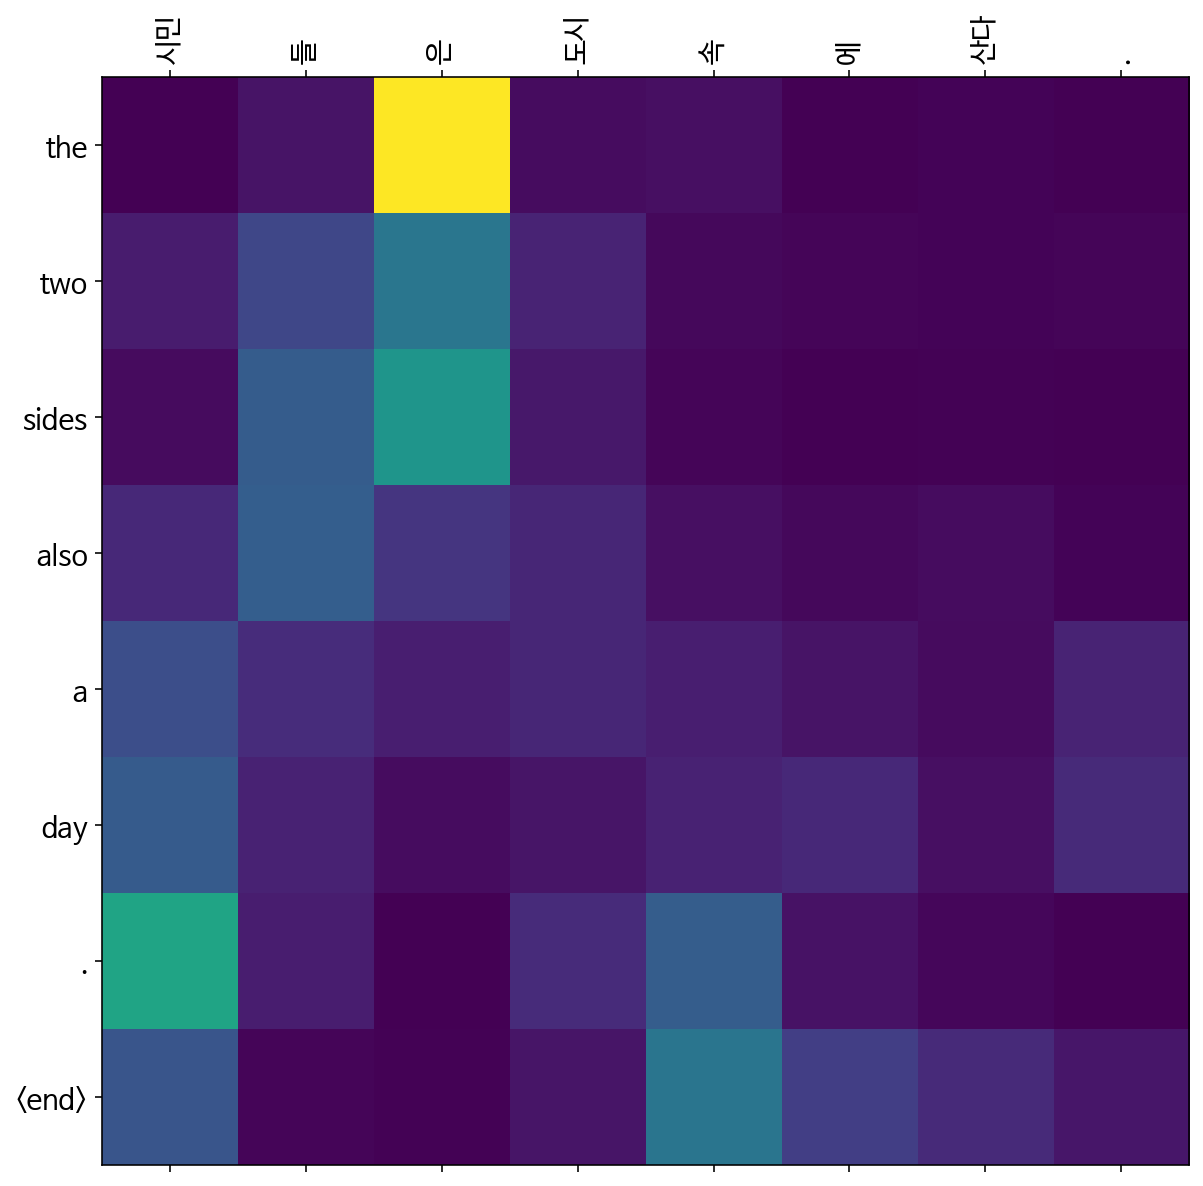

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your . <end> 


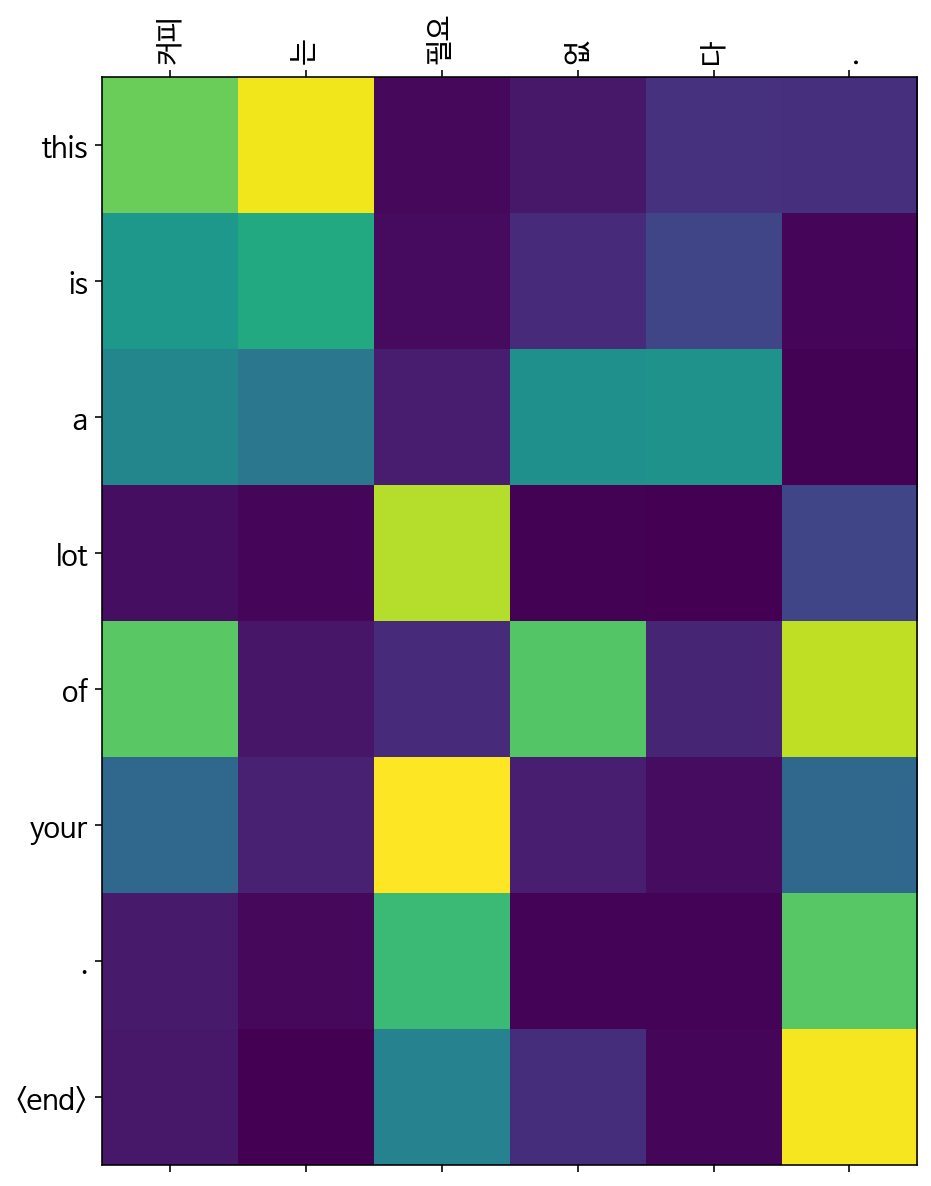

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the victims of people were killed . <end> 


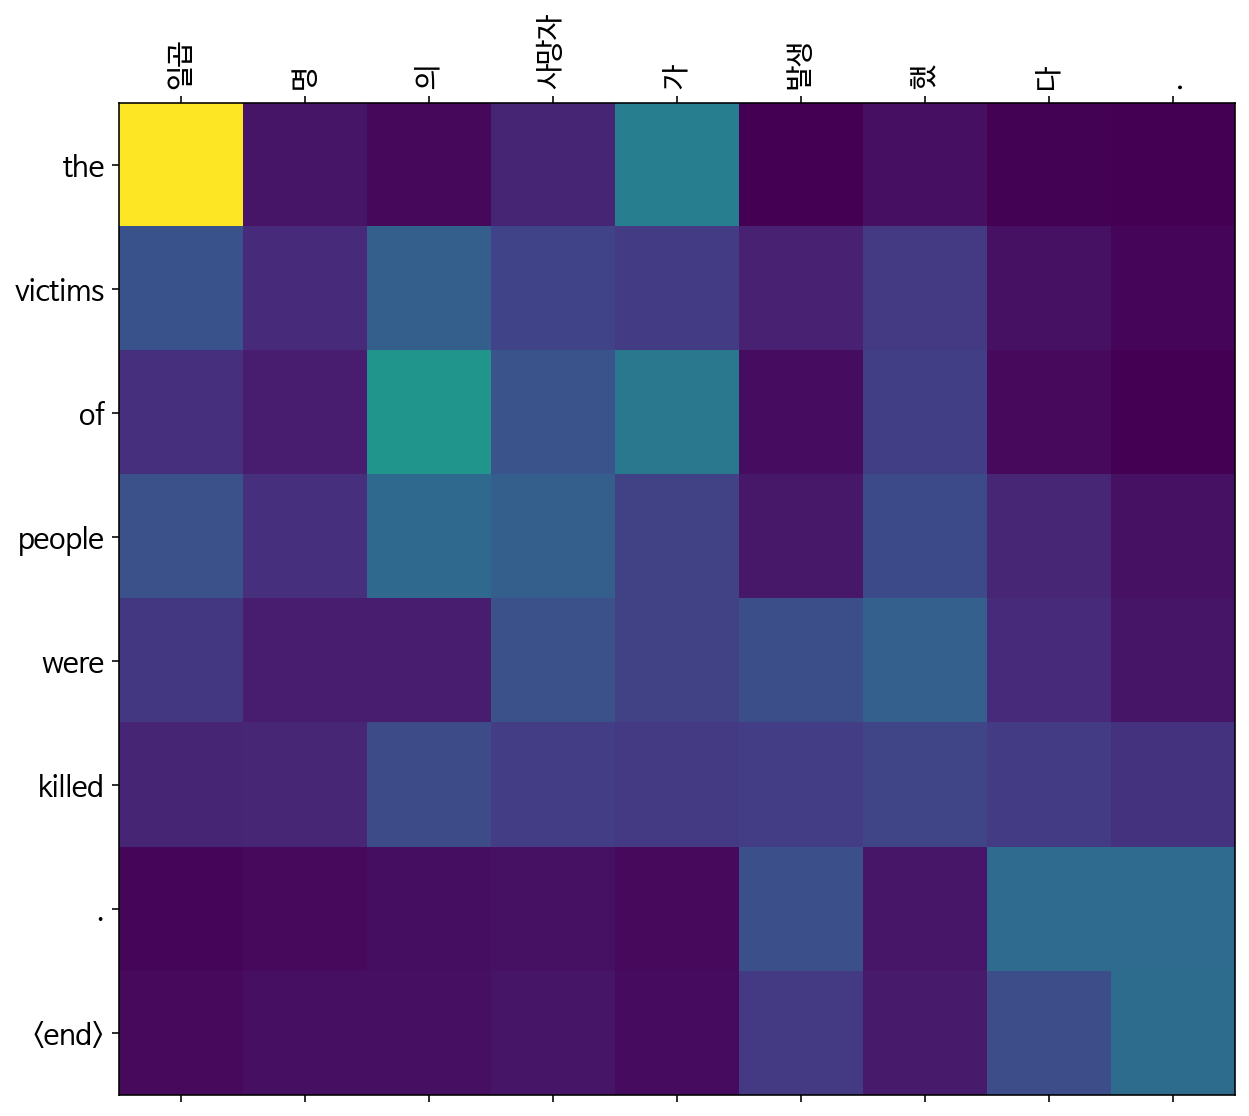

Epoch 43: 100%|██████████| 254/254 [00:56<00:00,  4.52it/s, Loss 0.6188]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new york s obama s health said <end> 


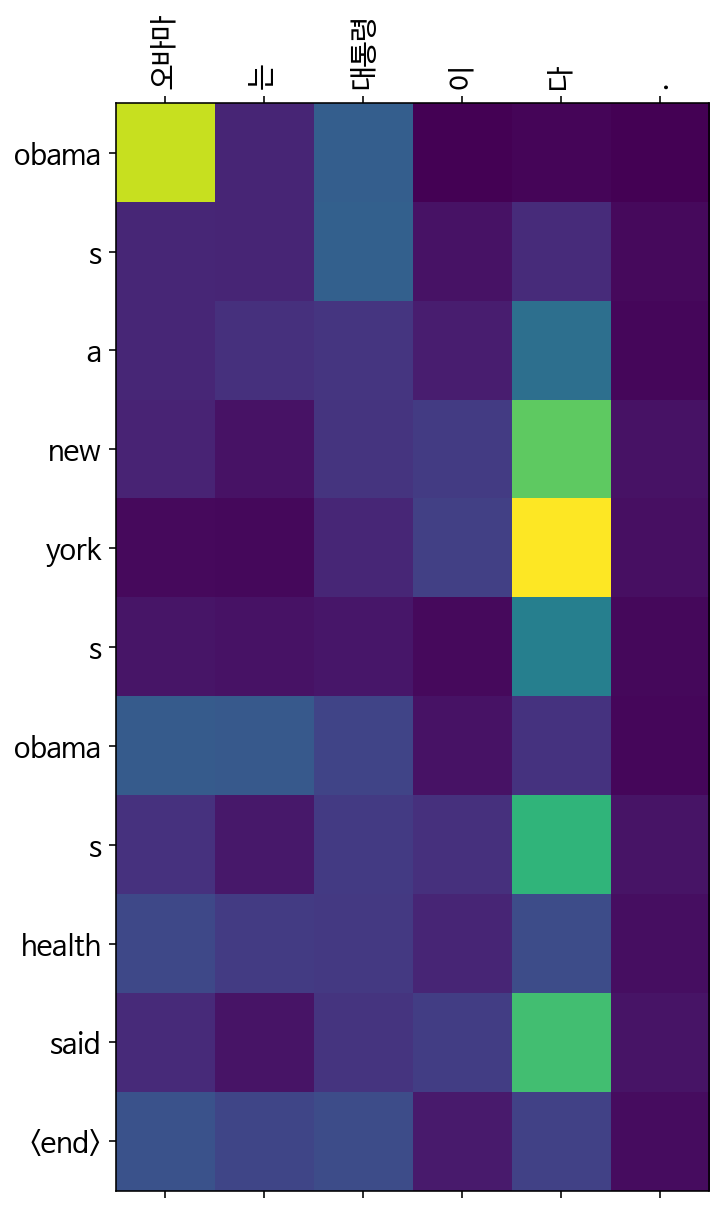

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the 


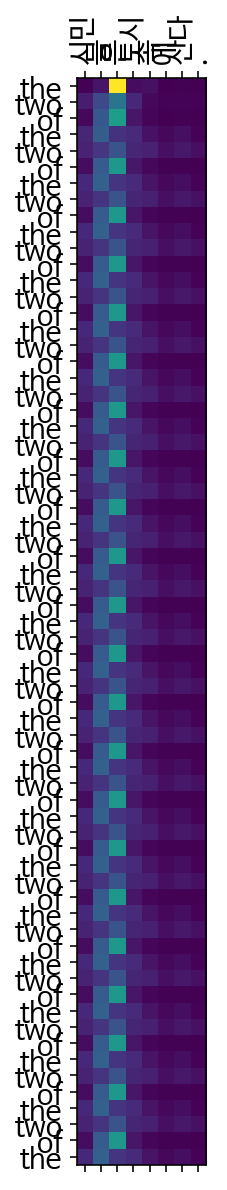

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your life . <end> 


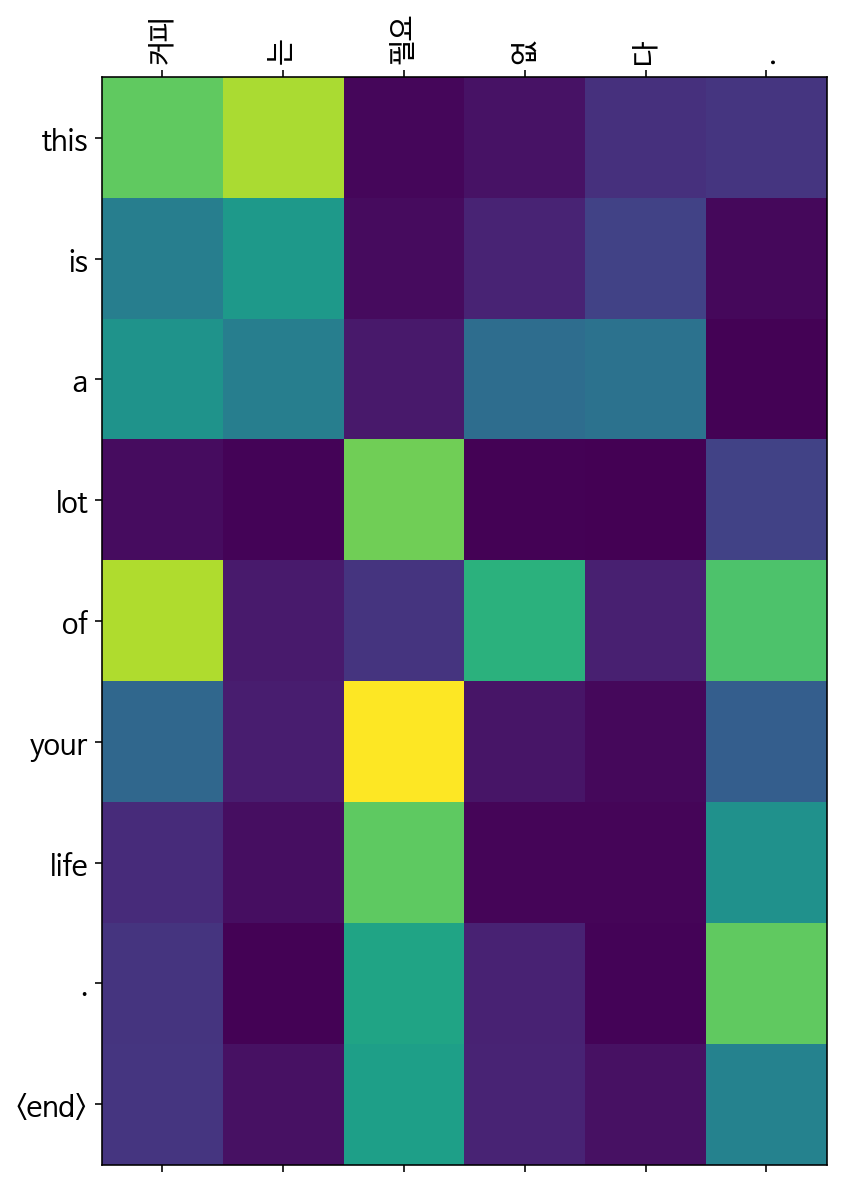

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the victims of people were killed . <end> 


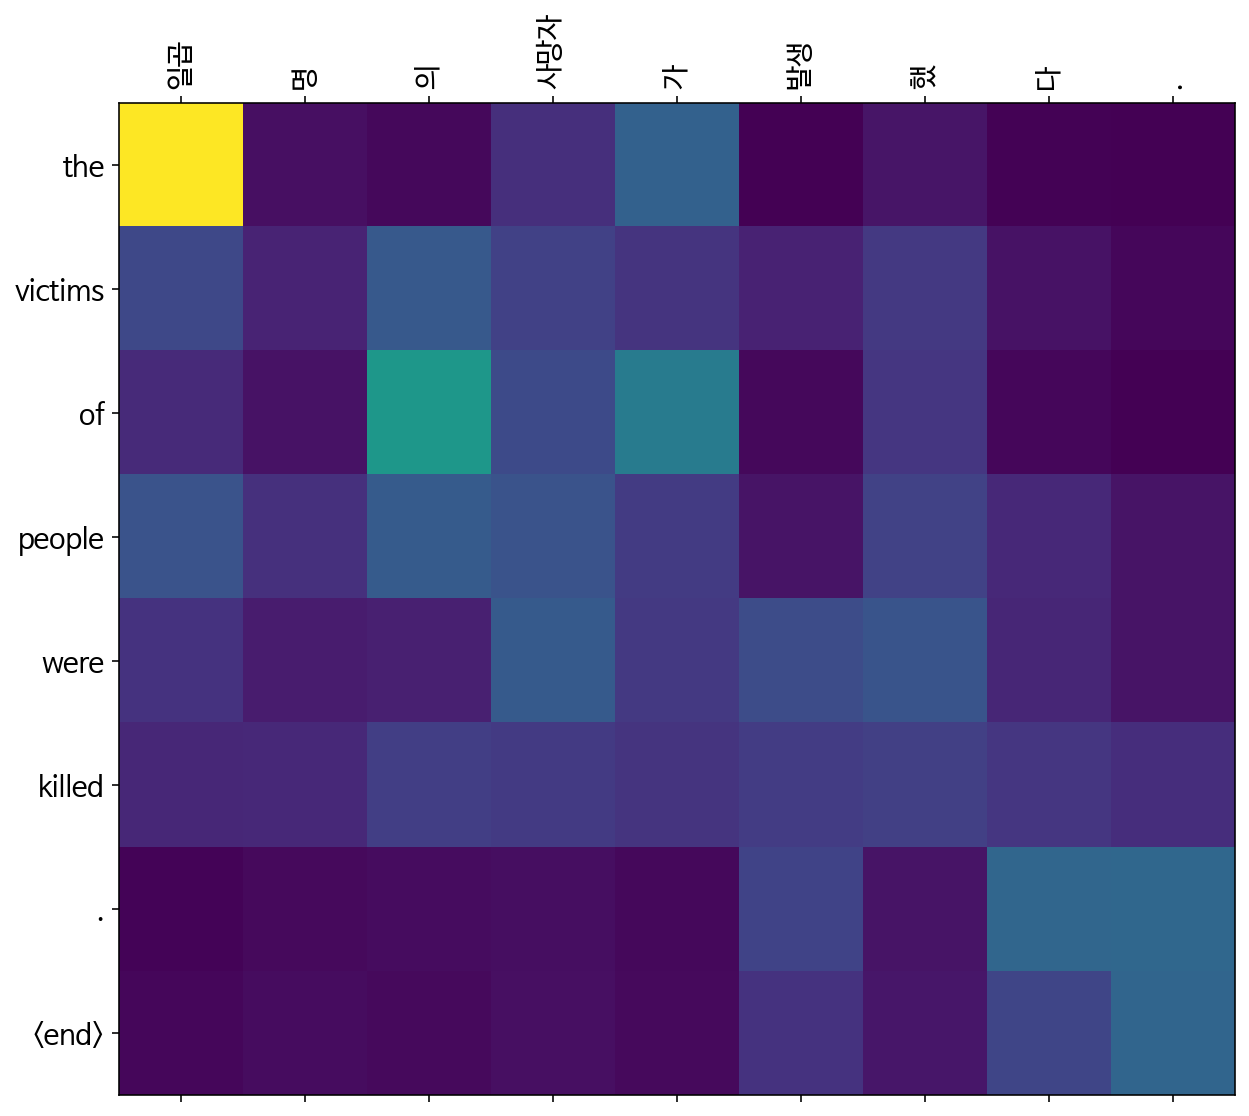

Epoch 44: 100%|██████████| 254/254 [00:56<00:00,  4.47it/s, Loss 0.6090]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama s obama . <end> 


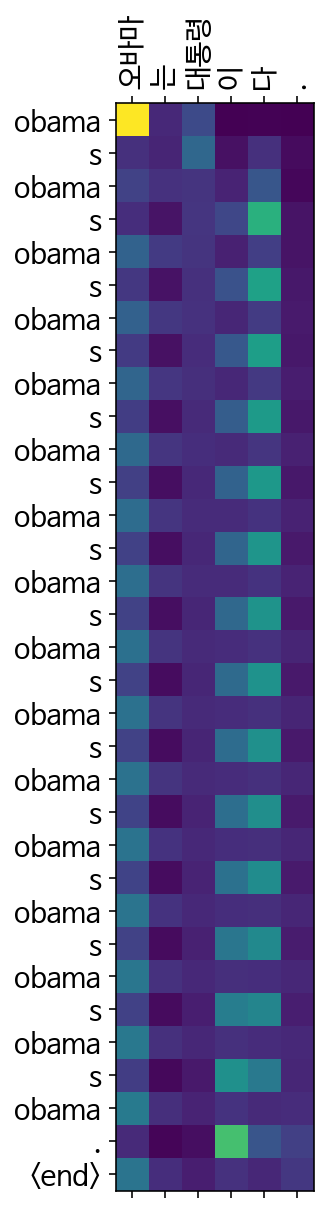

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the government is also in the first , or the first time . <end> 


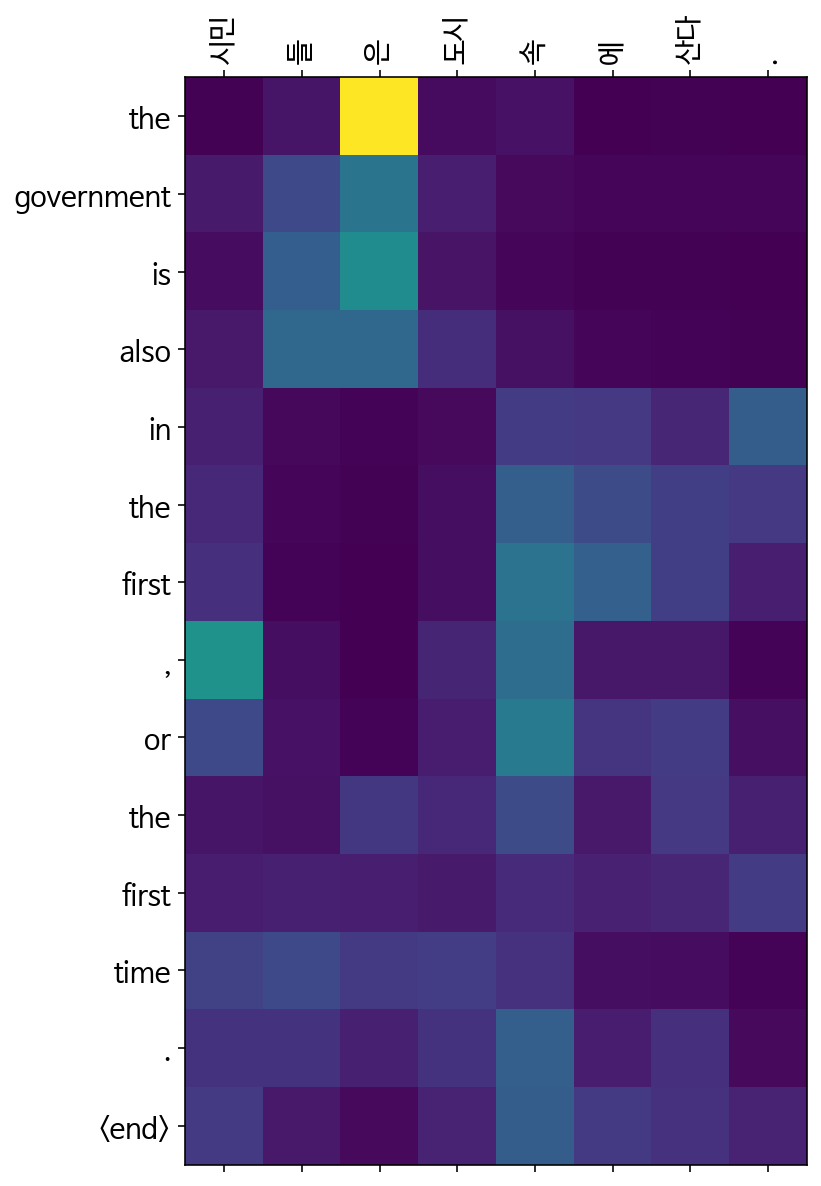

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your own . <end> 


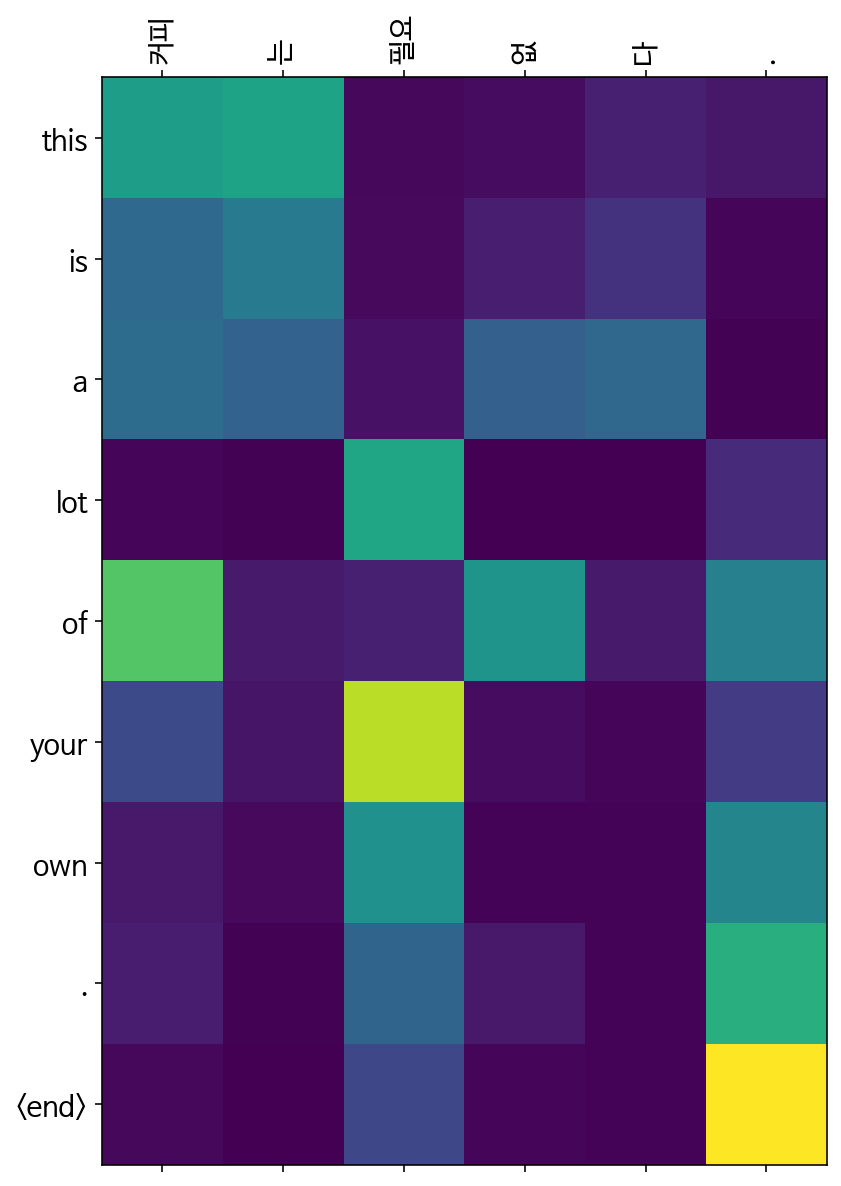

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the attack occurred in the hospital . <end> 


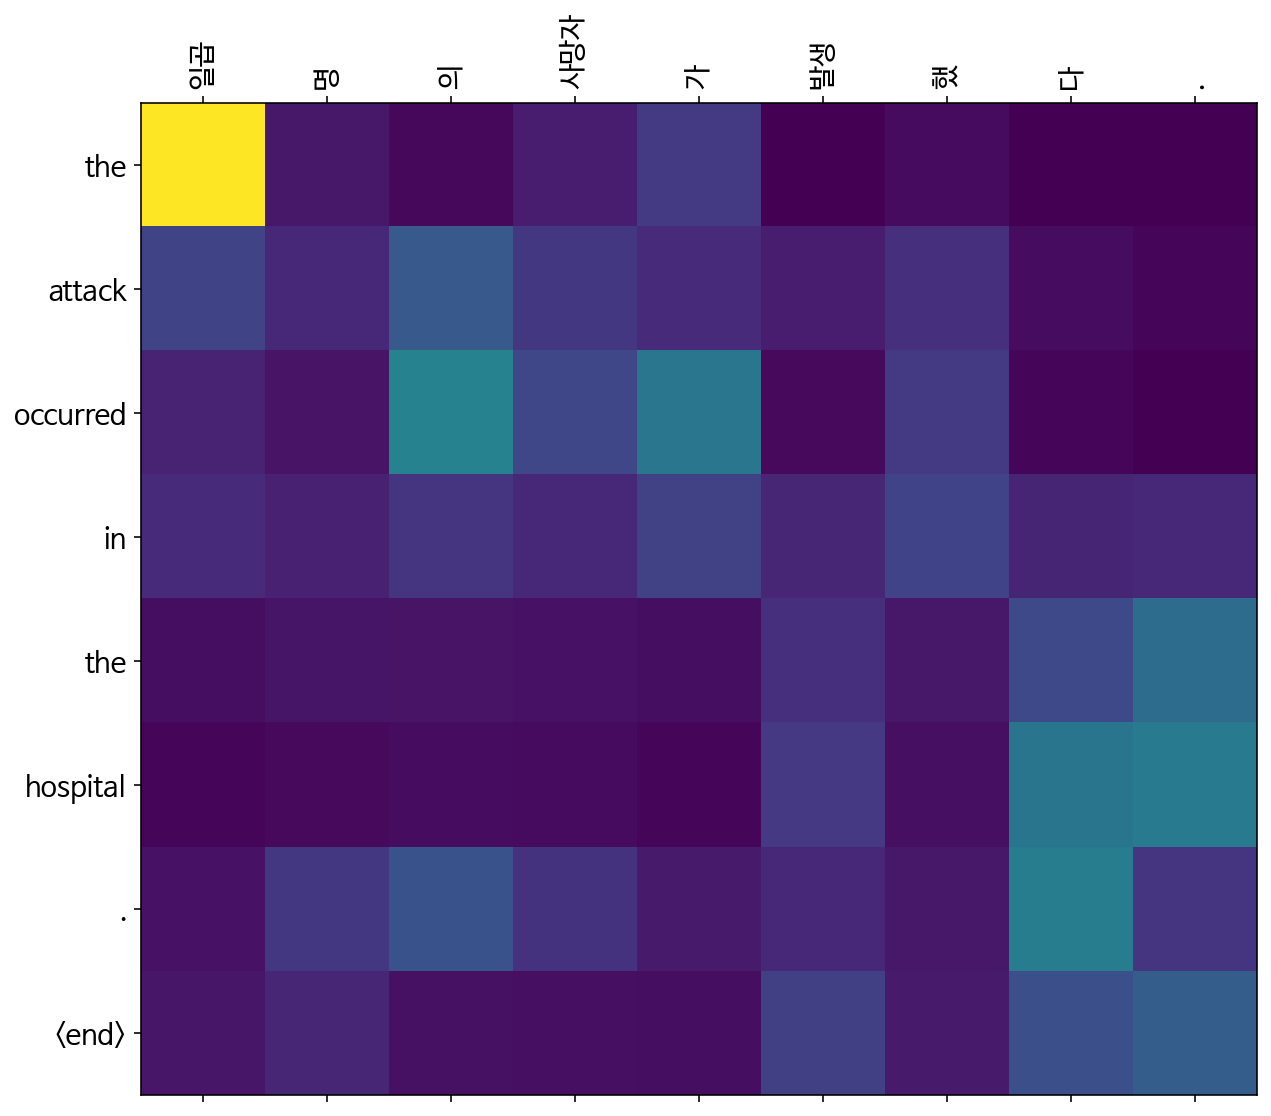

Epoch 45: 100%|██████████| 254/254 [00:55<00:00,  4.56it/s, Loss 0.6003]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s president bush s president elect barack obama says he s a new york . <end> 


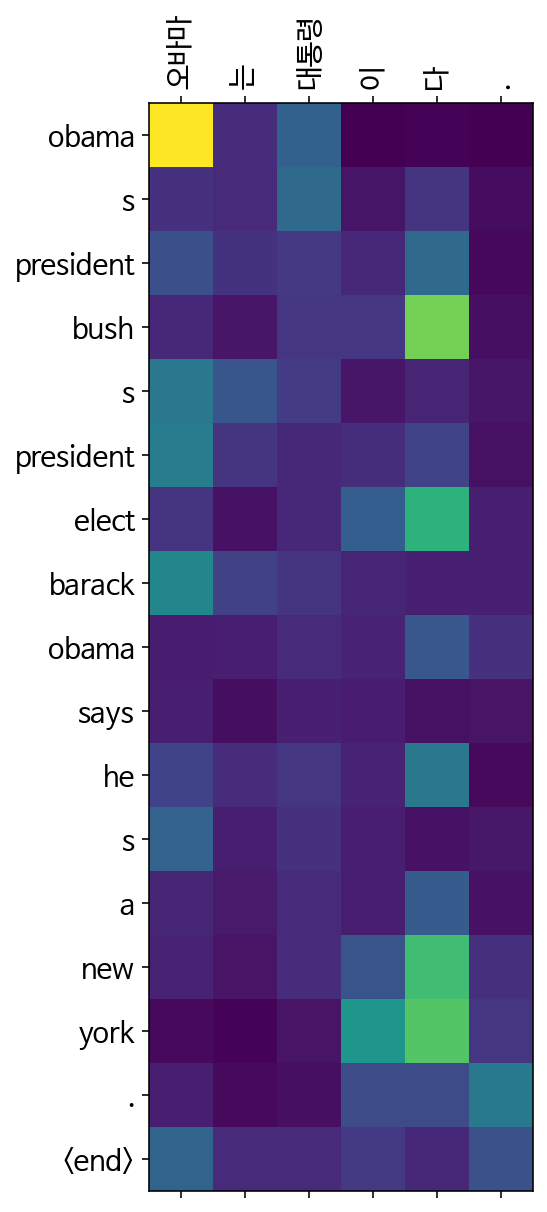

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the government is the first , or the first , and the dow is the first , or the first , or the first time . <end> 


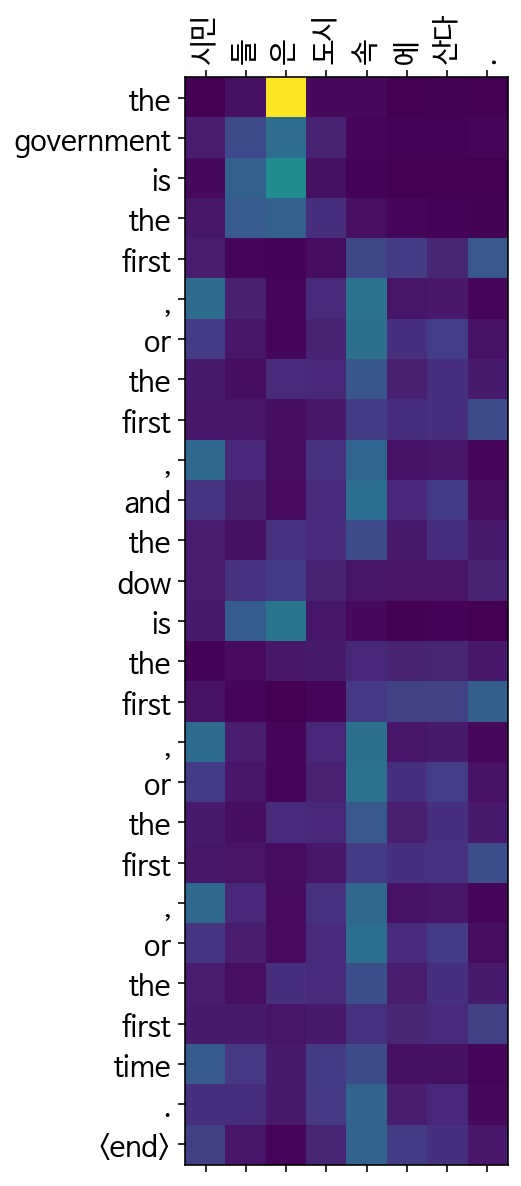

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your . <end> 


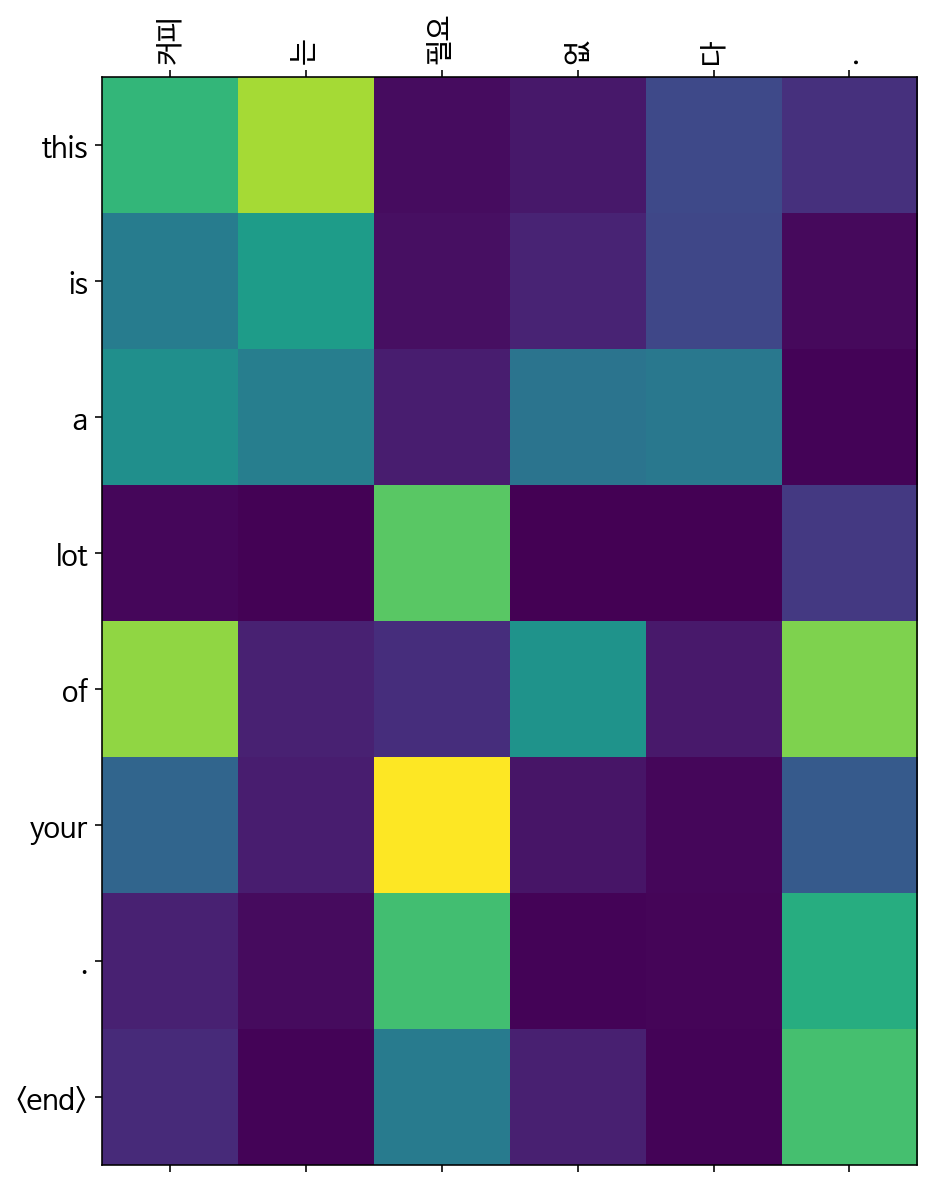

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the victims of the attack occurred in the site . <end> 


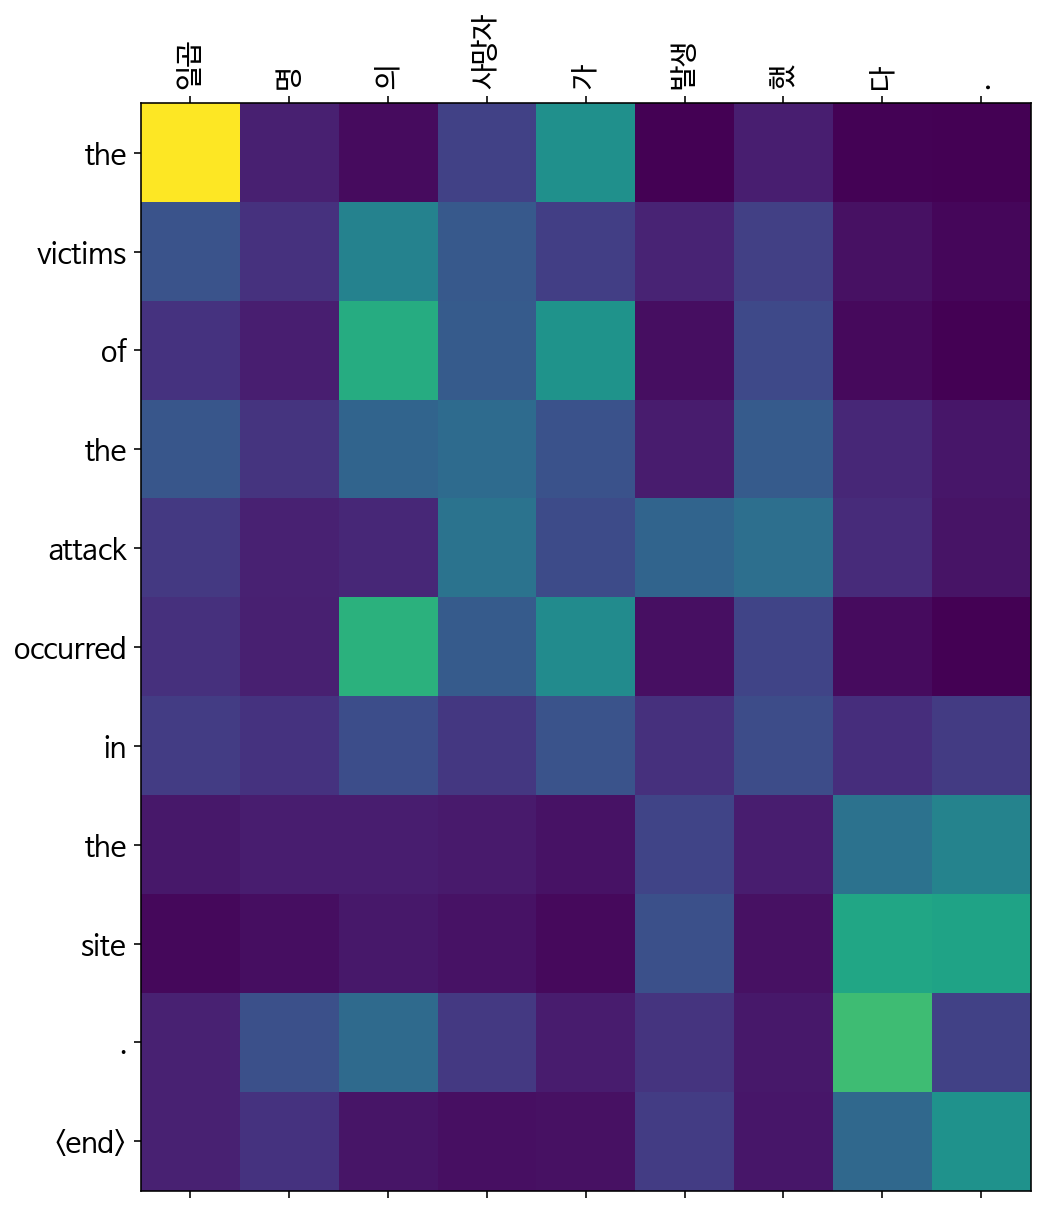

Epoch 46: 100%|██████████| 254/254 [00:55<00:00,  4.55it/s, Loss 0.5912]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new president bush s health said <end> 


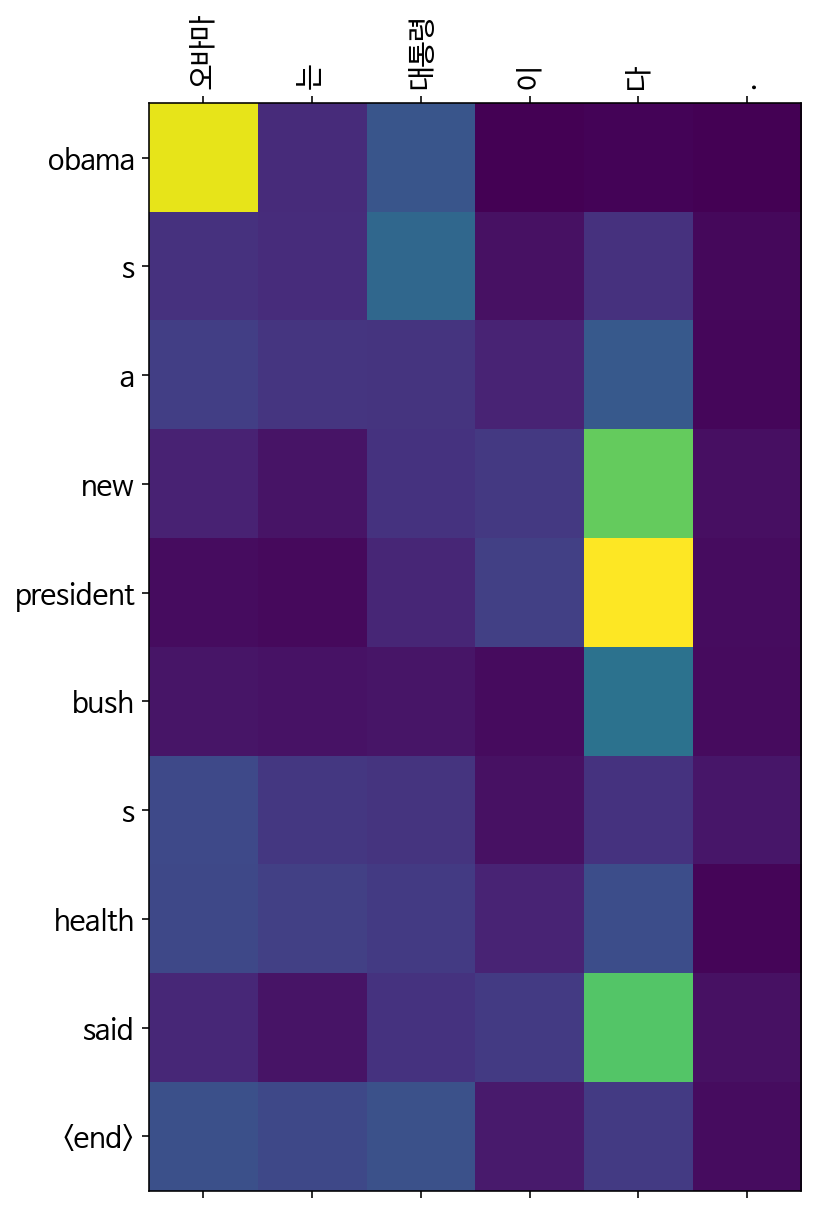

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two are about , or the first time . <end> 


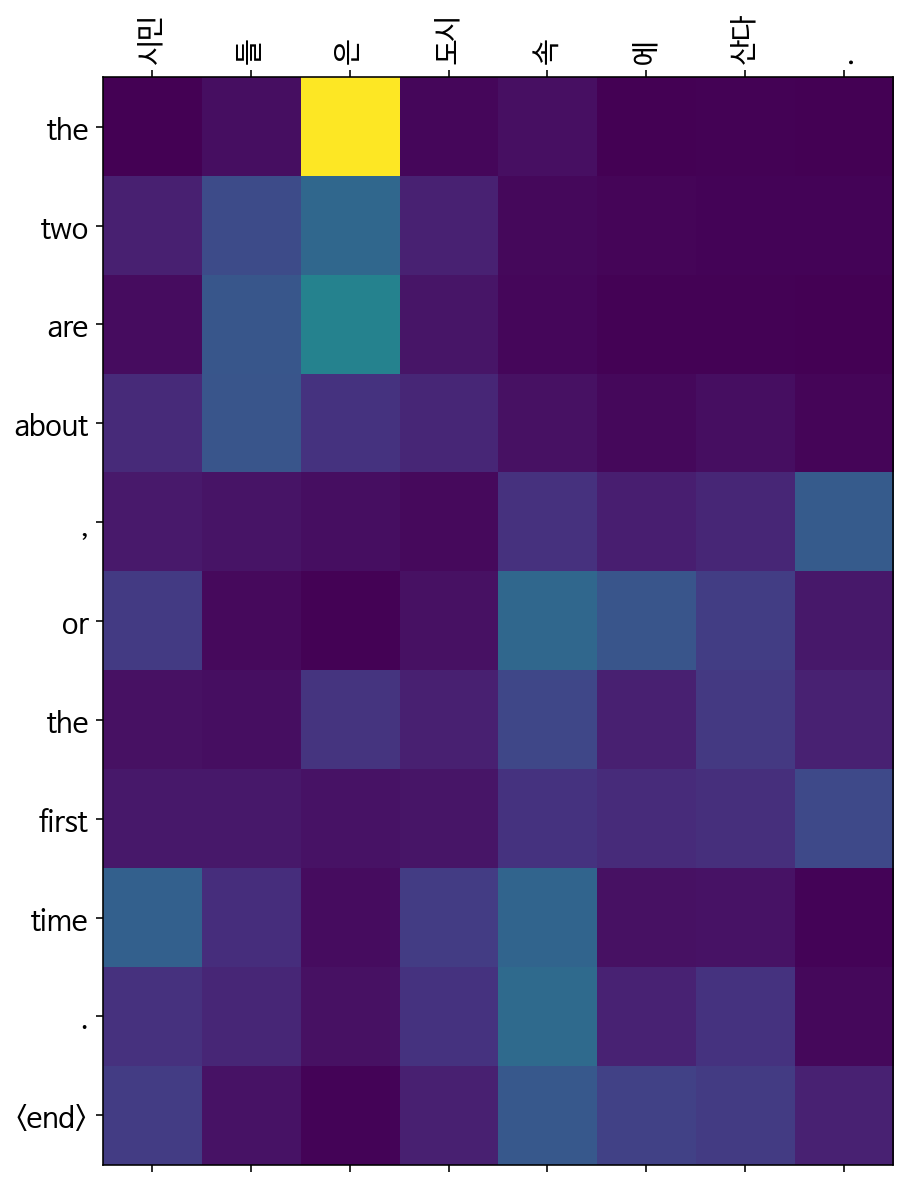

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your technique . <end> 


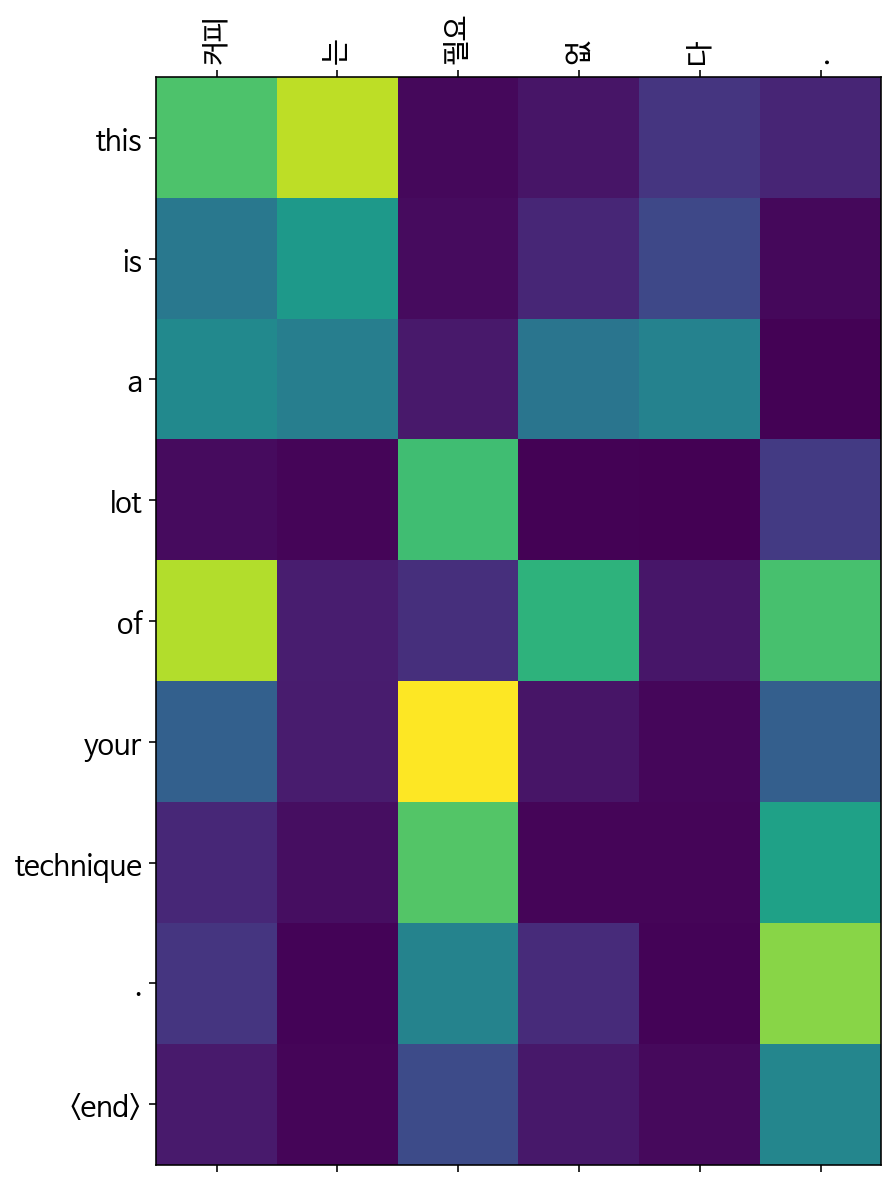

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion rose . <end> 


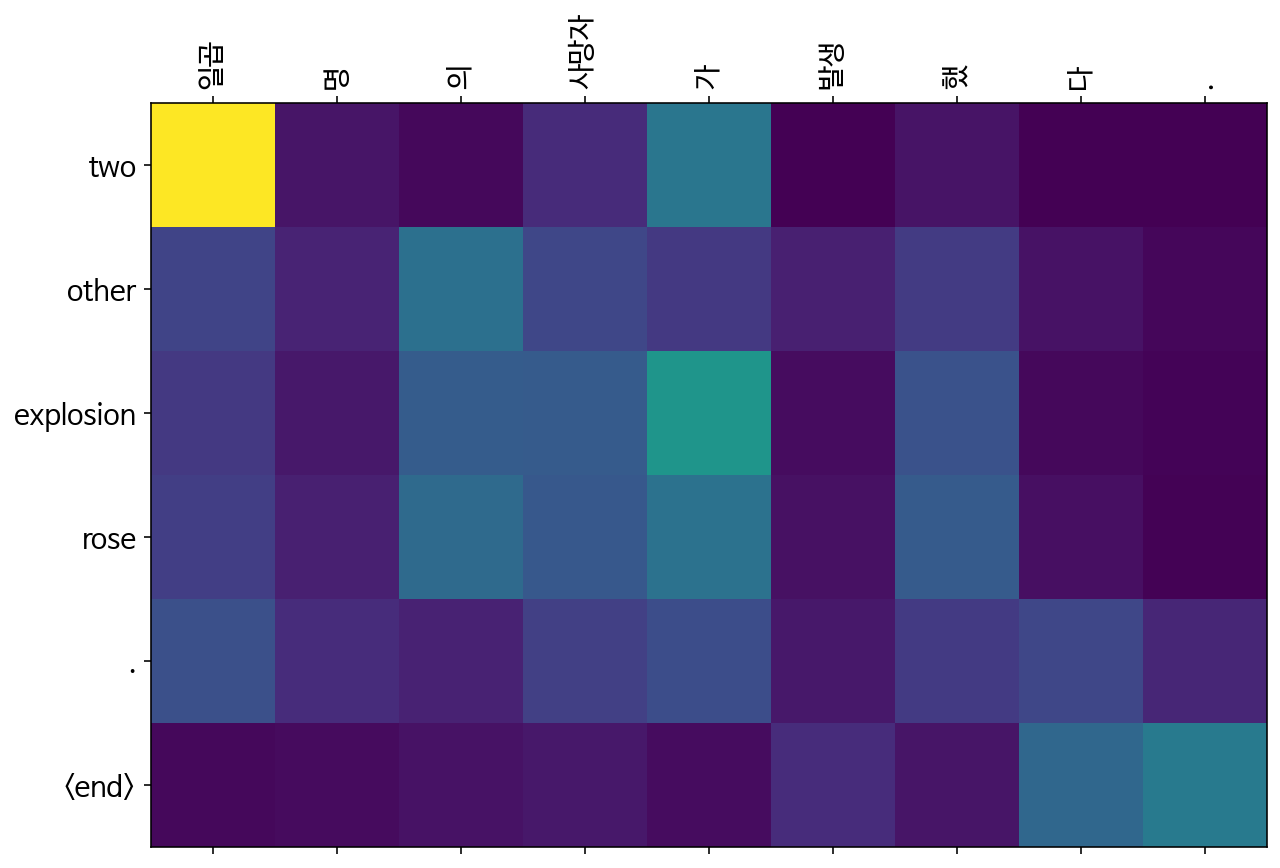

Epoch 47: 100%|██████████| 254/254 [00:55<00:00,  4.55it/s, Loss 0.5818]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama calls on the president . <end> 


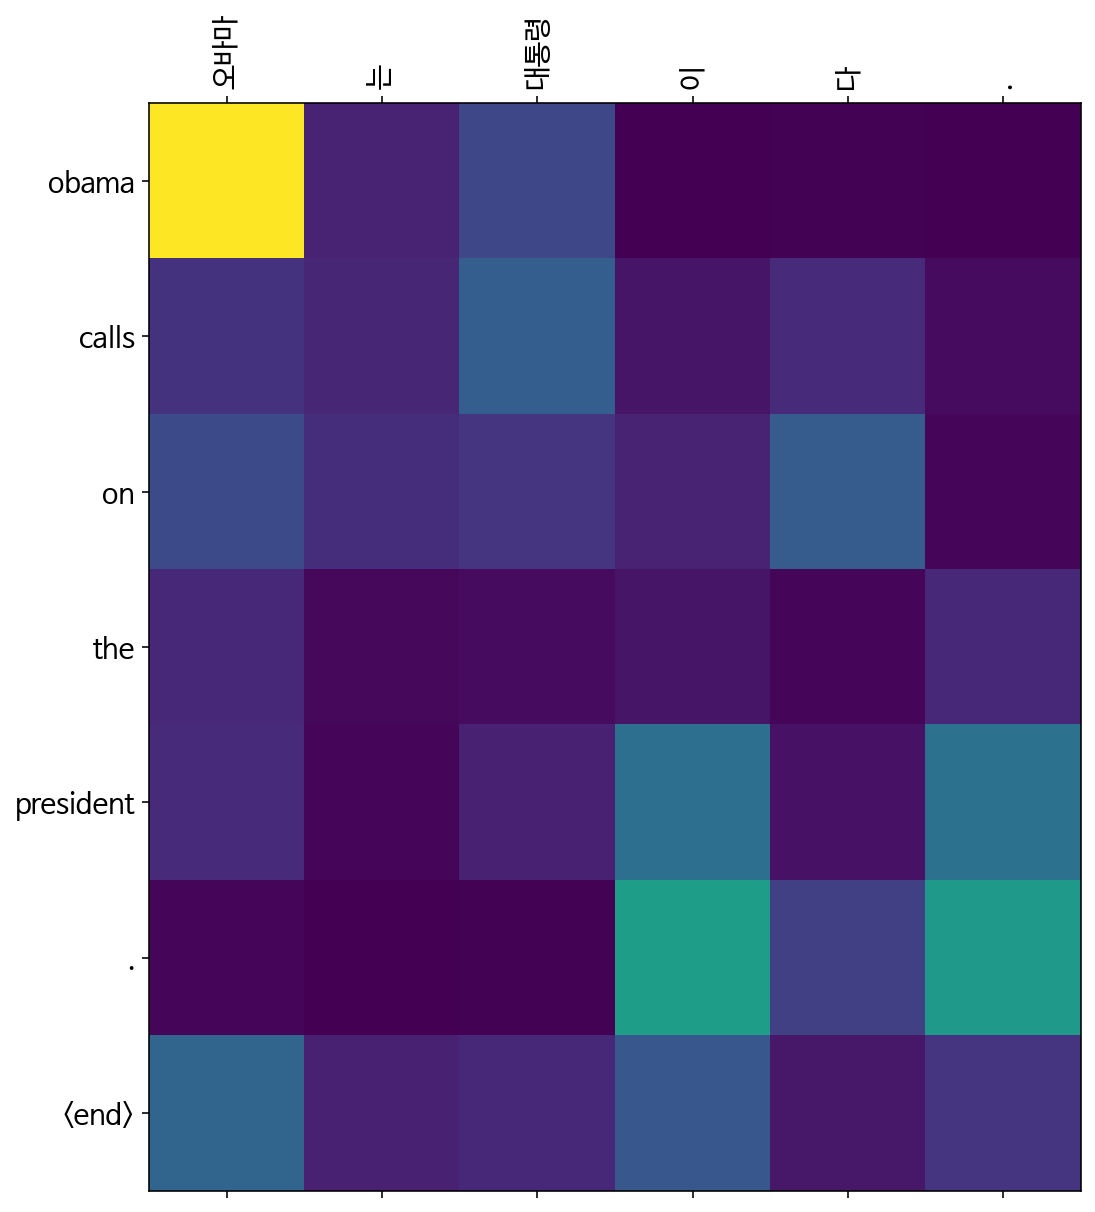

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the president george w . not to the first time . <end> 


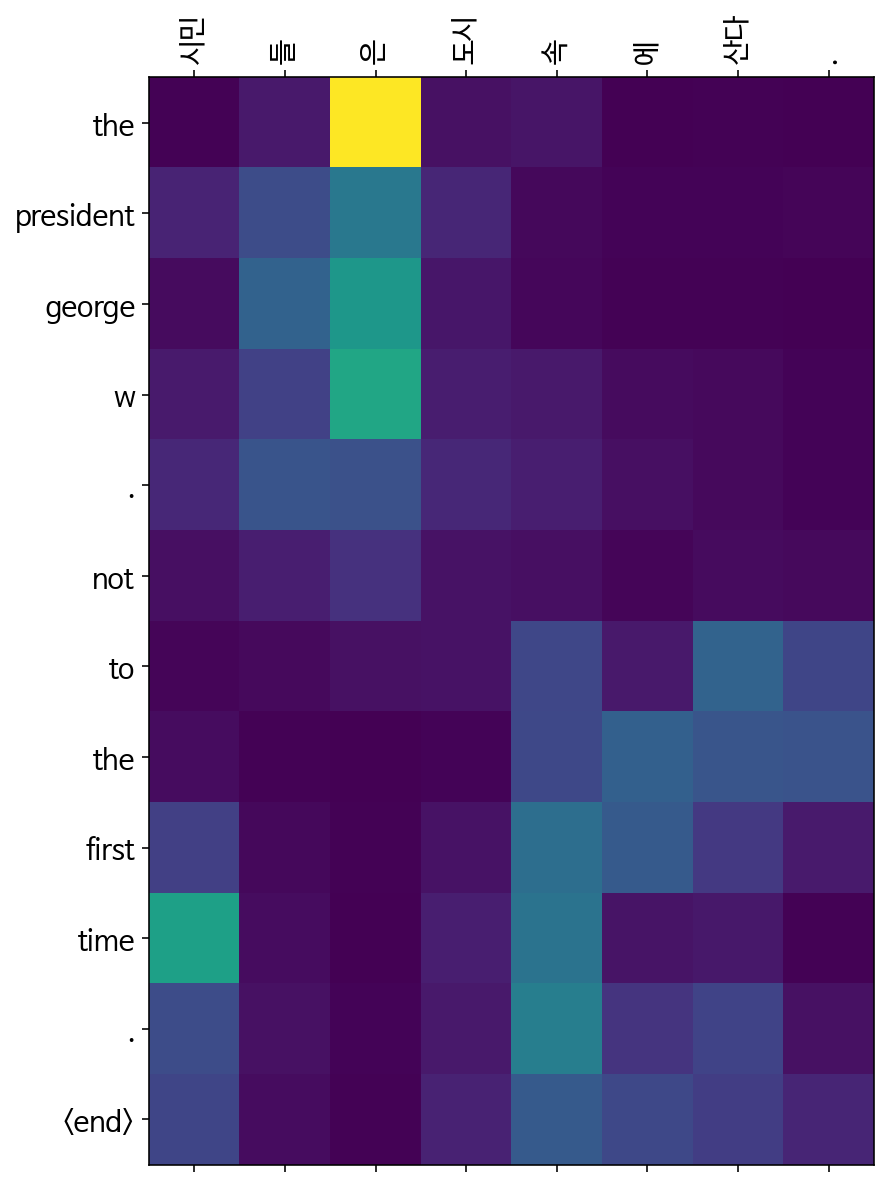

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of yours . <end> 


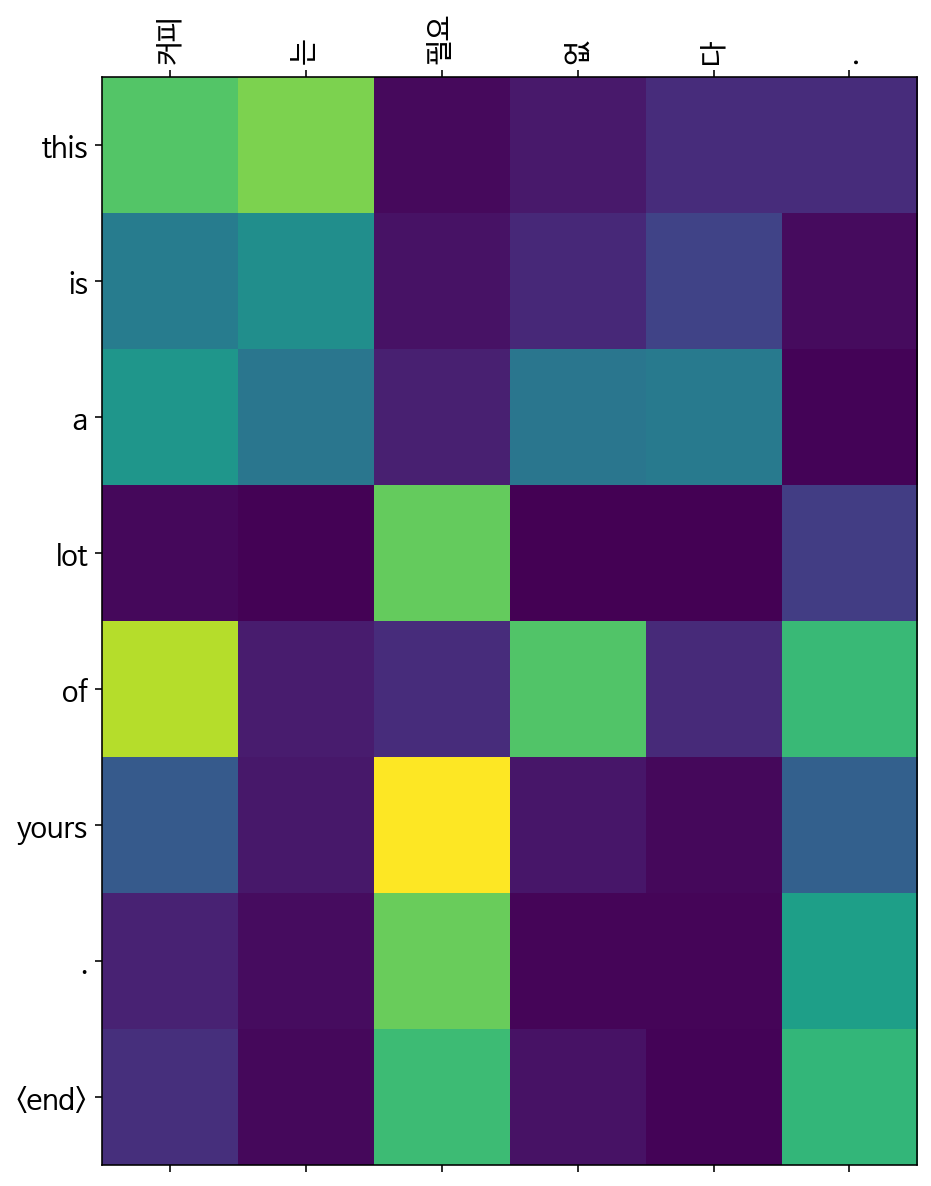

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: a suicide bomber official said . <end> 


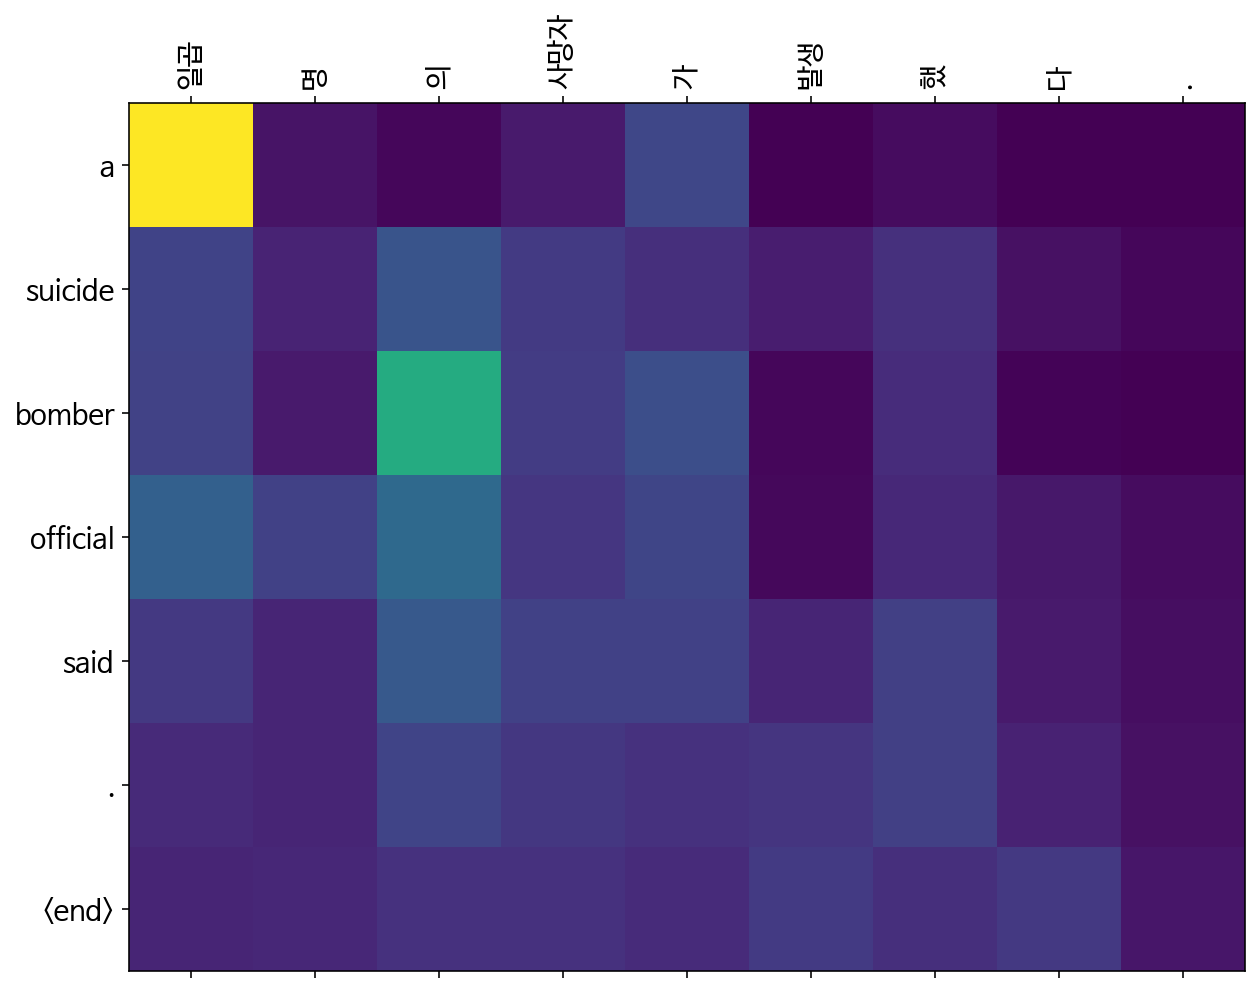

Epoch 48: 100%|██████████| 254/254 [00:56<00:00,  4.52it/s, Loss 0.5737]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s a new constitution . <end> 


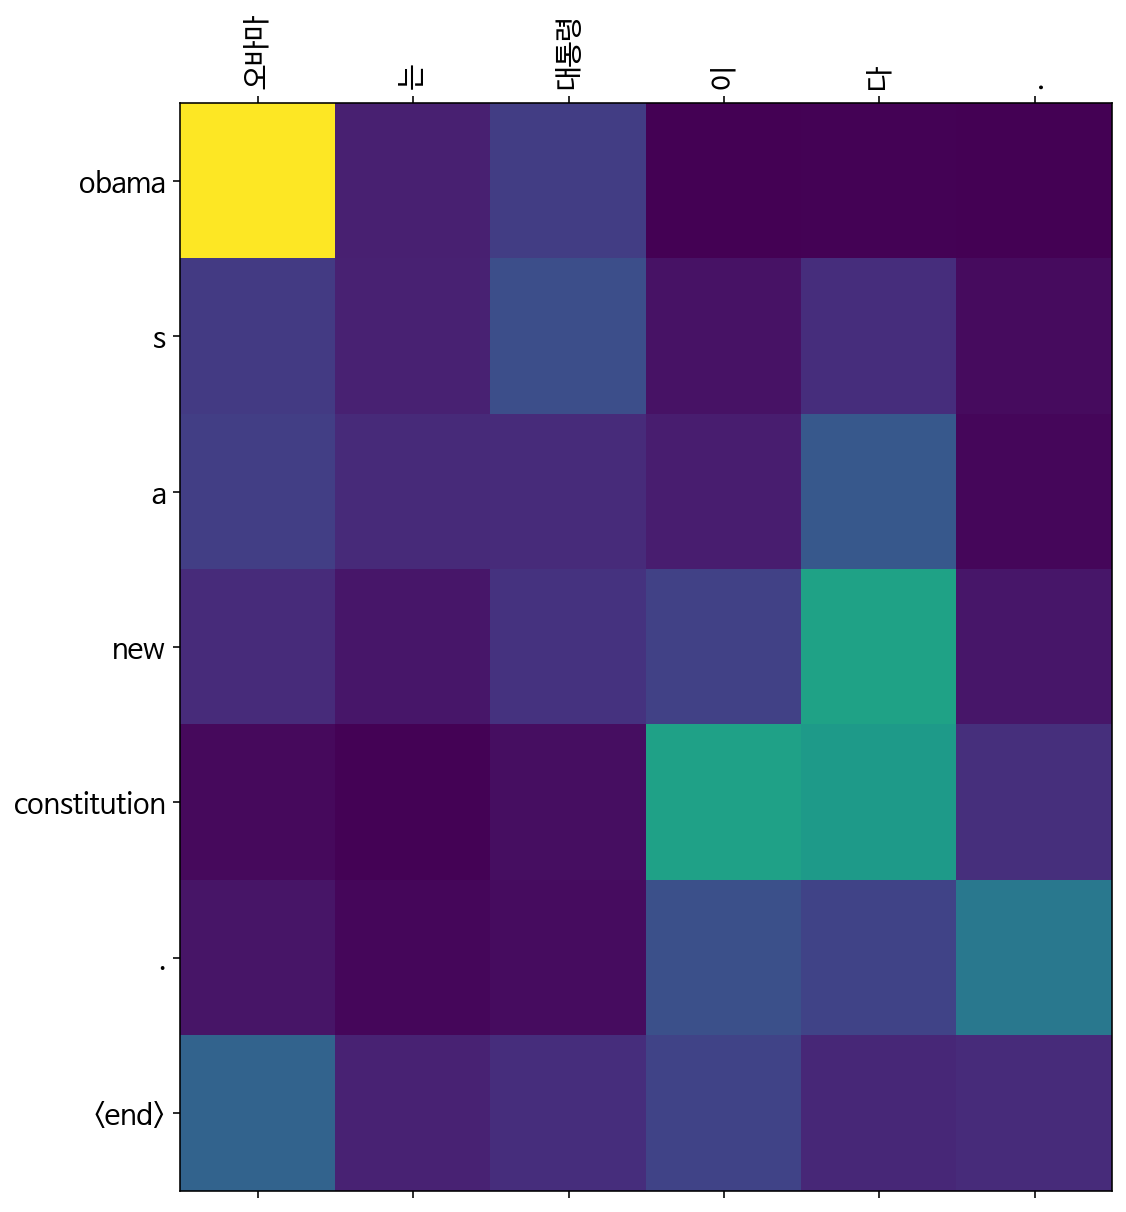

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the government is the first , or the first , and the dow is in the s . <end> 


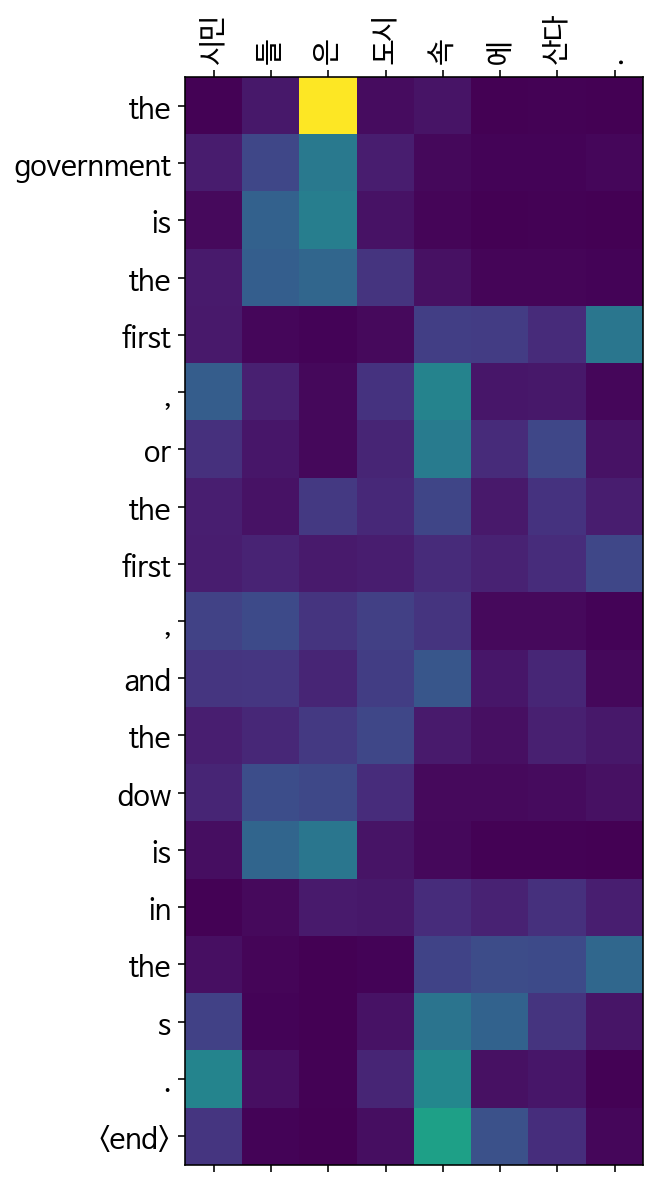

Input: 커피 는 필요 없 다 .
Predicted translation: this is not enough to get better . <end> 


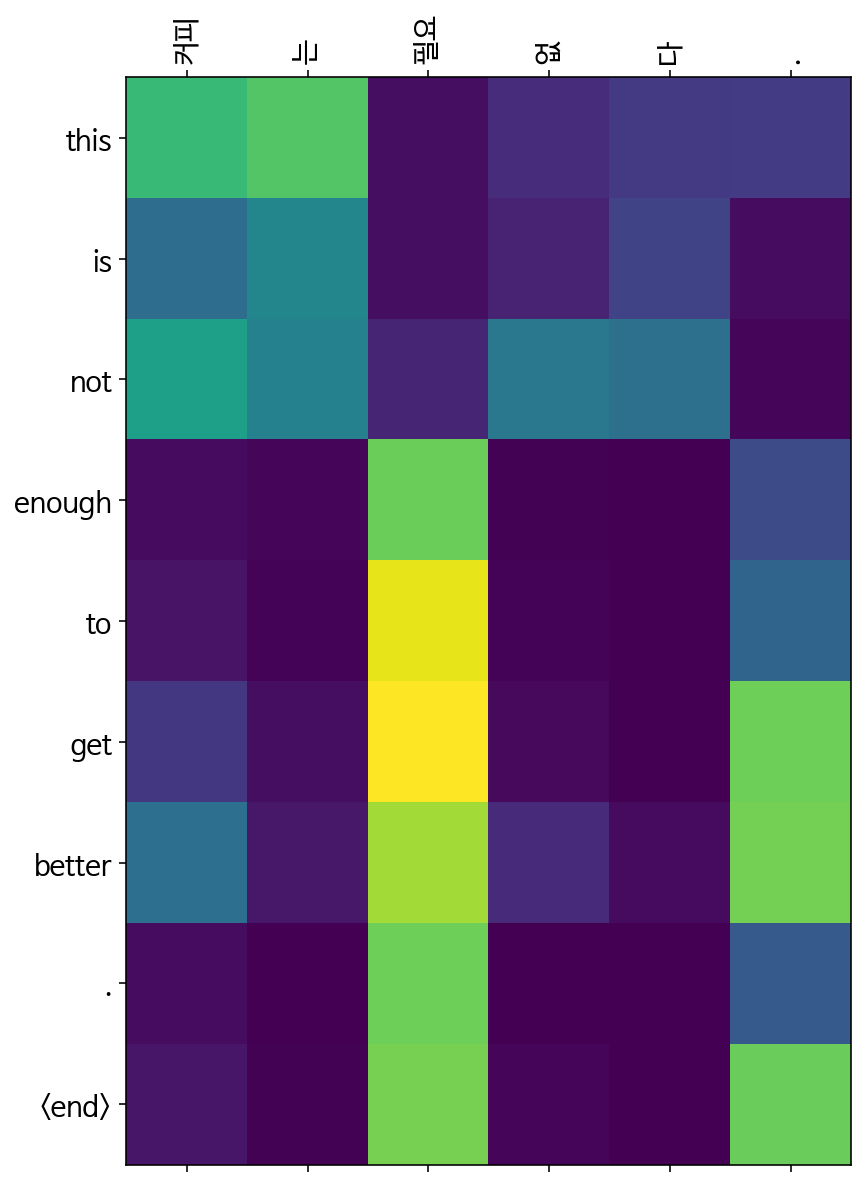

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other states was killed . <end> 


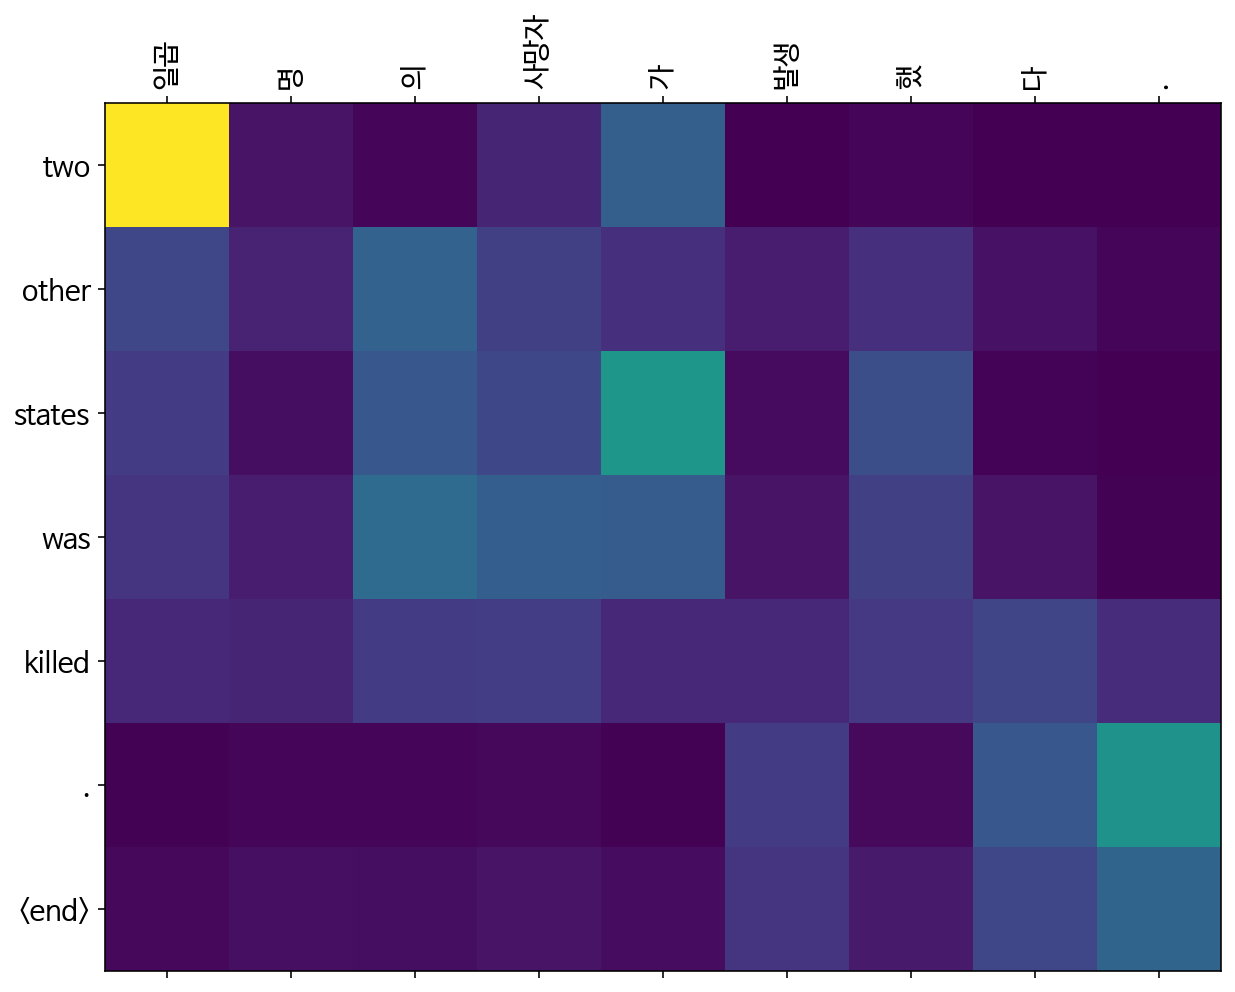

Epoch 49: 100%|██████████| 254/254 [00:55<00:00,  4.55it/s, Loss 0.5664]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s president bush s health said <end> 


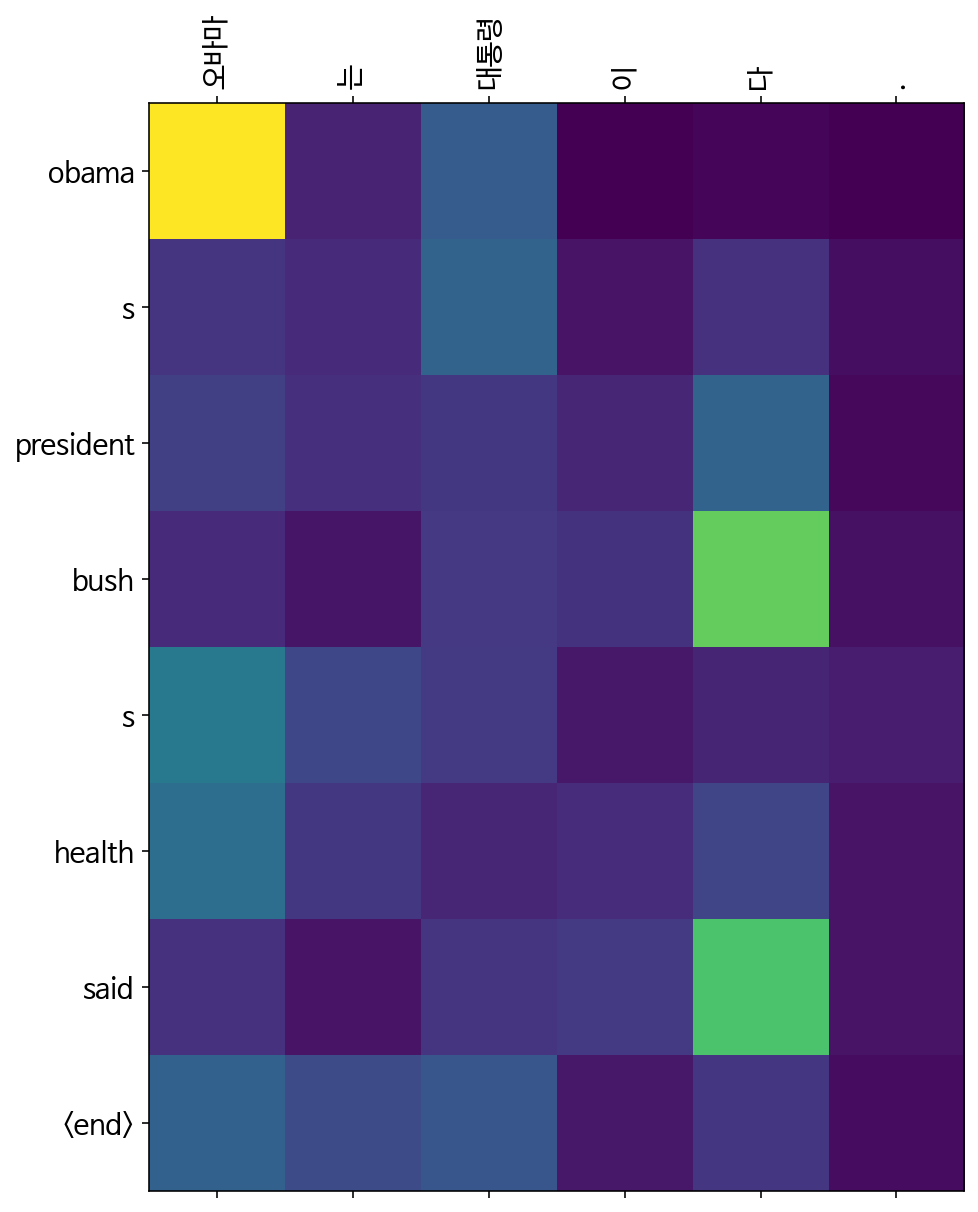

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two are about , or the first , or the first , or the first , and the dow is the first , or the first , or the first , or the first , and the dow is the first , or the first , or the first , or the first , and the dow is the first , or the first , or 


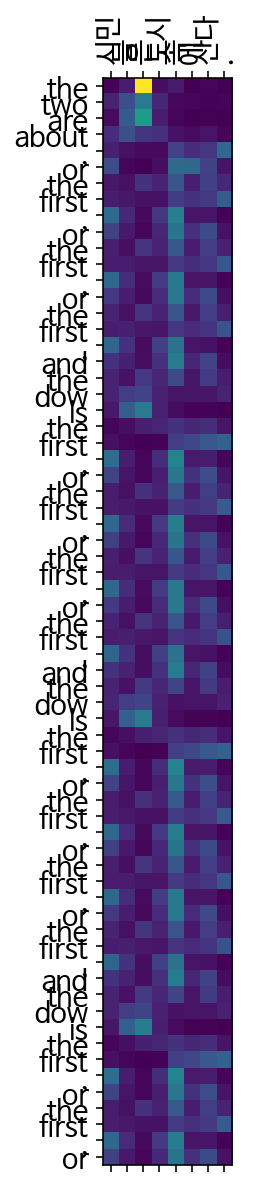

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of your goal . <end> 


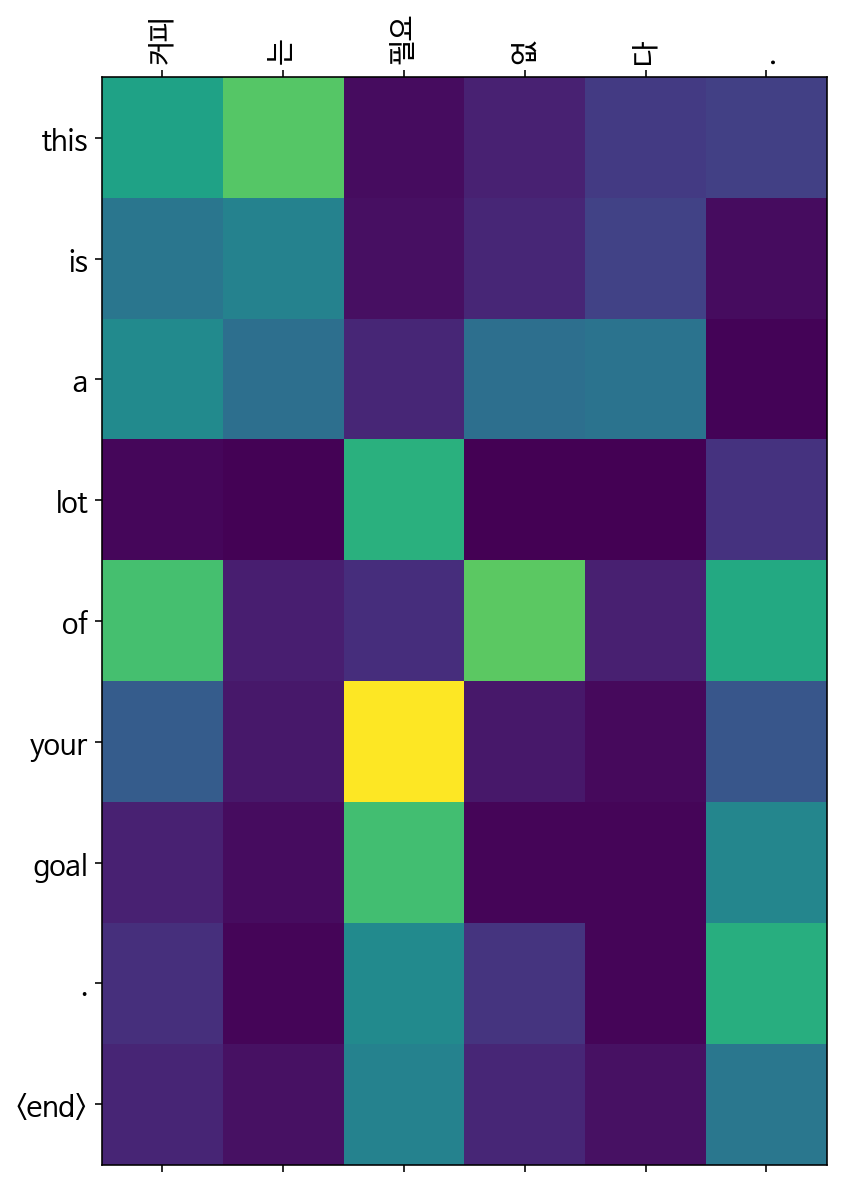

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the three of death toll from the attack . <end> 


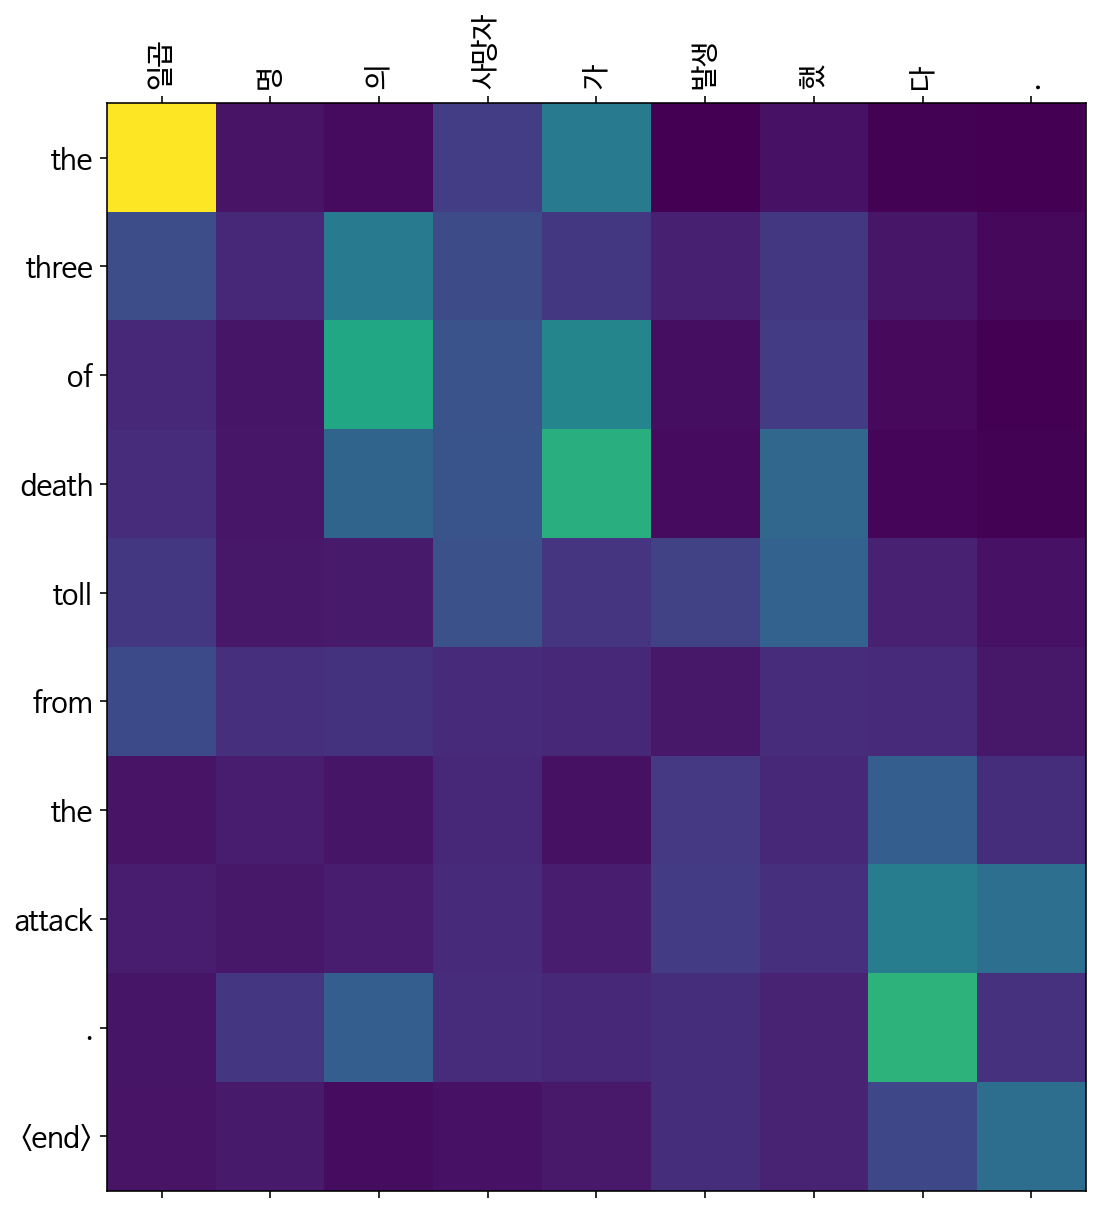

Epoch 50: 100%|██████████| 254/254 [00:55<00:00,  4.56it/s, Loss 0.5563]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama s health . <end> 


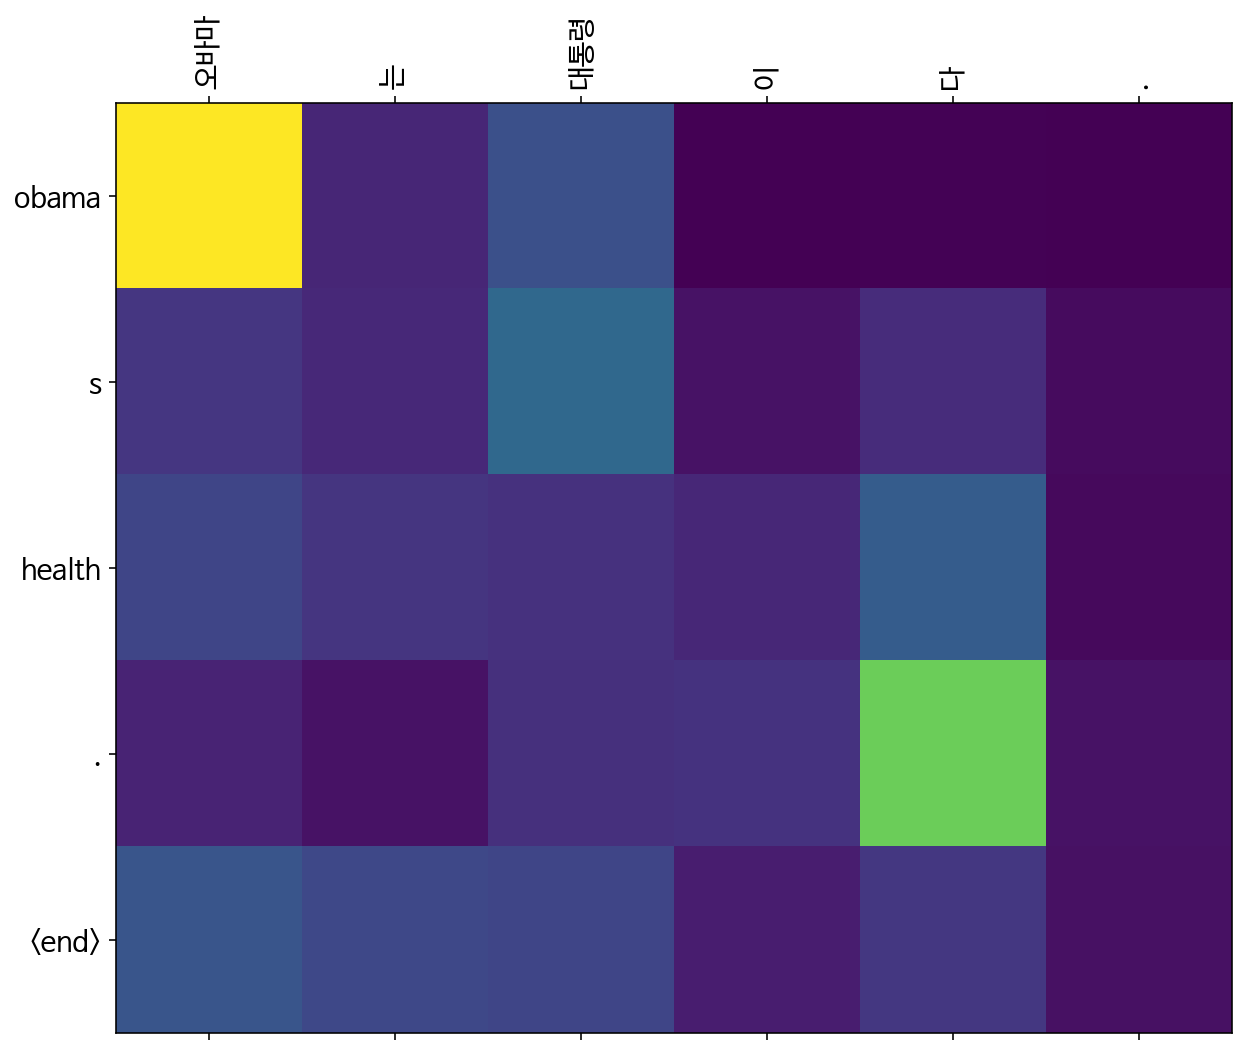

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the two of the 


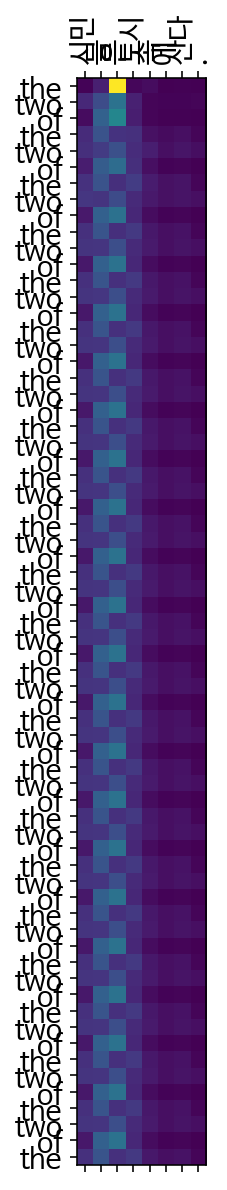

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of yours . <end> 


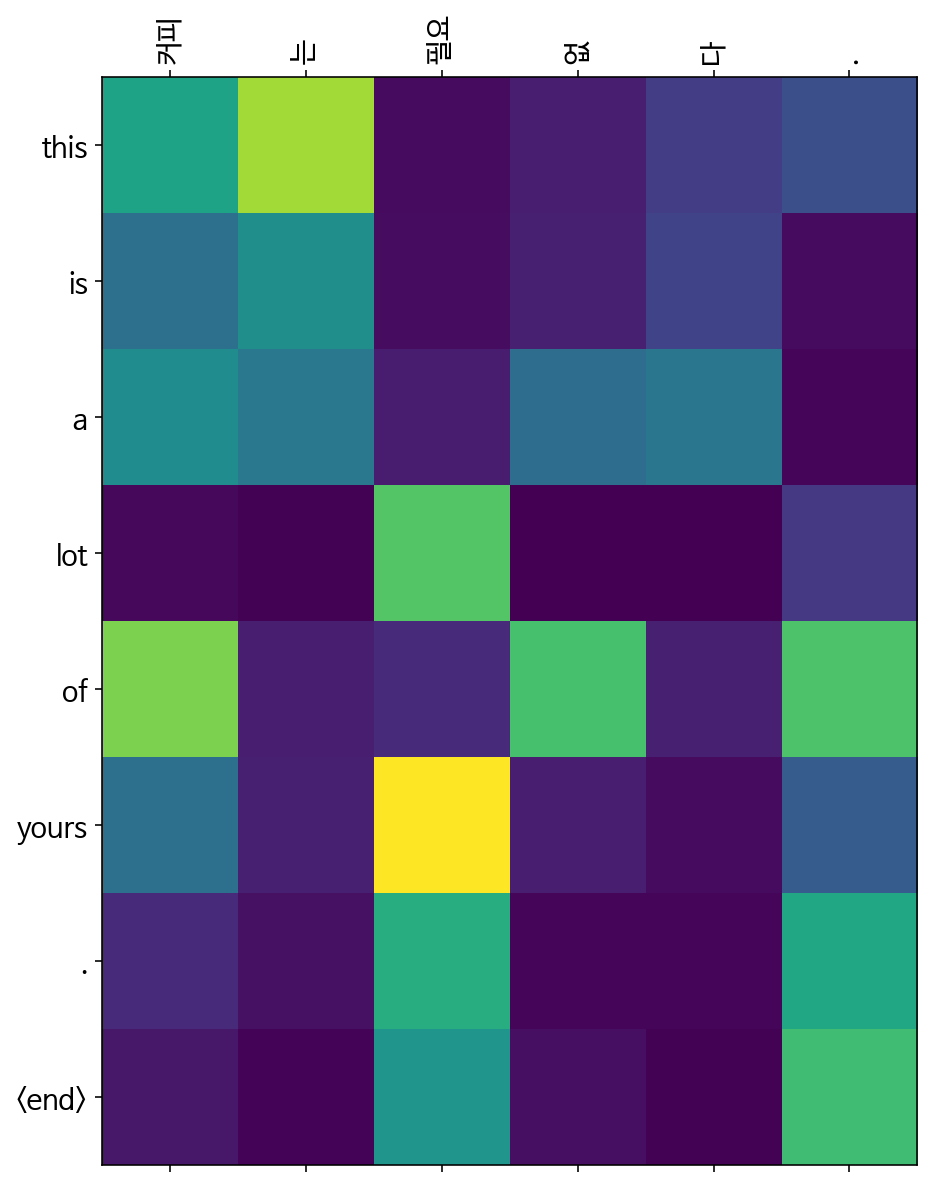

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion rose . <end> 


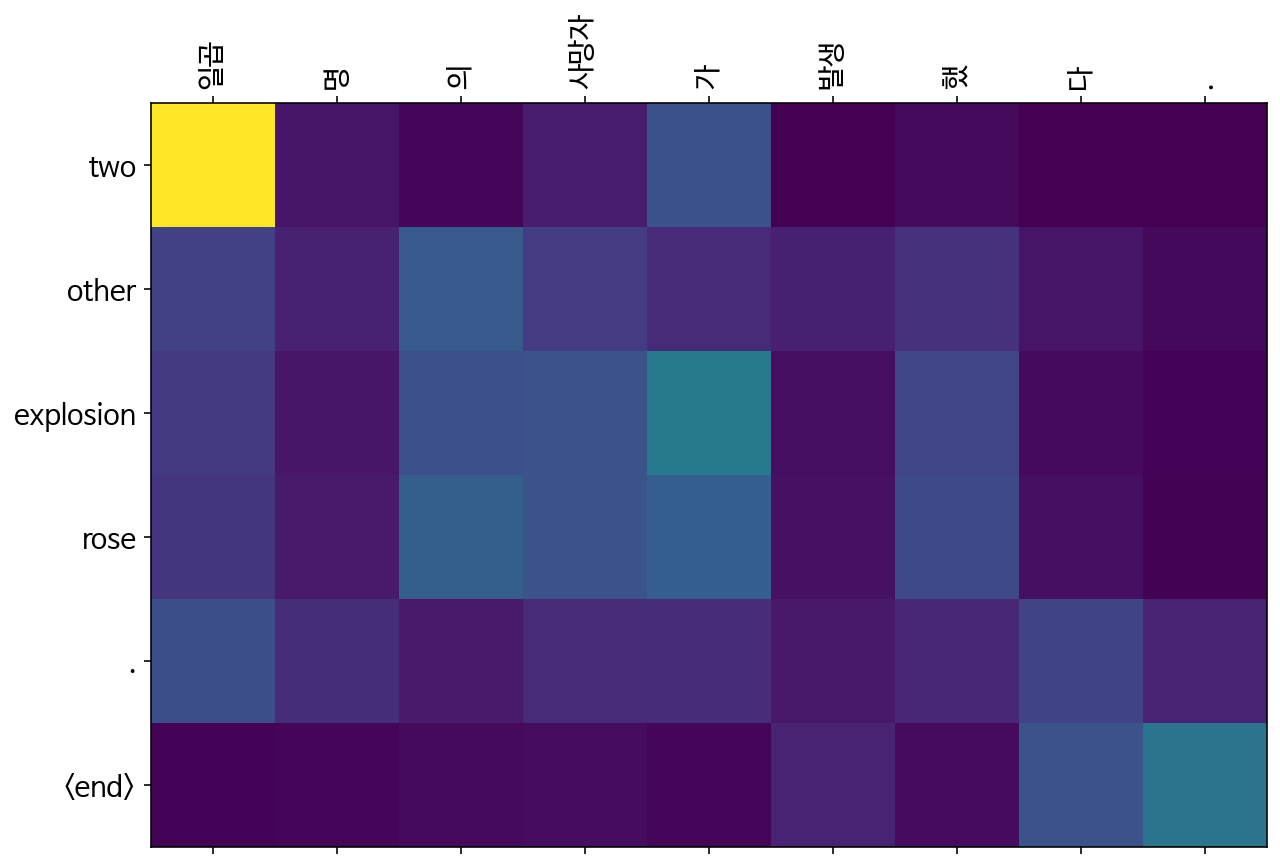

In [34]:
from tqdm import tqdm
import random

EPOCHS = 50
loss_history = []
train_model(EPOCHS)

Epoch  1: 100%|██████████| 254/254 [00:55<00:00,  4.58it/s, Loss 0.5254]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a . <end> 


/tmp/ipykernel_485/256261653.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_485/256261653.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


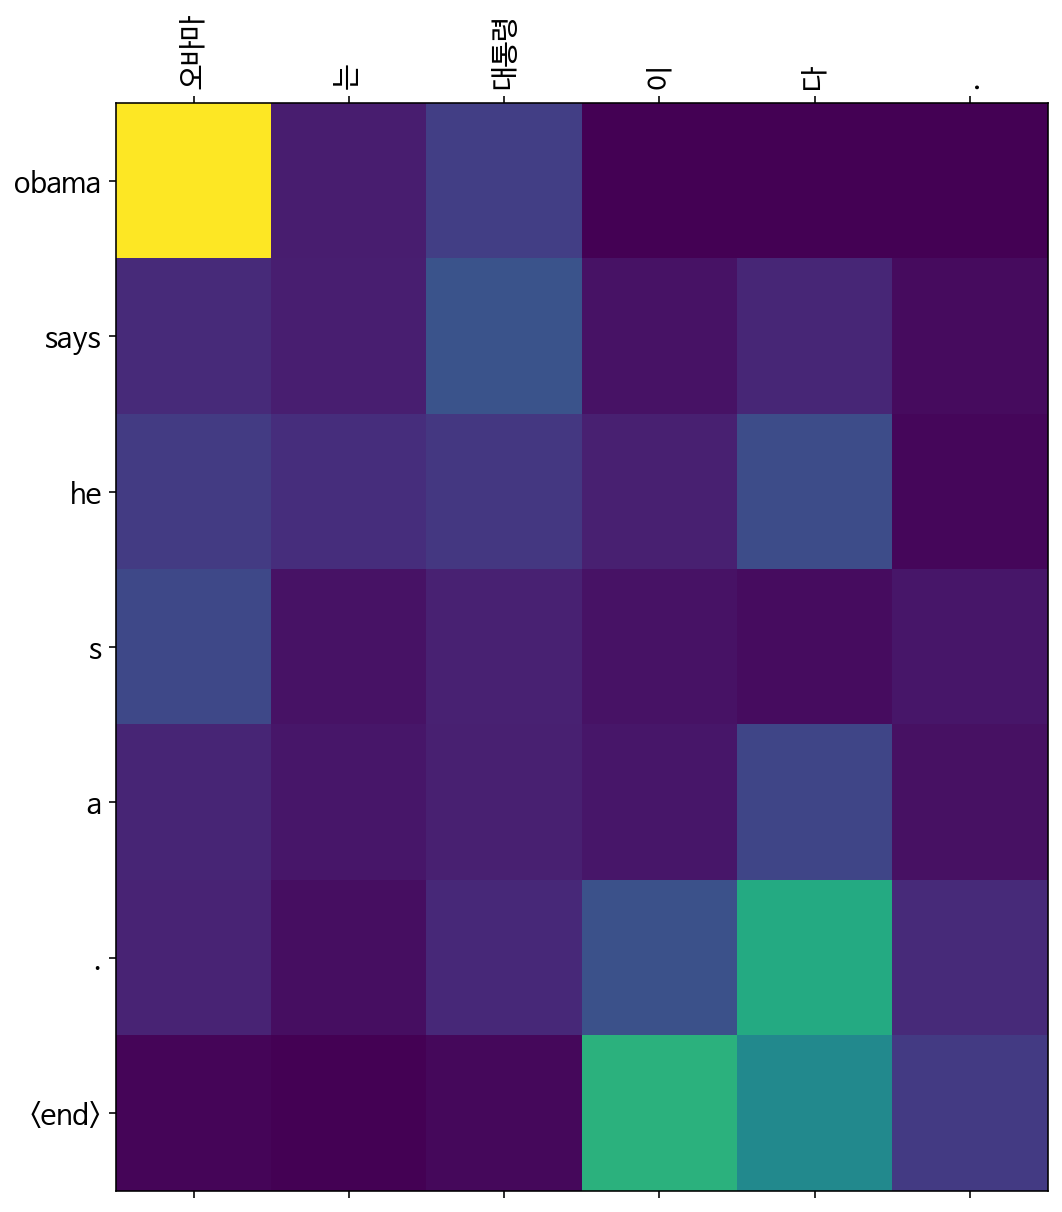

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the president george w . com . <end> 


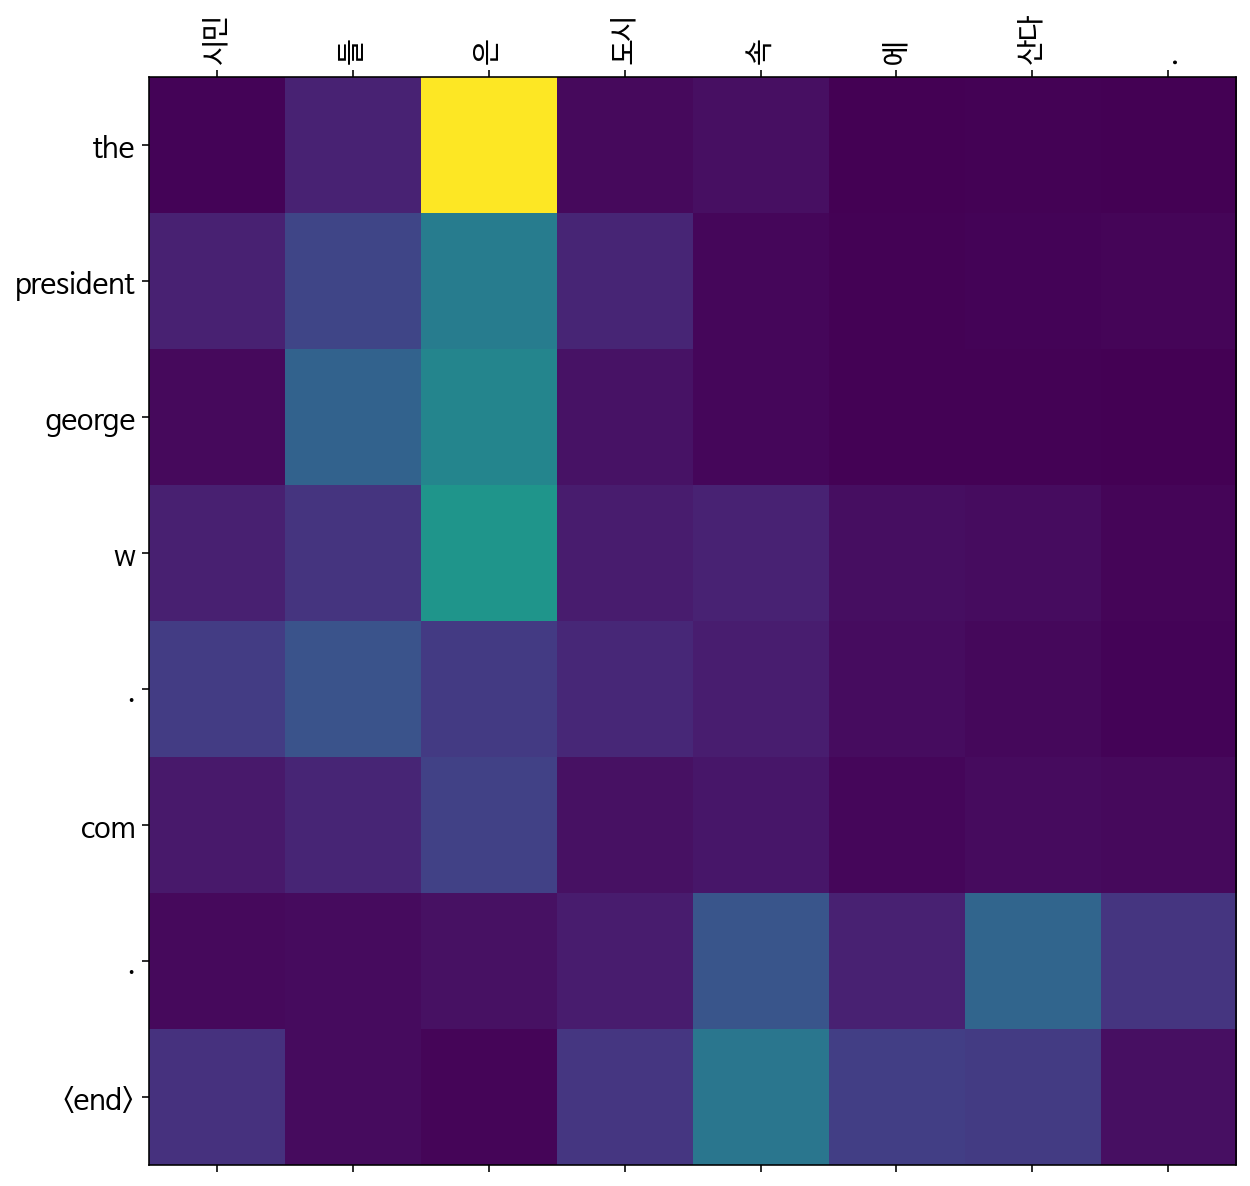

Input: 커피 는 필요 없 다 .
Predicted translation: this is also like it . <end> 


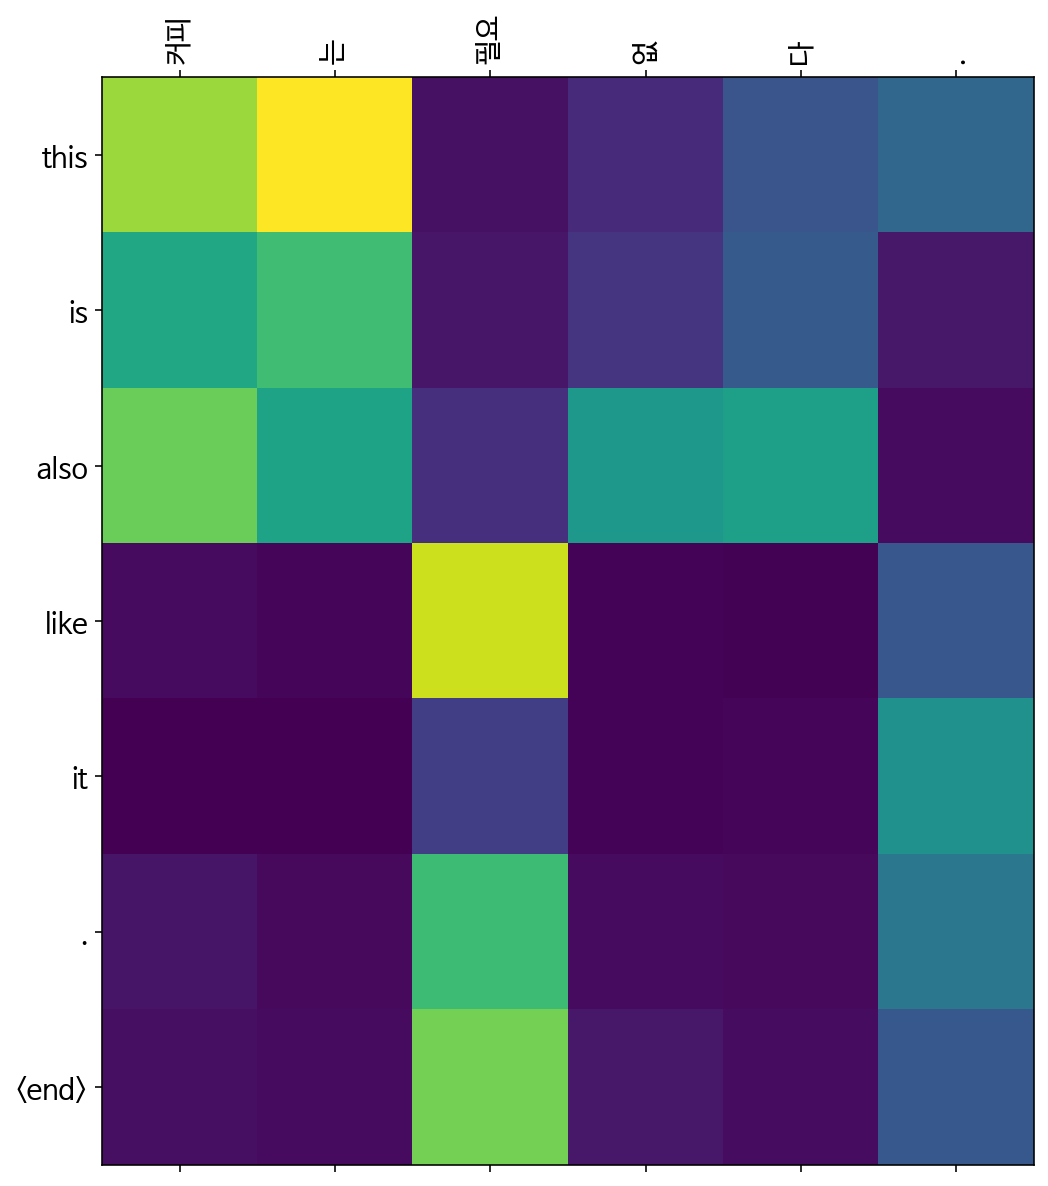

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion station , the ministry official said the attack occurred in the site , the ministry official said the attack occurred in the site , the ministry official said the attack occurred in the site , the ministry official said the attack occurred in the site , the ministry official said the attack occurred in the site , the ministry official said the attack occurred 


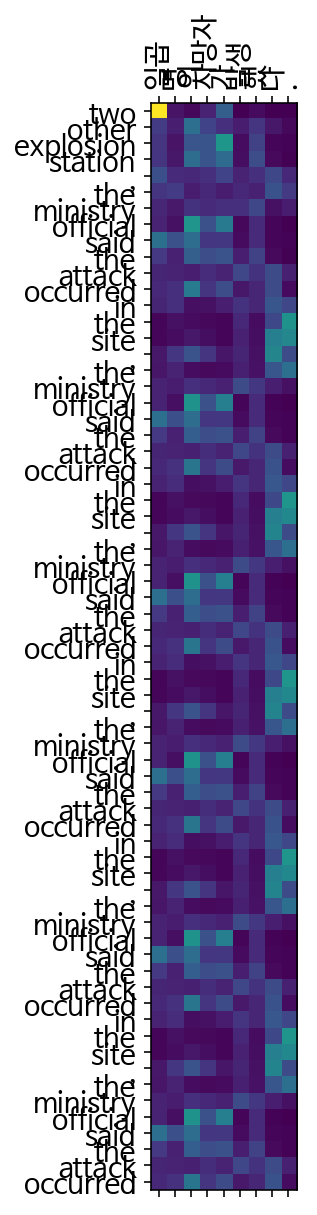

Epoch  2: 100%|██████████| 254/254 [00:55<00:00,  4.59it/s, Loss 0.5183]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new constitution and sadness about the president . <end> 


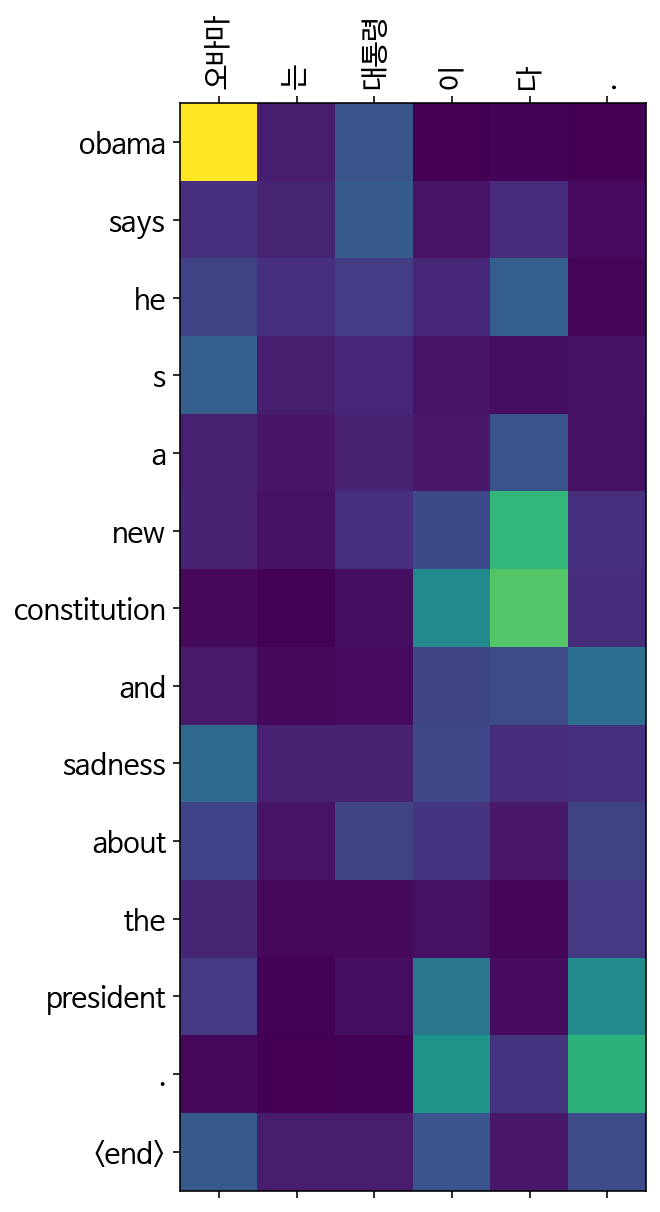

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: many of course , and was . <end> 


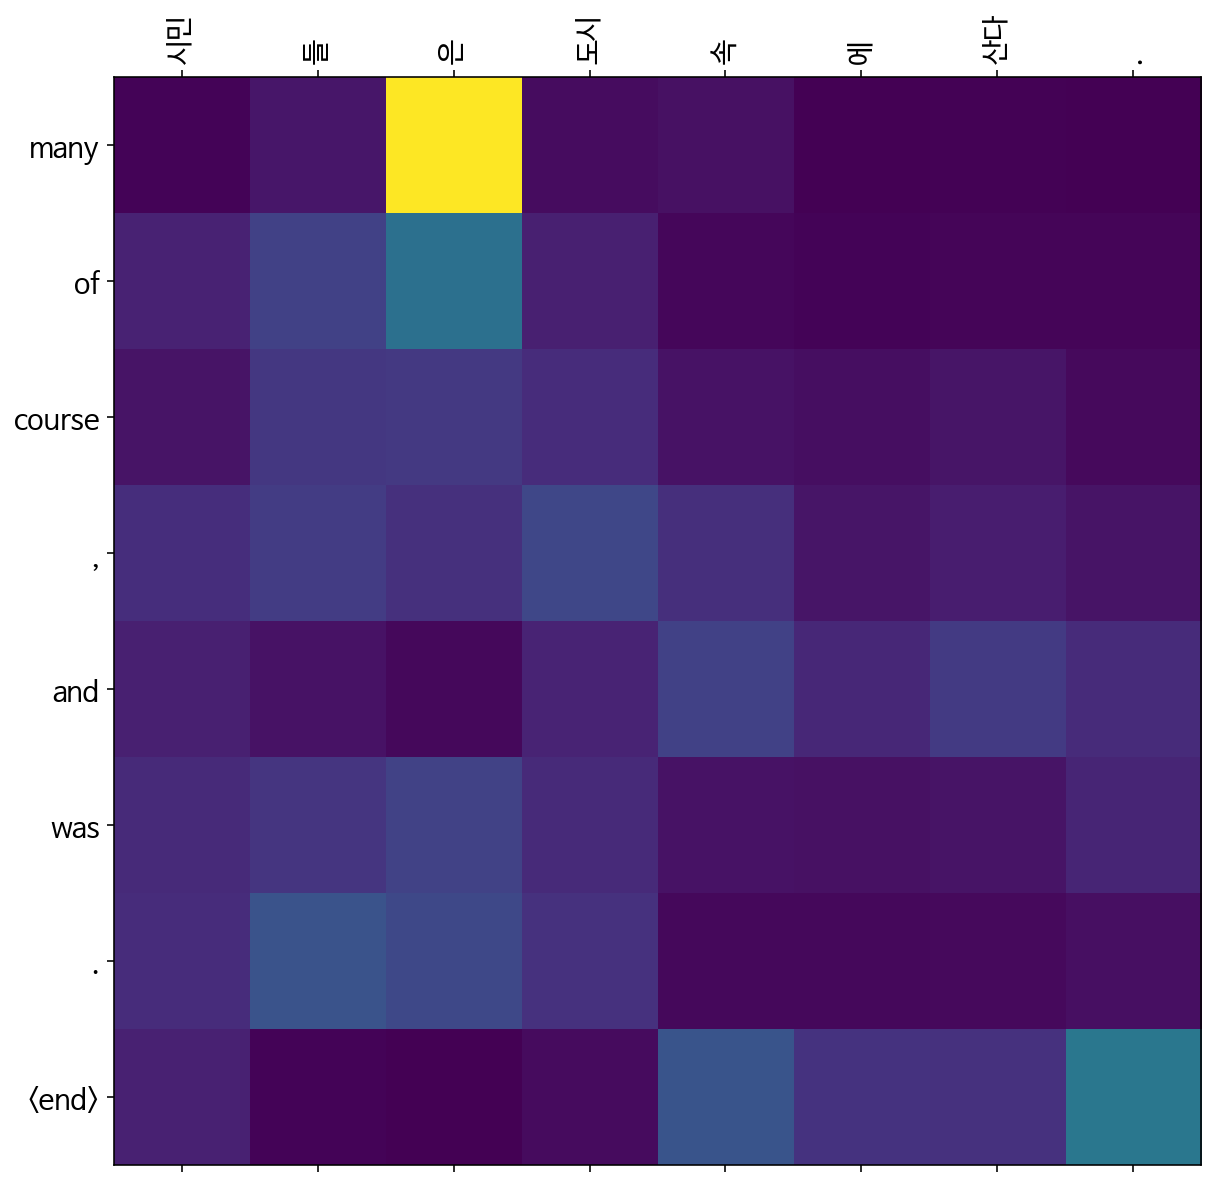

Input: 커피 는 필요 없 다 .
Predicted translation: this is not interested in the street . <end> 


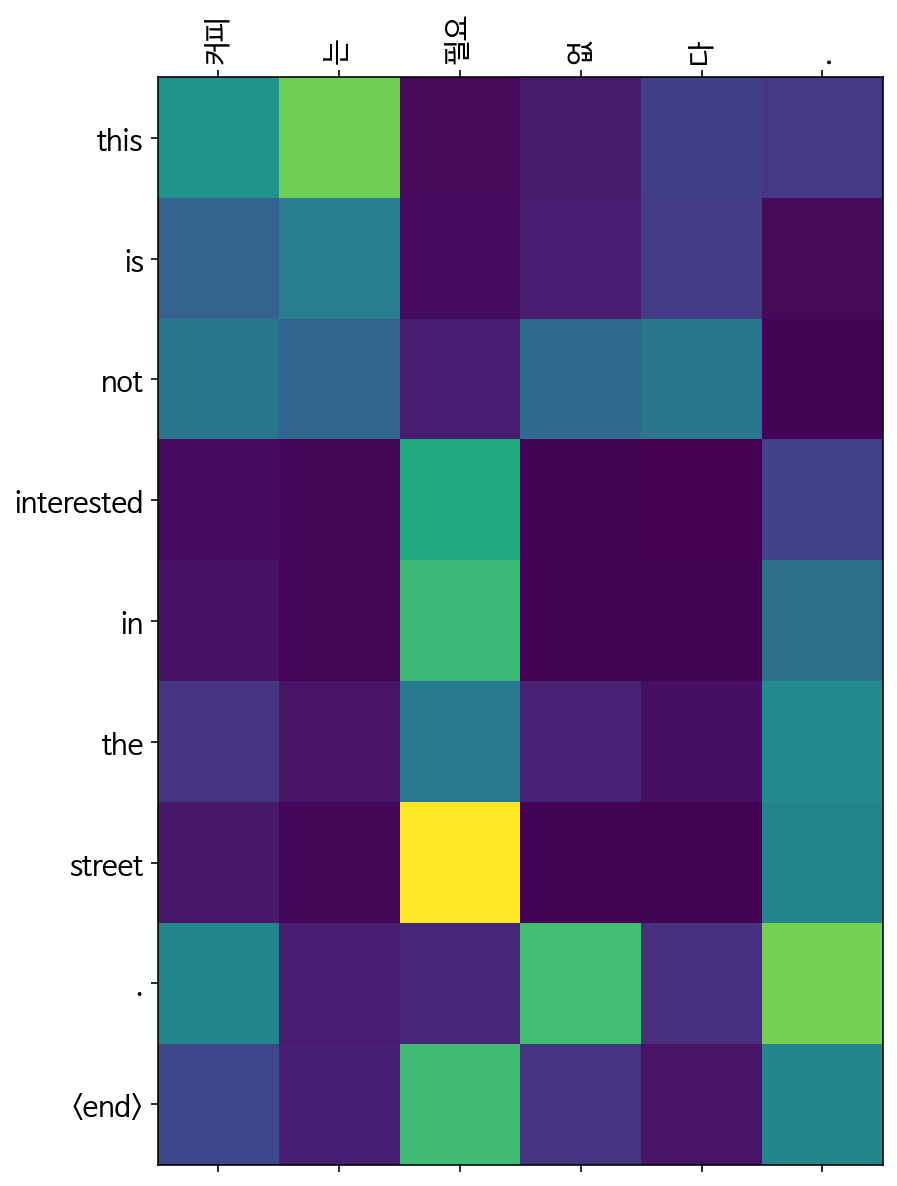

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: the attack occurred in the attack . <end> 


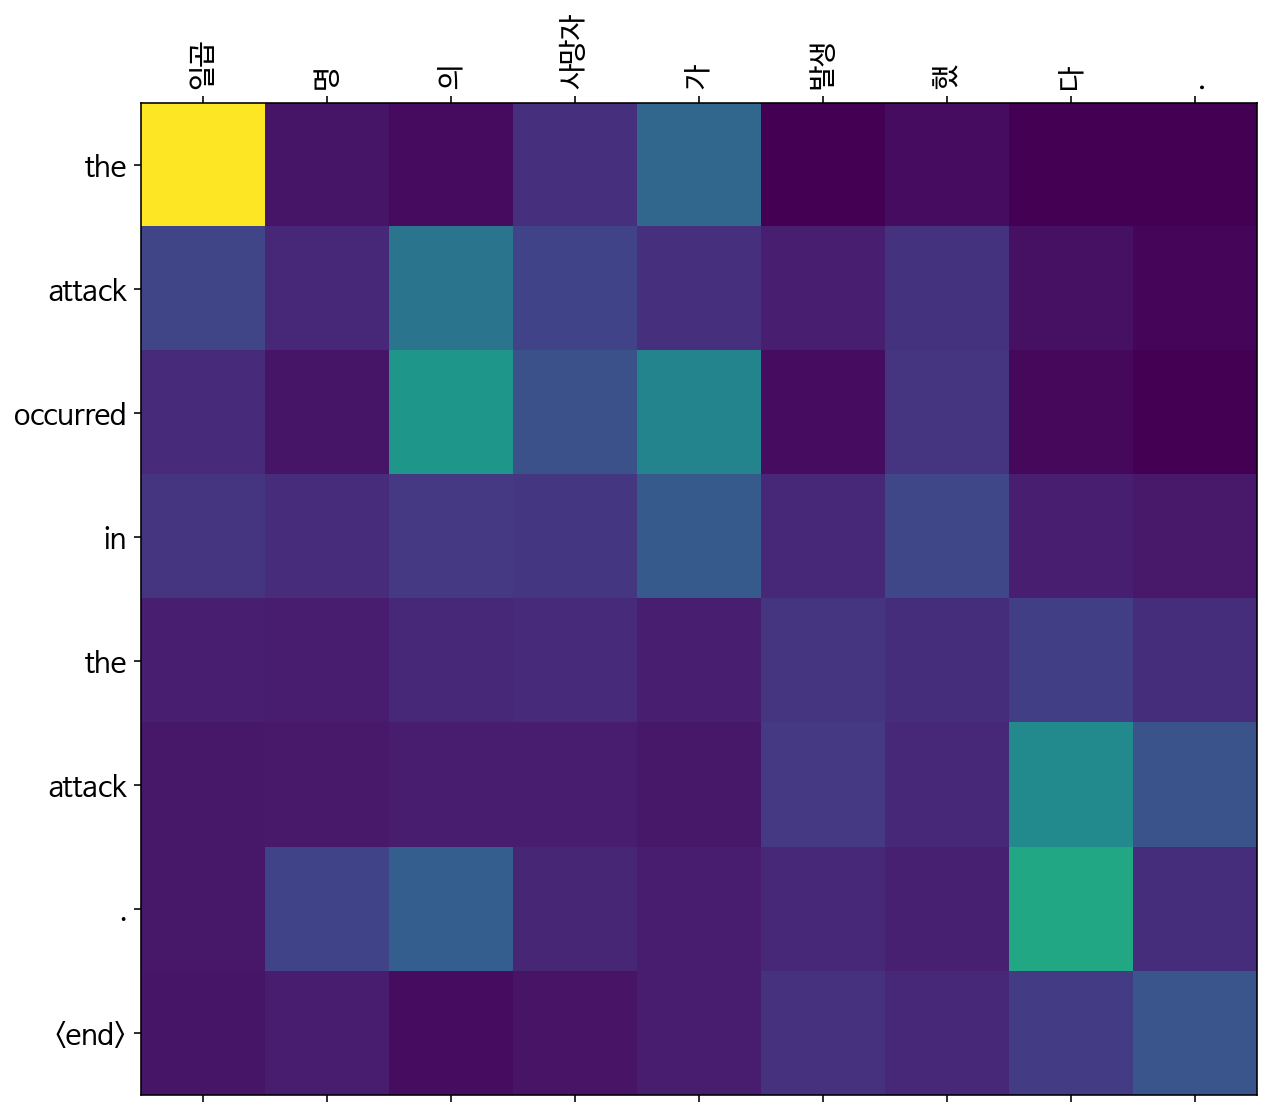

Epoch  3: 100%|██████████| 254/254 [00:56<00:00,  4.52it/s, Loss 0.5105]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says he s a new president . <end> 


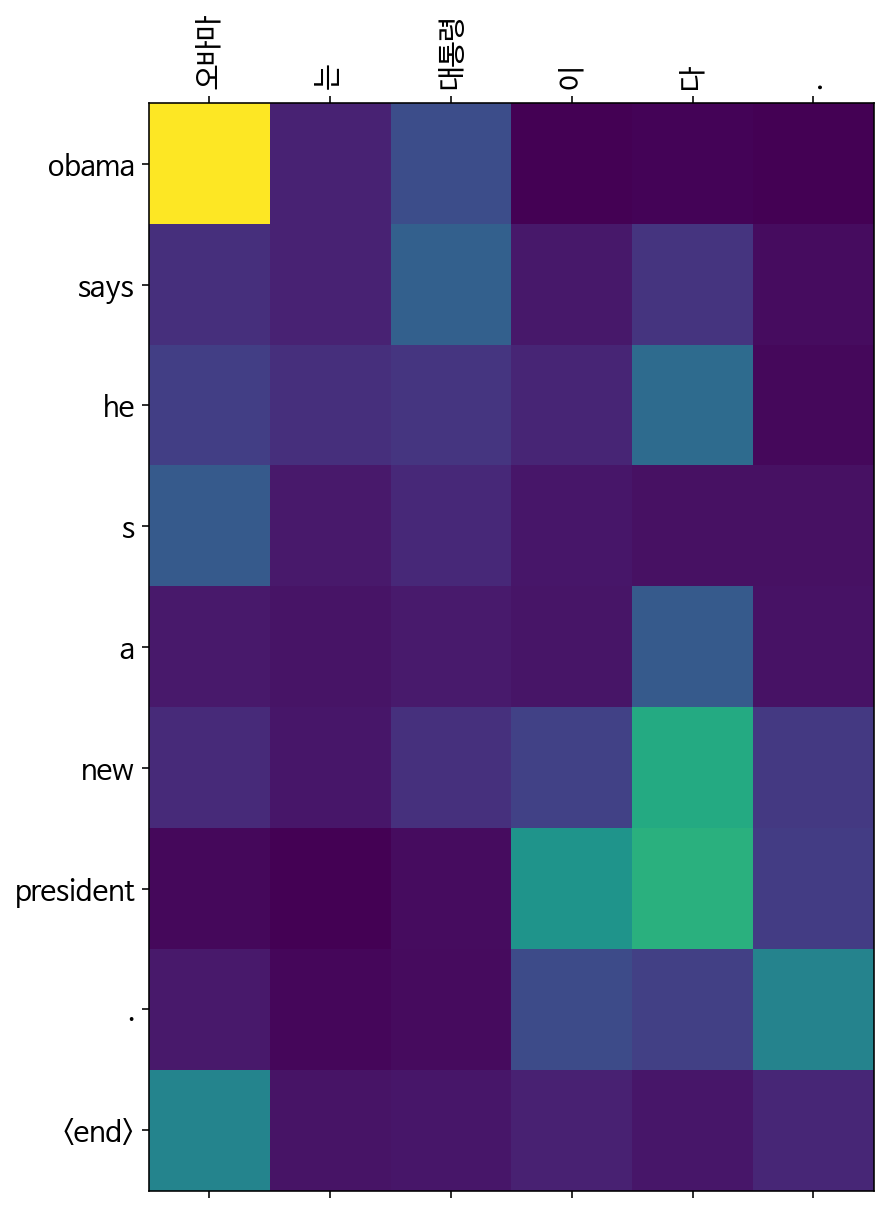

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: there is now at . <end> 


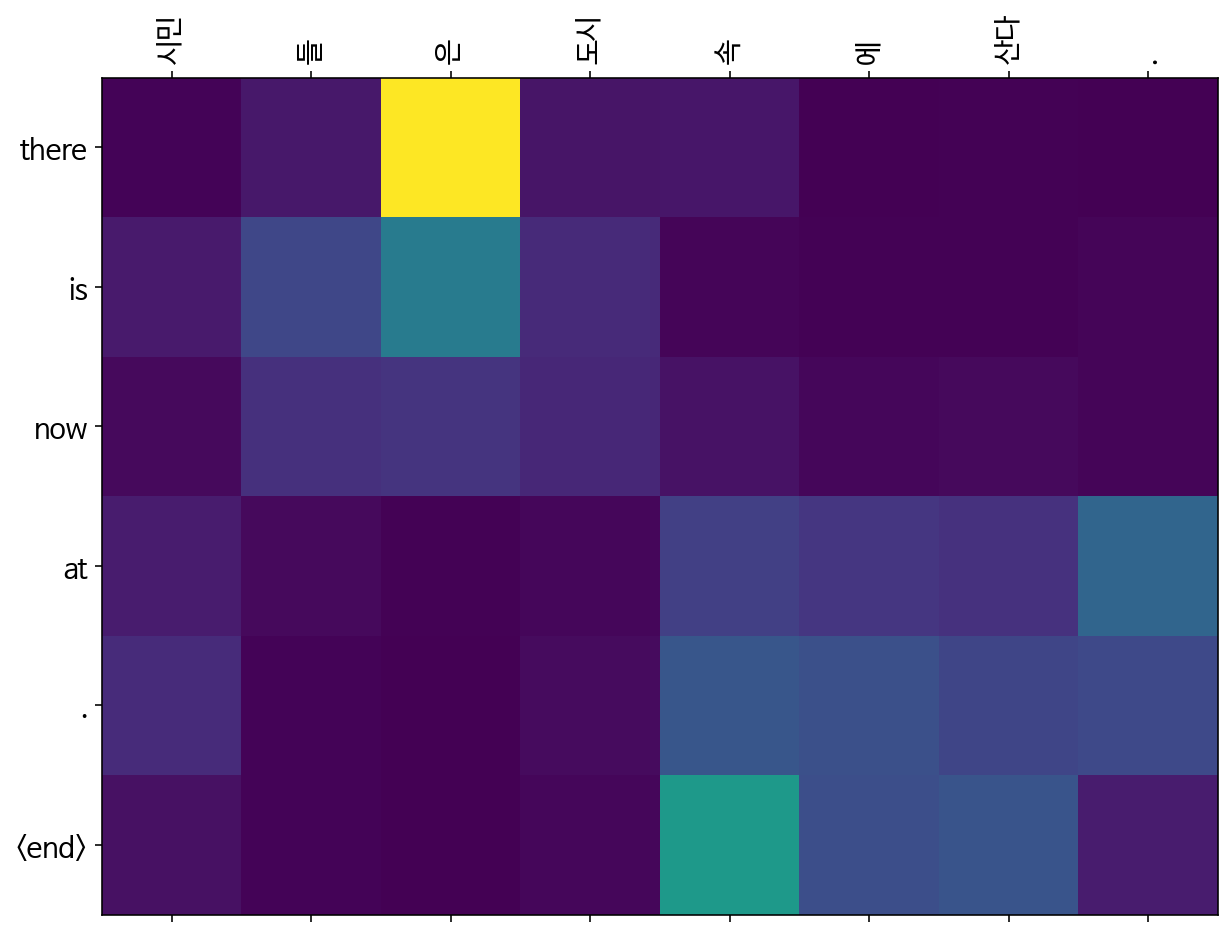

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of yours . <end> 


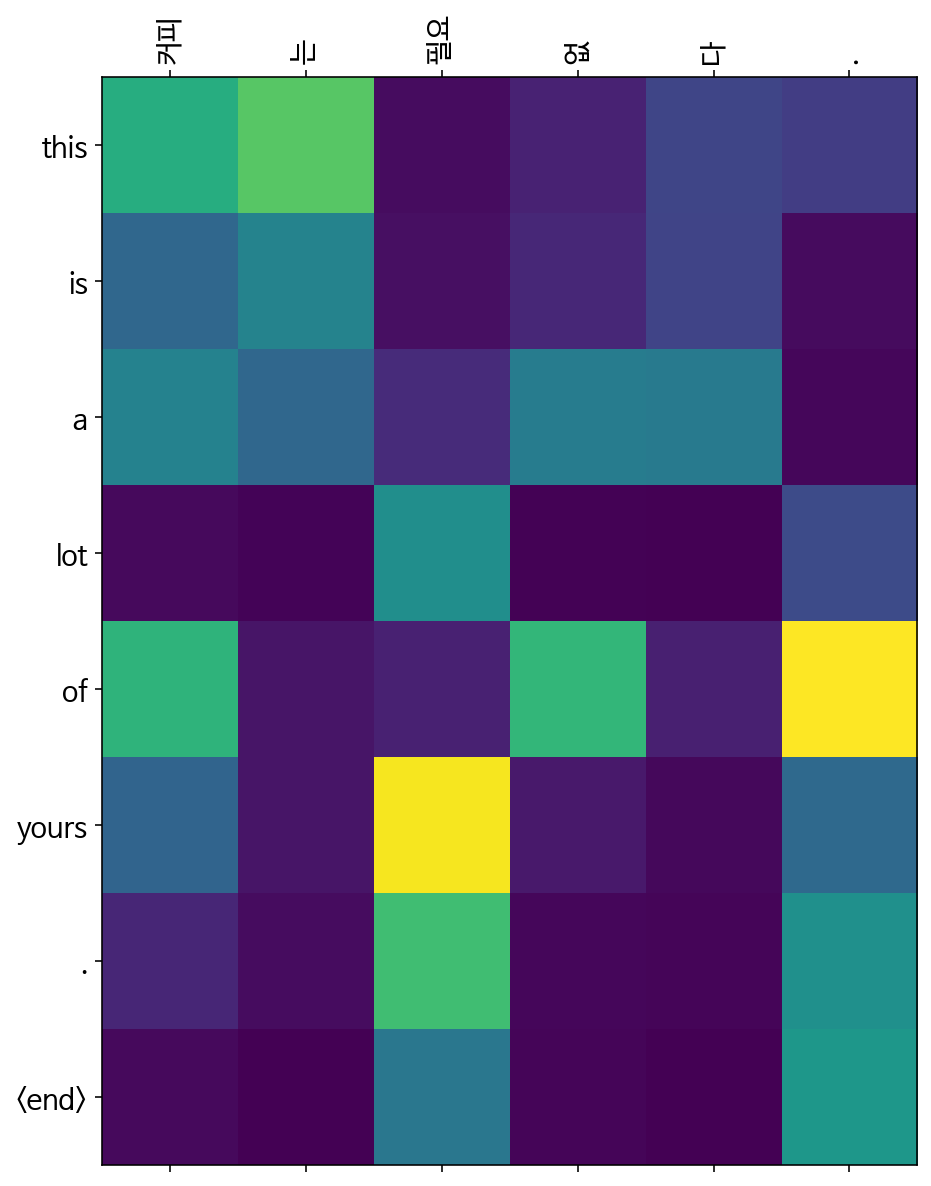

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion station , the death toll was the first time , the ministry of people were killed by the attack . <end> 


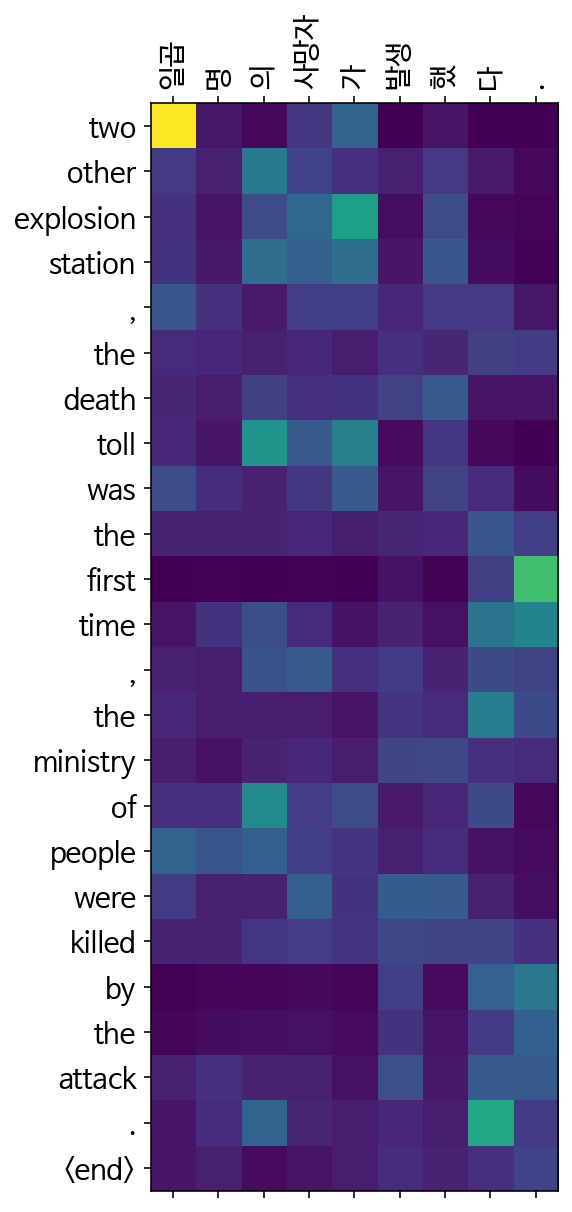

Epoch  4: 100%|██████████| 254/254 [00:55<00:00,  4.54it/s, Loss 0.5053]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama calls on the president . <end> 


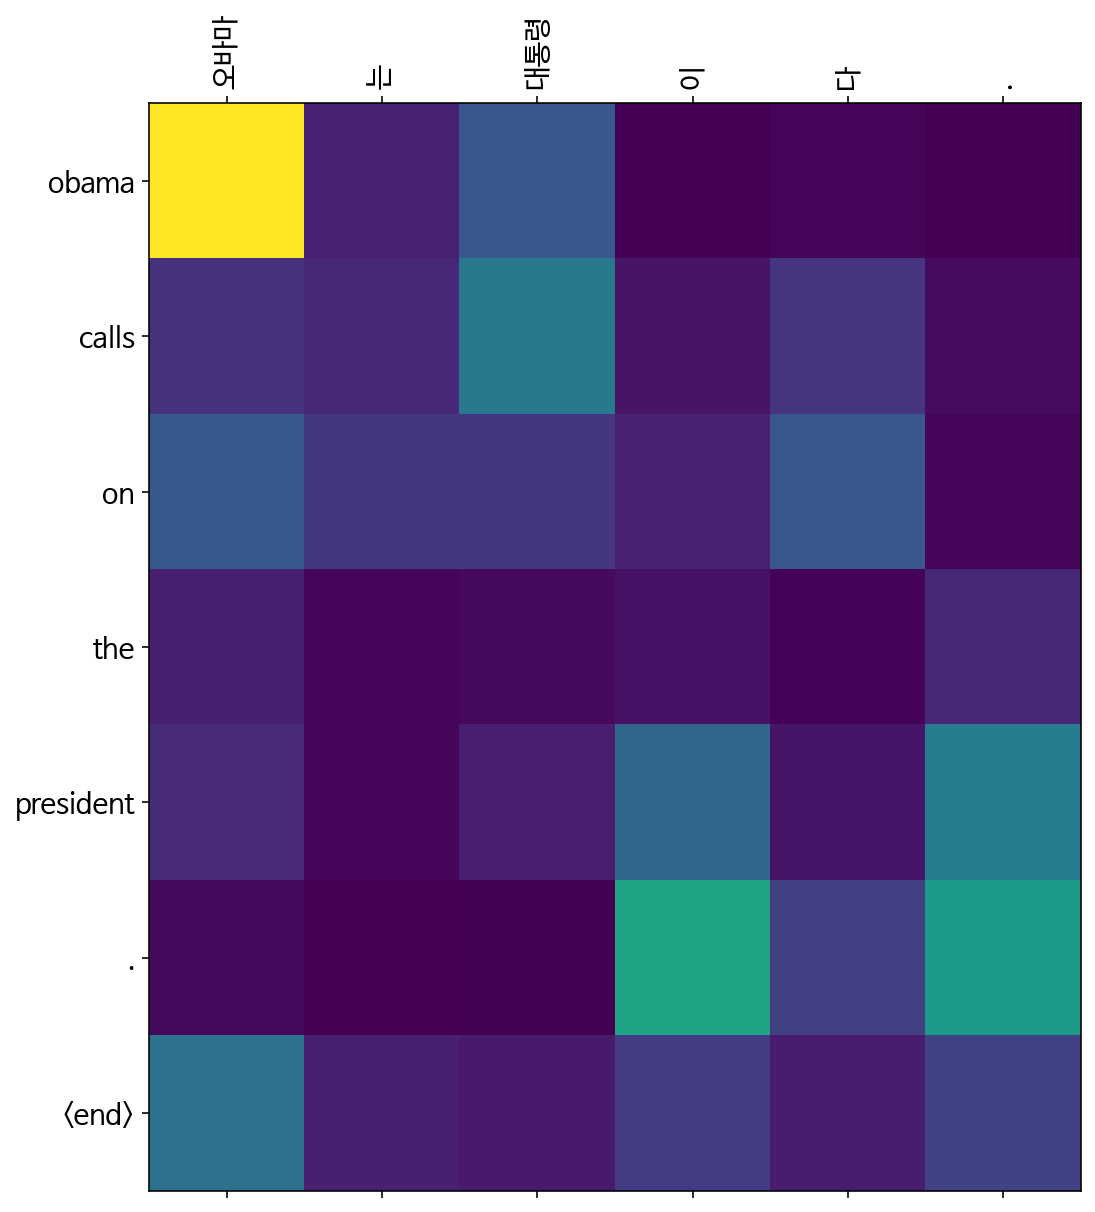

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: many of course , and was not in the s . <end> 


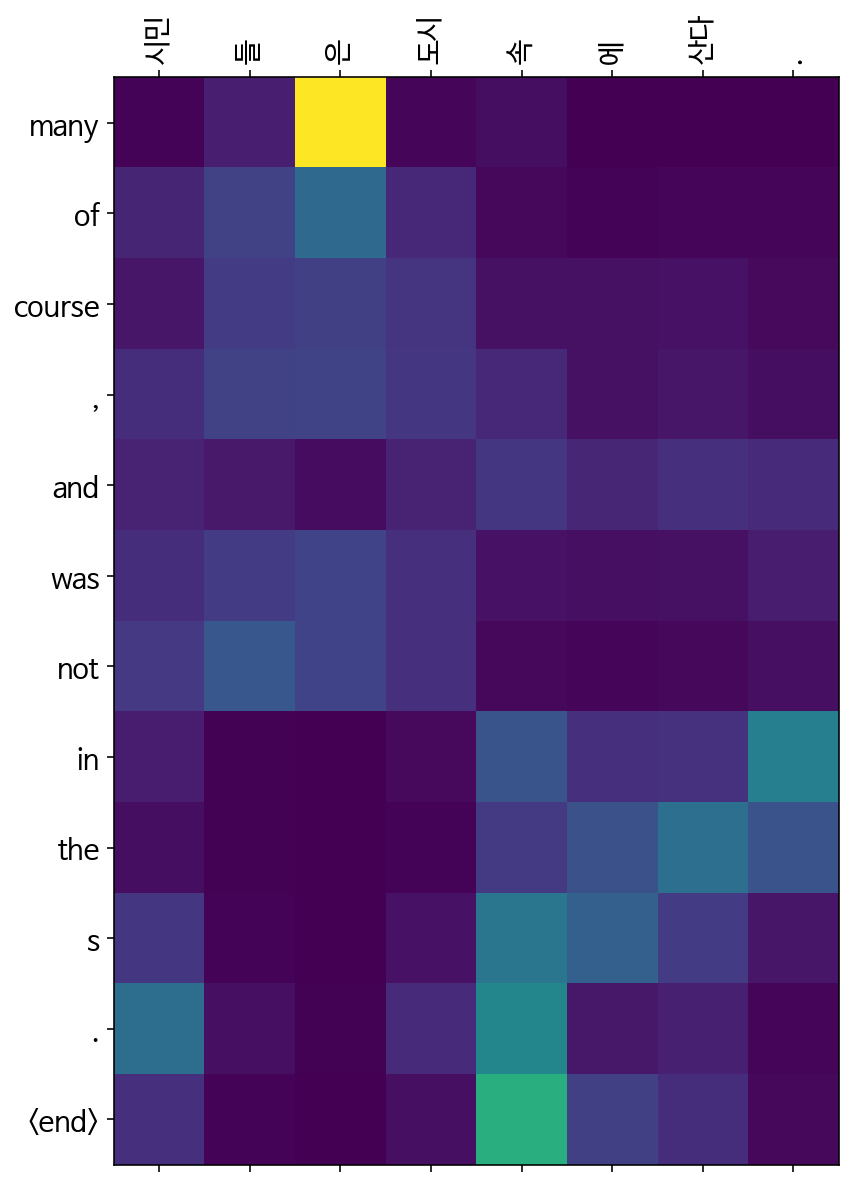

Input: 커피 는 필요 없 다 .
Predicted translation: this is also like a lot of twilight , but so i think you can be a lot of twilight , but so i think you can be a lot of twilight , but so i think you can be a lot of twilight , but so i think you can be a lot of twilight , but so i think you can be a lot of 


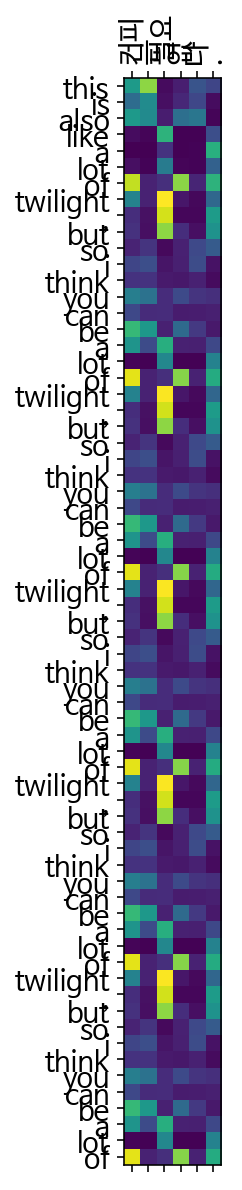

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion station , the death toll from the attack . <end> 


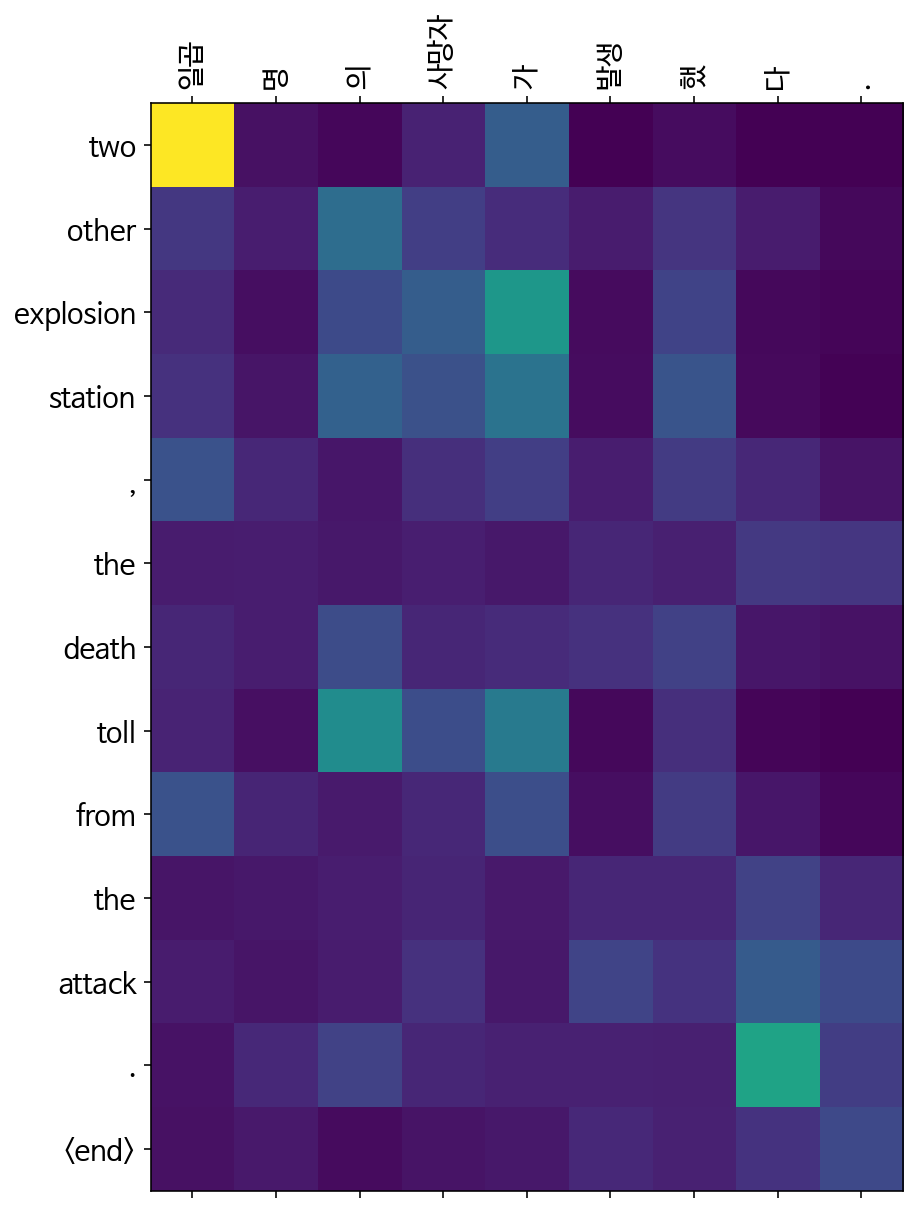

Epoch  5: 100%|██████████| 254/254 [00:55<00:00,  4.54it/s, Loss 0.4983]


Input: 오바마 는 대통령 이 다 .
Predicted translation: obama says it s . <end> 


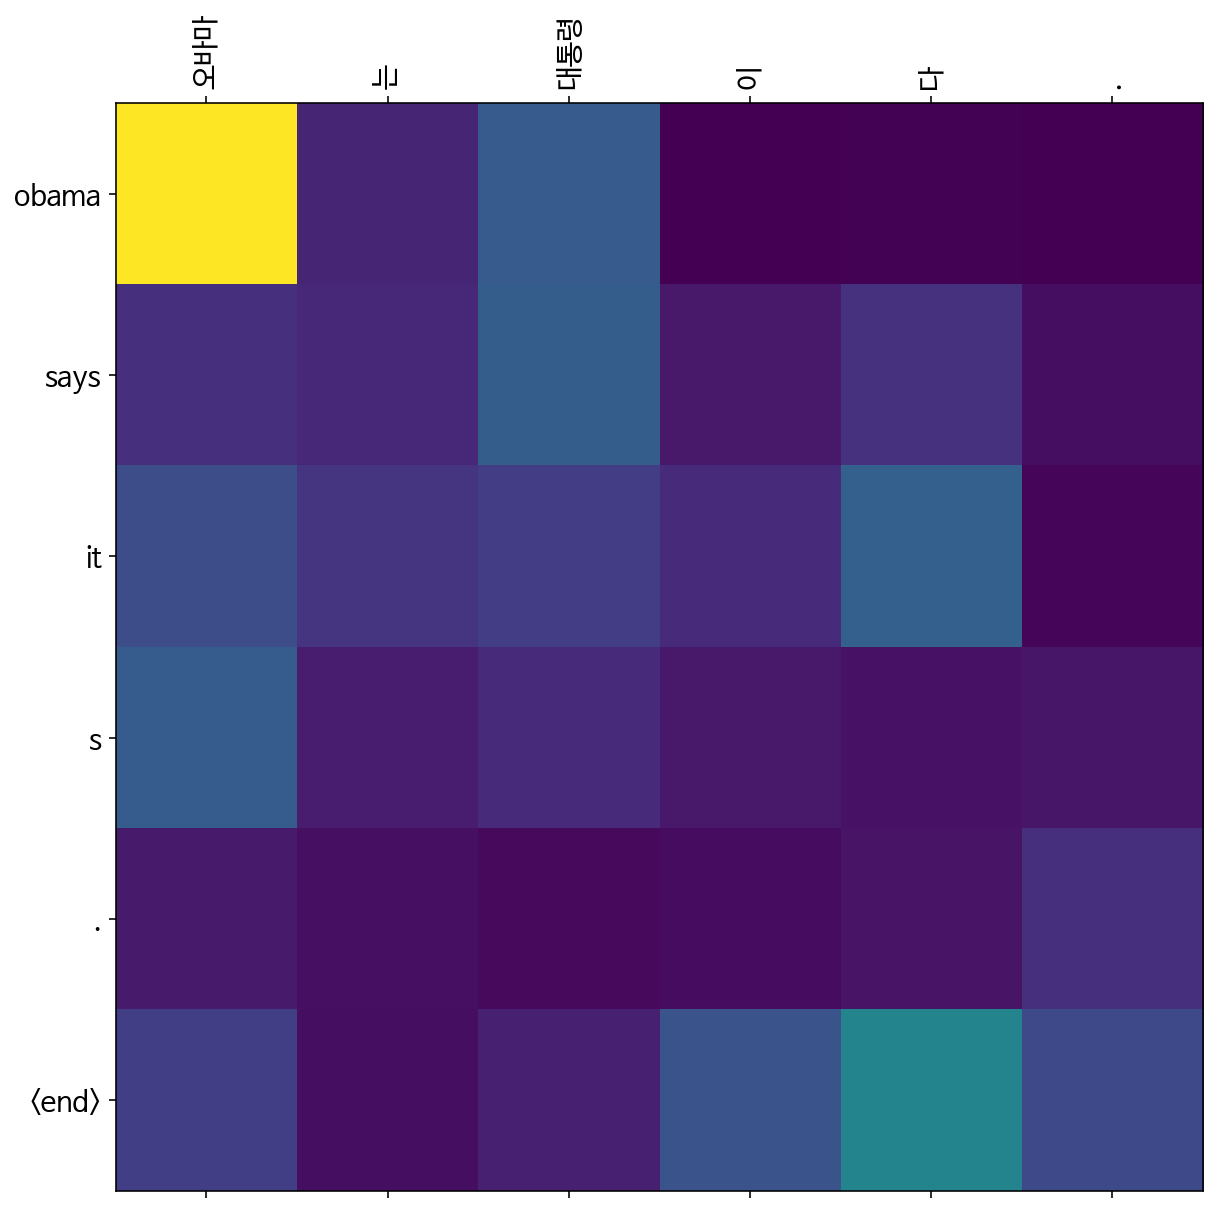

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: the two of them have to the s . <end> 


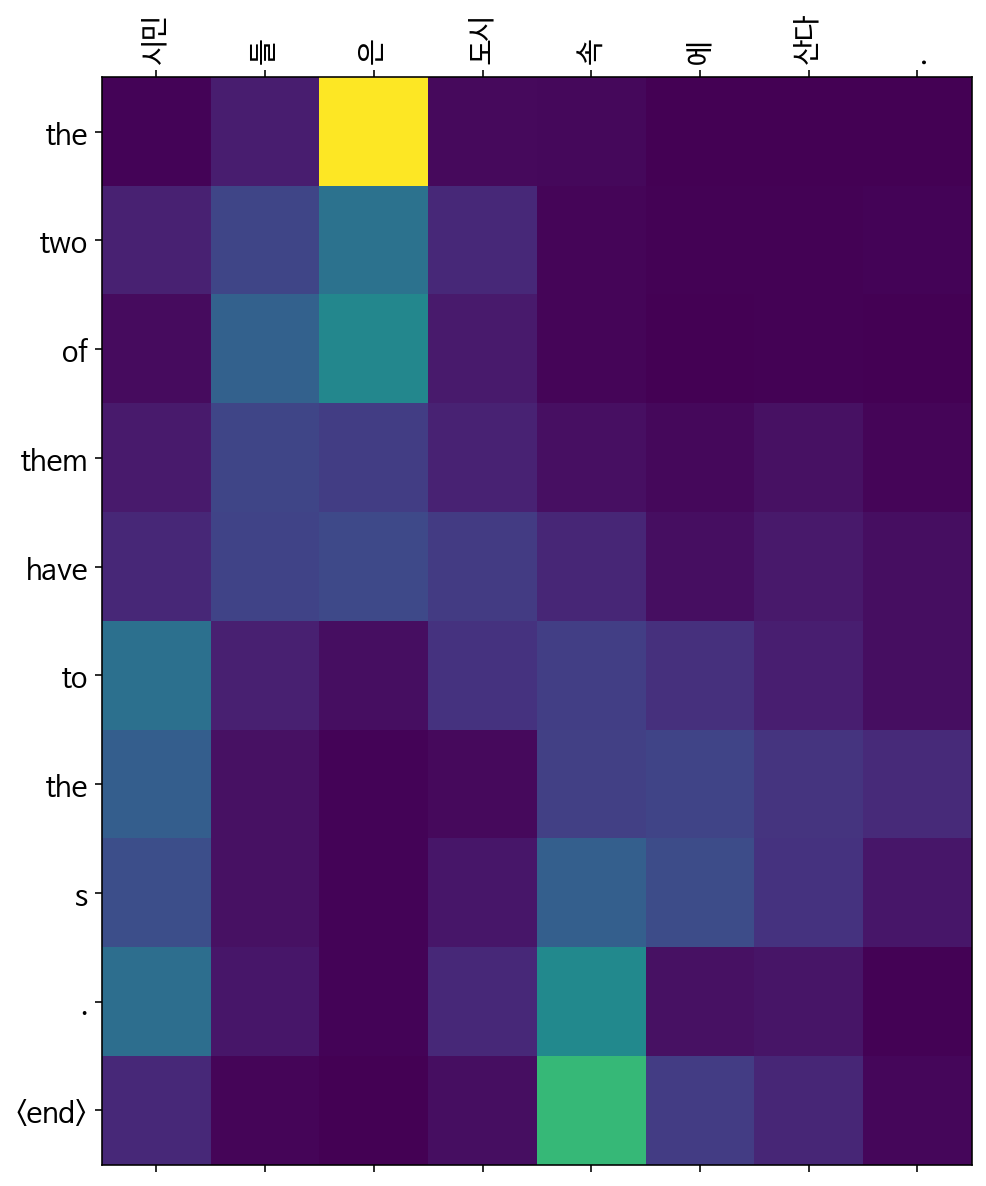

Input: 커피 는 필요 없 다 .
Predicted translation: this is a lot of yours . <end> 


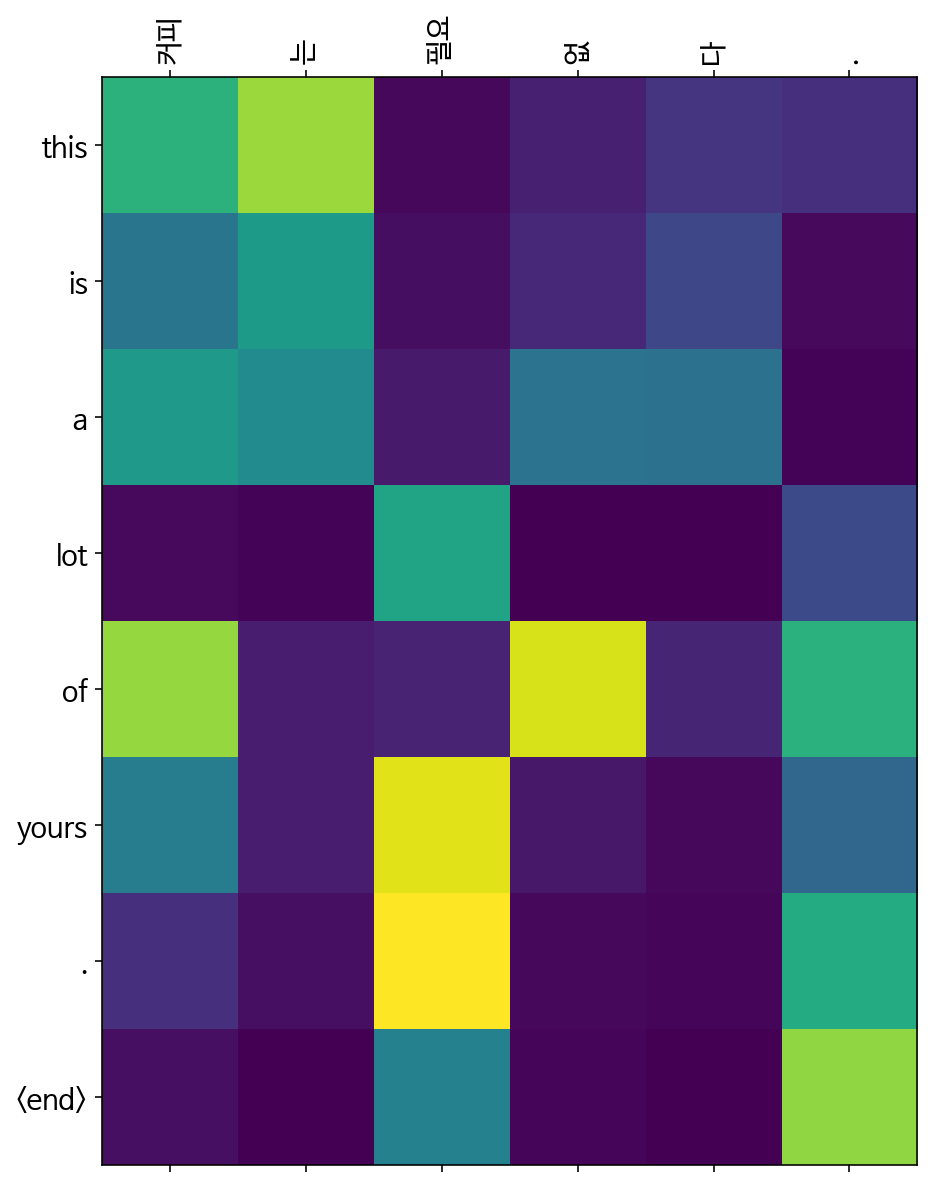

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two other explosion station , the death toll was released in the site . <end> 


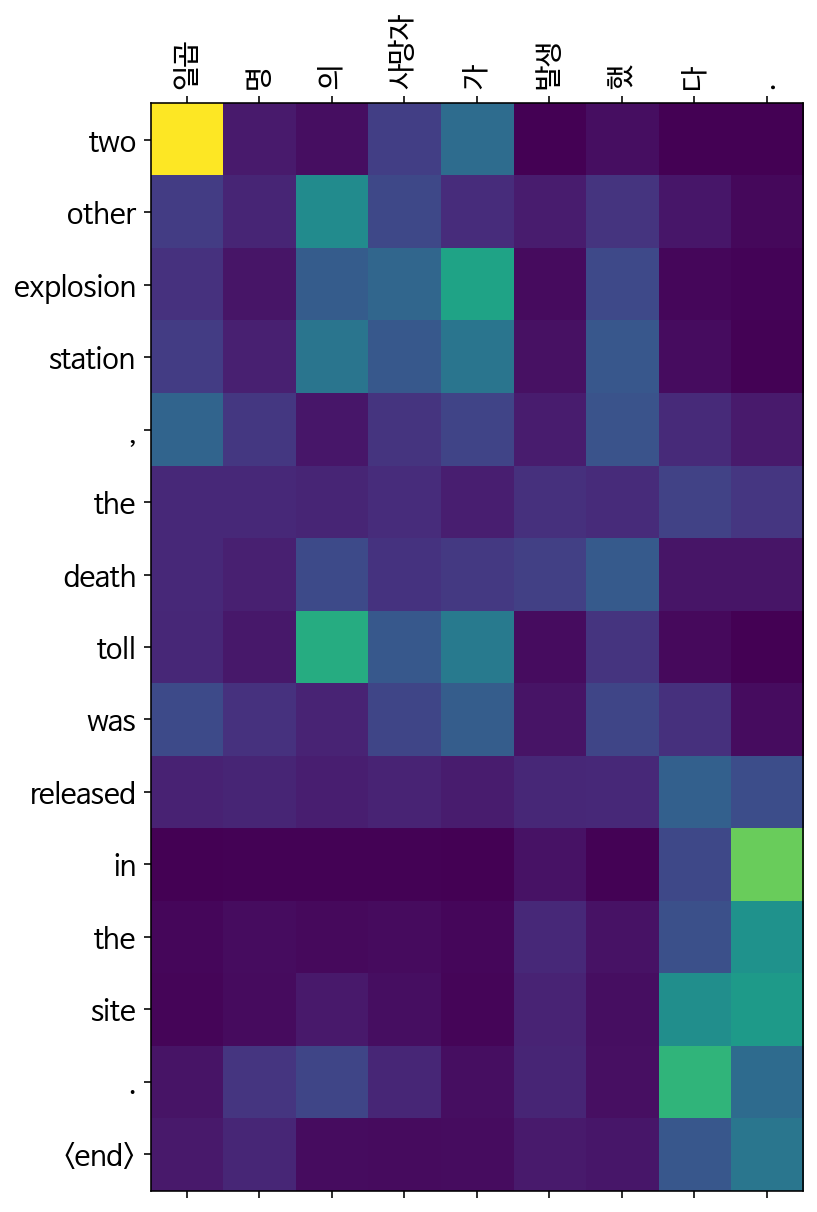

In [36]:
EPOCHS = 5
loss_history = []
train_model(5)

##  결과 분석

여러번 돌려보았지만 군데군데 몇가지 좋았던 사례가 있긴했지만 시민들은 도시속에 산다 나 커피는 필요없다는 적절한 예를 찾지 못했다.

![](https://github.com/currybab/first-repository/assets/7679722/150141b3-c76f-4a7b-9bfe-eb33b997090c)

오바마라는 단어도 잘 찾았고 대통령이라는 단어도 나타나지만 운이좋았던것 같다. attention이 후자의 경우 적절한곳을 바라보고 있다는 생각이 들지 않는다.

![](https://github.com/currybab/first-repository/assets/7679722/476815aa-13a5-4ed4-aa69-9fe08e2361ff)

대충 사망과 관련된 내용이 나오긴했으나 of를 정확히 보고 있는것 말고는 잘 모르겠다.

## 회고

간단한 한영 번역기도 쉽지 않구나....